In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide, under_over, over_under
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, all_optuna, optuna_history

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### balance cascade

In [2]:
class BalanceCascade:
    
    def __init__(self, base_clf = 'LightGBM', num_iter = 5, over_method = None, over_num = 10, verbose = False):
        self.classifier = base_clf
        self.num_iter = num_iter
        self.over_method = over_method
        self.over_num = over_num if over_method else 1
        self.verbose = verbose
        if over_method not in ['ADASYN', None]:
            raise Exception(f'{over_method} is not implemented !')
        elif base_clf not in ['LightGBM', 'RandomForest']:
            raise Exception(f'{base_clf} is not implmented !')

    
    def training(self, train_data, clf_config):
        origin_good = train_data[train_data.GB == 0]
        origin_bad = train_data[train_data.GB == 1] 
        br_0 = (len(origin_bad)*self.over_num) / len(origin_good)
        false_rate = br_0**(1/(self.num_iter - 1))
        
        keep_bad = origin_bad.copy()
        keep_good = {0: origin_good.copy()}
        br_list = []
        clf_threshold = []
        clf_cascade = {}
        for j in range(self.num_iter):
            temp_train = pd.concat([keep_good[j], keep_bad], axis = 0)
            temp_br = len(keep_bad) / len(keep_good[j])
            br_list.append(temp_br)
            # oversampling
            if all([self.over_method, len(keep_good[j] > len(keep_bad))]):
                if self.verbose:
                    print(f'\nIteration {j+1}:')
                over_ratio = np.min([br_list[j]*self.over_num, 0.99])
                over_X, over_Y = under_over(temp_train, self.over_method, None, over_ratio, 0)
                over_sample = pd.concat([over_X, over_Y], axis = 1)
                over_sample = over_sample.rename({0: 'GB'}, axis = 'columns')
                over_bad = over_sample[over_sample.GB == 1]
            else:
                over_bad = keep_bad.copy()
                if self.verbose:
                    print('Stop Oversampling !')
            
            # undersampling
            if all([j != (self.num_iter - 1), len(keep_good[j]) > len(over_bad)]):
                under_ratio = len(keep_bad) / len(over_bad)
                under_X, under_Y = over_under(temp_train, None, 'NM', 0, under_ratio)
                under_sample = pd.concat([under_X, under_Y], axis = 1)
                under_good = under_sample[under_sample.GB == 0]
            else:
                under_good = keep_good[j].copy()
                if self.verbose:
                    print('Stop Undersampling !')
            train_combine = pd.concat([under_good, over_bad], axis = 0)
            
            # train the base learner, find the threshold, and discard the redundant good instances
            valid_good = keep_good[j].copy()
            train_x, train_y, valid_x, valid_y = label_divide(train_combine, valid_good, 'GB', train_only = False)
            if self.classifier == 'LightGBM':
                clf = LGBMClassifier(**clf_config)
            elif self.classifier == 'RandomForest':
                clf = RandomForestClassifier(**clf_config)
            clf.fit(train_x, train_y)
            predict = clf.predict_proba(valid_x)[:, 1]
            predict_df = pd.DataFrame(dict(predict = predict), index = valid_x.index)
            predict_df = predict_df.sort_values(by = 'predict', ascending = False)
            keep_num = int(len(predict_df)*false_rate) + 1
            keep_index = predict_df.index[:keep_num]
            threshold = predict_df.loc[keep_index[-1]].values[0]
            clf_threshold.append(threshold)
            clf_cascade[j] = clf
            
            if j != (self.num_iter - 1):
                keep_good[j+1] = keep_good[j].loc[keep_index].copy()        
        self.good_data = keep_good
        self.bad_data = keep_bad
        self.threshold = clf_threshold
        self.cascade = clf_cascade
        self.balance_ratio = br_list
    
    
    def testing(self, test_data):
        clf_cascade = self.cascade
        if isinstance(self.threshold, int):
            clf_threshold = [self.threshold]*len(clf_cascade)
        else:
            clf_threshold = self.threshold

        test_x, test_y = label_divide(test_data, 'GB', train_only = True)
        predict_df = pd.DataFrame()
        for i in range(len(clf_cascade)):
            clf = clf_cascade[i]
            predict = clf.predict_proba(test_x)[:, 1]
            answer = (predict > clf_threshold[i]).astype(int)
            predict = pd.DataFrame({str(i): answer})
            predict_df = pd.concat([predict_df, predict], axis = 1)
        predict_y = (predict_df.apply(sum, axis = 1) == len(clf_cascade)).astype(int)
        result = pd.DataFrame(dict(predict = predict_y, truth = test_y))

        return result


def runall_cascade(train_set, test_data, base_config, base_clf = 'LightGBM', num_iter = 10, meta_config = None):
    
    num_set = len(train_set)
    table_set = pd.DataFrame()
    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        if isinstance(meta_config, dict):
            BC = BalanceCascade(base_clf = base_clf, **meta_config[f'set{i}'])
        else:
            BC = BalanceCascade(base_clf = base_clf, num_iter = num_iter)
        BC.training(train_set[f'set{i}'], base_config[f'set{i}'])
        result = BC.testing(test_data)
        table = cf_matrix(result, train_set[f'set{i}'].GB)
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
    
    return table_set

### optuna

In [3]:
def BalanceCascade_creator(train_data, mode, num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        base_param = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500]),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 12, step = 3),
            'num_leaves': trial.suggest_int('num_leaves', 10, 90, step = 20),
            'min_child_samples': trial.suggest_categorical('min_child_samples', [50, 100, 500, 1000, 5000]),
            'min_split_gain': trial.suggest_int('min_split_gain', 0, 12, step = 2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9, step = 0.2),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10) # lambda
        }
#         base_param = {
#             'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
#             'n_estimators': trial.suggest_int('n_estimators', 100, 300, step = 50),
#             'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
#             'num_leaves': trial.suggest_int('num_leaves', 5, 40, step = 5),
#             'min_child_samples': trial.suggest_int('min_child_samples', 3, 24, step = 3),
#             'max_depth': trial.suggest_int('max_depth', 3, 15, step = 2),
#             'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.425, step = 0.05),
#             'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 5), # alpha
#             'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 5) # lambda
#         }
    
        meta_param = {
            'num_iter': trial.suggest_int('num_iter', 10, 10, step = 5),
            'over_num': trial.suggest_int('over_num', 5, 5, step = 5),
            'over_method': trial.suggest_categorical('over_method', ['ADASYN'])
        }
        

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)
            all_train = pd.concat([train_x, train_y], axis = 1)
            all_valid = pd.concat([valid_x, valid_y], axis = 1)

            if mode == 1:
                BC = BalanceCascade(base_clf = 'LightGBM', num_iter = meta_param['num_iter'])
            elif mode == 2:
                BC = BalanceCascade(base_clf = 'LightGBM', num_iter = meta_param['num_iter'], 
                                    over_method = meta_param['over_method'], over_num = meta_param['over_num'])
            BC.training(all_train, base_param)
            result = BC.testing(all_valid)
            table = cf_matrix(result, valid_y)
            recall = table['Recall'].values
            precision = table['Precision'].values
            beta = 1
            if recall > 0:
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision) 
            else:
                fscore = 0
            result_list.append(fscore)

        return np.mean(result_list)
    return objective

## 

### loading hyperparameters & datasets

In [4]:
### training data ###
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (13534, 88)  balance ratio: 100.0
Dimension of dataset 2 : (13938, 88)  balance ratio: 100.0
Dimension of dataset 3 : (13837, 88)  balance ratio: 100.0
Dimension of dataset 4 : (13837, 88)  balance ratio: 100.0
Dimension of dataset 5 : (13934, 88)  balance ratio: 102.99
Dimension of dataset 6 : (13938, 88)  balance ratio: 100.0
Dimension of dataset 7 : (13937, 88)  balance ratio: 100.73
Dimension of dataset 8 : (13938, 88)  balance ratio: 100.0
Dimension of dataset 9 : (6969, 88)  balance ratio: 100.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (21412, 97)  balance ratio: 100.0
Dimension of dataset 2 : (22826, 97)  balance ratio: 100.0
Dimension of dataset 3 : (22725, 97)  balance ratio: 100.0
Dimension of dataset 4 : (22725, 97)  balance ratio: 100.0
Dimension of dataset 5 : (2

### search for the best hyperparameters

In [5]:
best_paramC, all_scoreC = all_optuna(num_set = len(run_train), 
                                     all_data = run_train, 
                                     mode = 2, 
                                     TPE_multi = False, 
                                     n_iter = 100,
                                     filename = 'runhist_array_m2m4_m5_3criteria_br100_over5_iter10_over5_BalanceCascade',
                                     creator = BalanceCascade_creator
                                    )

meta_item = ['num_iter', 'over_num', 'over_method']
base_paramC = {}
meta_paramC = {}
for i in range(len(run_train)):
    base_paramC.update({f'set{i}': {}})
    meta_paramC.update({f'set{i}': {}})
    [base_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a not in meta_item]
    [meta_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a in meta_item]

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-28 11:17:54,917] A new study created in memory with name: no-name-d13959c4-ee80-45a7-a2fd-a3b4f0883d63


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 117861
Size after Oversampling: 118791
Size after Undersampling: 1386
Size before Oversampling: 70502
Size after Oversampling: 71429
Size after Undersampling: 1383
Size before Oversampling: 42210
Size after Oversampling: 43137
Size after Undersampling: 1383
Size before Oversampling: 25308
Size after Oversampling: 26234
Size after Undersampling: 1382
Size before Oversampling: 15211
Size after Oversampling: 16135
Size after Undersampling: 1380
Size before Oversampling: 9179
Size after Oversampling: 10095
Size after Undersampling: 1372
Size before Oversampling: 5576
Size after Oversampling: 6494
Size after Undersampling: 1374
Size before Oversampling: 3423
Size after Oversampling: 4319
Size after Undersampling: 1352
Size before Oversampling: 2137
Size after Oversampling: 3044
Size after Undersampling: 1363
Size before Oversampling: 1369
Size after Oversampling: 2265
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.005529387671513414
Size before Oversampling: 117861
Siz

Size after Undersampling: 1368
Size before Oversampling: 9179
Size after Oversampling: 10106
Size after Undersampling: 1383
Size before Oversampling: 5576
Size after Oversampling: 6520
Size after Undersampling: 1400
Size before Oversampling: 3423
Size after Oversampling: 4363
Size after Undersampling: 1396
Size before Oversampling: 2137
Size after Oversampling: 3051
Size after Undersampling: 1370
Size before Oversampling: 1369
Size after Oversampling: 2297


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118802
Size after Undersampling: 1397
Size before Oversampling: 70502
Size after Oversampling: 71440
Size after Undersampling: 1394
Size before Oversampling: 42210
Size after Oversampling: 43131
Size after Undersampling: 1377
Size before Oversampling: 25308
Size after Oversampling: 26226
Size after Undersampling: 1374
Size before Oversampling: 15211
Size after Oversampling: 16111
Size after Undersampling: 1356
Size before Oversampling: 9179
Size after Oversampling: 10072
Size after Undersampling: 1349
Size before Oversampling: 5576
Size after Oversampling: 6504
Size after Undersampling: 1384
Size before Oversampling: 3423
Size after Oversampling: 4333
Size after Undersampling: 1366
Size before Oversampling: 2137
Size after Oversampling: 3033
Size after Undersampling: 1352
Size before Oversampling: 1369
Size after Oversampling: 2273
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.001221249745

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118738
Size after Undersampling: 1333
Size before Oversampling: 70502
Size after Oversampling: 71379
Size after Undersampling: 1333
Size before Oversampling: 42210
Size after Oversampling: 43077
Size after Undersampling: 1323
Size before Oversampling: 25308
Size after Oversampling: 26231
Size after Undersampling: 1379
Size before Oversampling: 15211
Size after Oversampling: 16127
Size after Undersampling: 1372
Size before Oversampling: 9179
Size after Oversampling: 10080
Size after Undersampling: 1357
Size before Oversampling: 5576
Size after Oversampling: 6494
Size after Undersampling: 1374
Size before Oversampling: 3423
Size after Oversampling: 4342
Size after Undersampling: 1375
Size before Oversampling: 2137
Size after Oversampling: 3048
Size after Undersampling: 1367
Size before Oversampling: 1369
Size after Oversampling: 2263


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118791
Size after Undersampling: 1386
Size before Oversampling: 70502
Size after Oversampling: 71448
Size after Undersampling: 1402
Size before Oversampling: 42210
Size after Oversampling: 43127
Size after Undersampling: 1373
Size before Oversampling: 25308
Size after Oversampling: 26214
Size after Undersampling: 1362
Size before Oversampling: 15211
Size after Oversampling: 16105
Size after Undersampling: 1350
Size before Oversampling: 9179
Size after Oversampling: 10100
Size after Undersampling: 1377
Size before Oversampling: 5576
Size after Oversampling: 6502
Size after Undersampling: 1382
Size before Oversampling: 3423
Size after Oversampling: 4380
Size after Undersampling: 1413
Size before Oversampling: 2137
Size after Oversampling: 3039
Size after Undersampling: 1358
Size before Oversampling: 1369
Size after Oversampling: 2262
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.000915937309

Size after Undersampling: 1378
Size before Oversampling: 70502
Size after Oversampling: 71424
Size after Undersampling: 1378
Size before Oversampling: 42210
Size after Oversampling: 43131
Size after Undersampling: 1377
Size before Oversampling: 25308
Size after Oversampling: 26229
Size after Undersampling: 1377
Size before Oversampling: 15211
Size after Oversampling: 16128
Size after Undersampling: 1373
Size before Oversampling: 9179
Size after Oversampling: 10115
Size after Undersampling: 1392
Size before Oversampling: 5576
Size after Oversampling: 6506
Size after Undersampling: 1386
Size before Oversampling: 3423
Size after Oversampling: 4341
Size after Undersampling: 1374
Size before Oversampling: 2137
Size after Oversampling: 3027
Size after Undersampling: 1346
Size before Oversampling: 1369
Size after Oversampling: 2284
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007150153217568948
Size before Oversampling: 117861
Size after Oversampling: 118813
Size after Undersampling: 1408
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118774
Size after Undersampling: 1369
Size before Oversampling: 70502
Size after Oversampling: 71441
Size after Undersampling: 1395
Size before Oversampling: 42210
Size after Oversampling: 43136
Size after Undersampling: 1382
Size before Oversampling: 25308
Size after Oversampling: 26213
Size after Undersampling: 1361
Size before Oversampling: 15211
Size after Oversampling: 16098
Size after Undersampling: 1343
Size before Oversampling: 9179
Size after Oversampling: 10100
Size after Undersampling: 1377
Size before Oversampling: 5576
Size after Oversampling: 6483
Size after Undersampling: 1363
Size before Oversampling: 3423
Size after Oversampling: 4340
Size after Undersampling: 1373
Size before Oversampling: 2137
Size after Oversampling: 3019
Size after Undersampling: 1338
Size before Oversampling: 1369
Size after Oversampling: 2292


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118803
Size after Undersampling: 1398
Size before Oversampling: 70502
Size after Oversampling: 71446
Size after Undersampling: 1400
Size before Oversampling: 42210
Size after Oversampling: 43139
Size after Undersampling: 1385
Size before Oversampling: 25308
Size after Oversampling: 26225
Size after Undersampling: 1373
Size before Oversampling: 15211
Size after Oversampling: 16159
Size after Undersampling: 1404
Size before Oversampling: 9179
Size after Oversampling: 10092
Size after Undersampling: 1369
Size before Oversampling: 5576
Size after Oversampling: 6478
Size after Undersampling: 1358
Size before Oversampling: 3423
Size after Oversampling: 4315
Size after Undersampling: 1348
Size before Oversampling: 2137
Size after Oversampling: 3059
Size after Undersampling: 1378
Size before Oversampling: 1369
Size after Oversampling: 2266
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.001732572360

Size after Oversampling: 118767
Size after Undersampling: 1362
Size before Oversampling: 70502
Size after Oversampling: 71409
Size after Undersampling: 1363
Size before Oversampling: 42210
Size after Oversampling: 43116
Size after Undersampling: 1362
Size before Oversampling: 25308
Size after Oversampling: 26212
Size after Undersampling: 1360
Size before Oversampling: 15211
Size after Oversampling: 16113
Size after Undersampling: 1358
Size before Oversampling: 9179
Size after Oversampling: 10073
Size after Undersampling: 1350
Size before Oversampling: 5576
Size after Oversampling: 6463
Size after Undersampling: 1343
Size before Oversampling: 3423
Size after Oversampling: 4347
Size after Undersampling: 1380
Size before Oversampling: 2137
Size after Oversampling: 3067
Size after Undersampling: 1386
Size before Oversampling: 1369
Size after Oversampling: 2283


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118802
Size after Undersampling: 1397
Size before Oversampling: 70502
Size after Oversampling: 71445
Size after Undersampling: 1399
Size before Oversampling: 42210
Size after Oversampling: 43150
Size after Undersampling: 1396
Size before Oversampling: 25308
Size after Oversampling: 26241
Size after Undersampling: 1389
Size before Oversampling: 15211
Size after Oversampling: 16141
Size after Undersampling: 1386
Size before Oversampling: 9179
Size after Oversampling: 10099
Size after Undersampling: 1376
Size before Oversampling: 5576
Size after Oversampling: 6518
Size after Undersampling: 1398
Size before Oversampling: 3423
Size after Oversampling: 4344
Size after Undersampling: 1377
Size before Oversampling: 2137
Size after Oversampling: 3034
Size after Undersampling: 1353
Size before Oversampling: 1369
Size after Oversampling: 2278


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118780
Size after Undersampling: 1375
Size before Oversampling: 70502
Size after Oversampling: 71422
Size after Undersampling: 1376
Size before Oversampling: 42210
Size after Oversampling: 43127
Size after Undersampling: 1373
Size before Oversampling: 25308
Size after Oversampling: 26218
Size after Undersampling: 1366
Size before Oversampling: 15211
Size after Oversampling: 16119
Size after Undersampling: 1364
Size before Oversampling: 9179
Size after Oversampling: 10072
Size after Undersampling: 1349
Size before Oversampling: 5576
Size after Oversampling: 6477
Size after Undersampling: 1357
Size before Oversampling: 3423
Size after Oversampling: 4355
Size after Undersampling: 1388
Size before Oversampling: 2137
Size after Oversampling: 3054
Size after Undersampling: 1373
Size before Oversampling: 1369
Size after Oversampling: 2290


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 11:24:41,867] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 7.856193671454054, 'reg_lambda': 0.622871359381814, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 1 with value: 0.016717289444562175.
Size before Oversampling: 117861
Size after Oversampling: 118797
Size after Undersampling: 1392
Size before Oversampling: 70502
Size after Oversampling: 71439
Size after Undersampling: 1393
Size before Oversampling: 42210
Size after Oversampling: 43146
Size after Undersampling: 1392
Size before Oversampling: 25308
Size after Oversampling: 26244
Size after Undersampling: 1392
Size before Oversampling: 15211
Size after Oversampling: 16144
Size after Undersampling: 1389
Size before Oversampling: 9179
Size after Oversampling: 10108
S

Size before Oversampling: 117861
Size after Oversampling: 118812
Size after Undersampling: 1407
Size before Oversampling: 70502
Size after Oversampling: 71453
Size after Undersampling: 1407
Size before Oversampling: 42210
Size after Oversampling: 43156
Size after Undersampling: 1402
Size before Oversampling: 25308
Size after Oversampling: 26255
Size after Undersampling: 1403
Size before Oversampling: 15211
Size after Oversampling: 16154
Size after Undersampling: 1399
Size before Oversampling: 9179
Size after Oversampling: 10119
Size after Undersampling: 1396
Size before Oversampling: 5576
Size after Oversampling: 6510
Size after Undersampling: 1390
Size before Oversampling: 3423
Size after Oversampling: 4343
Size after Undersampling: 1376
Size before Oversampling: 2137
Size after Oversampling: 3057
Size after Undersampling: 1376
Size before Oversampling: 1369
Size after Oversampling: 2249
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00790193496099686
Size before Oversampling: 117861
Size

Size after Undersampling: 1391
Size before Oversampling: 5576
Size after Oversampling: 6510
Size after Undersampling: 1390
Size before Oversampling: 3423
Size after Oversampling: 4350
Size after Undersampling: 1383
Size before Oversampling: 2137
Size after Oversampling: 3066
Size after Undersampling: 1385
Size before Oversampling: 1369
Size after Oversampling: 2289
Precision: 0.010416666666666666 
Recall: 0.023255813953488372 
Aging Rate: 0.009794918885827977
[I 2022-02-28 11:28:02,021] Trial 15 finished with value: 0.004796163069544365 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.05294461638848895, 'reg_lambda': 0.0472675735358357, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 1 with value: 0.016717289444562175.
Size before Oversampling: 117861
Size after Oversampling: 118808
Size after Undersampling: 1403


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118815
Size after Undersampling: 1410
Size before Oversampling: 70502
Size after Oversampling: 71457
Size after Undersampling: 1411
Size before Oversampling: 42210
Size after Oversampling: 43164
Size after Undersampling: 1410
Size before Oversampling: 25308
Size after Oversampling: 26260
Size after Undersampling: 1408
Size before Oversampling: 15211
Size after Oversampling: 16148
Size after Undersampling: 1393
Size before Oversampling: 9179
Size after Oversampling: 10109
Size after Undersampling: 1386
Size before Oversampling: 5576
Size after Oversampling: 6496
Size after Undersampling: 1376
Size before Oversampling: 3423
Size after Oversampling: 4331
Size after Undersampling: 1364
Size before Oversampling: 2137
Size after Oversampling: 3030
Size after Undersampling: 1349
Size before Oversampling: 1369
Size after Oversampling: 2291


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118787
Size after Undersampling: 1382
Size before Oversampling: 70502
Size after Oversampling: 71429
Size after Undersampling: 1383
Size before Oversampling: 42210
Size after Oversampling: 43135
Size after Undersampling: 1381
Size before Oversampling: 25308
Size after Oversampling: 26232
Size after Undersampling: 1380
Size before Oversampling: 15211
Size after Oversampling: 16156
Size after Undersampling: 1401
Size before Oversampling: 9179
Size after Oversampling: 10102
Size after Undersampling: 1379
Size before Oversampling: 5576
Size after Oversampling: 6493
Size after Undersampling: 1373
Size before Oversampling: 3423
Size after Oversampling: 4327
Size after Undersampling: 1360
Size before Oversampling: 2137
Size after Oversampling: 3053
Size after Undersampling: 1372
Size before Oversampling: 1369
Size after Oversampling: 2255


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 11:29:16,336] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 3.1963079701060697, 'reg_lambda': 0.20539995229722952, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 1 with value: 0.016717289444562175.
Size before Oversampling: 117861
Size after Oversampling: 118803
Size after Undersampling: 1398
Size before Oversampling: 70502
Size after Oversampling: 71445
Size after Undersampling: 1399
Size before Oversampling: 42210
Size after Oversampling: 43152
Size after Undersampling: 1398
Size before Oversampling: 25308
Size after Oversampling: 26250
Size after Undersampling: 1398
Size before Oversampling: 15211
Size after Oversampling: 16148
Size after Undersampling: 1393
Size before Oversampling: 9179
Size after Oversampling: 10120

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118789
Size after Undersampling: 1384
Size before Oversampling: 70502
Size after Oversampling: 71430
Size after Undersampling: 1384
Size before Oversampling: 42210
Size after Oversampling: 43138
Size after Undersampling: 1384
Size before Oversampling: 25308
Size after Oversampling: 26234
Size after Undersampling: 1382
Size before Oversampling: 15211
Size after Oversampling: 16119
Size after Undersampling: 1364
Size before Oversampling: 9179
Size after Oversampling: 10087
Size after Undersampling: 1364
Size before Oversampling: 5576
Size after Oversampling: 6466
Size after Undersampling: 1346
Size before Oversampling: 3423
Size after Oversampling: 4342
Size after Undersampling: 1375
Size before Oversampling: 2137
Size after Oversampling: 3069
Size after Undersampling: 1388
Size before Oversampling: 1369
Size after Oversampling: 2241


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118809
Size after Undersampling: 1404
Size before Oversampling: 70502
Size after Oversampling: 71448
Size after Undersampling: 1402
Size before Oversampling: 42210
Size after Oversampling: 43156
Size after Undersampling: 1402
Size before Oversampling: 25308
Size after Oversampling: 26249
Size after Undersampling: 1397
Size before Oversampling: 15211
Size after Oversampling: 16150
Size after Undersampling: 1395
Size before Oversampling: 9179
Size after Oversampling: 10113
Size after Undersampling: 1390
Size before Oversampling: 5576
Size after Oversampling: 6502
Size after Undersampling: 1382
Size before Oversampling: 3423
Size after Oversampling: 4371
Size after Undersampling: 1404
Size before Oversampling: 2137
Size after Oversampling: 3040
Size after Undersampling: 1359
Size before Oversampling: 1369
Size after Oversampling: 2270


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 11:31:06,773] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.6202829146607652, 'reg_lambda': 0.027586507691292214, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 1 with value: 0.016717289444562175.
Size before Oversampling: 117861
Size after Oversampling: 118812
Size after Undersampling: 1407
Size before Oversampling: 70502
Size after Oversampling: 71454
Size after Undersampling: 1408
Size before Oversampling: 42210
Size after Oversampling: 43163
Size after Undersampling: 1409
Size before Oversampling: 25308
Size after Oversampling: 26260
Size after Undersampling: 1408
Size before Oversampling: 15211
Size after Oversampling: 16161
Size after Undersampling: 1406
Size before Oversampling: 9179
Size after Oversampling: 101

Size before Oversampling: 117861
Size after Oversampling: 118787
Size after Undersampling: 1382
Size before Oversampling: 70502
Size after Oversampling: 71458
Size after Undersampling: 1412
Size before Oversampling: 42210
Size after Oversampling: 43165
Size after Undersampling: 1411
Size before Oversampling: 25308
Size after Oversampling: 26254
Size after Undersampling: 1402
Size before Oversampling: 15211
Size after Oversampling: 16157
Size after Undersampling: 1402
Size before Oversampling: 9179
Size after Oversampling: 10114
Size after Undersampling: 1391
Size before Oversampling: 5576
Size after Oversampling: 6505
Size after Undersampling: 1385
Size before Oversampling: 3423
Size after Oversampling: 4331
Size after Undersampling: 1364
Size before Oversampling: 2137
Size after Oversampling: 3046
Size after Undersampling: 1365
Size before Oversampling: 1369
Size after Oversampling: 2273
Precision: 0.017241379310344827 
Recall: 0.022222222222222223 
Aging Rate: 0.005857402544940416
Si

Size after Oversampling: 16165
Size after Undersampling: 1410
Size before Oversampling: 9179
Size after Oversampling: 10118
Size after Undersampling: 1395
Size before Oversampling: 5576
Size after Oversampling: 6491
Size after Undersampling: 1371
Size before Oversampling: 3423
Size after Oversampling: 4325
Size after Undersampling: 1358
Size before Oversampling: 2137
Size after Oversampling: 3051
Size after Undersampling: 1370
Size before Oversampling: 1369
Size after Oversampling: 2279
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00569771055630374
[I 2022-02-28 11:34:10,025] Trial 25 finished with value: 0.0058997050147492625 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.011835609988177266, 'reg_lambda': 1.1146780277243231, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.0221977034

Size after Undersampling: 1399
Size before Oversampling: 15211
Size after Oversampling: 16160
Size after Undersampling: 1405
Size before Oversampling: 9179
Size after Oversampling: 10135
Size after Undersampling: 1412
Size before Oversampling: 5576
Size after Oversampling: 6510
Size after Undersampling: 1390
Size before Oversampling: 3423
Size after Oversampling: 4322
Size after Undersampling: 1355
Size before Oversampling: 2137
Size after Oversampling: 3039
Size after Undersampling: 1358
Size before Oversampling: 1369
Size after Oversampling: 2275
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00801867641088104
Size before Oversampling: 117861
Size after Oversampling: 118778
Size after Undersampling: 1373
Size before Oversampling: 70502
Size after Oversampling: 71418
Size after Undersampling: 1372
Size before Oversampling: 42210
Size after Oversampling: 43124
Size after Undersampling: 1370
Size before Oversampling: 25308
Size after Oversampling: 26241
Size after Undersampling: 1389
Size b

Precision: 0.01639344262295082 
Recall: 0.02127659574468085 
Aging Rate: 0.006280242973334706
Size before Oversampling: 117861
Size after Oversampling: 118814
Size after Undersampling: 1409
Size before Oversampling: 70502
Size after Oversampling: 71454
Size after Undersampling: 1408
Size before Oversampling: 42210
Size after Oversampling: 43159
Size after Undersampling: 1405
Size before Oversampling: 25308
Size after Oversampling: 26257
Size after Undersampling: 1405
Size before Oversampling: 15211
Size after Oversampling: 16147
Size after Undersampling: 1392
Size before Oversampling: 9179
Size after Oversampling: 10102
Size after Undersampling: 1379
Size before Oversampling: 5576
Size after Oversampling: 6489
Size after Undersampling: 1369
Size before Oversampling: 3423
Size after Oversampling: 4318
Size after Undersampling: 1351
Size before Oversampling: 2137
Size after Oversampling: 3054
Size after Undersampling: 1373
Size before Oversampling: 1369
Size after Oversampling: 2248
Prec

Size before Oversampling: 117861
Size after Oversampling: 118786
Size after Undersampling: 1381
Size before Oversampling: 70502
Size after Oversampling: 71455
Size after Undersampling: 1409
Size before Oversampling: 42210
Size after Oversampling: 43149
Size after Undersampling: 1395
Size before Oversampling: 25308
Size after Oversampling: 26213
Size after Undersampling: 1361
Size before Oversampling: 15211
Size after Oversampling: 16138
Size after Undersampling: 1383
Size before Oversampling: 9179
Size after Oversampling: 10110
Size after Undersampling: 1387
Size before Oversampling: 5576
Size after Oversampling: 6465
Size after Undersampling: 1345
Size before Oversampling: 3423
Size after Oversampling: 4310
Size after Undersampling: 1343
Size before Oversampling: 2137
Size after Oversampling: 3053
Size after Undersampling: 1372
Size before Oversampling: 1369
Size after Oversampling: 2265


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118789
Size after Undersampling: 1384
Size before Oversampling: 70502
Size after Oversampling: 71458
Size after Undersampling: 1412
Size before Oversampling: 42210
Size after Oversampling: 43130
Size after Undersampling: 1376
Size before Oversampling: 25308
Size after Oversampling: 26201
Size after Undersampling: 1349
Size before Oversampling: 15211
Size after Oversampling: 16116
Size after Undersampling: 1361
Size before Oversampling: 9179
Size after Oversampling: 10090
Size after Undersampling: 1367
Size before Oversampling: 5576
Size after Oversampling: 6475
Size after Undersampling: 1355
Size before Oversampling: 3423
Size after Oversampling: 4330
Size after Undersampling: 1363
Size before Oversampling: 2137
Size after Oversampling: 3064
Size after Undersampling: 1383
Size before Oversampling: 1369
Size after Oversampling: 2285


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118800
Size after Undersampling: 1395
Size before Oversampling: 70502
Size after Oversampling: 71439
Size after Undersampling: 1393
Size before Oversampling: 42210
Size after Oversampling: 43145
Size after Undersampling: 1391
Size before Oversampling: 25308
Size after Oversampling: 26220
Size after Undersampling: 1368
Size before Oversampling: 15211
Size after Oversampling: 16130
Size after Undersampling: 1375
Size before Oversampling: 9179
Size after Oversampling: 10097
Size after Undersampling: 1374
Size before Oversampling: 5576
Size after Oversampling: 6511
Size after Undersampling: 1391
Size before Oversampling: 3423
Size after Oversampling: 4301
Size after Undersampling: 1334
Size before Oversampling: 2137
Size after Oversampling: 3046
Size after Undersampling: 1365
Size before Oversampling: 1369
Size after Oversampling: 2284


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 11:39:08,337] Trial 33 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.052235445522346026, 'reg_lambda': 1.4512077665876733, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118781
Size after Undersampling: 1376
Size before Oversampling: 70502
Size after Oversampling: 71453
Size after Undersampling: 1407
Size before Oversampling: 42210
Size after Oversampling: 43159
Size after Undersampling: 1405
Size before Oversampling: 25308
Size after Oversampling: 26257
Size after Undersampling: 1405
Size before Oversampling: 15211
Size after Oversampling: 16157
Size after Undersampling: 1402
Size before Oversampling: 9179
Size after Ov

Size after Oversampling: 118787
Size after Undersampling: 1382
Size before Oversampling: 70502
Size after Oversampling: 71453
Size after Undersampling: 1407
Size before Oversampling: 42210
Size after Oversampling: 43148
Size after Undersampling: 1394
Size before Oversampling: 25308
Size after Oversampling: 26231
Size after Undersampling: 1379
Size before Oversampling: 15211
Size after Oversampling: 16116
Size after Undersampling: 1361
Size before Oversampling: 9179
Size after Oversampling: 10073
Size after Undersampling: 1350
Size before Oversampling: 5576
Size after Oversampling: 6463
Size after Undersampling: 1343
Size before Oversampling: 3423
Size after Oversampling: 4340
Size after Undersampling: 1373
Size before Oversampling: 2137
Size after Oversampling: 3067
Size after Undersampling: 1386
Size before Oversampling: 1369
Size after Oversampling: 2297
Precision: 0.043478260869565216 
Recall: 0.02 
Aging Rate: 0.002303224514320048
Size before Oversampling: 117861
Size after Oversam

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 11:40:57,306] Trial 36 finished with value: 0.0091324200913242 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.050279018538170434, 'reg_lambda': 2.135891555129231, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118809
Size after Undersampling: 1404
Size before Oversampling: 70502
Size after Oversampling: 71443
Size after Undersampling: 1397
Size before Oversampling: 42210
Size after Oversampling: 43151
Size after Undersampling: 1397
Size before Oversampling: 25308
Size after Oversampling: 26249
Size after Undersampling: 1397
Size before Oversampling: 15211
Size after Oversampling: 16143
Size after Undersampling: 1388
Size before Oversampling: 9179
Size after Ov

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.006895132242461665
Size before Oversampling: 117861
Size after Oversampling: 118808
Size after Undersampling: 1403
Size before Oversampling: 70502
Size after Oversampling: 71447
Size after Undersampling: 1401
Size before Oversampling: 42210
Size after Oversampling: 43153
Size after Undersampling: 1399
Size before Oversampling: 25308
Size after Oversampling: 26250
Size after Undersampling: 1398
Size before Oversampling: 15211
Size after Oversampling: 16143
Size after Undersampling: 1388
Size before Oversampling: 9179
Size after Oversampling: 10109
Size after Undersampling: 1386
Size before Oversampling: 5576
Size after Oversampling: 6495
Size after Undersampling: 1375
Size before Oversampling: 3423
Size after Oversampling: 4368
Size after Undersampling: 1401
Size before Oversampling: 2137
Size after Oversampling: 3064
Size after Undersampling: 1383
Size before Oversampling: 1369
Size after Oversampling: 2287
Precision: 0.0 
Recall: 0.0 
Aging R

Size after Undersampling: 1381
Size before Oversampling: 5576
Size after Oversampling: 6504
Size after Undersampling: 1384
Size before Oversampling: 3423
Size after Oversampling: 4376
Size after Undersampling: 1409
Size before Oversampling: 2137
Size after Oversampling: 3078
Size after Undersampling: 1397
Size before Oversampling: 1369
Size after Oversampling: 2283
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009193993257738278
[I 2022-02-28 11:44:04,523] Trial 41 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.07806865912041897, 'reg_lambda': 0.2089608361243354, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118816
Size after Undersampling: 1411
Size before Oversampling: 70502
Size after Oversam

Size after Undersampling: 1395
Size before Oversampling: 2137
Size after Oversampling: 3074
Size after Undersampling: 1393
Size before Oversampling: 1369
Size after Oversampling: 2303
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.012224179011706205
Size before Oversampling: 117861
Size after Oversampling: 118800
Size after Undersampling: 1395
Size before Oversampling: 70502
Size after Oversampling: 71442
Size after Undersampling: 1396
Size before Oversampling: 42210
Size after Oversampling: 43148
Size after Undersampling: 1394
Size before Oversampling: 25308
Size after Oversampling: 26247
Size after Undersampling: 1395
Size before Oversampling: 15211
Size after Oversampling: 16148
Size after Undersampling: 1393
Size before Oversampling: 9179
Size after Oversampling: 10117
Size after Undersampling: 1394
Size before Oversampling: 5576
Size after Oversampling: 6538
Size after Undersampling: 1418
Size before Oversampling: 3423
Size after Oversampling: 4386
Size after Undersampling: 1419
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118802
Size after Undersampling: 1397
Size before Oversampling: 70502
Size after Oversampling: 71443
Size after Undersampling: 1397
Size before Oversampling: 42210
Size after Oversampling: 43149
Size after Undersampling: 1395
Size before Oversampling: 25308
Size after Oversampling: 26247
Size after Undersampling: 1395
Size before Oversampling: 15211
Size after Oversampling: 16147
Size after Undersampling: 1392
Size before Oversampling: 9179
Size after Oversampling: 10097
Size after Undersampling: 1374
Size before Oversampling: 5576
Size after Oversampling: 6470
Size after Undersampling: 1350
Size before Oversampling: 3423
Size after Oversampling: 4307
Size after Undersampling: 1340
Size before Oversampling: 2137
Size after Oversampling: 3043
Size after Undersampling: 1362
Size before Oversampling: 1369
Size after Oversampling: 2231


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118804
Size after Undersampling: 1399
Size before Oversampling: 70502
Size after Oversampling: 71446
Size after Undersampling: 1400
Size before Oversampling: 42210
Size after Oversampling: 43153
Size after Undersampling: 1399
Size before Oversampling: 25308
Size after Oversampling: 26243
Size after Undersampling: 1391
Size before Oversampling: 15211
Size after Oversampling: 16143
Size after Undersampling: 1388
Size before Oversampling: 9179
Size after Oversampling: 10089
Size after Undersampling: 1366
Size before Oversampling: 5576
Size after Oversampling: 6472
Size after Undersampling: 1352
Size before Oversampling: 3423
Size after Oversampling: 4346
Size after Undersampling: 1379
Size before Oversampling: 2137
Size after Oversampling: 3067
Size after Undersampling: 1386
Size before Oversampling: 1369
Size after Oversampling: 2291


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 11:47:14,653] Trial 46 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.050604674415126054, 'reg_lambda': 0.2198995316344885, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118742
Size after Undersampling: 1337
Size before Oversampling: 70502
Size after Oversampling: 71370
Size after Undersampling: 1324
Size before Oversampling: 42210
Size after Oversampling: 43155
Size after Undersampling: 1401
Size before Oversampling: 25308
Size after Oversampling: 26245
Size after Undersampling: 1393
Size before Oversampling: 15211
Size after Oversampling: 16140
Size after Undersampling: 1385
Size before Oversampling: 9179
Size after Oversampling: 10

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118787
Size after Undersampling: 1382
Size before Oversampling: 70502
Size after Oversampling: 71443
Size after Undersampling: 1397
Size before Oversampling: 42210
Size after Oversampling: 43148
Size after Undersampling: 1394
Size before Oversampling: 25308
Size after Oversampling: 26228
Size after Undersampling: 1376
Size before Oversampling: 15211
Size after Oversampling: 16112
Size after Undersampling: 1357
Size before Oversampling: 9179
Size after Oversampling: 10094
Size after Undersampling: 1371
Size before Oversampling: 5576
Size after Oversampling: 6509
Size after Undersampling: 1389
Size before Oversampling: 3423
Size after Oversampling: 4341
Size after Undersampling: 1374
Size before Oversampling: 2137
Size after Oversampling: 3067
Size after Undersampling: 1386
Size before Oversampling: 1369
Size after Oversampling: 2231
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.001012658227

Size before Oversampling: 117861
Size after Oversampling: 118802
Size after Undersampling: 1397
Size before Oversampling: 70502
Size after Oversampling: 71438
Size after Undersampling: 1392
Size before Oversampling: 42210
Size after Oversampling: 43146
Size after Undersampling: 1392
Size before Oversampling: 25308
Size after Oversampling: 26242
Size after Undersampling: 1390
Size before Oversampling: 15211
Size after Oversampling: 16136
Size after Undersampling: 1381
Size before Oversampling: 9179
Size after Oversampling: 10102
Size after Undersampling: 1379
Size before Oversampling: 5576
Size after Oversampling: 6501
Size after Undersampling: 1381
Size before Oversampling: 3423
Size after Oversampling: 4336
Size after Undersampling: 1369
Size before Oversampling: 2137
Size after Oversampling: 3054
Size after Undersampling: 1373
Size before Oversampling: 1369
Size after Oversampling: 2263
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007757404795486601
Size before Oversampling: 117861
Siz

Size after Undersampling: 1383
Size before Oversampling: 9179
Size after Oversampling: 10106
Size after Undersampling: 1383
Size before Oversampling: 5576
Size after Oversampling: 6501
Size after Undersampling: 1381
Size before Oversampling: 3423
Size after Oversampling: 4346
Size after Undersampling: 1379
Size before Oversampling: 2137
Size after Oversampling: 3086
Size after Undersampling: 1405
Size before Oversampling: 1369
Size after Oversampling: 2285
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.011432618373128289
Size before Oversampling: 117861
Size after Oversampling: 118806
Size after Undersampling: 1401
Size before Oversampling: 70502
Size after Oversampling: 71445
Size after Undersampling: 1399
Size before Oversampling: 42210
Size after Oversampling: 43152
Size after Undersampling: 1398
Size before Oversampling: 25308
Size after Oversampling: 26250
Size after Undersampling: 1398
Size before Oversampling: 15211
Size after Oversampling: 16149
Size after Undersampling: 1394
Size 

Size before Oversampling: 117861
Size after Oversampling: 118791
Size after Undersampling: 1386
Size before Oversampling: 70502
Size after Oversampling: 71427
Size after Undersampling: 1381
Size before Oversampling: 42210
Size after Oversampling: 43136
Size after Undersampling: 1382
Size before Oversampling: 25308
Size after Oversampling: 26265
Size after Undersampling: 1413
Size before Oversampling: 15211
Size after Oversampling: 16157
Size after Undersampling: 1402
Size before Oversampling: 9179
Size after Oversampling: 10118
Size after Undersampling: 1395
Size before Oversampling: 5576
Size after Oversampling: 6510
Size after Undersampling: 1390
Size before Oversampling: 3423
Size after Oversampling: 4349
Size after Undersampling: 1382
Size before Oversampling: 2137
Size after Oversampling: 3041
Size after Undersampling: 1360
Size before Oversampling: 1369
Size after Oversampling: 2262
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008420208500400962
Size before Oversampling: 117861
Siz

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118816
Size after Undersampling: 1411
Size before Oversampling: 70502
Size after Oversampling: 71457
Size after Undersampling: 1411
Size before Oversampling: 42210
Size after Oversampling: 43164
Size after Undersampling: 1410
Size before Oversampling: 25308
Size after Oversampling: 26262
Size after Undersampling: 1410
Size before Oversampling: 15211
Size after Oversampling: 16158
Size after Undersampling: 1403
Size before Oversampling: 9179
Size after Oversampling: 10121
Size after Undersampling: 1398
Size before Oversampling: 5576
Size after Oversampling: 6501
Size after Undersampling: 1381
Size before Oversampling: 3423
Size after Oversampling: 4336
Size after Undersampling: 1369
Size before Oversampling: 2137
Size after Oversampling: 3052
Size after Undersampling: 1371
Size before Oversampling: 1369
Size after Oversampling: 2278


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118787
Size after Undersampling: 1382
Size before Oversampling: 70502
Size after Oversampling: 71428
Size after Undersampling: 1382
Size before Oversampling: 42210
Size after Oversampling: 43135
Size after Undersampling: 1381
Size before Oversampling: 25308
Size after Oversampling: 26232
Size after Undersampling: 1380
Size before Oversampling: 15211
Size after Oversampling: 16156
Size after Undersampling: 1401
Size before Oversampling: 9179
Size after Oversampling: 10119
Size after Undersampling: 1396
Size before Oversampling: 5576
Size after Oversampling: 6487
Size after Undersampling: 1367
Size before Oversampling: 3423
Size after Oversampling: 4337
Size after Undersampling: 1370
Size before Oversampling: 2137
Size after Oversampling: 3051
Size after Undersampling: 1370
Size before Oversampling: 1369
Size after Oversampling: 2302


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 11:54:30,129] Trial 57 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.039031144073262365, 'reg_lambda': 0.3717641121933409, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118808
Size after Undersampling: 1403
Size before Oversampling: 70502
Size after Oversampling: 71446
Size after Undersampling: 1400
Size before Oversampling: 42210
Size after Oversampling: 43154
Size after Undersampling: 1400
Size before Oversampling: 25308
Size after Oversampling: 26246
Size after Undersampling: 1394
Size before Oversampling: 15211
Size after Oversampling: 16136
Size after Undersampling: 1381
Size before Oversampling: 9179
Size after Oversampling: 10

Size after Oversampling: 118802
Size after Undersampling: 1397
Size before Oversampling: 70502
Size after Oversampling: 71439
Size after Undersampling: 1393
Size before Oversampling: 42210
Size after Oversampling: 43147
Size after Undersampling: 1393
Size before Oversampling: 25308
Size after Oversampling: 26247
Size after Undersampling: 1395
Size before Oversampling: 15211
Size after Oversampling: 16143
Size after Undersampling: 1388
Size before Oversampling: 9179
Size after Oversampling: 10105
Size after Undersampling: 1382
Size before Oversampling: 5576
Size after Oversampling: 6503
Size after Undersampling: 1383
Size before Oversampling: 3423
Size after Oversampling: 4371
Size after Undersampling: 1404
Size before Oversampling: 2137
Size after Oversampling: 3063
Size after Undersampling: 1382
Size before Oversampling: 1369
Size after Oversampling: 2267
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.006456902736496874
Size before Oversampling: 117861
Size after Oversampling: 118818
Size

Size after Oversampling: 10144
Size after Undersampling: 1421
Size before Oversampling: 5576
Size after Oversampling: 6525
Size after Undersampling: 1405
Size before Oversampling: 3423
Size after Oversampling: 4366
Size after Undersampling: 1399
Size before Oversampling: 2137
Size after Oversampling: 3059
Size after Undersampling: 1378
Size before Oversampling: 1369
Size after Oversampling: 2276
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007839543881083282
[I 2022-02-28 11:57:44,377] Trial 62 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.03131185012216973, 'reg_lambda': 0.6952424408024623, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118797
Size after Undersampling: 1392
Size

Size after Undersampling: 1362
Size before Oversampling: 3423
Size after Oversampling: 4329
Size after Undersampling: 1362
Size before Oversampling: 2137
Size after Oversampling: 3028
Size after Undersampling: 1347
Size before Oversampling: 1369
Size after Oversampling: 2239
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0059153493115757265
Size before Oversampling: 117861
Size after Oversampling: 118799
Size after Undersampling: 1394
Size before Oversampling: 70502
Size after Oversampling: 71431
Size after Undersampling: 1385
Size before Oversampling: 42210
Size after Oversampling: 43139
Size after Undersampling: 1385
Size before Oversampling: 25308
Size after Oversampling: 26233
Size after Undersampling: 1381
Size before Oversampling: 15211
Size after Oversampling: 16158
Size after Undersampling: 1403
Size before Oversampling: 9179
Size after Oversampling: 10116
Size after Undersampling: 1393
Size before Oversampling: 5576
Size after Oversampling: 6486
Size after Undersampling: 1366
Size

Size after Undersampling: 1414
Size before Oversampling: 25308
Size after Oversampling: 26262
Size after Undersampling: 1410
Size before Oversampling: 15211
Size after Oversampling: 16168
Size after Undersampling: 1413
Size before Oversampling: 9179
Size after Oversampling: 10134
Size after Undersampling: 1411
Size before Oversampling: 5576
Size after Oversampling: 6529
Size after Undersampling: 1409
Size before Oversampling: 3423
Size after Oversampling: 4368
Size after Undersampling: 1401
Size before Oversampling: 2137
Size after Oversampling: 3069
Size after Undersampling: 1388
Size before Oversampling: 1369
Size after Oversampling: 2282
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008743056984159638
[I 2022-02-28 12:01:04,541] Trial 67 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.01892747741626277, 'reg_lam

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118796
Size after Undersampling: 1391
Size before Oversampling: 70502
Size after Oversampling: 71432
Size after Undersampling: 1386
Size before Oversampling: 42210
Size after Oversampling: 43128
Size after Undersampling: 1374
Size before Oversampling: 25308
Size after Oversampling: 26193
Size after Undersampling: 1341
Size before Oversampling: 15211
Size after Oversampling: 16109
Size after Undersampling: 1354
Size before Oversampling: 9179
Size after Oversampling: 10132
Size after Undersampling: 1409
Size before Oversampling: 5576
Size after Oversampling: 6522
Size after Undersampling: 1402
Size before Oversampling: 3423
Size after Oversampling: 4370
Size after Undersampling: 1403
Size before Oversampling: 2137
Size after Oversampling: 3066
Size after Undersampling: 1385
Size before Oversampling: 1369
Size after Oversampling: 2278


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:01:41,431] Trial 68 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.09146384707355196, 'reg_lambda': 0.9231783723371438, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118809
Size after Undersampling: 1404
Size before Oversampling: 70502
Size after Oversampling: 71450
Size after Undersampling: 1404
Size before Oversampling: 42210
Size after Oversampling: 43159
Size after Undersampling: 1405
Size before Oversampling: 25308
Size after Oversampling: 26244
Size after Undersampling: 1392
Size before Oversampling: 15211
Size after Oversampling: 16145
Size after Undersampling: 1390
Size before Oversampling: 9179
Size after Over

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008447837150127226
Size before Oversampling: 117861
Size after Oversampling: 118808
Size after Undersampling: 1403
Size before Oversampling: 70502
Size after Oversampling: 71449
Size after Undersampling: 1403
Size before Oversampling: 42210
Size after Oversampling: 43157
Size after Undersampling: 1403
Size before Oversampling: 25308
Size after Oversampling: 26251
Size after Undersampling: 1399
Size before Oversampling: 15211
Size after Oversampling: 16146
Size after Undersampling: 1391
Size before Oversampling: 9179
Size after Oversampling: 10110
Size after Undersampling: 1387
Size before Oversampling: 5576
Size after Oversampling: 6536
Size after Undersampling: 1416
Size before Oversampling: 3423
Size after Oversampling: 4349
Size after Undersampling: 1382
Size before Oversampling: 2137
Size after Oversampling: 3027
Size after Undersampling: 1346
Size before Oversampling: 1369
Size after Oversampling: 2251
Precision: 0.014285714285714285 
Rec

Size after Undersampling: 1401
Size before Oversampling: 9179
Size after Oversampling: 10095
Size after Undersampling: 1372
Size before Oversampling: 5576
Size after Oversampling: 6483
Size after Undersampling: 1363
Size before Oversampling: 3423
Size after Oversampling: 4313
Size after Undersampling: 1346
Size before Oversampling: 2137
Size after Oversampling: 3040
Size after Undersampling: 1359
Size before Oversampling: 1369
Size after Oversampling: 2253
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.005257731958762887
[I 2022-02-28 12:04:56,961] Trial 73 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.03181885053663777, 'reg_lambda': 0.2460690824254726, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size a

Size after Oversampling: 6509
Size after Undersampling: 1389
Size before Oversampling: 3423
Size after Oversampling: 4318
Size after Undersampling: 1351
Size before Oversampling: 2137
Size after Oversampling: 3059
Size after Undersampling: 1378
Size before Oversampling: 1369
Size after Oversampling: 2254
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0066844919786096255
Size before Oversampling: 117861
Size after Oversampling: 118738
Size after Undersampling: 1333
Size before Oversampling: 70502
Size after Oversampling: 71376
Size after Undersampling: 1330
Size before Oversampling: 42210
Size after Oversampling: 43084
Size after Undersampling: 1330
Size before Oversampling: 25308
Size after Oversampling: 26180
Size after Undersampling: 1328
Size before Oversampling: 15211
Size after Oversampling: 16079
Size after Undersampling: 1324
Size before Oversampling: 9179
Size after Oversampling: 10039
Size after Undersampling: 1316
Size before Oversampling: 5576
Size after Oversampling: 6513
Size 

Size before Oversampling: 70502
Size after Oversampling: 71361
Size after Undersampling: 1315
Size before Oversampling: 42210
Size after Oversampling: 43069
Size after Undersampling: 1315
Size before Oversampling: 25308
Size after Oversampling: 26258
Size after Undersampling: 1406
Size before Oversampling: 15211
Size after Oversampling: 16163
Size after Undersampling: 1408
Size before Oversampling: 9179
Size after Oversampling: 10124
Size after Undersampling: 1401
Size before Oversampling: 5576
Size after Oversampling: 6510
Size after Undersampling: 1390
Size before Oversampling: 3423
Size after Oversampling: 4387
Size after Undersampling: 1420
Size before Oversampling: 2137
Size after Oversampling: 3074
Size after Undersampling: 1393
Size before Oversampling: 1369
Size after Oversampling: 2268
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.005653201767910371
[I 2022-02-28 12:08:10,495] Trial 78 finished with value: 0.006535947712418301 and parameters: {'n_estimators': 500, 'learning_rate'

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118804
Size after Undersampling: 1399
Size before Oversampling: 70502
Size after Oversampling: 71446
Size after Undersampling: 1400
Size before Oversampling: 42210
Size after Oversampling: 43150
Size after Undersampling: 1396
Size before Oversampling: 25308
Size after Oversampling: 26242
Size after Undersampling: 1390
Size before Oversampling: 15211
Size after Oversampling: 16132
Size after Undersampling: 1377
Size before Oversampling: 9179
Size after Oversampling: 10137
Size after Undersampling: 1414
Size before Oversampling: 5576
Size after Oversampling: 6518
Size after Undersampling: 1398
Size before Oversampling: 3423
Size after Oversampling: 4342
Size after Undersampling: 1375
Size before Oversampling: 2137
Size after Oversampling: 3052
Size after Undersampling: 1371
Size before Oversampling: 1369
Size after Oversampling: 2270


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118796
Size after Undersampling: 1391
Size before Oversampling: 70502
Size after Oversampling: 71437
Size after Undersampling: 1391
Size before Oversampling: 42210
Size after Oversampling: 43143
Size after Undersampling: 1389
Size before Oversampling: 25308
Size after Oversampling: 26238
Size after Undersampling: 1386
Size before Oversampling: 15211
Size after Oversampling: 16139
Size after Undersampling: 1384
Size before Oversampling: 9179
Size after Oversampling: 10099
Size after Undersampling: 1376
Size before Oversampling: 5576
Size after Oversampling: 6483
Size after Undersampling: 1363
Size before Oversampling: 3423
Size after Oversampling: 4318
Size after Undersampling: 1351
Size before Oversampling: 2137
Size after Oversampling: 3069
Size after Undersampling: 1388
Size before Oversampling: 1369
Size after Oversampling: 2250


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:08:46,144] Trial 79 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.25377412809422834, 'reg_lambda': 0.5180677765301634, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118797
Size after Undersampling: 1392
Size before Oversampling: 70502
Size after Oversampling: 71435
Size after Undersampling: 1389
Size before Oversampling: 42210
Size after Oversampling: 43143
Size after Undersampling: 1389
Size before Oversampling: 25308
Size after Oversampling: 26241
Size after Undersampling: 1389
Size before Oversampling: 15211
Size after Oversampling: 16143
Size after Undersampling: 1388
Size before Oversampling: 9179
Size after Oversampling: 1009

Size after Oversampling: 118797
Size after Undersampling: 1392
Size before Oversampling: 70502
Size after Oversampling: 71430
Size after Undersampling: 1384
Size before Oversampling: 42210
Size after Oversampling: 43137
Size after Undersampling: 1383
Size before Oversampling: 25308
Size after Oversampling: 26235
Size after Undersampling: 1383
Size before Oversampling: 15211
Size after Oversampling: 16130
Size after Undersampling: 1375
Size before Oversampling: 9179
Size after Oversampling: 10092
Size after Undersampling: 1369
Size before Oversampling: 5576
Size after Oversampling: 6475
Size after Undersampling: 1355
Size before Oversampling: 3423
Size after Oversampling: 4323
Size after Undersampling: 1356
Size before Oversampling: 2137
Size after Oversampling: 3035
Size after Undersampling: 1354
Size before Oversampling: 1369
Size after Oversampling: 2240
Precision: 0.016129032258064516 
Recall: 0.022727272727272728 
Aging Rate: 0.006364849604763371
Size before Oversampling: 117861
Si

Size after Undersampling: 1409
Size before Oversampling: 5576
Size after Oversampling: 6503
Size after Undersampling: 1383
Size before Oversampling: 3423
Size after Oversampling: 4349
Size after Undersampling: 1382
Size before Oversampling: 2137
Size after Oversampling: 3053
Size after Undersampling: 1372
Size before Oversampling: 1369
Size after Oversampling: 2256
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0064050427002846685
[I 2022-02-28 12:12:00,956] Trial 84 finished with value: 0.00634920634920635 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.010315615276454936, 'reg_lambda': 0.23534357414345836, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118816
Size after Undersampling: 1411
Size before Oversampling: 70502

Size after Undersampling: 1391
Size before Oversampling: 3423
Size after Oversampling: 4343
Size after Undersampling: 1376
Size before Oversampling: 2137
Size after Oversampling: 3041
Size after Undersampling: 1360
Size before Oversampling: 1369
Size after Oversampling: 2286
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.006619144602851324
Size before Oversampling: 117861
Size after Oversampling: 118798
Size after Undersampling: 1393
Size before Oversampling: 70502
Size after Oversampling: 71437
Size after Undersampling: 1391
Size before Oversampling: 42210
Size after Oversampling: 43146
Size after Undersampling: 1392
Size before Oversampling: 25308
Size after Oversampling: 26243
Size after Undersampling: 1391
Size before Oversampling: 15211
Size after Oversampling: 16143
Size after Undersampling: 1388
Size before Oversampling: 9179
Size after Oversampling: 10111
Size after Undersampling: 1388
Size before Oversampling: 5576
Size after Oversampling: 6500
Size after Undersampling: 1380
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 117861
Size after Oversampling: 118760
Size after Undersampling: 1355
Size before Oversampling: 70502
Size after Oversampling: 71432
Size after Undersampling: 1386
Size before Oversampling: 42210
Size after Oversampling: 43128
Size after Undersampling: 1374
Size before Oversampling: 25308
Size after Oversampling: 26218
Size after Undersampling: 1366
Size before Oversampling: 15211
Size after Oversampling: 16151
Size after Undersampling: 1396
Size before Oversampling: 9179
Size after Oversampling: 10097
Size after Undersampling: 1374
Size before Oversampling: 5576
Size after Oversampling: 6535
Size after Undersampling: 1415
Size before Oversampling: 3423
Size after Oversampling: 4315
Size after Undersampling: 1348
Size before Oversampling: 2137
Size after Oversampling: 3047
Size after Undersampling: 1366
Size before Oversampling: 1369
Size after Oversampling: 2229


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:15:21,526] Trial 89 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.032636793187292866, 'reg_lambda': 0.9859188203936472, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversampling: 118801
Size after Undersampling: 1396
Size before Oversampling: 70502
Size after Oversampling: 71436
Size after Undersampling: 1390
Size before Oversampling: 42210
Size after Oversampling: 43147
Size after Undersampling: 1393
Size before Oversampling: 25308
Size after Oversampling: 26241
Size after Undersampling: 1389
Size before Oversampling: 15211
Size after Oversampling: 16142
Size after Undersampling: 1387
Size before Oversampling: 9179
Size after Ov

Size before Oversampling: 117861
Size after Oversampling: 118793
Size after Undersampling: 1388
Size before Oversampling: 70502
Size after Oversampling: 71431
Size after Undersampling: 1385
Size before Oversampling: 42210
Size after Oversampling: 43140
Size after Undersampling: 1386
Size before Oversampling: 25308
Size after Oversampling: 26237
Size after Undersampling: 1385
Size before Oversampling: 15211
Size after Oversampling: 16129
Size after Undersampling: 1374
Size before Oversampling: 9179
Size after Oversampling: 10087
Size after Undersampling: 1364
Size before Oversampling: 5576
Size after Oversampling: 6482
Size after Undersampling: 1362
Size before Oversampling: 3423
Size after Oversampling: 4332
Size after Undersampling: 1365
Size before Oversampling: 2137
Size after Oversampling: 3041
Size after Undersampling: 1360
Size before Oversampling: 1369
Size after Oversampling: 2287
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007220583748601648
Size before Oversampling: 117861
Siz

Size after Undersampling: 1400
Size before Oversampling: 9179
Size after Oversampling: 10119
Size after Undersampling: 1396
Size before Oversampling: 5576
Size after Oversampling: 6509
Size after Undersampling: 1389
Size before Oversampling: 3423
Size after Oversampling: 4348
Size after Undersampling: 1381
Size before Oversampling: 2137
Size after Oversampling: 3053
Size after Undersampling: 1372
Size before Oversampling: 1369
Size after Oversampling: 2292
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.006133118841745425
[I 2022-02-28 12:18:40,102] Trial 94 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.17501934072511913, 'reg_lambda': 1.8179309024677799, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Size before Oversampling: 117861
Size after Oversamp

Size after Undersampling: 1391
Size before Oversampling: 5576
Size after Oversampling: 6511
Size after Undersampling: 1391
Size before Oversampling: 3423
Size after Oversampling: 4359
Size after Undersampling: 1392
Size before Oversampling: 2137
Size after Oversampling: 3066
Size after Undersampling: 1385
Size before Oversampling: 1369
Size after Oversampling: 2290
Precision: 0.021052631578947368 
Recall: 0.041666666666666664 
Aging Rate: 0.009603720177921552
Size before Oversampling: 117861
Size after Oversampling: 118736
Size after Undersampling: 1331
Size before Oversampling: 70502
Size after Oversampling: 71375
Size after Undersampling: 1329
Size before Oversampling: 42210
Size after Oversampling: 43085
Size after Undersampling: 1331
Size before Oversampling: 25308
Size after Oversampling: 26181
Size after Undersampling: 1329
Size before Oversampling: 15211
Size after Oversampling: 16082
Size after Undersampling: 1327
Size before Oversampling: 9179
Size after Oversampling: 10044
Si

Size before Oversampling: 117861
Size after Oversampling: 118791
Size after Undersampling: 1386
Size before Oversampling: 70502
Size after Oversampling: 71432
Size after Undersampling: 1386
Size before Oversampling: 42210
Size after Oversampling: 43141
Size after Undersampling: 1387
Size before Oversampling: 25308
Size after Oversampling: 26239
Size after Undersampling: 1387
Size before Oversampling: 15211
Size after Oversampling: 16139
Size after Undersampling: 1384
Size before Oversampling: 9179
Size after Oversampling: 10108
Size after Undersampling: 1385
Size before Oversampling: 5576
Size after Oversampling: 6503
Size after Undersampling: 1383
Size before Oversampling: 3423
Size after Oversampling: 4345
Size after Undersampling: 1378
Size before Oversampling: 2137
Size after Oversampling: 3056
Size after Undersampling: 1375
Size before Oversampling: 1369
Size after Oversampling: 2285


[I 2022-02-28 12:22:10,707] A new study created in memory with name: no-name-60d58bcc-597b-4d03-807e-ab2716e97b37


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.01150690414248549
[I 2022-02-28 12:22:10,582] Trial 99 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.01404626104279229, 'reg_lambda': 0.12628590289063088, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 21 with value: 0.022197703490736517.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 44692
Size after Oversampling: 46522
Size after Undersampling: 2714
Size before Oversampling: 32160
Size after Oversampling: 33934
Size after Undersampling: 2658
Size before Oversampling: 23177
Size after Oversampling: 24889
Size after Undersampling: 2596
Size before Oversampling: 16739
Size after Oversampling: 18481
Size after Undersampling: 2626
Size before Oversampling: 12124
Size after Oversampling: 13833
Size after Undersampling: 2593
Size before Oversampling: 8816
Size after Oversampling: 10616
Size after Undersampling: 2684
Size before Oversampling: 6445
Size after Oversampling: 8207
Size after Undersampling: 2646
Size before Oversampling: 4745
Size after Oversampling: 6496
Size after Undersampling: 2635
Size before Oversampling: 3527
Size after Oversampling: 5224
Size after Undersampling: 2581
Size before Oversampling: 2654
Size after Oversampling: 4453
Precision: 0.022099447513812154 
Recall: 0.11764705882352941 
Aging Rate: 0.04773206751054852
Size b

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46410
Size after Undersampling: 2602
Size before Oversampling: 32160
Size after Oversampling: 33870
Size after Undersampling: 2594
Size before Oversampling: 23177
Size after Oversampling: 24913
Size after Undersampling: 2620
Size before Oversampling: 16739
Size after Oversampling: 18547
Size after Undersampling: 2692
Size before Oversampling: 12124
Size after Oversampling: 13949
Size after Undersampling: 2709
Size before Oversampling: 8816
Size after Oversampling: 10522
Size after Undersampling: 2590
Size before Oversampling: 6445
Size after Oversampling: 8195
Size after Undersampling: 2634
Size before Oversampling: 4745
Size after Oversampling: 6551
Size after Undersampling: 2690
Size before Oversampling: 3527
Size after Oversampling: 5270
Size after Undersampling: 2627
Size before Oversampling: 2654
Size after Oversampling: 4379


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46458
Size after Undersampling: 2650
Size before Oversampling: 32160
Size after Oversampling: 33929
Size after Undersampling: 2653
Size before Oversampling: 23177
Size after Oversampling: 24953
Size after Undersampling: 2660
Size before Oversampling: 16739
Size after Oversampling: 18548
Size after Undersampling: 2693
Size before Oversampling: 12124
Size after Oversampling: 13916
Size after Undersampling: 2676
Size before Oversampling: 8816
Size after Oversampling: 10538
Size after Undersampling: 2606
Size before Oversampling: 6445
Size after Oversampling: 8278
Size after Undersampling: 2717
Size before Oversampling: 4745
Size after Oversampling: 6545
Size after Undersampling: 2684
Size before Oversampling: 3527
Size after Oversampling: 5282
Size after Undersampling: 2639
Size before Oversampling: 2654
Size after Oversampling: 4443


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:23:42,614] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 2.48886581659317, 'reg_lambda': 0.5162723781863426, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.012403100775193798.
Size before Oversampling: 44692
Size after Oversampling: 46466
Size after Undersampling: 2658
Size before Oversampling: 32160
Size after Oversampling: 33848
Size after Undersampling: 2572
Size before Oversampling: 23177
Size after Oversampling: 24949
Size after Undersampling: 2656
Size before Oversampling: 16739
Size after Oversampling: 18472
Size after Undersampling: 2617
Size before Oversampling: 12124
Size after Oversampling: 13894
Size after Undersampling: 2654
Size before Oversampling: 8816
Size after Oversampli

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46408
Size after Undersampling: 2600
Size before Oversampling: 32160
Size after Oversampling: 33889
Size after Undersampling: 2613
Size before Oversampling: 23177
Size after Oversampling: 24905
Size after Undersampling: 2612
Size before Oversampling: 16739
Size after Oversampling: 18550
Size after Undersampling: 2695
Size before Oversampling: 12124
Size after Oversampling: 13930
Size after Undersampling: 2690
Size before Oversampling: 8816
Size after Oversampling: 10574
Size after Undersampling: 2642
Size before Oversampling: 6445
Size after Oversampling: 8170
Size after Undersampling: 2609
Size before Oversampling: 4745
Size after Oversampling: 6560
Size after Undersampling: 2699
Size before Oversampling: 3527
Size after Oversampling: 5309
Size after Undersampling: 2666
Size before Oversampling: 2654
Size after Oversampling: 4372


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46516
Size after Undersampling: 2708
Size before Oversampling: 32160
Size after Oversampling: 33848
Size after Undersampling: 2572
Size before Oversampling: 23177
Size after Oversampling: 24902
Size after Undersampling: 2609
Size before Oversampling: 16739
Size after Oversampling: 18467
Size after Undersampling: 2612
Size before Oversampling: 12124
Size after Oversampling: 13933
Size after Undersampling: 2693
Size before Oversampling: 8816
Size after Oversampling: 10628
Size after Undersampling: 2696
Size before Oversampling: 6445
Size after Oversampling: 8241
Size after Undersampling: 2680
Size before Oversampling: 4745
Size after Oversampling: 6527
Size after Undersampling: 2666
Size before Oversampling: 3527
Size after Oversampling: 5267
Size after Undersampling: 2624
Size before Oversampling: 2654
Size after Oversampling: 4389


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:24:11,204] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.4762431959505837, 'reg_lambda': 0.339372920021639, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.012403100775193798.
Size before Oversampling: 44692
Size after Oversampling: 46540
Size after Undersampling: 2732
Size before Oversampling: 32160
Size after Oversampling: 33904
Size after Undersampling: 2628
Size before Oversampling: 23177
Size after Oversampling: 24922
Size after Undersampling: 2629
Size before Oversampling: 16739
Size after Oversampling: 18535
Size after Undersampling: 2680
Size before Oversampling: 12124
Size after Oversampling: 13862
Size after Undersampling: 2622
Size before Oversampling: 8816
Size after Oversampli

Precision: 0.01910828025477707 
Recall: 0.08823529411764706 
Aging Rate: 0.04197860962566845
Size before Oversampling: 44692
Size after Oversampling: 46460
Size after Undersampling: 2652
Size before Oversampling: 32160
Size after Oversampling: 33853
Size after Undersampling: 2577
Size before Oversampling: 23177
Size after Oversampling: 24943
Size after Undersampling: 2650
Size before Oversampling: 16739
Size after Oversampling: 18554
Size after Undersampling: 2699
Size before Oversampling: 12124
Size after Oversampling: 13869
Size after Undersampling: 2629
Size before Oversampling: 8816
Size after Oversampling: 10535
Size after Undersampling: 2603
Size before Oversampling: 6445
Size after Oversampling: 8230
Size after Undersampling: 2669
Size before Oversampling: 4745
Size after Oversampling: 6554
Size after Undersampling: 2693
Size before Oversampling: 3527
Size after Oversampling: 5260
Size after Undersampling: 2617
Size before Oversampling: 2654
Size after Oversampling: 4381
Precisi

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46418
Size after Undersampling: 2610
Size before Oversampling: 32160
Size after Oversampling: 33899
Size after Undersampling: 2623
Size before Oversampling: 23177
Size after Oversampling: 24899
Size after Undersampling: 2606
Size before Oversampling: 16739
Size after Oversampling: 18426
Size after Undersampling: 2571
Size before Oversampling: 12124
Size after Oversampling: 13894
Size after Undersampling: 2654
Size before Oversampling: 8816
Size after Oversampling: 10547
Size after Undersampling: 2615
Size before Oversampling: 6445
Size after Oversampling: 8195
Size after Undersampling: 2634
Size before Oversampling: 4745
Size after Oversampling: 6577
Size after Undersampling: 2716
Size before Oversampling: 3527
Size after Oversampling: 5358
Size after Undersampling: 2715
Size before Oversampling: 2654
Size after Oversampling: 4388


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46460
Size after Undersampling: 2652
Size before Oversampling: 32160
Size after Oversampling: 33860
Size after Undersampling: 2584
Size before Oversampling: 23177
Size after Oversampling: 24934
Size after Undersampling: 2641
Size before Oversampling: 16739
Size after Oversampling: 18533
Size after Undersampling: 2678
Size before Oversampling: 12124
Size after Oversampling: 13908
Size after Undersampling: 2668
Size before Oversampling: 8816
Size after Oversampling: 10533
Size after Undersampling: 2601
Size before Oversampling: 6445
Size after Oversampling: 8141
Size after Undersampling: 2580
Size before Oversampling: 4745
Size after Oversampling: 6529
Size after Undersampling: 2668
Size before Oversampling: 3527
Size after Oversampling: 5267
Size after Undersampling: 2624
Size before Oversampling: 2654
Size after Oversampling: 4406


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:26:46,957] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.09679654361923316, 'reg_lambda': 0.7575856939406157, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 6 with value: 0.02528601900329649.
Size before Oversampling: 44692
Size after Oversampling: 46496
Size after Undersampling: 2688
Size before Oversampling: 32160
Size after Oversampling: 33858
Size after Undersampling: 2582
Size before Oversampling: 23177
Size after Oversampling: 24910
Size after Undersampling: 2617
Size before Oversampling: 16739
Size after Oversampling: 18498
Size after Undersampling: 2643
Size before Oversampling: 12124
Size after Oversampling: 13903
Size after Undersampling: 2663
Size before Oversampling: 8816
Size after Oversampling: 10643
Siz

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46480
Size after Undersampling: 2672
Size before Oversampling: 32160
Size after Oversampling: 33978
Size after Undersampling: 2702
Size before Oversampling: 23177
Size after Oversampling: 24869
Size after Undersampling: 2576
Size before Oversampling: 16739
Size after Oversampling: 18549
Size after Undersampling: 2694
Size before Oversampling: 12124
Size after Oversampling: 13807
Size after Undersampling: 2567
Size before Oversampling: 8816
Size after Oversampling: 10590
Size after Undersampling: 2658
Size before Oversampling: 6445
Size after Oversampling: 8170
Size after Undersampling: 2609
Size before Oversampling: 4745
Size after Oversampling: 6545
Size after Undersampling: 2684
Size before Oversampling: 3527
Size after Oversampling: 5346
Size after Undersampling: 2703
Size before Oversampling: 2654
Size after Oversampling: 4376


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46526
Size after Undersampling: 2718
Size before Oversampling: 32160
Size after Oversampling: 33872
Size after Undersampling: 2596
Size before Oversampling: 23177
Size after Oversampling: 24951
Size after Undersampling: 2658
Size before Oversampling: 16739
Size after Oversampling: 18477
Size after Undersampling: 2622
Size before Oversampling: 12124
Size after Oversampling: 13883
Size after Undersampling: 2643
Size before Oversampling: 8816
Size after Oversampling: 10607
Size after Undersampling: 2675
Size before Oversampling: 6445
Size after Oversampling: 8234
Size after Undersampling: 2673
Size before Oversampling: 4745
Size after Oversampling: 6590
Size after Undersampling: 2729
Size before Oversampling: 3527
Size after Oversampling: 5315
Size after Undersampling: 2672
Size before Oversampling: 2654
Size after Oversampling: 4378


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:27:15,179] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.09918349535833713, 'reg_lambda': 0.04756701168977393, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 6 with value: 0.02528601900329649.
Size before Oversampling: 44692
Size after Oversampling: 46384
Size after Undersampling: 2576
Size before Oversampling: 32160
Size after Oversampling: 33914
Size after Undersampling: 2638
Size before Oversampling: 23177
Size after Oversampling: 24901
Size after Undersampling: 2608
Size before Oversampling: 16739
Size after Oversampling: 18507
Size after Undersampling: 2652
Size before Oversampling: 12124
Size after Oversampling: 13930
Size after Undersampling: 2690
Size before Oversampling: 8816
Size after Oversampling: 10592
S

Precision: 0.006060606060606061 
Recall: 0.030303030303030304 
Aging Rate: 0.04466702761234434
Size before Oversampling: 44692
Size after Oversampling: 46416
Size after Undersampling: 2608
Size before Oversampling: 32160
Size after Oversampling: 33864
Size after Undersampling: 2588
Size before Oversampling: 23177
Size after Oversampling: 24918
Size after Undersampling: 2625
Size before Oversampling: 16739
Size after Oversampling: 18495
Size after Undersampling: 2640
Size before Oversampling: 12124
Size after Oversampling: 13826
Size after Undersampling: 2586
Size before Oversampling: 8816
Size after Oversampling: 10591
Size after Undersampling: 2659
Size before Oversampling: 6445
Size after Oversampling: 8213
Size after Undersampling: 2652
Size before Oversampling: 4745
Size after Oversampling: 6479
Size after Undersampling: 2618
Size before Oversampling: 3527
Size after Oversampling: 5258
Size after Undersampling: 2615
Size before Oversampling: 2654
Size after Oversampling: 4364
Preci

Size before Oversampling: 16739
Size after Oversampling: 18465
Size after Undersampling: 2610
Size before Oversampling: 12124
Size after Oversampling: 13893
Size after Undersampling: 2653
Size before Oversampling: 8816
Size after Oversampling: 10575
Size after Undersampling: 2643
Size before Oversampling: 6445
Size after Oversampling: 8264
Size after Undersampling: 2703
Size before Oversampling: 4745
Size after Oversampling: 6517
Size after Undersampling: 2656
Size before Oversampling: 3527
Size after Oversampling: 5315
Size after Undersampling: 2672
Size before Oversampling: 2654
Size after Oversampling: 4463
Precision: 0.012658227848101266 
Recall: 0.05405405405405406 
Aging Rate: 0.04287652645861601
[I 2022-02-28 12:29:56,315] Trial 14 finished with value: 0.01980316706824421 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.158660176

Size after Undersampling: 2606
Size before Oversampling: 23177
Size after Oversampling: 24944
Size after Undersampling: 2651
Size before Oversampling: 16739
Size after Oversampling: 18479
Size after Undersampling: 2624
Size before Oversampling: 12124
Size after Oversampling: 13858
Size after Undersampling: 2618
Size before Oversampling: 8816
Size after Oversampling: 10537
Size after Undersampling: 2605
Size before Oversampling: 6445
Size after Oversampling: 8271
Size after Undersampling: 2710
Size before Oversampling: 4745
Size after Oversampling: 6513
Size after Undersampling: 2652
Size before Oversampling: 3527
Size after Oversampling: 5327
Size after Undersampling: 2684
Size before Oversampling: 2654
Size after Oversampling: 4416
Precision: 0.012422360248447204 
Recall: 0.05405405405405406 
Aging Rate: 0.043655097613882865
Size before Oversampling: 44692
Size after Oversampling: 46468
Size after Undersampling: 2660
Size before Oversampling: 32160
Size after Oversampling: 33862
Size 

Size after Undersampling: 2631
Size before Oversampling: 4745
Size after Oversampling: 6557
Size after Undersampling: 2696
Size before Oversampling: 3527
Size after Oversampling: 5281
Size after Undersampling: 2638
Size before Oversampling: 2654
Size after Oversampling: 4433
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04016282225237449
Size before Oversampling: 44692
Size after Oversampling: 46458
Size after Undersampling: 2650
Size before Oversampling: 32160
Size after Oversampling: 33898
Size after Undersampling: 2622
Size before Oversampling: 23177
Size after Oversampling: 24896
Size after Undersampling: 2603
Size before Oversampling: 16739
Size after Oversampling: 18531
Size after Undersampling: 2676
Size before Oversampling: 12124
Size after Oversampling: 13935
Size after Undersampling: 2695
Size before Oversampling: 8816
Size after Oversampling: 10595
Size after Undersampling: 2663
Size before Oversampling: 6445
Size after Oversampling: 8231
Size after Undersampling: 2670
Size bef

Size before Oversampling: 44692
Size after Oversampling: 46514
Size after Undersampling: 2706
Size before Oversampling: 32160
Size after Oversampling: 33878
Size after Undersampling: 2602
Size before Oversampling: 23177
Size after Oversampling: 24891
Size after Undersampling: 2598
Size before Oversampling: 16739
Size after Oversampling: 18593
Size after Undersampling: 2738
Size before Oversampling: 12124
Size after Oversampling: 13887
Size after Undersampling: 2647
Size before Oversampling: 8816
Size after Oversampling: 10538
Size after Undersampling: 2606
Size before Oversampling: 6445
Size after Oversampling: 8156
Size after Undersampling: 2595
Size before Oversampling: 4745
Size after Oversampling: 6541
Size after Undersampling: 2680
Size before Oversampling: 3527
Size after Oversampling: 5310
Size after Undersampling: 2667
Size before Oversampling: 2654
Size after Oversampling: 4444
Precision: 0.006802721088435374 
Recall: 0.02702702702702703 
Aging Rate: 0.03886832363828662
Size b

Size after Undersampling: 2644
Size before Oversampling: 8816
Size after Oversampling: 10551
Size after Undersampling: 2619
Size before Oversampling: 6445
Size after Oversampling: 8298
Size after Undersampling: 2737
Size before Oversampling: 4745
Size after Oversampling: 6549
Size after Undersampling: 2688
Size before Oversampling: 3527
Size after Oversampling: 5271
Size after Undersampling: 2628
Size before Oversampling: 2654
Size after Oversampling: 4419
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04250739843960183
Size before Oversampling: 44692
Size after Oversampling: 46414
Size after Undersampling: 2606
Size before Oversampling: 32160
Size after Oversampling: 33878
Size after Undersampling: 2602
Size before Oversampling: 23177
Size after Oversampling: 24967
Size after Undersampling: 2674
Size before Oversampling: 16739
Size after Oversampling: 18436
Size after Undersampling: 2581
Size before Oversampling: 12124
Size after Oversampling: 13957
Size after Undersampling: 2717
Size bef

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04296455424274973
[I 2022-02-28 12:36:16,893] Trial 26 finished with value: 0.012884397460376599 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.01994214290870669, 'reg_lambda': 1.756229125082254, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 16 with value: 0.026203684695869218.
Size before Oversampling: 44692
Size after Oversampling: 46514
Size after Undersampling: 2706
Size before Oversampling: 32160
Size after Oversampling: 33942
Size after Undersampling: 2666
Size before Oversampling: 23177
Size after Oversampling: 24907
Size after Undersampling: 2614
Size before Oversampling: 16739
Size after Oversampling: 18523
Size after Undersampling: 2668
Size before Oversampling: 12124
Size after Oversampling: 13978
Size after Undersampling: 2738
Size before Oversampling: 881

Precision: 0.01015228426395939 
Recall: 0.0625 
Aging Rate: 0.051937780121276034
Size before Oversampling: 44692
Size after Oversampling: 46538
Size after Undersampling: 2730
Size before Oversampling: 32160
Size after Oversampling: 33958
Size after Undersampling: 2682
Size before Oversampling: 23177
Size after Oversampling: 24909
Size after Undersampling: 2616
Size before Oversampling: 16739
Size after Oversampling: 18461
Size after Undersampling: 2606
Size before Oversampling: 12124
Size after Oversampling: 13865
Size after Undersampling: 2625
Size before Oversampling: 8816
Size after Oversampling: 10557
Size after Undersampling: 2625
Size before Oversampling: 6445
Size after Oversampling: 8191
Size after Undersampling: 2630
Size before Oversampling: 4745
Size after Oversampling: 6495
Size after Undersampling: 2634
Size before Oversampling: 3527
Size after Oversampling: 5339
Size after Undersampling: 2696
Size before Oversampling: 2654
Size after Oversampling: 4430
Precision: 0.0 
Rec

Size after Oversampling: 18499
Size after Undersampling: 2644
Size before Oversampling: 12124
Size after Oversampling: 13969
Size after Undersampling: 2729
Size before Oversampling: 8816
Size after Oversampling: 10605
Size after Undersampling: 2673
Size before Oversampling: 6445
Size after Oversampling: 8253
Size after Undersampling: 2692
Size before Oversampling: 4745
Size after Oversampling: 6525
Size after Undersampling: 2664
Size before Oversampling: 3527
Size after Oversampling: 5272
Size after Undersampling: 2629
Size before Oversampling: 2654
Size after Oversampling: 4400
Precision: 0.011494252873563218 
Recall: 0.0625 
Aging Rate: 0.046007403490216814
[I 2022-02-28 12:38:56,319] Trial 31 finished with value: 0.017783909371385822 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.4133715850610767, 'reg_lambda': 0.231

Size after Undersampling: 2650
Size before Oversampling: 16739
Size after Oversampling: 18590
Size after Undersampling: 2735
Size before Oversampling: 12124
Size after Oversampling: 13933
Size after Undersampling: 2693
Size before Oversampling: 8816
Size after Oversampling: 10566
Size after Undersampling: 2634
Size before Oversampling: 6445
Size after Oversampling: 8247
Size after Undersampling: 2686
Size before Oversampling: 4745
Size after Oversampling: 6492
Size after Undersampling: 2631
Size before Oversampling: 3527
Size after Oversampling: 5271
Size after Undersampling: 2628
Size before Oversampling: 2654
Size after Oversampling: 4406
Precision: 0.013986013986013986 
Recall: 0.05128205128205128 
Aging Rate: 0.039318119329117406
Size before Oversampling: 44692
Size after Oversampling: 46534
Size after Undersampling: 2726
Size before Oversampling: 32160
Size after Oversampling: 33972
Size after Undersampling: 2696
Size before Oversampling: 23177
Size after Oversampling: 24932
Size 

Size after Undersampling: 2651
Size before Oversampling: 3527
Size after Oversampling: 5351
Size after Undersampling: 2708
Size before Oversampling: 2654
Size after Oversampling: 4438
Precision: 0.006944444444444444 
Recall: 0.027777777777777776 
Aging Rate: 0.03918367346938775
Size before Oversampling: 44692
Size after Oversampling: 46534
Size after Undersampling: 2726
Size before Oversampling: 32160
Size after Oversampling: 33868
Size after Undersampling: 2592
Size before Oversampling: 23177
Size after Oversampling: 24902
Size after Undersampling: 2609
Size before Oversampling: 16739
Size after Oversampling: 18553
Size after Undersampling: 2698
Size before Oversampling: 12124
Size after Oversampling: 13890
Size after Undersampling: 2650
Size before Oversampling: 8816
Size after Oversampling: 10541
Size after Undersampling: 2609
Size before Oversampling: 6445
Size after Oversampling: 8248
Size after Undersampling: 2687
Size before Oversampling: 4745
Size after Oversampling: 6499
Size 

Size before Oversampling: 44692
Size after Oversampling: 46426
Size after Undersampling: 2618
Size before Oversampling: 32160
Size after Oversampling: 33887
Size after Undersampling: 2611
Size before Oversampling: 23177
Size after Oversampling: 24927
Size after Undersampling: 2634
Size before Oversampling: 16739
Size after Oversampling: 18467
Size after Undersampling: 2612
Size before Oversampling: 12124
Size after Oversampling: 13931
Size after Undersampling: 2691
Size before Oversampling: 8816
Size after Oversampling: 10597
Size after Undersampling: 2665
Size before Oversampling: 6445
Size after Oversampling: 8248
Size after Undersampling: 2687
Size before Oversampling: 4745
Size after Oversampling: 6458
Size after Undersampling: 2597
Size before Oversampling: 3527
Size after Oversampling: 5267
Size after Undersampling: 2624
Size before Oversampling: 2654
Size after Oversampling: 4447
Precision: 0.011560693641618497 
Recall: 0.06060606060606061 
Aging Rate: 0.04628143392188336
Size b

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46456
Size after Undersampling: 2648
Size before Oversampling: 32160
Size after Oversampling: 33884
Size after Undersampling: 2608
Size before Oversampling: 23177
Size after Oversampling: 24916
Size after Undersampling: 2623
Size before Oversampling: 16739
Size after Oversampling: 18577
Size after Undersampling: 2722
Size before Oversampling: 12124
Size after Oversampling: 13886
Size after Undersampling: 2646
Size before Oversampling: 8816
Size after Oversampling: 10577
Size after Undersampling: 2645
Size before Oversampling: 6445
Size after Oversampling: 8229
Size after Undersampling: 2668
Size before Oversampling: 4745
Size after Oversampling: 6555
Size after Undersampling: 2694
Size before Oversampling: 3527
Size after Oversampling: 5349
Size after Undersampling: 2706
Size before Oversampling: 2654
Size after Oversampling: 4396


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46440
Size after Undersampling: 2632
Size before Oversampling: 32160
Size after Oversampling: 33910
Size after Undersampling: 2634
Size before Oversampling: 23177
Size after Oversampling: 24955
Size after Undersampling: 2662
Size before Oversampling: 16739
Size after Oversampling: 18571
Size after Undersampling: 2716
Size before Oversampling: 12124
Size after Oversampling: 13880
Size after Undersampling: 2640
Size before Oversampling: 8816
Size after Oversampling: 10571
Size after Undersampling: 2639
Size before Oversampling: 6445
Size after Oversampling: 8234
Size after Undersampling: 2673
Size before Oversampling: 4745
Size after Oversampling: 6566
Size after Undersampling: 2705
Size before Oversampling: 3527
Size after Oversampling: 5296
Size after Undersampling: 2653
Size before Oversampling: 2654
Size after Oversampling: 4443


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:43:35,139] Trial 40 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.026823601119882745, 'reg_lambda': 0.34006111789548654, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 16 with value: 0.026203684695869218.
Size before Oversampling: 44692
Size after Oversampling: 46426
Size after Undersampling: 2618
Size before Oversampling: 32160
Size after Oversampling: 33871
Size after Undersampling: 2595
Size before Oversampling: 23177
Size after Oversampling: 24946
Size after Undersampling: 2653
Size before Oversampling: 16739
Size after Oversampling: 18553
Size after Undersampling: 2698
Size before Oversampling: 12124
Size after Oversampling: 13892
Size after Undersampling: 2652
Size before Oversampling: 8816
Size after Oversampling: 1054

Precision: 0.00684931506849315 
Recall: 0.02702702702702703 
Aging Rate: 0.03964159652457236
Size before Oversampling: 44692
Size after Oversampling: 46408
Size after Undersampling: 2600
Size before Oversampling: 32160
Size after Oversampling: 33883
Size after Undersampling: 2607
Size before Oversampling: 23177
Size after Oversampling: 24939
Size after Undersampling: 2646
Size before Oversampling: 16739
Size after Oversampling: 18501
Size after Undersampling: 2646
Size before Oversampling: 12124
Size after Oversampling: 13948
Size after Undersampling: 2708
Size before Oversampling: 8816
Size after Oversampling: 10531
Size after Undersampling: 2599
Size before Oversampling: 6445
Size after Oversampling: 8200
Size after Undersampling: 2639
Size before Oversampling: 4745
Size after Oversampling: 6527
Size after Undersampling: 2666
Size before Oversampling: 3527
Size after Oversampling: 5320
Size after Undersampling: 2677
Size before Oversampling: 2654
Size after Oversampling: 4442
Precisi

Size after Undersampling: 2638
Size before Oversampling: 12124
Size after Oversampling: 13816
Size after Undersampling: 2576
Size before Oversampling: 8816
Size after Oversampling: 10620
Size after Undersampling: 2688
Size before Oversampling: 6445
Size after Oversampling: 8263
Size after Undersampling: 2702
Size before Oversampling: 4745
Size after Oversampling: 6475
Size after Undersampling: 2614
Size before Oversampling: 3527
Size after Oversampling: 5265
Size after Undersampling: 2622
Size before Oversampling: 2654
Size after Oversampling: 4396
Precision: 0.017241379310344827 
Recall: 0.08333333333333333 
Aging Rate: 0.04622741764080765
[I 2022-02-28 12:46:15,678] Trial 45 finished with value: 0.029548229548229544 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.2855290726123897, 'reg_lambda': 0.2378090664034841, 'num_iter': 10, 'o

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46404
Size after Undersampling: 2596
Size before Oversampling: 32160
Size after Oversampling: 33917
Size after Undersampling: 2641
Size before Oversampling: 23177
Size after Oversampling: 24924
Size after Undersampling: 2631
Size before Oversampling: 16739
Size after Oversampling: 18544
Size after Undersampling: 2689
Size before Oversampling: 12124
Size after Oversampling: 13937
Size after Undersampling: 2697
Size before Oversampling: 8816
Size after Oversampling: 10538
Size after Undersampling: 2606
Size before Oversampling: 6445
Size after Oversampling: 8182
Size after Undersampling: 2621
Size before Oversampling: 4745
Size after Oversampling: 6549
Size after Undersampling: 2688
Size before Oversampling: 3527
Size after Oversampling: 5240
Size after Undersampling: 2597
Size before Oversampling: 2654
Size after Oversampling: 4393


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46456
Size after Undersampling: 2648
Size before Oversampling: 32160
Size after Oversampling: 33883
Size after Undersampling: 2607
Size before Oversampling: 23177
Size after Oversampling: 24922
Size after Undersampling: 2629
Size before Oversampling: 16739
Size after Oversampling: 18606
Size after Undersampling: 2751
Size before Oversampling: 12124
Size after Oversampling: 13888
Size after Undersampling: 2648
Size before Oversampling: 8816
Size after Oversampling: 10640
Size after Undersampling: 2708
Size before Oversampling: 6445
Size after Oversampling: 8190
Size after Undersampling: 2629
Size before Oversampling: 4745
Size after Oversampling: 6556
Size after Undersampling: 2695
Size before Oversampling: 3527
Size after Oversampling: 5307
Size after Undersampling: 2664
Size before Oversampling: 2654
Size after Oversampling: 4369


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:47:16,089] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.17285995928245762, 'reg_lambda': 0.03609982846504912, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03162241188556978.
Size before Oversampling: 44692
Size after Oversampling: 46384
Size after Undersampling: 2576
Size before Oversampling: 32160
Size after Oversampling: 33854
Size after Undersampling: 2578
Size before Oversampling: 23177
Size after Oversampling: 24932
Size after Undersampling: 2639
Size before Oversampling: 16739
Size after Oversampling: 18515
Size after Undersampling: 2660
Size before Oversampling: 12124
Size after Oversampling: 13864
Size after Undersampling: 2624
Size before Oversampling: 8816
Size after Oversa

Size after Oversampling: 4362
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0384407146724418
Size before Oversampling: 44692
Size after Oversampling: 46542
Size after Undersampling: 2734
Size before Oversampling: 32160
Size after Oversampling: 33958
Size after Undersampling: 2682
Size before Oversampling: 23177
Size after Oversampling: 24891
Size after Undersampling: 2598
Size before Oversampling: 16739
Size after Oversampling: 18516
Size after Undersampling: 2661
Size before Oversampling: 12124
Size after Oversampling: 13918
Size after Undersampling: 2678
Size before Oversampling: 8816
Size after Oversampling: 10591
Size after Undersampling: 2659
Size before Oversampling: 6445
Size after Oversampling: 8233
Size after Undersampling: 2672
Size before Oversampling: 4745
Size after Oversampling: 6533
Size after Undersampling: 2672
Size before Oversampling: 3527
Size after Oversampling: 5329
Size after Undersampling: 2686
Size before Oversampling: 2654
Size after Oversampling: 4418
Precision:

Size before Oversampling: 16739
Size after Oversampling: 18474
Size after Undersampling: 2619
Size before Oversampling: 12124
Size after Oversampling: 13909
Size after Undersampling: 2669
Size before Oversampling: 8816
Size after Oversampling: 10644
Size after Undersampling: 2712
Size before Oversampling: 6445
Size after Oversampling: 8182
Size after Undersampling: 2621
Size before Oversampling: 4745
Size after Oversampling: 6499
Size after Undersampling: 2638
Size before Oversampling: 3527
Size after Oversampling: 5320
Size after Undersampling: 2677
Size before Oversampling: 2654
Size after Oversampling: 4386
Precision: 0.013793103448275862 
Recall: 0.0625 
Aging Rate: 0.03871829105473965
[I 2022-02-28 12:49:55,380] Trial 52 finished with value: 0.018330965677149667 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 1.126004038612301, 're

Size after Undersampling: 2616
Size before Oversampling: 16739
Size after Oversampling: 18579
Size after Undersampling: 2724
Size before Oversampling: 12124
Size after Oversampling: 13889
Size after Undersampling: 2649
Size before Oversampling: 8816
Size after Oversampling: 10559
Size after Undersampling: 2627
Size before Oversampling: 6445
Size after Oversampling: 8175
Size after Undersampling: 2614
Size before Oversampling: 4745
Size after Oversampling: 6453
Size after Undersampling: 2592
Size before Oversampling: 3527
Size after Oversampling: 5309
Size after Undersampling: 2666
Size before Oversampling: 2654
Size after Oversampling: 4403
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03514552443712246
Size before Oversampling: 44692
Size after Oversampling: 46514
Size after Undersampling: 2706
Size before Oversampling: 32160
Size after Oversampling: 33934
Size after Undersampling: 2658
Size before Oversampling: 23177
Size after Oversampling: 24918
Size after Undersampling: 2625
Size bef

Size after Undersampling: 2660
Size before Oversampling: 3527
Size after Oversampling: 5270
Size after Undersampling: 2627
Size before Oversampling: 2654
Size after Oversampling: 4414
Precision: 0.013888888888888888 
Recall: 0.07407407407407407 
Aging Rate: 0.03897158322056834
Size before Oversampling: 44692
Size after Oversampling: 46496
Size after Undersampling: 2688
Size before Oversampling: 32160
Size after Oversampling: 33920
Size after Undersampling: 2644
Size before Oversampling: 23177
Size after Oversampling: 24869
Size after Undersampling: 2576
Size before Oversampling: 16739
Size after Oversampling: 18463
Size after Undersampling: 2608
Size before Oversampling: 12124
Size after Oversampling: 13857
Size after Undersampling: 2617
Size before Oversampling: 8816
Size after Oversampling: 10662
Size after Undersampling: 2730
Size before Oversampling: 6445
Size after Oversampling: 8244
Size after Undersampling: 2683
Size before Oversampling: 4745
Size after Oversampling: 6548
Size a

Size before Oversampling: 44692
Size after Oversampling: 46486
Size after Undersampling: 2678
Size before Oversampling: 32160
Size after Oversampling: 33916
Size after Undersampling: 2640
Size before Oversampling: 23177
Size after Oversampling: 24899
Size after Undersampling: 2606
Size before Oversampling: 16739
Size after Oversampling: 18472
Size after Undersampling: 2617
Size before Oversampling: 12124
Size after Oversampling: 13902
Size after Undersampling: 2662
Size before Oversampling: 8816
Size after Oversampling: 10565
Size after Undersampling: 2633
Size before Oversampling: 6445
Size after Oversampling: 8180
Size after Undersampling: 2619
Size before Oversampling: 4745
Size after Oversampling: 6564
Size after Undersampling: 2703
Size before Oversampling: 3527
Size after Oversampling: 5346
Size after Undersampling: 2703
Size before Oversampling: 2654
Size after Oversampling: 4394


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46476
Size after Undersampling: 2668
Size before Oversampling: 32160
Size after Oversampling: 33882
Size after Undersampling: 2606
Size before Oversampling: 23177
Size after Oversampling: 24915
Size after Undersampling: 2622
Size before Oversampling: 16739
Size after Oversampling: 18574
Size after Undersampling: 2719
Size before Oversampling: 12124
Size after Oversampling: 13928
Size after Undersampling: 2688
Size before Oversampling: 8816
Size after Oversampling: 10634
Size after Undersampling: 2702
Size before Oversampling: 6445
Size after Oversampling: 8192
Size after Undersampling: 2631
Size before Oversampling: 4745
Size after Oversampling: 6531
Size after Undersampling: 2670
Size before Oversampling: 3527
Size after Oversampling: 5283
Size after Undersampling: 2640
Size before Oversampling: 2654
Size after Oversampling: 4465


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46464
Size after Undersampling: 2656
Size before Oversampling: 32160
Size after Oversampling: 33895
Size after Undersampling: 2619
Size before Oversampling: 23177
Size after Oversampling: 24958
Size after Undersampling: 2665
Size before Oversampling: 16739
Size after Oversampling: 18544
Size after Undersampling: 2689
Size before Oversampling: 12124
Size after Oversampling: 13894
Size after Undersampling: 2654
Size before Oversampling: 8816
Size after Oversampling: 10539
Size after Undersampling: 2607
Size before Oversampling: 6445
Size after Oversampling: 8193
Size after Undersampling: 2632
Size before Oversampling: 4745
Size after Oversampling: 6529
Size after Undersampling: 2668
Size before Oversampling: 3527
Size after Oversampling: 5278
Size after Undersampling: 2635
Size before Oversampling: 2654
Size after Oversampling: 4417


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 12:54:08,932] Trial 60 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.20590577344292968, 'reg_lambda': 0.6296288639223653, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03162241188556978.
Size before Oversampling: 44692
Size after Oversampling: 46406
Size after Undersampling: 2598
Size before Oversampling: 32160
Size after Oversampling: 33872
Size after Undersampling: 2596
Size before Oversampling: 23177
Size after Oversampling: 24895
Size after Undersampling: 2602
Size before Oversampling: 16739
Size after Oversampling: 18586
Size after Undersampling: 2731
Size before Oversampling: 12124
Size after Oversampling: 13892
Size after Undersampling: 2652
Size before Oversampling: 8816
Size after Oversa

Precision: 0.0196078431372549 
Recall: 0.0967741935483871 
Aging Rate: 0.041530944625407164
Size before Oversampling: 44692
Size after Oversampling: 46410
Size after Undersampling: 2602
Size before Oversampling: 32160
Size after Oversampling: 33868
Size after Undersampling: 2592
Size before Oversampling: 23177
Size after Oversampling: 24954
Size after Undersampling: 2661
Size before Oversampling: 16739
Size after Oversampling: 18457
Size after Undersampling: 2602
Size before Oversampling: 12124
Size after Oversampling: 13939
Size after Undersampling: 2699
Size before Oversampling: 8816
Size after Oversampling: 10574
Size after Undersampling: 2642
Size before Oversampling: 6445
Size after Oversampling: 8207
Size after Undersampling: 2646
Size before Oversampling: 4745
Size after Oversampling: 6479
Size after Undersampling: 2618
Size before Oversampling: 3527
Size after Oversampling: 5332
Size after Undersampling: 2689
Size before Oversampling: 2654
Size after Oversampling: 4440
Precisio

Size after Undersampling: 2588
Size before Oversampling: 12124
Size after Oversampling: 13911
Size after Undersampling: 2671
Size before Oversampling: 8816
Size after Oversampling: 10616
Size after Undersampling: 2684
Size before Oversampling: 6445
Size after Oversampling: 8206
Size after Undersampling: 2645
Size before Oversampling: 4745
Size after Oversampling: 6527
Size after Undersampling: 2666
Size before Oversampling: 3527
Size after Oversampling: 5358
Size after Undersampling: 2715
Size before Oversampling: 2654
Size after Oversampling: 4392
Precision: 0.006944444444444444 
Recall: 0.029411764705882353 
Aging Rate: 0.03866809881847476
[I 2022-02-28 12:56:52,352] Trial 65 finished with value: 0.007554842161583734 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.0136525744383677, 'reg_lambda': 0.11692412604981917, 'num_iter': 10, 

Size before Oversampling: 16739
Size after Oversampling: 18507
Size after Undersampling: 2652
Size before Oversampling: 12124
Size after Oversampling: 13936
Size after Undersampling: 2696
Size before Oversampling: 8816
Size after Oversampling: 10546
Size after Undersampling: 2614
Size before Oversampling: 6445
Size after Oversampling: 8254
Size after Undersampling: 2693
Size before Oversampling: 4745
Size after Oversampling: 6501
Size after Undersampling: 2640
Size before Oversampling: 3527
Size after Oversampling: 5255
Size after Undersampling: 2612
Size before Oversampling: 2654
Size after Oversampling: 4356
Precision: 0.006666666666666667 
Recall: 0.038461538461538464 
Aging Rate: 0.040694519804666304
Size before Oversampling: 44692
Size after Oversampling: 46506
Size after Undersampling: 2698
Size before Oversampling: 32160
Size after Oversampling: 33910
Size after Undersampling: 2634
Size before Oversampling: 23177
Size after Oversampling: 24887
Size after Undersampling: 2594
Size

Size after Undersampling: 2624
Size before Oversampling: 4745
Size after Oversampling: 6587
Size after Undersampling: 2726
Size before Oversampling: 3527
Size after Oversampling: 5315
Size after Undersampling: 2672
Size before Oversampling: 2654
Size after Oversampling: 4396
Precision: 0.00641025641025641 
Recall: 0.03125 
Aging Rate: 0.042059854408196276
Size before Oversampling: 44692
Size after Oversampling: 46456
Size after Undersampling: 2648
Size before Oversampling: 32160
Size after Oversampling: 33896
Size after Undersampling: 2620
Size before Oversampling: 23177
Size after Oversampling: 24916
Size after Undersampling: 2623
Size before Oversampling: 16739
Size after Oversampling: 18558
Size after Undersampling: 2703
Size before Oversampling: 12124
Size after Oversampling: 13938
Size after Undersampling: 2698
Size before Oversampling: 8816
Size after Oversampling: 10531
Size after Undersampling: 2599
Size before Oversampling: 6445
Size after Oversampling: 8225
Size after Undersa

Size before Oversampling: 44692
Size after Oversampling: 46392
Size after Undersampling: 2584
Size before Oversampling: 32160
Size after Oversampling: 33877
Size after Undersampling: 2601
Size before Oversampling: 23177
Size after Oversampling: 24910
Size after Undersampling: 2617
Size before Oversampling: 16739
Size after Oversampling: 18509
Size after Undersampling: 2654
Size before Oversampling: 12124
Size after Oversampling: 13879
Size after Undersampling: 2639
Size before Oversampling: 8816
Size after Oversampling: 10650
Size after Undersampling: 2718
Size before Oversampling: 6445
Size after Oversampling: 8240
Size after Undersampling: 2679
Size before Oversampling: 4745
Size after Oversampling: 6537
Size after Undersampling: 2676
Size before Oversampling: 3527
Size after Oversampling: 5303
Size after Undersampling: 2660
Size before Oversampling: 2654
Size after Oversampling: 4424
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.040290088638195005
Size before Oversampling: 44692
Size a

Size after Undersampling: 2663
Size before Oversampling: 6445
Size after Oversampling: 8156
Size after Undersampling: 2595
Size before Oversampling: 4745
Size after Oversampling: 6537
Size after Undersampling: 2676
Size before Oversampling: 3527
Size after Oversampling: 5311
Size after Undersampling: 2668
Size before Oversampling: 2654
Size after Oversampling: 4409
Precision: 0.006211180124223602 
Recall: 0.02564102564102564 
Aging Rate: 0.042649006622516555
Size before Oversampling: 44692
Size after Oversampling: 46536
Size after Undersampling: 2728
Size before Oversampling: 32160
Size after Oversampling: 33868
Size after Undersampling: 2592
Size before Oversampling: 23177
Size after Oversampling: 24937
Size after Undersampling: 2644
Size before Oversampling: 16739
Size after Oversampling: 18533
Size after Undersampling: 2678
Size before Oversampling: 12124
Size after Oversampling: 13923
Size after Undersampling: 2683
Size before Oversampling: 8816
Size after Oversampling: 10571
Size 

Size before Oversampling: 44692
Size after Oversampling: 46442
Size after Undersampling: 2634
Size before Oversampling: 32160
Size after Oversampling: 33897
Size after Undersampling: 2621
Size before Oversampling: 23177
Size after Oversampling: 24905
Size after Undersampling: 2612
Size before Oversampling: 16739
Size after Oversampling: 18549
Size after Undersampling: 2694
Size before Oversampling: 12124
Size after Oversampling: 13886
Size after Undersampling: 2646
Size before Oversampling: 8816
Size after Oversampling: 10565
Size after Undersampling: 2633
Size before Oversampling: 6445
Size after Oversampling: 8161
Size after Undersampling: 2600
Size before Oversampling: 4745
Size after Oversampling: 6487
Size after Undersampling: 2626
Size before Oversampling: 3527
Size after Oversampling: 5370
Size after Undersampling: 2727
Size before Oversampling: 2654
Size after Oversampling: 4435
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03967828418230563
Size before Oversampling: 44692
Size af

Size after Undersampling: 2670
Size before Oversampling: 8816
Size after Oversampling: 10616
Size after Undersampling: 2684
Size before Oversampling: 6445
Size after Oversampling: 8161
Size after Undersampling: 2600
Size before Oversampling: 4745
Size after Oversampling: 6524
Size after Undersampling: 2663
Size before Oversampling: 3527
Size after Oversampling: 5239
Size after Undersampling: 2596
Size before Oversampling: 2654
Size after Oversampling: 4431
Precision: 0.013513513513513514 
Recall: 0.06666666666666667 
Aging Rate: 0.040370976541189305
Size before Oversampling: 44692
Size after Oversampling: 46490
Size after Undersampling: 2682
Size before Oversampling: 32160
Size after Oversampling: 33862
Size after Undersampling: 2586
Size before Oversampling: 23177
Size after Oversampling: 24951
Size after Undersampling: 2658
Size before Oversampling: 16739
Size after Oversampling: 18498
Size after Undersampling: 2643
Size before Oversampling: 12124
Size after Oversampling: 13909
Size 

Precision: 0.014084507042253521 
Recall: 0.05 
Aging Rate: 0.03912923670432626
[I 2022-02-28 13:06:05,033] Trial 82 finished with value: 0.017034745190084997 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 1.093838008756981, 'reg_lambda': 0.27878033991273343, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03162241188556978.
Size before Oversampling: 44692
Size after Oversampling: 46462
Size after Undersampling: 2654
Size before Oversampling: 32160
Size after Oversampling: 33888
Size after Undersampling: 2612
Size before Oversampling: 23177
Size after Oversampling: 24883
Size after Undersampling: 2590
Size before Oversampling: 16739
Size after Oversampling: 18435
Size after Undersampling: 2580
Size before Oversampling: 12124
Size after Oversampling: 13811
Size after Undersampling: 2571
Size before

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46542
Size after Undersampling: 2734
Size before Oversampling: 32160
Size after Oversampling: 33902
Size after Undersampling: 2626
Size before Oversampling: 23177
Size after Oversampling: 24922
Size after Undersampling: 2629
Size before Oversampling: 16739
Size after Oversampling: 18497
Size after Undersampling: 2642
Size before Oversampling: 12124
Size after Oversampling: 13918
Size after Undersampling: 2678
Size before Oversampling: 8816
Size after Oversampling: 10651
Size after Undersampling: 2719
Size before Oversampling: 6445
Size after Oversampling: 8161
Size after Undersampling: 2600
Size before Oversampling: 4745
Size after Oversampling: 6576
Size after Undersampling: 2715
Size before Oversampling: 3527
Size after Oversampling: 5346
Size after Undersampling: 2703
Size before Oversampling: 2654
Size after Oversampling: 4365


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 44692
Size after Oversampling: 46468
Size after Undersampling: 2660
Size before Oversampling: 32160
Size after Oversampling: 33911
Size after Undersampling: 2635
Size before Oversampling: 23177
Size after Oversampling: 24976
Size after Undersampling: 2683
Size before Oversampling: 16739
Size after Oversampling: 18515
Size after Undersampling: 2660
Size before Oversampling: 12124
Size after Oversampling: 13912
Size after Undersampling: 2672
Size before Oversampling: 8816
Size after Oversampling: 10550
Size after Undersampling: 2618
Size before Oversampling: 6445
Size after Oversampling: 8204
Size after Undersampling: 2643
Size before Oversampling: 4745
Size after Oversampling: 6536
Size after Undersampling: 2675
Size before Oversampling: 3527
Size after Oversampling: 5295
Size after Undersampling: 2652
Size before Oversampling: 2654
Size after Oversampling: 4426


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 13:07:39,105] Trial 85 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.36827442702228913, 'reg_lambda': 1.966397450884447, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03162241188556978.
Size before Oversampling: 44692
Size after Oversampling: 46448
Size after Undersampling: 2640
Size before Oversampling: 32160
Size after Oversampling: 33844
Size after Undersampling: 2568
Size before Oversampling: 23177
Size after Oversampling: 24955
Size after Undersampling: 2662
Size before Oversampling: 16739
Size after Oversampling: 18574
Size after Undersampling: 2719
Size before Oversampling: 12124
Size after Oversampling: 13934
Size after Undersampling: 2694
Size before Oversampling: 8816
Size after Oversampling: 10619
Si

Size before Oversampling: 44692
Size after Oversampling: 46376
Size after Undersampling: 2568
Size before Oversampling: 32160
Size after Oversampling: 33928
Size after Undersampling: 2652
Size before Oversampling: 23177
Size after Oversampling: 24948
Size after Undersampling: 2655
Size before Oversampling: 16739
Size after Oversampling: 18527
Size after Undersampling: 2672
Size before Oversampling: 12124
Size after Oversampling: 13863
Size after Undersampling: 2623
Size before Oversampling: 8816
Size after Oversampling: 10613
Size after Undersampling: 2681
Size before Oversampling: 6445
Size after Oversampling: 8219
Size after Undersampling: 2658
Size before Oversampling: 4745
Size after Oversampling: 6522
Size after Undersampling: 2661
Size before Oversampling: 3527
Size after Oversampling: 5337
Size after Undersampling: 2694
Size before Oversampling: 2654
Size after Oversampling: 4457
Precision: 0.010810810810810811 
Recall: 0.044444444444444446 
Aging Rate: 0.04967776584317938
Size 

Size before Oversampling: 12124
Size after Oversampling: 13853
Size after Undersampling: 2613
Size before Oversampling: 8816
Size after Oversampling: 10507
Size after Undersampling: 2575
Size before Oversampling: 6445
Size after Oversampling: 8283
Size after Undersampling: 2722
Size before Oversampling: 4745
Size after Oversampling: 6530
Size after Undersampling: 2669
Size before Oversampling: 3527
Size after Oversampling: 5288
Size after Undersampling: 2645
Size before Oversampling: 2654
Size after Oversampling: 4439
Precision: 0.005 
Recall: 0.02857142857142857 
Aging Rate: 0.05546311702717693
[I 2022-02-28 13:10:26,125] Trial 90 finished with value: 0.014844971842726574 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.2511765554590459, 'reg_lambda': 0.9458438097472691, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADAS

Size after Undersampling: 2682
Size before Oversampling: 12124
Size after Oversampling: 13900
Size after Undersampling: 2660
Size before Oversampling: 8816
Size after Oversampling: 10559
Size after Undersampling: 2627
Size before Oversampling: 6445
Size after Oversampling: 8167
Size after Undersampling: 2606
Size before Oversampling: 4745
Size after Oversampling: 6550
Size after Undersampling: 2689
Size before Oversampling: 3527
Size after Oversampling: 5319
Size after Undersampling: 2676
Size before Oversampling: 2654
Size after Oversampling: 4395
Precision: 0.014184397163120567 
Recall: 0.06896551724137931 
Aging Rate: 0.037913417585372415
Size before Oversampling: 44692
Size after Oversampling: 46524
Size after Undersampling: 2716
Size before Oversampling: 32160
Size after Oversampling: 33968
Size after Undersampling: 2692
Size before Oversampling: 23177
Size after Oversampling: 24877
Size after Undersampling: 2584
Size before Oversampling: 16739
Size after Oversampling: 18470
Size 

Size after Undersampling: 2640
Size before Oversampling: 2654
Size after Oversampling: 4364
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.044919786096256686
Size before Oversampling: 44692
Size after Oversampling: 46484
Size after Undersampling: 2676
Size before Oversampling: 32160
Size after Oversampling: 33888
Size after Undersampling: 2612
Size before Oversampling: 23177
Size after Oversampling: 24919
Size after Undersampling: 2626
Size before Oversampling: 16739
Size after Oversampling: 18544
Size after Undersampling: 2689
Size before Oversampling: 12124
Size after Oversampling: 13930
Size after Undersampling: 2690
Size before Oversampling: 8816
Size after Oversampling: 10528
Size after Undersampling: 2596
Size before Oversampling: 6445
Size after Oversampling: 8183
Size after Undersampling: 2622
Size before Oversampling: 4745
Size after Oversampling: 6552
Size after Undersampling: 2691
Size before Oversampling: 3527
Size after Oversampling: 5288
Size after Undersampling: 2645
Size be

Size before Oversampling: 44692
Size after Oversampling: 46530
Size after Undersampling: 2722
Size before Oversampling: 32160
Size after Oversampling: 33920
Size after Undersampling: 2644
Size before Oversampling: 23177
Size after Oversampling: 24907
Size after Undersampling: 2614
Size before Oversampling: 16739
Size after Oversampling: 18480
Size after Undersampling: 2625
Size before Oversampling: 12124
Size after Oversampling: 13942
Size after Undersampling: 2702
Size before Oversampling: 8816
Size after Oversampling: 10578
Size after Undersampling: 2646
Size before Oversampling: 6445
Size after Oversampling: 8260
Size after Undersampling: 2699
Size before Oversampling: 4745
Size after Oversampling: 6470
Size after Undersampling: 2609
Size before Oversampling: 3527
Size after Oversampling: 5245
Size after Undersampling: 2602
Size before Oversampling: 2654
Size after Oversampling: 4409
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.040573437922639975
Size before Oversampling: 44692
Size a

[I 2022-02-28 13:15:16,113] A new study created in memory with name: no-name-78da7694-8e29-411f-a6e6-ab9e5cce0293


Precision: 0.006134969325153374 
Recall: 0.030303030303030304 
Aging Rate: 0.04338568006388076
[I 2022-02-28 13:15:15,998] Trial 99 finished with value: 0.013761532981987122 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.317312536634579, 'reg_lambda': 0.10405173769631457, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03162241188556978.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 46131
Size after Oversampling: 47932
Size after Undersampling: 2713
Size before Oversampling: 33194
Size after Oversampling: 35121
Size after Undersampling: 2839
Size before Oversampling: 23921
Size after Oversampling: 25819
Size after Undersampling: 2810
Size before Oversampling: 17275
Size after Oversampling: 19167
Size after Undersampling: 2804
Size before Oversampling: 12511
Size after Oversampling: 14321
Size after Undersampling: 2722
Size before Oversampling: 9097
Size after Oversampling: 10845
Size after Undersampling: 2660
Size before Oversampling: 6650
Size after Oversampling: 8422
Size after Undersampling: 2684
Size before Oversampling: 4896
Size after Oversampling: 6705
Size after Undersampling: 2721
Size before Oversampling: 3639
Size after Oversampling: 5392
Size after Undersampling: 2665
Size before Oversampling: 2738
Size after Oversampling: 4598
Precision: 0.006993006993006993 
Recall: 0.02702702702702703 
Aging Rate: 0.037056232184503754
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48019
Size after Undersampling: 2800
Size before Oversampling: 33194
Size after Oversampling: 35086
Size after Undersampling: 2804
Size before Oversampling: 23921
Size after Oversampling: 25713
Size after Undersampling: 2704
Size before Oversampling: 17275
Size after Oversampling: 19025
Size after Undersampling: 2662
Size before Oversampling: 12511
Size after Oversampling: 14322
Size after Undersampling: 2723
Size before Oversampling: 9097
Size after Oversampling: 10919
Size after Undersampling: 2734
Size before Oversampling: 6650
Size after Oversampling: 8438
Size after Undersampling: 2700
Size before Oversampling: 4896
Size after Oversampling: 6642
Size after Undersampling: 2658
Size before Oversampling: 3639
Size after Oversampling: 5486
Size after Undersampling: 2759
Size before Oversampling: 2738
Size after Oversampling: 4545


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48003
Size after Undersampling: 2784
Size before Oversampling: 33194
Size after Oversampling: 35008
Size after Undersampling: 2726
Size before Oversampling: 23921
Size after Oversampling: 25695
Size after Undersampling: 2686
Size before Oversampling: 17275
Size after Oversampling: 19069
Size after Undersampling: 2706
Size before Oversampling: 12511
Size after Oversampling: 14340
Size after Undersampling: 2741
Size before Oversampling: 9097
Size after Oversampling: 10909
Size after Undersampling: 2724
Size before Oversampling: 6650
Size after Oversampling: 8466
Size after Undersampling: 2728
Size before Oversampling: 4896
Size after Oversampling: 6640
Size after Undersampling: 2656
Size before Oversampling: 3639
Size after Oversampling: 5468
Size after Undersampling: 2741
Size before Oversampling: 2738
Size after Oversampling: 4527


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 13:16:16,769] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 2.5543898071983784, 'reg_lambda': 8.69955763371509, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.00738694495600573.
Size before Oversampling: 46131
Size after Oversampling: 48001
Size after Undersampling: 2782
Size before Oversampling: 33194
Size after Oversampling: 35036
Size after Undersampling: 2754
Size before Oversampling: 23921
Size after Oversampling: 25741
Size after Undersampling: 2732
Size before Oversampling: 17275
Size after Oversampling: 19045
Size after Undersampling: 2682
Size before Oversampling: 12511
Size after Oversampling: 14249
Size after Undersampling: 2650
Size before Oversampling: 9097
Size after Oversampling: 10847
Size a

Precision: 0.005988023952095809 
Recall: 0.03125 
Aging Rate: 0.04325304325304325
Size before Oversampling: 46131
Size after Oversampling: 48001
Size after Undersampling: 2782
Size before Oversampling: 33194
Size after Oversampling: 35080
Size after Undersampling: 2798
Size before Oversampling: 23921
Size after Oversampling: 25771
Size after Undersampling: 2762
Size before Oversampling: 17275
Size after Oversampling: 19105
Size after Undersampling: 2742
Size before Oversampling: 12511
Size after Oversampling: 14335
Size after Undersampling: 2736
Size before Oversampling: 9097
Size after Oversampling: 10941
Size after Undersampling: 2756
Size before Oversampling: 6650
Size after Oversampling: 8450
Size after Undersampling: 2712
Size before Oversampling: 4896
Size after Oversampling: 6682
Size after Undersampling: 2698
Size before Oversampling: 3639
Size after Oversampling: 5379
Size after Undersampling: 2652
Size before Oversampling: 2738
Size after Oversampling: 4494
Precision: 0.00492

Size after Oversampling: 19099
Size after Undersampling: 2736
Size before Oversampling: 12511
Size after Oversampling: 14279
Size after Undersampling: 2680
Size before Oversampling: 9097
Size after Oversampling: 10855
Size after Undersampling: 2670
Size before Oversampling: 6650
Size after Oversampling: 8398
Size after Undersampling: 2660
Size before Oversampling: 4896
Size after Oversampling: 6639
Size after Undersampling: 2655
Size before Oversampling: 3639
Size after Oversampling: 5467
Size after Undersampling: 2740
Size before Oversampling: 2738
Size after Oversampling: 4524
Precision: 0.006024096385542169 
Recall: 0.03125 
Aging Rate: 0.04371872530945483
[I 2022-02-28 13:18:58,999] Trial 6 finished with value: 0.007112321719063293 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.032339504702056925, 'reg_lambda': 1.5217668265637296

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48015
Size after Undersampling: 2796
Size before Oversampling: 33194
Size after Oversampling: 35088
Size after Undersampling: 2806
Size before Oversampling: 23921
Size after Oversampling: 25747
Size after Undersampling: 2738
Size before Oversampling: 17275
Size after Oversampling: 19019
Size after Undersampling: 2656
Size before Oversampling: 12511
Size after Oversampling: 14299
Size after Undersampling: 2700
Size before Oversampling: 9097
Size after Oversampling: 10929
Size after Undersampling: 2744
Size before Oversampling: 6650
Size after Oversampling: 8467
Size after Undersampling: 2729
Size before Oversampling: 4896
Size after Oversampling: 6664
Size after Undersampling: 2680
Size before Oversampling: 3639
Size after Oversampling: 5472
Size after Undersampling: 2745
Size before Oversampling: 2738
Size after Oversampling: 4531


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48005
Size after Undersampling: 2786
Size before Oversampling: 33194
Size after Oversampling: 35026
Size after Undersampling: 2744
Size before Oversampling: 23921
Size after Oversampling: 25661
Size after Undersampling: 2652
Size before Oversampling: 17275
Size after Oversampling: 19036
Size after Undersampling: 2673
Size before Oversampling: 12511
Size after Oversampling: 14328
Size after Undersampling: 2729
Size before Oversampling: 9097
Size after Oversampling: 10905
Size after Undersampling: 2720
Size before Oversampling: 6650
Size after Oversampling: 8433
Size after Undersampling: 2695
Size before Oversampling: 4896
Size after Oversampling: 6776
Size after Undersampling: 2792
Size before Oversampling: 3639
Size after Oversampling: 5453
Size after Undersampling: 2726
Size before Oversampling: 2738
Size after Oversampling: 4572


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 13:20:00,827] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.18001305522288913, 'reg_lambda': 0.10522367767575648, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 7 with value: 0.021136945155189674.
Size before Oversampling: 46131
Size after Oversampling: 47981
Size after Undersampling: 2762
Size before Oversampling: 33194
Size after Oversampling: 35054
Size after Undersampling: 2772
Size before Oversampling: 23921
Size after Oversampling: 25737
Size after Undersampling: 2728
Size before Oversampling: 17275
Size after Oversampling: 19081
Size after Undersampling: 2718
Size before Oversampling: 12511
Size after Oversampling: 14281
Size after Undersampling: 2682
Size before Oversampling: 9097
Size after Oversa

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03778994005733646
Size before Oversampling: 46131
Size after Oversampling: 48041
Size after Undersampling: 2822
Size before Oversampling: 33194
Size after Oversampling: 35054
Size after Undersampling: 2772
Size before Oversampling: 23921
Size after Oversampling: 25761
Size after Undersampling: 2752
Size before Oversampling: 17275
Size after Oversampling: 19093
Size after Undersampling: 2730
Size before Oversampling: 12511
Size after Oversampling: 14309
Size after Undersampling: 2710
Size before Oversampling: 9097
Size after Oversampling: 10845
Size after Undersampling: 2660
Size before Oversampling: 6650
Size after Oversampling: 8405
Size after Undersampling: 2667
Size before Oversampling: 4896
Size after Oversampling: 6690
Size after Undersampling: 2706
Size before Oversampling: 3639
Size after Oversampling: 5478
Size after Undersampling: 2751
Size before Oversampling: 2738
Size after Oversampling: 4538
Precision: 0.0 
Recall: 0.0 
Aging Rate

Size after Undersampling: 2678
Size before Oversampling: 12511
Size after Oversampling: 14292
Size after Undersampling: 2693
Size before Oversampling: 9097
Size after Oversampling: 10889
Size after Undersampling: 2704
Size before Oversampling: 6650
Size after Oversampling: 8457
Size after Undersampling: 2719
Size before Oversampling: 4896
Size after Oversampling: 6663
Size after Undersampling: 2679
Size before Oversampling: 3639
Size after Oversampling: 5471
Size after Undersampling: 2744
Size before Oversampling: 2738
Size after Oversampling: 4537
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03983445421624418
[I 2022-02-28 13:22:46,053] Trial 13 finished with value: 0.007037284610814023 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.6370033753930635, 'reg_lambda': 0.3527131015304499, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADAS

Size before Oversampling: 17275
Size after Oversampling: 19103
Size after Undersampling: 2740
Size before Oversampling: 12511
Size after Oversampling: 14319
Size after Undersampling: 2720
Size before Oversampling: 9097
Size after Oversampling: 10895
Size after Undersampling: 2710
Size before Oversampling: 6650
Size after Oversampling: 8402
Size after Undersampling: 2664
Size before Oversampling: 4896
Size after Oversampling: 6674
Size after Undersampling: 2690
Size before Oversampling: 3639
Size after Oversampling: 5459
Size after Undersampling: 2732
Size before Oversampling: 2738
Size after Oversampling: 4515
Precision: 0.005780346820809248 
Recall: 0.029411764705882353 
Aging Rate: 0.045228758169934644
Size before Oversampling: 46131
Size after Oversampling: 47935
Size after Undersampling: 2716
Size before Oversampling: 33194
Size after Oversampling: 34996
Size after Undersampling: 2714
Size before Oversampling: 23921
Size after Oversampling: 25829
Size after Undersampling: 2820
Size

Size after Undersampling: 2705
Size before Oversampling: 3639
Size after Oversampling: 5463
Size after Undersampling: 2736
Size before Oversampling: 2738
Size after Oversampling: 4514
Precision: 0.006578947368421052 
Recall: 0.03333333333333333 
Aging Rate: 0.040169133192389
Size before Oversampling: 46131
Size after Oversampling: 48015
Size after Undersampling: 2796
Size before Oversampling: 33194
Size after Oversampling: 35106
Size after Undersampling: 2824
Size before Oversampling: 23921
Size after Oversampling: 25809
Size after Undersampling: 2800
Size before Oversampling: 17275
Size after Oversampling: 19151
Size after Undersampling: 2788
Size before Oversampling: 12511
Size after Oversampling: 14349
Size after Undersampling: 2750
Size before Oversampling: 9097
Size after Oversampling: 10897
Size after Undersampling: 2712
Size before Oversampling: 6650
Size after Oversampling: 8390
Size after Undersampling: 2652
Size before Oversampling: 4896
Size after Oversampling: 6671
Size aft

Size before Oversampling: 46131
Size after Oversampling: 48013
Size after Undersampling: 2794
Size before Oversampling: 33194
Size after Oversampling: 35058
Size after Undersampling: 2776
Size before Oversampling: 23921
Size after Oversampling: 25729
Size after Undersampling: 2720
Size before Oversampling: 17275
Size after Oversampling: 19061
Size after Undersampling: 2698
Size before Oversampling: 12511
Size after Oversampling: 14273
Size after Undersampling: 2674
Size before Oversampling: 9097
Size after Oversampling: 10847
Size after Undersampling: 2662
Size before Oversampling: 6650
Size after Oversampling: 8434
Size after Undersampling: 2696
Size before Oversampling: 4896
Size after Oversampling: 6688
Size after Undersampling: 2704
Size before Oversampling: 3639
Size after Oversampling: 5486
Size after Undersampling: 2759
Size before Oversampling: 2738
Size after Oversampling: 4540
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04435695538057743
Size before Oversampling: 46131
Size af

Size after Undersampling: 2708
Size before Oversampling: 9097
Size after Oversampling: 10853
Size after Undersampling: 2668
Size before Oversampling: 6650
Size after Oversampling: 8425
Size after Undersampling: 2687
Size before Oversampling: 4896
Size after Oversampling: 6667
Size after Undersampling: 2683
Size before Oversampling: 3639
Size after Oversampling: 5415
Size after Undersampling: 2688
Size before Oversampling: 2738
Size after Oversampling: 4524
Precision: 0.005649717514124294 
Recall: 0.03125 
Aging Rate: 0.04675118858954041
Size before Oversampling: 46131
Size after Oversampling: 48032
Size after Undersampling: 2813
Size before Oversampling: 33194
Size after Oversampling: 35096
Size after Undersampling: 2814
Size before Oversampling: 23921
Size after Oversampling: 25805
Size after Undersampling: 2796
Size before Oversampling: 17275
Size after Oversampling: 19149
Size after Undersampling: 2786
Size before Oversampling: 12511
Size after Oversampling: 14349
Size after Undersa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48009
Size after Undersampling: 2790
Size before Oversampling: 33194
Size after Oversampling: 35006
Size after Undersampling: 2724
Size before Oversampling: 23921
Size after Oversampling: 25694
Size after Undersampling: 2685
Size before Oversampling: 17275
Size after Oversampling: 19058
Size after Undersampling: 2695
Size before Oversampling: 12511
Size after Oversampling: 14372
Size after Undersampling: 2773
Size before Oversampling: 9097
Size after Oversampling: 10878
Size after Undersampling: 2693
Size before Oversampling: 6650
Size after Oversampling: 8558
Size after Undersampling: 2820
Size before Oversampling: 4896
Size after Oversampling: 6758
Size after Undersampling: 2774
Size before Oversampling: 3639
Size after Oversampling: 5487
Size after Undersampling: 2760
Size before Oversampling: 2738
Size after Oversampling: 4592


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48030
Size after Undersampling: 2811
Size before Oversampling: 33194
Size after Oversampling: 35088
Size after Undersampling: 2806
Size before Oversampling: 23921
Size after Oversampling: 25747
Size after Undersampling: 2738
Size before Oversampling: 17275
Size after Oversampling: 19022
Size after Undersampling: 2659
Size before Oversampling: 12511
Size after Oversampling: 14273
Size after Undersampling: 2674
Size before Oversampling: 9097
Size after Oversampling: 10943
Size after Undersampling: 2758
Size before Oversampling: 6650
Size after Oversampling: 8431
Size after Undersampling: 2693
Size before Oversampling: 4896
Size after Oversampling: 6659
Size after Undersampling: 2675
Size before Oversampling: 3639
Size after Oversampling: 5522
Size after Undersampling: 2795
Size before Oversampling: 2738
Size after Oversampling: 4538


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 13:29:14,893] Trial 25 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.3337723125464824, 'reg_lambda': 0.06703417123352524, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.025281498263499413.
Size before Oversampling: 46131
Size after Oversampling: 48005
Size after Undersampling: 2786
Size before Oversampling: 33194
Size after Oversampling: 35094
Size after Undersampling: 2812
Size before Oversampling: 23921
Size after Oversampling: 25757
Size after Undersampling: 2748
Size before Oversampling: 17275
Size after Oversampling: 19113
Size after Undersampling: 2750
Size before Oversampling: 12511
Size after Oversampling: 14315
Size after Undersampling: 2716
Size before Oversampling: 9097
Size after Oversampling: 10877

Precision: 0.013605442176870748 
Recall: 0.058823529411764705 
Aging Rate: 0.03863337713534823
Size before Oversampling: 46131
Size after Oversampling: 48037
Size after Undersampling: 2818
Size before Oversampling: 33194
Size after Oversampling: 35052
Size after Undersampling: 2770
Size before Oversampling: 23921
Size after Oversampling: 25739
Size after Undersampling: 2730
Size before Oversampling: 17275
Size after Oversampling: 19067
Size after Undersampling: 2704
Size before Oversampling: 12511
Size after Oversampling: 14261
Size after Undersampling: 2662
Size before Oversampling: 9097
Size after Oversampling: 10868
Size after Undersampling: 2683
Size before Oversampling: 6650
Size after Oversampling: 8480
Size after Undersampling: 2742
Size before Oversampling: 4896
Size after Oversampling: 6675
Size after Undersampling: 2691
Size before Oversampling: 3639
Size after Oversampling: 5415
Size after Undersampling: 2688
Size before Oversampling: 2738
Size after Oversampling: 4550
Preci

Size after Undersampling: 2756
Size before Oversampling: 12511
Size after Oversampling: 14345
Size after Undersampling: 2746
Size before Oversampling: 9097
Size after Oversampling: 10863
Size after Undersampling: 2678
Size before Oversampling: 6650
Size after Oversampling: 8390
Size after Undersampling: 2652
Size before Oversampling: 4896
Size after Oversampling: 6658
Size after Undersampling: 2674
Size before Oversampling: 3639
Size after Oversampling: 5376
Size after Undersampling: 2649
Size before Oversampling: 2738
Size after Oversampling: 4499
Precision: 0.006097560975609756 
Recall: 0.02857142857142857 
Aging Rate: 0.04293193717277487
[I 2022-02-28 13:31:59,336] Trial 30 finished with value: 0.013451093853103904 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 2.453564451286084, 'reg_lambda': 0.48928434864973, 'num_iter': 10, 'over_n

Size after Oversampling: 19055
Size after Undersampling: 2692
Size before Oversampling: 12511
Size after Oversampling: 14259
Size after Undersampling: 2660
Size before Oversampling: 9097
Size after Oversampling: 10835
Size after Undersampling: 2650
Size before Oversampling: 6650
Size after Oversampling: 8481
Size after Undersampling: 2743
Size before Oversampling: 4896
Size after Oversampling: 6733
Size after Undersampling: 2749
Size before Oversampling: 3639
Size after Oversampling: 5507
Size after Undersampling: 2780
Size before Oversampling: 2738
Size after Oversampling: 4557
Precision: 0.005714285714285714 
Recall: 0.038461538461538464 
Aging Rate: 0.044964028776978415
Size before Oversampling: 46131
Size after Oversampling: 48031
Size after Undersampling: 2812
Size before Oversampling: 33194
Size after Oversampling: 35088
Size after Undersampling: 2806
Size before Oversampling: 23921
Size after Oversampling: 25761
Size after Undersampling: 2752
Size before Oversampling: 17275
Size

Size after Undersampling: 2691
Size before Oversampling: 3639
Size after Oversampling: 5490
Size after Undersampling: 2763
Size before Oversampling: 2738
Size after Oversampling: 4556
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04346720894763599
Size before Oversampling: 46131
Size after Oversampling: 48001
Size after Undersampling: 2782
Size before Oversampling: 33194
Size after Oversampling: 35056
Size after Undersampling: 2774
Size before Oversampling: 23921
Size after Oversampling: 25751
Size after Undersampling: 2742
Size before Oversampling: 17275
Size after Oversampling: 19041
Size after Undersampling: 2678
Size before Oversampling: 12511
Size after Oversampling: 14287
Size after Undersampling: 2688
Size before Oversampling: 9097
Size after Oversampling: 10851
Size after Undersampling: 2666
Size before Oversampling: 6650
Size after Oversampling: 8470
Size after Undersampling: 2732
Size before Oversampling: 4896
Size after Oversampling: 6710
Size after Undersampling: 2726
Size bef

Size before Oversampling: 46131
Size after Oversampling: 48031
Size after Undersampling: 2812
Size before Oversampling: 33194
Size after Oversampling: 35010
Size after Undersampling: 2728
Size before Oversampling: 23921
Size after Oversampling: 25668
Size after Undersampling: 2659
Size before Oversampling: 17275
Size after Oversampling: 19102
Size after Undersampling: 2739
Size before Oversampling: 12511
Size after Oversampling: 14340
Size after Undersampling: 2741
Size before Oversampling: 9097
Size after Oversampling: 10912
Size after Undersampling: 2727
Size before Oversampling: 6650
Size after Oversampling: 8433
Size after Undersampling: 2695
Size before Oversampling: 4896
Size after Oversampling: 6626
Size after Undersampling: 2642
Size before Oversampling: 3639
Size after Oversampling: 5488
Size after Undersampling: 2761
Size before Oversampling: 2738
Size after Oversampling: 4526


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48013
Size after Undersampling: 2794
Size before Oversampling: 33194
Size after Oversampling: 34998
Size after Undersampling: 2716
Size before Oversampling: 23921
Size after Oversampling: 25663
Size after Undersampling: 2654
Size before Oversampling: 17275
Size after Oversampling: 19101
Size after Undersampling: 2738
Size before Oversampling: 12511
Size after Oversampling: 14285
Size after Undersampling: 2686
Size before Oversampling: 9097
Size after Oversampling: 10936
Size after Undersampling: 2751
Size before Oversampling: 6650
Size after Oversampling: 8463
Size after Undersampling: 2725
Size before Oversampling: 4896
Size after Oversampling: 6685
Size after Undersampling: 2701
Size before Oversampling: 3639
Size after Oversampling: 5525
Size after Undersampling: 2798
Size before Oversampling: 2738
Size after Oversampling: 4531


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 47992
Size after Undersampling: 2773
Size before Oversampling: 33194
Size after Oversampling: 35062
Size after Undersampling: 2780
Size before Oversampling: 23921
Size after Oversampling: 25717
Size after Undersampling: 2708
Size before Oversampling: 17275
Size after Oversampling: 19013
Size after Undersampling: 2650
Size before Oversampling: 12511
Size after Oversampling: 14362
Size after Undersampling: 2763
Size before Oversampling: 9097
Size after Oversampling: 10938
Size after Undersampling: 2753
Size before Oversampling: 6650
Size after Oversampling: 8427
Size after Undersampling: 2689
Size before Oversampling: 4896
Size after Oversampling: 6742
Size after Undersampling: 2758
Size before Oversampling: 3639
Size after Oversampling: 5450
Size after Undersampling: 2723
Size before Oversampling: 2738
Size after Oversampling: 4545


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 13:36:17,182] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 9.070068153380307, 'reg_lambda': 0.4529918698311845, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.025281498263499413.
Size before Oversampling: 46131
Size after Oversampling: 48010
Size after Undersampling: 2791
Size before Oversampling: 33194
Size after Oversampling: 35110
Size after Undersampling: 2828
Size before Oversampling: 23921
Size after Oversampling: 25807
Size after Undersampling: 2798
Size before Oversampling: 17275
Size after Oversampling: 19101
Size after Undersampling: 2738
Size before Oversampling: 12511
Size after Oversampling: 14309
Size after Undersampling: 2710
Size before Oversampling: 9097
Size after Oversam

Precision: 0.005988023952095809 
Recall: 0.030303030303030304 
Aging Rate: 0.04388961892247043
Size before Oversampling: 46131
Size after Oversampling: 47979
Size after Undersampling: 2760
Size before Oversampling: 33194
Size after Oversampling: 35004
Size after Undersampling: 2722
Size before Oversampling: 23921
Size after Oversampling: 25683
Size after Undersampling: 2674
Size before Oversampling: 17275
Size after Oversampling: 19044
Size after Undersampling: 2681
Size before Oversampling: 12511
Size after Oversampling: 14339
Size after Undersampling: 2740
Size before Oversampling: 9097
Size after Oversampling: 10887
Size after Undersampling: 2702
Size before Oversampling: 6650
Size after Oversampling: 8421
Size after Undersampling: 2683
Size before Oversampling: 4896
Size after Oversampling: 6704
Size after Undersampling: 2720
Size before Oversampling: 3639
Size after Oversampling: 5460
Size after Undersampling: 2733
Size before Oversampling: 2738
Size after Oversampling: 4521
Preci

Size after Undersampling: 2676
Size before Oversampling: 12511
Size after Oversampling: 14263
Size after Undersampling: 2664
Size before Oversampling: 9097
Size after Oversampling: 10857
Size after Undersampling: 2672
Size before Oversampling: 6650
Size after Oversampling: 8449
Size after Undersampling: 2711
Size before Oversampling: 4896
Size after Oversampling: 6747
Size after Undersampling: 2763
Size before Oversampling: 3639
Size after Oversampling: 5447
Size after Undersampling: 2720
Size before Oversampling: 2738
Size after Oversampling: 4473
Precision: 0.011627906976744186 
Recall: 0.06896551724137931 
Aging Rate: 0.0450143941376603
[I 2022-02-28 13:38:59,258] Trial 43 finished with value: 0.00960968964700308 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.5077554639022386, 'reg_lambda': 1.2753864010358953, 'num_iter': 10, 'over

Size before Oversampling: 17275
Size after Oversampling: 19079
Size after Undersampling: 2716
Size before Oversampling: 12511
Size after Oversampling: 14313
Size after Undersampling: 2714
Size before Oversampling: 9097
Size after Oversampling: 10845
Size after Undersampling: 2660
Size before Oversampling: 6650
Size after Oversampling: 8384
Size after Undersampling: 2646
Size before Oversampling: 4896
Size after Oversampling: 6703
Size after Undersampling: 2719
Size before Oversampling: 3639
Size after Oversampling: 5420
Size after Undersampling: 2693
Size before Oversampling: 2738
Size after Oversampling: 4575
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03694068678459938
Size before Oversampling: 46131
Size after Oversampling: 48041
Size after Undersampling: 2822
Size before Oversampling: 33194
Size after Oversampling: 35056
Size after Undersampling: 2774
Size before Oversampling: 23921
Size after Oversampling: 25763
Size after Undersampling: 2754
Size before Oversampling: 17275
Size af

Size after Undersampling: 2667
Size before Oversampling: 3639
Size after Oversampling: 5441
Size after Undersampling: 2714
Size before Oversampling: 2738
Size after Oversampling: 4511
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03611619994765768
Size before Oversampling: 46131
Size after Oversampling: 48026
Size after Undersampling: 2807
Size before Oversampling: 33194
Size after Oversampling: 35084
Size after Undersampling: 2802
Size before Oversampling: 23921
Size after Oversampling: 25819
Size after Undersampling: 2810
Size before Oversampling: 17275
Size after Oversampling: 19119
Size after Undersampling: 2756
Size before Oversampling: 12511
Size after Oversampling: 14319
Size after Undersampling: 2720
Size before Oversampling: 9097
Size after Oversampling: 10871
Size after Undersampling: 2686
Size before Oversampling: 6650
Size after Oversampling: 8422
Size after Undersampling: 2684
Size before Oversampling: 4896
Size after Oversampling: 6682
Size after Undersampling: 2698
Size bef

Size before Oversampling: 46131
Size after Oversampling: 48013
Size after Undersampling: 2794
Size before Oversampling: 33194
Size after Oversampling: 35010
Size after Undersampling: 2728
Size before Oversampling: 23921
Size after Oversampling: 25685
Size after Undersampling: 2676
Size before Oversampling: 17275
Size after Oversampling: 19012
Size after Undersampling: 2649
Size before Oversampling: 12511
Size after Oversampling: 14342
Size after Undersampling: 2743
Size before Oversampling: 9097
Size after Oversampling: 10961
Size after Undersampling: 2776
Size before Oversampling: 6650
Size after Oversampling: 8487
Size after Undersampling: 2749
Size before Oversampling: 4896
Size after Oversampling: 6669
Size after Undersampling: 2685
Size before Oversampling: 3639
Size after Oversampling: 5485
Size after Undersampling: 2758
Size before Oversampling: 2738
Size after Oversampling: 4556
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03869599787967135
Size before Oversampling: 46131
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48004
Size after Undersampling: 2785
Size before Oversampling: 33194
Size after Oversampling: 35052
Size after Undersampling: 2770
Size before Oversampling: 23921
Size after Oversampling: 25729
Size after Undersampling: 2720
Size before Oversampling: 17275
Size after Oversampling: 19046
Size after Undersampling: 2683
Size before Oversampling: 12511
Size after Oversampling: 14315
Size after Undersampling: 2716
Size before Oversampling: 9097
Size after Oversampling: 10917
Size after Undersampling: 2732
Size before Oversampling: 6650
Size after Oversampling: 8450
Size after Undersampling: 2712
Size before Oversampling: 4896
Size after Oversampling: 6644
Size after Undersampling: 2660
Size before Oversampling: 3639
Size after Oversampling: 5478
Size after Undersampling: 2751
Size before Oversampling: 2738
Size after Oversampling: 4562


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48030
Size after Undersampling: 2811
Size before Oversampling: 33194
Size after Oversampling: 35008
Size after Undersampling: 2726
Size before Oversampling: 23921
Size after Oversampling: 25685
Size after Undersampling: 2676
Size before Oversampling: 17275
Size after Oversampling: 19048
Size after Undersampling: 2685
Size before Oversampling: 12511
Size after Oversampling: 14348
Size after Undersampling: 2749
Size before Oversampling: 9097
Size after Oversampling: 10908
Size after Undersampling: 2723
Size before Oversampling: 6650
Size after Oversampling: 8442
Size after Undersampling: 2704
Size before Oversampling: 4896
Size after Oversampling: 6751
Size after Undersampling: 2767
Size before Oversampling: 3639
Size after Oversampling: 5456
Size after Undersampling: 2729
Size before Oversampling: 2738
Size after Oversampling: 4576


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 13:43:47,543] Trial 52 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.8455483889960882, 'reg_lambda': 0.4050248125489479, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 47 with value: 0.025448028673835124.
Size before Oversampling: 46131
Size after Oversampling: 47981
Size after Undersampling: 2762
Size before Oversampling: 33194
Size after Oversampling: 35016
Size after Undersampling: 2734
Size before Oversampling: 23921
Size after Oversampling: 25710
Size after Undersampling: 2701
Size before Oversampling: 17275
Size after Oversampling: 19052
Size after Undersampling: 2689
Size before Oversampling: 12511
Size after Oversampling: 14314
Size after Undersampling: 2715
Size before Oversampling: 9097
Size after Oversa

Precision: 0.011049723756906077 
Recall: 0.05263157894736842 
Aging Rate: 0.04610290371879776
Size before Oversampling: 46131
Size after Oversampling: 48029
Size after Undersampling: 2810
Size before Oversampling: 33194
Size after Oversampling: 35084
Size after Undersampling: 2802
Size before Oversampling: 23921
Size after Oversampling: 25789
Size after Undersampling: 2780
Size before Oversampling: 17275
Size after Oversampling: 19125
Size after Undersampling: 2762
Size before Oversampling: 12511
Size after Oversampling: 14343
Size after Undersampling: 2744
Size before Oversampling: 9097
Size after Oversampling: 10905
Size after Undersampling: 2720
Size before Oversampling: 6650
Size after Oversampling: 8436
Size after Undersampling: 2698
Size before Oversampling: 4896
Size after Oversampling: 6660
Size after Undersampling: 2676
Size before Oversampling: 3639
Size after Oversampling: 5384
Size after Undersampling: 2657
Size before Oversampling: 2738
Size after Oversampling: 4474
Precis

Size after Oversampling: 19175
Size after Undersampling: 2812
Size before Oversampling: 12511
Size after Oversampling: 14415
Size after Undersampling: 2816
Size before Oversampling: 9097
Size after Oversampling: 11009
Size after Undersampling: 2824
Size before Oversampling: 6650
Size after Oversampling: 8522
Size after Undersampling: 2784
Size before Oversampling: 4896
Size after Oversampling: 6726
Size after Undersampling: 2742
Size before Oversampling: 3639
Size after Oversampling: 5469
Size after Undersampling: 2742
Size before Oversampling: 2738
Size after Oversampling: 4558
Precision: 0.005 
Recall: 0.027777777777777776 
Aging Rate: 0.05161290322580645
[I 2022-02-28 13:46:31,233] Trial 57 finished with value: 0.011601702828023863 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.23449349687165988, 'reg_lambda': 0.539099

Size before Oversampling: 17275
Size after Oversampling: 19162
Size after Undersampling: 2799
Size before Oversampling: 12511
Size after Oversampling: 14403
Size after Undersampling: 2804
Size before Oversampling: 9097
Size after Oversampling: 10983
Size after Undersampling: 2798
Size before Oversampling: 6650
Size after Oversampling: 8502
Size after Undersampling: 2764
Size before Oversampling: 4896
Size after Oversampling: 6716
Size after Undersampling: 2732
Size before Oversampling: 3639
Size after Oversampling: 5451
Size after Undersampling: 2724
Size before Oversampling: 2738
Size after Oversampling: 4488
Precision: 0.0058823529411764705 
Recall: 0.02631578947368421 
Aging Rate: 0.04446769552707298
Size before Oversampling: 46131
Size after Oversampling: 48019
Size after Undersampling: 2800
Size before Oversampling: 33194
Size after Oversampling: 35088
Size after Undersampling: 2806
Size before Oversampling: 23921
Size after Oversampling: 25751
Size after Undersampling: 2742
Size 

Size after Undersampling: 2676
Size before Oversampling: 4896
Size after Oversampling: 6704
Size after Undersampling: 2720
Size before Oversampling: 3639
Size after Oversampling: 5469
Size after Undersampling: 2742
Size before Oversampling: 2738
Size after Oversampling: 4550
Precision: 0.021052631578947368 
Recall: 0.1111111111111111 
Aging Rate: 0.048556095067722974
Size before Oversampling: 46131
Size after Oversampling: 48013
Size after Undersampling: 2794
Size before Oversampling: 33194
Size after Oversampling: 35040
Size after Undersampling: 2758
Size before Oversampling: 23921
Size after Oversampling: 25725
Size after Undersampling: 2716
Size before Oversampling: 17275
Size after Oversampling: 19043
Size after Undersampling: 2680
Size before Oversampling: 12511
Size after Oversampling: 14263
Size after Undersampling: 2664
Size before Oversampling: 9097
Size after Oversampling: 10844
Size after Undersampling: 2659
Size before Oversampling: 6650
Size after Oversampling: 8422
Size a

Size before Oversampling: 46131
Size after Oversampling: 48031
Size after Undersampling: 2812
Size before Oversampling: 33194
Size after Oversampling: 35105
Size after Undersampling: 2823
Size before Oversampling: 23921
Size after Oversampling: 25819
Size after Undersampling: 2810
Size before Oversampling: 17275
Size after Oversampling: 19159
Size after Undersampling: 2796
Size before Oversampling: 12511
Size after Oversampling: 14403
Size after Undersampling: 2804
Size before Oversampling: 9097
Size after Oversampling: 10945
Size after Undersampling: 2760
Size before Oversampling: 6650
Size after Oversampling: 8470
Size after Undersampling: 2732
Size before Oversampling: 4896
Size after Oversampling: 6680
Size after Undersampling: 2696
Size before Oversampling: 3639
Size after Oversampling: 5415
Size after Undersampling: 2688
Size before Oversampling: 2738
Size after Oversampling: 4488
Precision: 0.007246376811594203 
Recall: 0.029411764705882353 
Aging Rate: 0.03622998162247309
Size 

Size after Undersampling: 2802
Size before Oversampling: 12511
Size after Oversampling: 14397
Size after Undersampling: 2798
Size before Oversampling: 9097
Size after Oversampling: 10961
Size after Undersampling: 2776
Size before Oversampling: 6650
Size after Oversampling: 8470
Size after Undersampling: 2732
Size before Oversampling: 4896
Size after Oversampling: 6664
Size after Undersampling: 2680
Size before Oversampling: 3639
Size after Oversampling: 5389
Size after Undersampling: 2662
Size before Oversampling: 2738
Size after Oversampling: 4454
Precision: 0.01092896174863388 
Recall: 0.0625 
Aging Rate: 0.04643491499619386
Size before Oversampling: 46131
Size after Oversampling: 48019
Size after Undersampling: 2800
Size before Oversampling: 33194
Size after Oversampling: 35119
Size after Undersampling: 2837
Size before Oversampling: 23921
Size after Oversampling: 25837
Size after Undersampling: 2828
Size before Oversampling: 17275
Size after Oversampling: 19157
Size after Undersamp

Size after Oversampling: 5378
Size after Undersampling: 2651
Size before Oversampling: 2738
Size after Oversampling: 4555
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04446690247599798
[I 2022-02-28 13:53:08,427] Trial 69 finished with value: 0.003472222222222222 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.5448803703451159, 'reg_lambda': 0.12891888768170118, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 62 with value: 0.030490998814545252.
Size before Oversampling: 46131
Size after Oversampling: 48024
Size after Undersampling: 2805
Size before Oversampling: 33194
Size after Oversampling: 35108
Size after Undersampling: 2826
Size before Oversampling: 23921
Size after Oversampling: 25821
Size after Undersampling: 2812
Size before Oversampling: 17275
Size after Oversampling: 19187
Size after Undersampling: 2824


Size after Oversampling: 6646
Size after Undersampling: 2662
Size before Oversampling: 3639
Size after Oversampling: 5395
Size after Undersampling: 2668
Size before Oversampling: 2738
Size after Oversampling: 4476
Precision: 0.01948051948051948 
Recall: 0.0967741935483871 
Aging Rate: 0.04103383959499068
Size before Oversampling: 46131
Size after Oversampling: 48013
Size after Undersampling: 2794
Size before Oversampling: 33194
Size after Oversampling: 35076
Size after Undersampling: 2794
Size before Oversampling: 23921
Size after Oversampling: 25771
Size after Undersampling: 2762
Size before Oversampling: 17275
Size after Oversampling: 19149
Size after Undersampling: 2786
Size before Oversampling: 12511
Size after Oversampling: 14369
Size after Undersampling: 2770
Size before Oversampling: 9097
Size after Oversampling: 10917
Size after Undersampling: 2732
Size before Oversampling: 6650
Size after Oversampling: 8442
Size after Undersampling: 2704
Size before Oversampling: 4896
Size aft

Size after Oversampling: 47998
Size after Undersampling: 2779
Size before Oversampling: 33194
Size after Oversampling: 35118
Size after Undersampling: 2836
Size before Oversampling: 23921
Size after Oversampling: 25835
Size after Undersampling: 2826
Size before Oversampling: 17275
Size after Oversampling: 19173
Size after Undersampling: 2810
Size before Oversampling: 12511
Size after Oversampling: 14367
Size after Undersampling: 2768
Size before Oversampling: 9097
Size after Oversampling: 10925
Size after Undersampling: 2740
Size before Oversampling: 6650
Size after Oversampling: 8446
Size after Undersampling: 2708
Size before Oversampling: 4896
Size after Oversampling: 6652
Size after Undersampling: 2668
Size before Oversampling: 3639
Size after Oversampling: 5412
Size after Undersampling: 2685
Size before Oversampling: 2738
Size after Oversampling: 4472
Precision: 0.017241379310344827 
Recall: 0.07692307692307693 
Aging Rate: 0.04515961588372697
[I 2022-02-28 13:55:54,148] Trial 74 f

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48049
Size after Undersampling: 2830
Size before Oversampling: 33194
Size after Oversampling: 35022
Size after Undersampling: 2740
Size before Oversampling: 23921
Size after Oversampling: 25660
Size after Undersampling: 2651
Size before Oversampling: 17275
Size after Oversampling: 19093
Size after Undersampling: 2730
Size before Oversampling: 12511
Size after Oversampling: 14277
Size after Undersampling: 2678
Size before Oversampling: 9097
Size after Oversampling: 10889
Size after Undersampling: 2704
Size before Oversampling: 6650
Size after Oversampling: 8420
Size after Undersampling: 2682
Size before Oversampling: 4896
Size after Oversampling: 6806
Size after Undersampling: 2822
Size before Oversampling: 3639
Size after Oversampling: 5450
Size after Undersampling: 2723
Size before Oversampling: 2738
Size after Oversampling: 4585


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 47987
Size after Undersampling: 2768
Size before Oversampling: 33194
Size after Oversampling: 34990
Size after Undersampling: 2708
Size before Oversampling: 23921
Size after Oversampling: 25709
Size after Undersampling: 2700
Size before Oversampling: 17275
Size after Oversampling: 19075
Size after Undersampling: 2712
Size before Oversampling: 12511
Size after Oversampling: 14357
Size after Undersampling: 2758
Size before Oversampling: 9097
Size after Oversampling: 10884
Size after Undersampling: 2699
Size before Oversampling: 6650
Size after Oversampling: 8427
Size after Undersampling: 2689
Size before Oversampling: 4896
Size after Oversampling: 6777
Size after Undersampling: 2793
Size before Oversampling: 3639
Size after Oversampling: 5456
Size after Undersampling: 2729
Size before Oversampling: 2738
Size after Oversampling: 4598


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 13:56:58,874] Trial 76 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1.0307931905861578, 'reg_lambda': 0.03859654902501756, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 70 with value: 0.03337560784059279.
Size before Oversampling: 46131
Size after Oversampling: 48013
Size after Undersampling: 2794
Size before Oversampling: 33194
Size after Oversampling: 35048
Size after Undersampling: 2766
Size before Oversampling: 23921
Size after Oversampling: 25759
Size after Undersampling: 2750
Size before Oversampling: 17275
Size after Oversampling: 19083
Size after Undersampling: 2720
Size before Oversampling: 12511
Size after Oversampling: 14301
Size after Undersampling: 2702
Size before Oversampling: 9097
Size after Oversampling: 10845
S

Size before Oversampling: 46131
Size after Oversampling: 48033
Size after Undersampling: 2814
Size before Oversampling: 33194
Size after Oversampling: 35056
Size after Undersampling: 2774
Size before Oversampling: 23921
Size after Oversampling: 25765
Size after Undersampling: 2756
Size before Oversampling: 17275
Size after Oversampling: 19079
Size after Undersampling: 2716
Size before Oversampling: 12511
Size after Oversampling: 14315
Size after Undersampling: 2716
Size before Oversampling: 9097
Size after Oversampling: 10881
Size after Undersampling: 2696
Size before Oversampling: 6650
Size after Oversampling: 8426
Size after Undersampling: 2688
Size before Oversampling: 4896
Size after Oversampling: 6633
Size after Undersampling: 2649
Size before Oversampling: 3639
Size after Oversampling: 5462
Size after Undersampling: 2735
Size before Oversampling: 2738
Size after Oversampling: 4509
Precision: 0.012121212121212121 
Recall: 0.05263157894736842 
Aging Rate: 0.042264344262295084
Size 

Size after Oversampling: 14279
Size after Undersampling: 2680
Size before Oversampling: 9097
Size after Oversampling: 10899
Size after Undersampling: 2714
Size before Oversampling: 6650
Size after Oversampling: 8461
Size after Undersampling: 2723
Size before Oversampling: 4896
Size after Oversampling: 6671
Size after Undersampling: 2687
Size before Oversampling: 3639
Size after Oversampling: 5489
Size after Undersampling: 2762
Size before Oversampling: 2738
Size after Oversampling: 4582
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03677402992645194
[I 2022-02-28 13:59:44,096] Trial 81 finished with value: 0.00404040404040404 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 7.708146989423154, 'reg_lambda': 0.05452152276670073, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 70 with value: 0.0333756078405

Size after Oversampling: 14251
Size after Undersampling: 2652
Size before Oversampling: 9097
Size after Oversampling: 10931
Size after Undersampling: 2746
Size before Oversampling: 6650
Size after Oversampling: 8513
Size after Undersampling: 2775
Size before Oversampling: 4896
Size after Oversampling: 6700
Size after Undersampling: 2716
Size before Oversampling: 3639
Size after Oversampling: 5405
Size after Undersampling: 2678
Size before Oversampling: 2738
Size after Oversampling: 4616
Precision: 0.013986013986013986 
Recall: 0.05263157894736842 
Aging Rate: 0.037800687285223365
Size before Oversampling: 46131
Size after Oversampling: 47893
Size after Undersampling: 2674
Size before Oversampling: 33194
Size after Oversampling: 34934
Size after Undersampling: 2652
Size before Oversampling: 23921
Size after Oversampling: 25676
Size after Undersampling: 2667
Size before Oversampling: 17275
Size after Oversampling: 19063
Size after Undersampling: 2700
Size before Oversampling: 12511
Size 

Precision: 0.006060606060606061 
Recall: 0.021739130434782608 
Aging Rate: 0.04337539432176656
Size before Oversampling: 46131
Size after Oversampling: 48002
Size after Undersampling: 2783
Size before Oversampling: 33194
Size after Oversampling: 35106
Size after Undersampling: 2824
Size before Oversampling: 23921
Size after Oversampling: 25771
Size after Undersampling: 2762
Size before Oversampling: 17275
Size after Oversampling: 19101
Size after Undersampling: 2738
Size before Oversampling: 12511
Size after Oversampling: 14309
Size after Undersampling: 2710
Size before Oversampling: 9097
Size after Oversampling: 10832
Size after Undersampling: 2647
Size before Oversampling: 6650
Size after Oversampling: 8425
Size after Undersampling: 2687
Size before Oversampling: 4896
Size after Oversampling: 6688
Size after Undersampling: 2704
Size before Oversampling: 3639
Size after Oversampling: 5408
Size after Undersampling: 2681
Size before Oversampling: 2738
Size after Oversampling: 4466
Preci

Size before Oversampling: 46131
Size after Oversampling: 48001
Size after Undersampling: 2782
Size before Oversampling: 33194
Size after Oversampling: 35106
Size after Undersampling: 2824
Size before Oversampling: 23921
Size after Oversampling: 25823
Size after Undersampling: 2814
Size before Oversampling: 17275
Size after Oversampling: 19189
Size after Undersampling: 2826
Size before Oversampling: 12511
Size after Oversampling: 14395
Size after Undersampling: 2796
Size before Oversampling: 9097
Size after Oversampling: 10927
Size after Undersampling: 2742
Size before Oversampling: 6650
Size after Oversampling: 8474
Size after Undersampling: 2736
Size before Oversampling: 4896
Size after Oversampling: 6692
Size after Undersampling: 2708
Size before Oversampling: 3639
Size after Oversampling: 5471
Size after Undersampling: 2744
Size before Oversampling: 2738
Size after Oversampling: 4506
Precision: 0.010526315789473684 
Recall: 0.06896551724137931 
Aging Rate: 0.0501583949313622
Size be

Size after Undersampling: 2721
Size before Oversampling: 9097
Size after Oversampling: 10927
Size after Undersampling: 2742
Size before Oversampling: 6650
Size after Oversampling: 8438
Size after Undersampling: 2700
Size before Oversampling: 4896
Size after Oversampling: 6815
Size after Undersampling: 2831
Size before Oversampling: 3639
Size after Oversampling: 5512
Size after Undersampling: 2785
Size before Oversampling: 2738
Size after Oversampling: 4583
Precision: 0.013986013986013986 
Recall: 0.06060606060606061 
Aging Rate: 0.03763157894736842
Size before Oversampling: 46131
Size after Oversampling: 47969
Size after Undersampling: 2750
Size before Oversampling: 33194
Size after Oversampling: 34986
Size after Undersampling: 2704
Size before Oversampling: 23921
Size after Oversampling: 25667
Size after Undersampling: 2658
Size before Oversampling: 17275
Size after Oversampling: 19046
Size after Undersampling: 2683
Size before Oversampling: 12511
Size after Oversampling: 14377
Size a

Size after Undersampling: 2784
Size before Oversampling: 2738
Size after Oversampling: 4576
Precision: 0.013605442176870748 
Recall: 0.05714285714285714 
Aging Rate: 0.038181818181818185
[I 2022-02-28 14:06:22,264] Trial 93 finished with value: 0.014619822529427048 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 3.4519769257128714, 'reg_lambda': 0.09874515037898489, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 70 with value: 0.03337560784059279.
Size before Oversampling: 46131
Size after Oversampling: 47990
Size after Undersampling: 2771
Size before Oversampling: 33194
Size after Oversampling: 35110
Size after Undersampling: 2828
Size before Oversampling: 23921
Size after Oversampling: 25727
Size after Undersampling: 2718
Size before Oversampling: 17275
Size after Oversampling: 19065
Size after Un

Size after Undersampling: 2752
Size before Oversampling: 3639
Size after Oversampling: 5505
Size after Undersampling: 2778
Size before Oversampling: 2738
Size after Oversampling: 4598


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48005
Size after Undersampling: 2786
Size before Oversampling: 33194
Size after Oversampling: 34974
Size after Undersampling: 2692
Size before Oversampling: 23921
Size after Oversampling: 25692
Size after Undersampling: 2683
Size before Oversampling: 17275
Size after Oversampling: 19130
Size after Undersampling: 2767
Size before Oversampling: 12511
Size after Oversampling: 14341
Size after Undersampling: 2742
Size before Oversampling: 9097
Size after Oversampling: 10842
Size after Undersampling: 2657
Size before Oversampling: 6650
Size after Oversampling: 8545
Size after Undersampling: 2807
Size before Oversampling: 4896
Size after Oversampling: 6751
Size after Undersampling: 2767
Size before Oversampling: 3639
Size after Oversampling: 5445
Size after Undersampling: 2718
Size before Oversampling: 2738
Size after Oversampling: 4545


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46131
Size after Oversampling: 48054
Size after Undersampling: 2835
Size before Oversampling: 33194
Size after Oversampling: 35026
Size after Undersampling: 2744
Size before Oversampling: 23921
Size after Oversampling: 25661
Size after Undersampling: 2652
Size before Oversampling: 17275
Size after Oversampling: 19058
Size after Undersampling: 2695
Size before Oversampling: 12511
Size after Oversampling: 14339
Size after Undersampling: 2740
Size before Oversampling: 9097
Size after Oversampling: 10871
Size after Undersampling: 2686
Size before Oversampling: 6650
Size after Oversampling: 8414
Size after Undersampling: 2676
Size before Oversampling: 4896
Size after Oversampling: 6796
Size after Undersampling: 2812
Size before Oversampling: 3639
Size after Oversampling: 5483
Size after Undersampling: 2756
Size before Oversampling: 2738
Size after Oversampling: 4521


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 14:08:00,789] Trial 96 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 9.951624320109977, 'reg_lambda': 0.37140310193595877, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 70 with value: 0.03337560784059279.
Size before Oversampling: 46131
Size after Oversampling: 47999
Size after Undersampling: 2780
Size before Oversampling: 33194
Size after Oversampling: 35038
Size after Undersampling: 2756
Size before Oversampling: 23921
Size after Oversampling: 25773
Size after Undersampling: 2764
Size before Oversampling: 17275
Size after Oversampling: 19123
Size after Undersampling: 2760
Size before Oversampling: 12511
Size after Oversampling: 14315
Size after Undersampling: 2716
Size before Oversampling: 9097
Size after Oversampling: 10915
S

Size before Oversampling: 46131
Size after Oversampling: 48017
Size after Undersampling: 2798
Size before Oversampling: 33194
Size after Oversampling: 35034
Size after Undersampling: 2752
Size before Oversampling: 23921
Size after Oversampling: 25735
Size after Undersampling: 2726
Size before Oversampling: 17275
Size after Oversampling: 19027
Size after Undersampling: 2664
Size before Oversampling: 12511
Size after Oversampling: 14293
Size after Undersampling: 2694
Size before Oversampling: 9097
Size after Oversampling: 10833
Size after Undersampling: 2648
Size before Oversampling: 6650
Size after Oversampling: 8417
Size after Undersampling: 2679
Size before Oversampling: 4896
Size after Oversampling: 6755
Size after Undersampling: 2771
Size before Oversampling: 3639
Size after Oversampling: 5514
Size after Undersampling: 2787
Size before Oversampling: 2738
Size after Oversampling: 4523
Precision: 0.012658227848101266 
Recall: 0.06896551724137931 
Aging Rate: 0.0398989898989899
Size be

[I 2022-02-28 14:09:44,734] A new study created in memory with name: no-name-2d92db31-f4e7-46af-954e-21716662ff7e


Precision: 0.005780346820809248 
Recall: 0.025 
Aging Rate: 0.04507556018759771
[I 2022-02-28 14:09:44,604] Trial 99 finished with value: 0.01340466931906803 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 4.892996046986528, 'reg_lambda': 4.397737484649882, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 70 with value: 0.03337560784059279.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 45828
Size after Oversampling: 47588
Size after Undersampling: 2666
Size before Oversampling: 32976
Size after Oversampling: 34835
Size after Undersampling: 2765
Size before Oversampling: 23764
Size after Oversampling: 25591
Size after Undersampling: 2733
Size before Oversampling: 17161
Size after Oversampling: 18923
Size after Undersampling: 2668
Size before Oversampling: 12429
Size after Oversampling: 14329
Size after Undersampling: 2806
Size before Oversampling: 9037
Size after Oversampling: 10876
Size after Undersampling: 2745
Size before Oversampling: 6606
Size after Oversampling: 8398
Size after Undersampling: 2698
Size before Oversampling: 4864
Size after Oversampling: 6685
Size after Undersampling: 2727
Size before Oversampling: 3615
Size after Oversampling: 5436
Size after Undersampling: 2727
Size before Oversampling: 2720
Size after Oversampling: 4478


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47603
Size after Undersampling: 2681
Size before Oversampling: 32976
Size after Oversampling: 34724
Size after Undersampling: 2654
Size before Oversampling: 23764
Size after Oversampling: 25485
Size after Undersampling: 2627
Size before Oversampling: 17161
Size after Oversampling: 19051
Size after Undersampling: 2796
Size before Oversampling: 12429
Size after Oversampling: 14286
Size after Undersampling: 2763
Size before Oversampling: 9037
Size after Oversampling: 10835
Size after Undersampling: 2704
Size before Oversampling: 6606
Size after Oversampling: 8459
Size after Undersampling: 2759
Size before Oversampling: 4864
Size after Oversampling: 6678
Size after Undersampling: 2720
Size before Oversampling: 3615
Size after Oversampling: 5421
Size after Undersampling: 2712
Size before Oversampling: 2720
Size after Oversampling: 4546


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47677
Size after Undersampling: 2755
Size before Oversampling: 32976
Size after Oversampling: 34792
Size after Undersampling: 2722
Size before Oversampling: 23764
Size after Oversampling: 25534
Size after Undersampling: 2676
Size before Oversampling: 17161
Size after Oversampling: 18900
Size after Undersampling: 2645
Size before Oversampling: 12429
Size after Oversampling: 14138
Size after Undersampling: 2615
Size before Oversampling: 9037
Size after Oversampling: 10927
Size after Undersampling: 2796
Size before Oversampling: 6606
Size after Oversampling: 8417
Size after Undersampling: 2717
Size before Oversampling: 4864
Size after Oversampling: 6697
Size after Undersampling: 2739
Size before Oversampling: 3615
Size after Oversampling: 5387
Size after Undersampling: 2678
Size before Oversampling: 2720
Size after Oversampling: 4527


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 14:10:13,199] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 1.0204187116605625, 'reg_lambda': 0.0167794973297953, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 45828
Size after Oversampling: 47611
Size after Undersampling: 2689
Size before Oversampling: 32976
Size after Oversampling: 34734
Size after Undersampling: 2664
Size before Oversampling: 23764
Size after Oversampling: 25497
Size after Undersampling: 2639
Size before Oversampling: 17161
Size after Oversampling: 18912
Size after Undersampling: 2657
Size before Oversampling: 12429
Size after Oversampling: 14295
Size after Undersampling: 2772
Size before Oversampling: 9037
Size after Oversampling: 10878
Size after Undersam

Precision: 0.010752688172043012 
Recall: 0.06666666666666667 
Aging Rate: 0.04806201550387597
Size before Oversampling: 45828
Size after Oversampling: 47570
Size after Undersampling: 2648
Size before Oversampling: 32976
Size after Oversampling: 34685
Size after Undersampling: 2615
Size before Oversampling: 23764
Size after Oversampling: 25670
Size after Undersampling: 2812
Size before Oversampling: 17161
Size after Oversampling: 19047
Size after Undersampling: 2792
Size before Oversampling: 12429
Size after Oversampling: 14278
Size after Undersampling: 2755
Size before Oversampling: 9037
Size after Oversampling: 10843
Size after Undersampling: 2712
Size before Oversampling: 6606
Size after Oversampling: 8436
Size after Undersampling: 2736
Size before Oversampling: 4864
Size after Oversampling: 6707
Size after Undersampling: 2749
Size before Oversampling: 3615
Size after Oversampling: 5499
Size after Undersampling: 2790
Size before Oversampling: 2720
Size after Oversampling: 4571
Precis

Size after Oversampling: 14304
Size after Undersampling: 2781
Size before Oversampling: 9037
Size after Oversampling: 10853
Size after Undersampling: 2722
Size before Oversampling: 6606
Size after Oversampling: 8445
Size after Undersampling: 2745
Size before Oversampling: 4864
Size after Oversampling: 6651
Size after Undersampling: 2693
Size before Oversampling: 3615
Size after Oversampling: 5386
Size after Undersampling: 2677
Size before Oversampling: 2720
Size after Oversampling: 4537
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.049499736703528176
[I 2022-02-28 14:12:52,617] Trial 5 finished with value: 0.005952380952380952 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.4045402790581139, 'reg_lambda': 0.13430216735879108, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 3 with value: 0.019439837847798045.
Size be

Size after Undersampling: 2768
Size before Oversampling: 9037
Size after Oversampling: 10840
Size after Undersampling: 2709
Size before Oversampling: 6606
Size after Oversampling: 8452
Size after Undersampling: 2752
Size before Oversampling: 4864
Size after Oversampling: 6648
Size after Undersampling: 2690
Size before Oversampling: 3615
Size after Oversampling: 5419
Size after Undersampling: 2710
Size before Oversampling: 2720
Size after Oversampling: 4602


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47660
Size after Undersampling: 2738
Size before Oversampling: 32976
Size after Oversampling: 34777
Size after Undersampling: 2707
Size before Oversampling: 23764
Size after Oversampling: 25526
Size after Undersampling: 2668
Size before Oversampling: 17161
Size after Oversampling: 18873
Size after Undersampling: 2618
Size before Oversampling: 12429
Size after Oversampling: 14295
Size after Undersampling: 2772
Size before Oversampling: 9037
Size after Oversampling: 10855
Size after Undersampling: 2724
Size before Oversampling: 6606
Size after Oversampling: 8446
Size after Undersampling: 2746
Size before Oversampling: 4864
Size after Oversampling: 6673
Size after Undersampling: 2715
Size before Oversampling: 3615
Size after Oversampling: 5456
Size after Undersampling: 2747
Size before Oversampling: 2720
Size after Oversampling: 4584


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47597
Size after Undersampling: 2675
Size before Oversampling: 32976
Size after Oversampling: 34719
Size after Undersampling: 2649
Size before Oversampling: 23764
Size after Oversampling: 25550
Size after Undersampling: 2692
Size before Oversampling: 17161
Size after Oversampling: 19011
Size after Undersampling: 2756
Size before Oversampling: 12429
Size after Oversampling: 14211
Size after Undersampling: 2688
Size before Oversampling: 9037
Size after Oversampling: 10867
Size after Undersampling: 2736
Size before Oversampling: 6606
Size after Oversampling: 8390
Size after Undersampling: 2690
Size before Oversampling: 4864
Size after Oversampling: 6717
Size after Undersampling: 2759
Size before Oversampling: 3615
Size after Oversampling: 5479
Size after Undersampling: 2770
Size before Oversampling: 2720
Size after Oversampling: 4534


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 14:14:25,469] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.6599907006695537, 'reg_lambda': 1.622437453132736, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 3 with value: 0.019439837847798045.
Size before Oversampling: 45828
Size after Oversampling: 47655
Size after Undersampling: 2733
Size before Oversampling: 32976
Size after Oversampling: 34794
Size after Undersampling: 2724
Size before Oversampling: 23764
Size after Oversampling: 25535
Size after Undersampling: 2677
Size before Oversampling: 17161
Size after Oversampling: 18871
Size after Undersampling: 2616
Size before Oversampling: 12429
Size after Oversampling: 14276
Size after Undersampling: 2753
Size before Oversampling: 9037
Size after Oversampling: 10833
Size

Size before Oversampling: 45828
Size after Oversampling: 47594
Size after Undersampling: 2672
Size before Oversampling: 32976
Size after Oversampling: 34879
Size after Undersampling: 2809
Size before Oversampling: 23764
Size after Oversampling: 25627
Size after Undersampling: 2769
Size before Oversampling: 17161
Size after Oversampling: 18982
Size after Undersampling: 2727
Size before Oversampling: 12429
Size after Oversampling: 14211
Size after Undersampling: 2688
Size before Oversampling: 9037
Size after Oversampling: 10859
Size after Undersampling: 2728
Size before Oversampling: 6606
Size after Oversampling: 8390
Size after Undersampling: 2690
Size before Oversampling: 4864
Size after Oversampling: 6654
Size after Undersampling: 2696
Size before Oversampling: 3615
Size after Oversampling: 5513
Size after Undersampling: 2804
Size before Oversampling: 2720
Size after Oversampling: 4486
Precision: 0.006097560975609756 
Recall: 0.024390243902439025 
Aging Rate: 0.042542153047989625
Size

Size after Oversampling: 14256
Size after Undersampling: 2733
Size before Oversampling: 9037
Size after Oversampling: 10821
Size after Undersampling: 2690
Size before Oversampling: 6606
Size after Oversampling: 8411
Size after Undersampling: 2711
Size before Oversampling: 4864
Size after Oversampling: 6641
Size after Undersampling: 2683
Size before Oversampling: 3615
Size after Oversampling: 5410
Size after Undersampling: 2701
Size before Oversampling: 2720
Size after Oversampling: 4478
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04167732037841984
[I 2022-02-28 14:17:01,017] Trial 13 finished with value: 0.0036832412523020255 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.06916491920362773, 'reg_lambda': 0.4931166885438458, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 12 with value: 0.019854887734091577.
Siz

Size after Undersampling: 2795
Size before Oversampling: 12429
Size after Oversampling: 14264
Size after Undersampling: 2741
Size before Oversampling: 9037
Size after Oversampling: 10822
Size after Undersampling: 2691
Size before Oversampling: 6606
Size after Oversampling: 8461
Size after Undersampling: 2761
Size before Oversampling: 4864
Size after Oversampling: 6659
Size after Undersampling: 2701
Size before Oversampling: 3615
Size after Oversampling: 5448
Size after Undersampling: 2739
Size before Oversampling: 2720
Size after Oversampling: 4529
Precision: 0.011904761904761904 
Recall: 0.047619047619047616 
Aging Rate: 0.04381846635367762
Size before Oversampling: 45828
Size after Oversampling: 47638
Size after Undersampling: 2716
Size before Oversampling: 32976
Size after Oversampling: 34765
Size after Undersampling: 2695
Size before Oversampling: 23764
Size after Oversampling: 25523
Size after Undersampling: 2665
Size before Oversampling: 17161
Size after Oversampling: 18881
Size 

Size after Undersampling: 2706
Size before Oversampling: 3615
Size after Oversampling: 5394
Size after Undersampling: 2685
Size before Oversampling: 2720
Size after Oversampling: 4509
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04534731323722149
Size before Oversampling: 45828
Size after Oversampling: 47686
Size after Undersampling: 2764
Size before Oversampling: 32976
Size after Oversampling: 34795
Size after Undersampling: 2725
Size before Oversampling: 23764
Size after Oversampling: 25539
Size after Undersampling: 2681
Size before Oversampling: 17161
Size after Oversampling: 18895
Size after Undersampling: 2640
Size before Oversampling: 12429
Size after Oversampling: 14311
Size after Undersampling: 2788
Size before Oversampling: 9037
Size after Oversampling: 10871
Size after Undersampling: 2740
Size before Oversampling: 6606
Size after Oversampling: 8462
Size after Undersampling: 2762
Size before Oversampling: 4864
Size after Oversampling: 6670
Size after Undersampling: 2712
Size bef

Size before Oversampling: 45828
Size after Oversampling: 47666
Size after Undersampling: 2744
Size before Oversampling: 32976
Size after Oversampling: 34778
Size after Undersampling: 2708
Size before Oversampling: 23764
Size after Oversampling: 25530
Size after Undersampling: 2672
Size before Oversampling: 17161
Size after Oversampling: 18881
Size after Undersampling: 2626
Size before Oversampling: 12429
Size after Oversampling: 14291
Size after Undersampling: 2768
Size before Oversampling: 9037
Size after Oversampling: 10870
Size after Undersampling: 2739
Size before Oversampling: 6606
Size after Oversampling: 8394
Size after Undersampling: 2694
Size before Oversampling: 4864
Size after Oversampling: 6695
Size after Undersampling: 2737
Size before Oversampling: 3615
Size after Oversampling: 5386
Size after Undersampling: 2677
Size before Oversampling: 2720
Size after Oversampling: 4482
Precision: 0.00625 
Recall: 0.037037037037037035 
Aging Rate: 0.04126902244003095
Size before Oversa

Size after Undersampling: 2760
Size before Oversampling: 9037
Size after Oversampling: 10824
Size after Undersampling: 2693
Size before Oversampling: 6606
Size after Oversampling: 8407
Size after Undersampling: 2707
Size before Oversampling: 4864
Size after Oversampling: 6634
Size after Undersampling: 2676
Size before Oversampling: 3615
Size after Oversampling: 5435
Size after Undersampling: 2726
Size before Oversampling: 2720
Size after Oversampling: 4555
Precision: 0.012987012987012988 
Recall: 0.05 
Aging Rate: 0.040729965617561495
Size before Oversampling: 45828
Size after Oversampling: 47683
Size after Undersampling: 2761
Size before Oversampling: 32976
Size after Oversampling: 34800
Size after Undersampling: 2730
Size before Oversampling: 23764
Size after Oversampling: 25521
Size after Undersampling: 2663
Size before Oversampling: 17161
Size after Oversampling: 18886
Size after Undersampling: 2631
Size before Oversampling: 12429
Size after Oversampling: 14288
Size after Undersamp

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47615
Size after Undersampling: 2693
Size before Oversampling: 32976
Size after Oversampling: 34734
Size after Undersampling: 2664
Size before Oversampling: 23764
Size after Oversampling: 25488
Size after Undersampling: 2630
Size before Oversampling: 17161
Size after Oversampling: 19038
Size after Undersampling: 2783
Size before Oversampling: 12429
Size after Oversampling: 14263
Size after Undersampling: 2740
Size before Oversampling: 9037
Size after Oversampling: 10818
Size after Undersampling: 2687
Size before Oversampling: 6606
Size after Oversampling: 8428
Size after Undersampling: 2728
Size before Oversampling: 4864
Size after Oversampling: 6715
Size after Undersampling: 2757
Size before Oversampling: 3615
Size after Oversampling: 5489
Size after Undersampling: 2780
Size before Oversampling: 2720
Size after Oversampling: 4558


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47598
Size after Undersampling: 2676
Size before Oversampling: 32976
Size after Oversampling: 34733
Size after Undersampling: 2663
Size before Oversampling: 23764
Size after Oversampling: 25605
Size after Undersampling: 2747
Size before Oversampling: 17161
Size after Oversampling: 18956
Size after Undersampling: 2701
Size before Oversampling: 12429
Size after Oversampling: 14188
Size after Undersampling: 2665
Size before Oversampling: 9037
Size after Oversampling: 10943
Size after Undersampling: 2812
Size before Oversampling: 6606
Size after Oversampling: 8463
Size after Undersampling: 2763
Size before Oversampling: 4864
Size after Oversampling: 6700
Size after Undersampling: 2742
Size before Oversampling: 3615
Size after Oversampling: 5389
Size after Undersampling: 2680
Size before Oversampling: 2720
Size after Oversampling: 4513


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 14:23:03,753] Trial 25 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.03368698244114765, 'reg_lambda': 0.14758671803389375, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 24 with value: 0.03117358451403574.
Size before Oversampling: 45828
Size after Oversampling: 47612
Size after Undersampling: 2690
Size before Oversampling: 32976
Size after Oversampling: 34730
Size after Undersampling: 2660
Size before Oversampling: 23764
Size after Oversampling: 25484
Size after Undersampling: 2626
Size before Oversampling: 17161
Size after Oversampling: 19031
Size after Undersampling: 2776
Size before Oversampling: 12429
Size after Oversampling: 14271
Size after Undersampling: 2748
Size before Oversampling: 9037
Size after Overs

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.039473684210526314
Size before Oversampling: 45828
Size after Oversampling: 47625
Size after Undersampling: 2703
Size before Oversampling: 32976
Size after Oversampling: 34739
Size after Undersampling: 2669
Size before Oversampling: 23764
Size after Oversampling: 25489
Size after Undersampling: 2631
Size before Oversampling: 17161
Size after Oversampling: 19069
Size after Undersampling: 2814
Size before Oversampling: 12429
Size after Oversampling: 14311
Size after Undersampling: 2788
Size before Oversampling: 9037
Size after Oversampling: 10846
Size after Undersampling: 2715
Size before Oversampling: 6606
Size after Oversampling: 8436
Size after Undersampling: 2736
Size before Oversampling: 4864
Size after Oversampling: 6682
Size after Undersampling: 2724
Size before Oversampling: 3615
Size after Oversampling: 5453
Size after Undersampling: 2744
Size before Oversampling: 2720
Size after Oversampling: 4496
Precision: 0.015625 
Recall: 0.0833333

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47595
Size after Undersampling: 2673
Size before Oversampling: 32976
Size after Oversampling: 34716
Size after Undersampling: 2646
Size before Oversampling: 23764
Size after Oversampling: 25647
Size after Undersampling: 2789
Size before Oversampling: 17161
Size after Oversampling: 19019
Size after Undersampling: 2764
Size before Oversampling: 12429
Size after Oversampling: 14243
Size after Undersampling: 2720
Size before Oversampling: 9037
Size after Oversampling: 10900
Size after Undersampling: 2769
Size before Oversampling: 6606
Size after Oversampling: 8414
Size after Undersampling: 2714
Size before Oversampling: 4864
Size after Oversampling: 6647
Size after Undersampling: 2689
Size before Oversampling: 3615
Size after Oversampling: 5412
Size after Undersampling: 2703
Size before Oversampling: 2720
Size after Oversampling: 4540


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47665
Size after Undersampling: 2743
Size before Oversampling: 32976
Size after Oversampling: 34772
Size after Undersampling: 2702
Size before Oversampling: 23764
Size after Oversampling: 25527
Size after Undersampling: 2669
Size before Oversampling: 17161
Size after Oversampling: 18881
Size after Undersampling: 2626
Size before Oversampling: 12429
Size after Oversampling: 14316
Size after Undersampling: 2793
Size before Oversampling: 9037
Size after Oversampling: 10869
Size after Undersampling: 2738
Size before Oversampling: 6606
Size after Oversampling: 8444
Size after Undersampling: 2744
Size before Oversampling: 4864
Size after Oversampling: 6658
Size after Undersampling: 2700
Size before Oversampling: 3615
Size after Oversampling: 5426
Size after Undersampling: 2717
Size before Oversampling: 2720
Size after Oversampling: 4603


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 14:25:01,825] Trial 29 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.016919151706526494, 'reg_lambda': 0.4211404330992601, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 24 with value: 0.03117358451403574.
Size before Oversampling: 45828
Size after Oversampling: 47617
Size after Undersampling: 2695
Size before Oversampling: 32976
Size after Oversampling: 34737
Size after Undersampling: 2667
Size before Oversampling: 23764
Size after Oversampling: 25488
Size after Undersampling: 2630
Size before Oversampling: 17161
Size after Oversampling: 19042
Size after Undersampling: 2787
Size before Oversampling: 12429
Size after Oversampling: 14248
Size after Undersampling: 2725
Size before Oversampling: 9037
Size after Oversampling: 10895


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.046090108751942
Size before Oversampling: 45828
Size after Oversampling: 47597
Size after Undersampling: 2675
Size before Oversampling: 32976
Size after Oversampling: 34718
Size after Undersampling: 2648
Size before Oversampling: 23764
Size after Oversampling: 25487
Size after Undersampling: 2629
Size before Oversampling: 17161
Size after Oversampling: 19067
Size after Undersampling: 2812
Size before Oversampling: 12429
Size after Oversampling: 14305
Size after Undersampling: 2782
Size before Oversampling: 9037
Size after Oversampling: 10872
Size after Undersampling: 2741
Size before Oversampling: 6606
Size after Oversampling: 8392
Size after Undersampling: 2692
Size before Oversampling: 4864
Size after Oversampling: 6681
Size after Undersampling: 2723
Size before Oversampling: 3615
Size after Oversampling: 5412
Size after Undersampling: 2703
Size before Oversampling: 2720
Size after Oversampling: 4542
Precision: 0.012658227848101266 
Recall: 

Size after Oversampling: 14285
Size after Undersampling: 2762
Size before Oversampling: 9037
Size after Oversampling: 10847
Size after Undersampling: 2716
Size before Oversampling: 6606
Size after Oversampling: 8465
Size after Undersampling: 2765
Size before Oversampling: 4864
Size after Oversampling: 6682
Size after Undersampling: 2724
Size before Oversampling: 3615
Size after Oversampling: 5398
Size after Undersampling: 2689
Size before Oversampling: 2720
Size after Oversampling: 4528
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04298222340143274
[I 2022-02-28 14:27:29,241] Trial 34 finished with value: 0.006837606837606838 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.010706662644164365, 'reg_lambda': 1.1548065109849177, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 24 with value: 0.0311735845

Size after Undersampling: 2636
Size before Oversampling: 12429
Size after Oversampling: 14299
Size after Undersampling: 2776
Size before Oversampling: 9037
Size after Oversampling: 10884
Size after Undersampling: 2753
Size before Oversampling: 6606
Size after Oversampling: 8399
Size after Undersampling: 2699
Size before Oversampling: 4864
Size after Oversampling: 6672
Size after Undersampling: 2714
Size before Oversampling: 3615
Size after Oversampling: 5401
Size after Undersampling: 2692
Size before Oversampling: 2720
Size after Oversampling: 4542
Precision: 0.03007518796992481 
Recall: 0.1 
Aging Rate: 0.03490813648293963
Size before Oversampling: 45828
Size after Oversampling: 47666
Size after Undersampling: 2744
Size before Oversampling: 32976
Size after Oversampling: 34783
Size after Undersampling: 2713
Size before Oversampling: 23764
Size after Oversampling: 25530
Size after Undersampling: 2672
Size before Oversampling: 17161
Size after Oversampling: 18879
Size after Undersamplin

Precision: 0.01818181818181818 
Recall: 0.08823529411764706 
Aging Rate: 0.04330708661417323
Size before Oversampling: 45828
Size after Oversampling: 47684
Size after Undersampling: 2762
Size before Oversampling: 32976
Size after Oversampling: 34782
Size after Undersampling: 2712
Size before Oversampling: 23764
Size after Oversampling: 25522
Size after Undersampling: 2664
Size before Oversampling: 17161
Size after Oversampling: 19033
Size after Undersampling: 2778
Size before Oversampling: 12429
Size after Oversampling: 14269
Size after Undersampling: 2746
Size before Oversampling: 9037
Size after Oversampling: 10849
Size after Undersampling: 2718
Size before Oversampling: 6606
Size after Oversampling: 8447
Size after Undersampling: 2747
Size before Oversampling: 4864
Size after Oversampling: 6636
Size after Undersampling: 2678
Size before Oversampling: 3615
Size after Oversampling: 5467
Size after Undersampling: 2758
Size before Oversampling: 2720
Size after Oversampling: 4541
Precisi

Size before Oversampling: 45828
Size after Oversampling: 47651
Size after Undersampling: 2729
Size before Oversampling: 32976
Size after Oversampling: 34772
Size after Undersampling: 2702
Size before Oversampling: 23764
Size after Oversampling: 25533
Size after Undersampling: 2675
Size before Oversampling: 17161
Size after Oversampling: 18912
Size after Undersampling: 2657
Size before Oversampling: 12429
Size after Oversampling: 14325
Size after Undersampling: 2802
Size before Oversampling: 9037
Size after Oversampling: 10896
Size after Undersampling: 2765
Size before Oversampling: 6606
Size after Oversampling: 8421
Size after Undersampling: 2721
Size before Oversampling: 4864
Size after Oversampling: 6704
Size after Undersampling: 2746
Size before Oversampling: 3615
Size after Oversampling: 5400
Size after Undersampling: 2691
Size before Oversampling: 2720
Size after Oversampling: 4484
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03353903944191038
Size before Oversampling: 45828
Size af

Size after Oversampling: 14141
Size after Undersampling: 2618
Size before Oversampling: 9037
Size after Oversampling: 10904
Size after Undersampling: 2773
Size before Oversampling: 6606
Size after Oversampling: 8429
Size after Undersampling: 2729
Size before Oversampling: 4864
Size after Oversampling: 6723
Size after Undersampling: 2765
Size before Oversampling: 3615
Size after Oversampling: 5414
Size after Undersampling: 2705
Size before Oversampling: 2720
Size after Oversampling: 4476
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04142480211081794
Size before Oversampling: 45828
Size after Oversampling: 47612
Size after Undersampling: 2690
Size before Oversampling: 32976
Size after Oversampling: 34737
Size after Undersampling: 2667
Size before Oversampling: 23764
Size after Oversampling: 25663
Size after Undersampling: 2805
Size before Oversampling: 17161
Size after Oversampling: 18985
Size after Undersampling: 2730
Size before Oversampling: 12429
Size after Oversampling: 14212
Size aft

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47633
Size after Undersampling: 2711
Size before Oversampling: 32976
Size after Oversampling: 34711
Size after Undersampling: 2641
Size before Oversampling: 23764
Size after Oversampling: 25680
Size after Undersampling: 2822
Size before Oversampling: 17161
Size after Oversampling: 19023
Size after Undersampling: 2768
Size before Oversampling: 12429
Size after Oversampling: 14235
Size after Undersampling: 2712
Size before Oversampling: 9037
Size after Oversampling: 10863
Size after Undersampling: 2732
Size before Oversampling: 6606
Size after Oversampling: 8395
Size after Undersampling: 2695
Size before Oversampling: 4864
Size after Oversampling: 6682
Size after Undersampling: 2724
Size before Oversampling: 3615
Size after Oversampling: 5480
Size after Undersampling: 2771
Size before Oversampling: 2720
Size after Oversampling: 4556


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47636
Size after Undersampling: 2714
Size before Oversampling: 32976
Size after Oversampling: 34739
Size after Undersampling: 2669
Size before Oversampling: 23764
Size after Oversampling: 25485
Size after Undersampling: 2627
Size before Oversampling: 17161
Size after Oversampling: 19068
Size after Undersampling: 2813
Size before Oversampling: 12429
Size after Oversampling: 14307
Size after Undersampling: 2784
Size before Oversampling: 9037
Size after Oversampling: 10839
Size after Undersampling: 2708
Size before Oversampling: 6606
Size after Oversampling: 8471
Size after Undersampling: 2771
Size before Oversampling: 4864
Size after Oversampling: 6665
Size after Undersampling: 2707
Size before Oversampling: 3615
Size after Oversampling: 5431
Size after Undersampling: 2722
Size before Oversampling: 2720
Size after Oversampling: 4542


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 14:33:30,062] Trial 46 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.47830207396094476, 'reg_lambda': 0.36634906007003487, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 24 with value: 0.03117358451403574.
Size before Oversampling: 45828
Size after Oversampling: 47657
Size after Undersampling: 2735
Size before Oversampling: 32976
Size after Oversampling: 34775
Size after Undersampling: 2705
Size before Oversampling: 23764
Size after Oversampling: 25514
Size after Undersampling: 2656
Size before Oversampling: 17161
Size after Oversampling: 18867
Size after Undersampling: 2612
Size before Oversampling: 12429
Size after Oversampling: 14261
Size after Undersampling: 2738
Size before Oversampling: 9037
Size after Oversampling: 10816


Precision: 0.006211180124223602 
Recall: 0.02857142857142857 
Aging Rate: 0.042615140285865535
Size before Oversampling: 45828
Size after Oversampling: 47574
Size after Undersampling: 2652
Size before Oversampling: 32976
Size after Oversampling: 34828
Size after Undersampling: 2758
Size before Oversampling: 23764
Size after Oversampling: 25589
Size after Undersampling: 2731
Size before Oversampling: 17161
Size after Oversampling: 18944
Size after Undersampling: 2689
Size before Oversampling: 12429
Size after Oversampling: 14166
Size after Undersampling: 2643
Size before Oversampling: 9037
Size after Oversampling: 10910
Size after Undersampling: 2779
Size before Oversampling: 6606
Size after Oversampling: 8437
Size after Undersampling: 2737
Size before Oversampling: 4864
Size after Oversampling: 6706
Size after Undersampling: 2748
Size before Oversampling: 3615
Size after Oversampling: 5416
Size after Undersampling: 2707
Size before Oversampling: 2720
Size after Oversampling: 4462
Preci

Size after Oversampling: 18987
Size after Undersampling: 2732
Size before Oversampling: 12429
Size after Oversampling: 14277
Size after Undersampling: 2754
Size before Oversampling: 9037
Size after Oversampling: 10831
Size after Undersampling: 2700
Size before Oversampling: 6606
Size after Oversampling: 8379
Size after Undersampling: 2679
Size before Oversampling: 4864
Size after Oversampling: 6697
Size after Undersampling: 2739
Size before Oversampling: 3615
Size after Oversampling: 5410
Size after Undersampling: 2701
Size before Oversampling: 2720
Size after Oversampling: 4563
Precision: 0.006024096385542169 
Recall: 0.027777777777777776 
Aging Rate: 0.043398692810457516
[I 2022-02-28 14:35:58,891] Trial 51 finished with value: 0.017611256982051796 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.017753735094779916, 'reg_lambda': 0.0

Size after Oversampling: 25478
Size after Undersampling: 2620
Size before Oversampling: 17161
Size after Oversampling: 19074
Size after Undersampling: 2819
Size before Oversampling: 12429
Size after Oversampling: 14302
Size after Undersampling: 2779
Size before Oversampling: 9037
Size after Oversampling: 10863
Size after Undersampling: 2732
Size before Oversampling: 6606
Size after Oversampling: 8404
Size after Undersampling: 2704
Size before Oversampling: 4864
Size after Oversampling: 6672
Size after Undersampling: 2714
Size before Oversampling: 3615
Size after Oversampling: 5415
Size after Undersampling: 2706
Size before Oversampling: 2720
Size after Oversampling: 4505
Precision: 0.013071895424836602 
Recall: 0.06666666666666667 
Aging Rate: 0.03979193758127438
Size before Oversampling: 45828
Size after Oversampling: 47612
Size after Undersampling: 2690
Size before Oversampling: 32976
Size after Oversampling: 34733
Size after Undersampling: 2663
Size before Oversampling: 23764
Size a

Size after Undersampling: 2700
Size before Oversampling: 4864
Size after Oversampling: 6668
Size after Undersampling: 2710
Size before Oversampling: 3615
Size after Oversampling: 5397
Size after Undersampling: 2688
Size before Oversampling: 2720
Size after Oversampling: 4533
Precision: 0.006134969325153374 
Recall: 0.030303030303030304 
Aging Rate: 0.042217042217042214
Size before Oversampling: 45828
Size after Oversampling: 47581
Size after Undersampling: 2659
Size before Oversampling: 32976
Size after Oversampling: 34705
Size after Undersampling: 2635
Size before Oversampling: 23764
Size after Oversampling: 25682
Size after Undersampling: 2824
Size before Oversampling: 17161
Size after Oversampling: 19063
Size after Undersampling: 2808
Size before Oversampling: 12429
Size after Oversampling: 14287
Size after Undersampling: 2764
Size before Oversampling: 9037
Size after Oversampling: 10869
Size after Undersampling: 2738
Size before Oversampling: 6606
Size after Oversampling: 8463
Size

Size before Oversampling: 45828
Size after Oversampling: 47654
Size after Undersampling: 2732
Size before Oversampling: 32976
Size after Oversampling: 34791
Size after Undersampling: 2721
Size before Oversampling: 23764
Size after Oversampling: 25561
Size after Undersampling: 2703
Size before Oversampling: 17161
Size after Oversampling: 18920
Size after Undersampling: 2665
Size before Oversampling: 12429
Size after Oversampling: 14132
Size after Undersampling: 2609
Size before Oversampling: 9037
Size after Oversampling: 10923
Size after Undersampling: 2792
Size before Oversampling: 6606
Size after Oversampling: 8473
Size after Undersampling: 2773
Size before Oversampling: 4864
Size after Oversampling: 6670
Size after Undersampling: 2712
Size before Oversampling: 3615
Size after Oversampling: 5483
Size after Undersampling: 2774
Size before Oversampling: 2720
Size after Oversampling: 4542
Precision: 0.005 
Recall: 0.030303030303030304 
Aging Rate: 0.05211047420531527
Size before Oversamp

Size after Undersampling: 2615
Size before Oversampling: 9037
Size after Oversampling: 10916
Size after Undersampling: 2785
Size before Oversampling: 6606
Size after Oversampling: 8431
Size after Undersampling: 2731
Size before Oversampling: 4864
Size after Oversampling: 6710
Size after Undersampling: 2752
Size before Oversampling: 3615
Size after Oversampling: 5415
Size after Undersampling: 2706
Size before Oversampling: 2720
Size after Oversampling: 4532
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04595635430038511
Size before Oversampling: 45828
Size after Oversampling: 47644
Size after Undersampling: 2722
Size before Oversampling: 32976
Size after Oversampling: 34741
Size after Undersampling: 2671
Size before Oversampling: 23764
Size after Oversampling: 25491
Size after Undersampling: 2633
Size before Oversampling: 17161
Size after Oversampling: 19003
Size after Undersampling: 2748
Size before Oversampling: 12429
Size after Oversampling: 14243
Size after Undersampling: 2720
Size bef

Size after Undersampling: 2711
Size before Oversampling: 2720
Size after Oversampling: 4541
Precision: 0.006944444444444444 
Recall: 0.029411764705882353 
Aging Rate: 0.03808516265538217
[I 2022-02-28 14:41:59,547] Trial 63 finished with value: 0.0134710587279551 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.01277706647193441, 'reg_lambda': 0.03264239519892945, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 24 with value: 0.03117358451403574.
Size before Oversampling: 45828
Size after Oversampling: 47598
Size after Undersampling: 2676
Size before Oversampling: 32976
Size after Oversampling: 34707
Size after Undersampling: 2637
Size before Oversampling: 23764
Size after Oversampling: 25646
Size after Undersampling: 2788
Size before Oversampling: 17161
Size after Oversampling: 19024
Size after Undersampling: 2

Size after Undersampling: 2737
Size before Oversampling: 3615
Size after Oversampling: 5403
Size after Undersampling: 2694
Size before Oversampling: 2720
Size after Oversampling: 4543
Precision: 0.006289308176100629 
Recall: 0.03125 
Aging Rate: 0.041234439834024895
Size before Oversampling: 45828
Size after Oversampling: 47661
Size after Undersampling: 2739
Size before Oversampling: 32976
Size after Oversampling: 34775
Size after Undersampling: 2705
Size before Oversampling: 23764
Size after Oversampling: 25527
Size after Undersampling: 2669
Size before Oversampling: 17161
Size after Oversampling: 19082
Size after Undersampling: 2827
Size before Oversampling: 12429
Size after Oversampling: 14269
Size after Undersampling: 2746
Size before Oversampling: 9037
Size after Oversampling: 10904
Size after Undersampling: 2773
Size before Oversampling: 6606
Size after Oversampling: 8426
Size after Undersampling: 2726
Size before Oversampling: 4864
Size after Oversampling: 6714
Size after Unders

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47655
Size after Undersampling: 2733
Size before Oversampling: 32976
Size after Oversampling: 34761
Size after Undersampling: 2691
Size before Oversampling: 23764
Size after Oversampling: 25524
Size after Undersampling: 2666
Size before Oversampling: 17161
Size after Oversampling: 19061
Size after Undersampling: 2806
Size before Oversampling: 12429
Size after Oversampling: 14290
Size after Undersampling: 2767
Size before Oversampling: 9037
Size after Oversampling: 10834
Size after Undersampling: 2703
Size before Oversampling: 6606
Size after Oversampling: 8432
Size after Undersampling: 2732
Size before Oversampling: 4864
Size after Oversampling: 6645
Size after Undersampling: 2687
Size before Oversampling: 3615
Size after Oversampling: 5433
Size after Undersampling: 2724
Size before Oversampling: 2720
Size after Oversampling: 4610


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47583
Size after Undersampling: 2661
Size before Oversampling: 32976
Size after Oversampling: 34695
Size after Undersampling: 2625
Size before Oversampling: 23764
Size after Oversampling: 25663
Size after Undersampling: 2805
Size before Oversampling: 17161
Size after Oversampling: 19009
Size after Undersampling: 2754
Size before Oversampling: 12429
Size after Oversampling: 14217
Size after Undersampling: 2694
Size before Oversampling: 9037
Size after Oversampling: 10866
Size after Undersampling: 2735
Size before Oversampling: 6606
Size after Oversampling: 8388
Size after Undersampling: 2688
Size before Oversampling: 4864
Size after Oversampling: 6626
Size after Undersampling: 2668
Size before Oversampling: 3615
Size after Oversampling: 5456
Size after Undersampling: 2747
Size before Oversampling: 2720
Size after Oversampling: 4586


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 14:43:57,332] Trial 67 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 2.0244222046644453, 'reg_lambda': 1.4599780442380719, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 24 with value: 0.03117358451403574.
Size before Oversampling: 45828
Size after Oversampling: 47658
Size after Undersampling: 2736
Size before Oversampling: 32976
Size after Oversampling: 34774
Size after Undersampling: 2704
Size before Oversampling: 23764
Size after Oversampling: 25521
Size after Undersampling: 2663
Size before Oversampling: 17161
Size after Oversampling: 18874
Size after Undersampling: 2619
Size before Oversampling: 12429
Size after Oversampling: 14325
Size after Undersampling: 2802
Size before Oversampling: 9037
Size after Oversamp

Size before Oversampling: 45828
Size after Oversampling: 47631
Size after Undersampling: 2709
Size before Oversampling: 32976
Size after Oversampling: 34748
Size after Undersampling: 2678
Size before Oversampling: 23764
Size after Oversampling: 25513
Size after Undersampling: 2655
Size before Oversampling: 17161
Size after Oversampling: 19053
Size after Undersampling: 2798
Size before Oversampling: 12429
Size after Oversampling: 14304
Size after Undersampling: 2781
Size before Oversampling: 9037
Size after Oversampling: 10851
Size after Undersampling: 2720
Size before Oversampling: 6606
Size after Oversampling: 8440
Size after Undersampling: 2740
Size before Oversampling: 4864
Size after Oversampling: 6674
Size after Undersampling: 2716
Size before Oversampling: 3615
Size after Oversampling: 5379
Size after Undersampling: 2670
Size before Oversampling: 2720
Size after Oversampling: 4557
Precision: 0.0064516129032258064 
Recall: 0.04 
Aging Rate: 0.039907312049433576
Size before Oversam

Size after Undersampling: 2776
Size before Oversampling: 9037
Size after Oversampling: 10853
Size after Undersampling: 2722
Size before Oversampling: 6606
Size after Oversampling: 8403
Size after Undersampling: 2703
Size before Oversampling: 4864
Size after Oversampling: 6686
Size after Undersampling: 2728
Size before Oversampling: 3615
Size after Oversampling: 5419
Size after Undersampling: 2710
Size before Oversampling: 2720
Size after Oversampling: 4472
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.041633935585231735
[I 2022-02-28 14:46:34,828] Trial 72 finished with value: 0.0035273368606701942 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 1.1132412903467128, 'reg_lambda': 0.6084850778072034, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 24 with value: 0.03117358451403574.
Size before Oversampling: 45828
Size

Size after Undersampling: 2660
Size before Oversampling: 12429
Size after Oversampling: 14345
Size after Undersampling: 2822
Size before Oversampling: 9037
Size after Oversampling: 10910
Size after Undersampling: 2779
Size before Oversampling: 6606
Size after Oversampling: 8433
Size after Undersampling: 2733
Size before Oversampling: 4864
Size after Oversampling: 6660
Size after Undersampling: 2702
Size before Oversampling: 3615
Size after Oversampling: 5438
Size after Undersampling: 2729
Size before Oversampling: 2720
Size after Oversampling: 4504
Precision: 0.00625 
Recall: 0.02564102564102564 
Aging Rate: 0.041311644719855406
Size before Oversampling: 45828
Size after Oversampling: 47678
Size after Undersampling: 2756
Size before Oversampling: 32976
Size after Oversampling: 34816
Size after Undersampling: 2746
Size before Oversampling: 23764
Size after Oversampling: 25575
Size after Undersampling: 2717
Size before Oversampling: 17161
Size after Oversampling: 18934
Size after Undersa

Size after Undersampling: 2695
Size before Oversampling: 3615
Size after Oversampling: 5416
Size after Undersampling: 2707
Size before Oversampling: 2720
Size after Oversampling: 4563
Precision: 0.039735099337748346 
Recall: 0.13953488372093023 
Aging Rate: 0.03958060288335518
Size before Oversampling: 45828
Size after Oversampling: 47665
Size after Undersampling: 2743
Size before Oversampling: 32976
Size after Oversampling: 34783
Size after Undersampling: 2713
Size before Oversampling: 23764
Size after Oversampling: 25547
Size after Undersampling: 2689
Size before Oversampling: 17161
Size after Oversampling: 18887
Size after Undersampling: 2632
Size before Oversampling: 12429
Size after Oversampling: 14324
Size after Undersampling: 2801
Size before Oversampling: 9037
Size after Oversampling: 10890
Size after Undersampling: 2759
Size before Oversampling: 6606
Size after Oversampling: 8384
Size after Undersampling: 2684
Size before Oversampling: 4864
Size after Oversampling: 6702
Size a

Size before Oversampling: 45828
Size after Oversampling: 47652
Size after Undersampling: 2730
Size before Oversampling: 32976
Size after Oversampling: 34758
Size after Undersampling: 2688
Size before Oversampling: 23764
Size after Oversampling: 25523
Size after Undersampling: 2665
Size before Oversampling: 17161
Size after Oversampling: 18878
Size after Undersampling: 2623
Size before Oversampling: 12429
Size after Oversampling: 14326
Size after Undersampling: 2803
Size before Oversampling: 9037
Size after Oversampling: 10903
Size after Undersampling: 2772
Size before Oversampling: 6606
Size after Oversampling: 8435
Size after Undersampling: 2735
Size before Oversampling: 4864
Size after Oversampling: 6715
Size after Undersampling: 2757
Size before Oversampling: 3615
Size after Oversampling: 5427
Size after Undersampling: 2718
Size before Oversampling: 2720
Size after Oversampling: 4462
Precision: 0.022988505747126436 
Recall: 0.10810810810810811 
Aging Rate: 0.04588607594936709
Size b

Size after Oversampling: 14277
Size after Undersampling: 2754
Size before Oversampling: 9037
Size after Oversampling: 10832
Size after Undersampling: 2701
Size before Oversampling: 6606
Size after Oversampling: 8428
Size after Undersampling: 2728
Size before Oversampling: 4864
Size after Oversampling: 6673
Size after Undersampling: 2715
Size before Oversampling: 3615
Size after Oversampling: 5458
Size after Undersampling: 2749
Size before Oversampling: 2720
Size after Oversampling: 4512
Precision: 0.012903225806451613 
Recall: 0.05405405405405406 
Aging Rate: 0.04217687074829932
Size before Oversampling: 45828
Size after Oversampling: 47686
Size after Undersampling: 2764
Size before Oversampling: 32976
Size after Oversampling: 34798
Size after Undersampling: 2728
Size before Oversampling: 23764
Size after Oversampling: 25564
Size after Undersampling: 2706
Size before Oversampling: 17161
Size after Oversampling: 18933
Size after Undersampling: 2678
Size before Oversampling: 12429
Size a

Size after Undersampling: 2756
Size before Oversampling: 2720
Size after Oversampling: 4504
Precision: 0.010101010101010102 
Recall: 0.05714285714285714 
Aging Rate: 0.05177824267782427
[I 2022-02-28 14:53:00,472] Trial 84 finished with value: 0.009306690048763978 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.4599869192562777, 'reg_lambda': 0.318309864812569, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 74 with value: 0.038193479226655315.
Size before Oversampling: 45828
Size after Oversampling: 47674
Size after Undersampling: 2752
Size before Oversampling: 32976
Size after Oversampling: 34789
Size after Undersampling: 2719
Size before Oversampling: 23764
Size after Oversampling: 25533
Size after Undersampling: 2675
Size before Oversampling: 17161
Size after Oversampling: 18893
Size after Undersampling: 263

Size after Undersampling: 2783
Size before Oversampling: 3615
Size after Oversampling: 5411
Size after Undersampling: 2702
Size before Oversampling: 2720
Size after Oversampling: 4518
Precision: 0.011560693641618497 
Recall: 0.058823529411764705 
Aging Rate: 0.04562236286919831
Size before Oversampling: 45828
Size after Oversampling: 47616
Size after Undersampling: 2694
Size before Oversampling: 32976
Size after Oversampling: 34750
Size after Undersampling: 2680
Size before Oversampling: 23764
Size after Oversampling: 25520
Size after Undersampling: 2662
Size before Oversampling: 17161
Size after Oversampling: 18882
Size after Undersampling: 2627
Size before Oversampling: 12429
Size after Oversampling: 14305
Size after Undersampling: 2782
Size before Oversampling: 9037
Size after Oversampling: 10898
Size after Undersampling: 2767
Size before Oversampling: 6606
Size after Oversampling: 8464
Size after Undersampling: 2764
Size before Oversampling: 4864
Size after Oversampling: 6682
Size 

Size before Oversampling: 23764
Size after Oversampling: 25530
Size after Undersampling: 2672
Size before Oversampling: 17161
Size after Oversampling: 18908
Size after Undersampling: 2653
Size before Oversampling: 12429
Size after Oversampling: 14138
Size after Undersampling: 2615
Size before Oversampling: 9037
Size after Oversampling: 10907
Size after Undersampling: 2776
Size before Oversampling: 6606
Size after Oversampling: 8454
Size after Undersampling: 2754
Size before Oversampling: 4864
Size after Oversampling: 6692
Size after Undersampling: 2734
Size before Oversampling: 3615
Size after Oversampling: 5417
Size after Undersampling: 2708
Size before Oversampling: 2720
Size after Oversampling: 4547
Precision: 0.007246376811594203 
Recall: 0.02702702702702703 
Aging Rate: 0.036546610169491525
[I 2022-02-28 14:55:40,096] Trial 89 finished with value: 0.01337890179995443 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples'

Size before Oversampling: 23764
Size after Oversampling: 25576
Size after Undersampling: 2718
Size before Oversampling: 17161
Size after Oversampling: 18942
Size after Undersampling: 2687
Size before Oversampling: 12429
Size after Oversampling: 14166
Size after Undersampling: 2643
Size before Oversampling: 9037
Size after Oversampling: 10915
Size after Undersampling: 2784
Size before Oversampling: 6606
Size after Oversampling: 8438
Size after Undersampling: 2738
Size before Oversampling: 4864
Size after Oversampling: 6653
Size after Undersampling: 2695
Size before Oversampling: 3615
Size after Oversampling: 5446
Size after Undersampling: 2737
Size before Oversampling: 2720
Size after Oversampling: 4476
Precision: 0.005714285714285714 
Recall: 0.02702702702702703 
Aging Rate: 0.04516129032258064
Size before Oversampling: 45828
Size after Oversampling: 47605
Size after Undersampling: 2683
Size before Oversampling: 32976
Size after Oversampling: 34721
Size after Undersampling: 2651
Size b

Size after Undersampling: 2768
Size before Oversampling: 4864
Size after Oversampling: 6678
Size after Undersampling: 2720
Size before Oversampling: 3615
Size after Oversampling: 5420
Size after Undersampling: 2711
Size before Oversampling: 2720
Size after Oversampling: 4547
Precision: 0.005319148936170213 
Recall: 0.034482758620689655 
Aging Rate: 0.04829180580529155
Size before Oversampling: 45828
Size after Oversampling: 47673
Size after Undersampling: 2751
Size before Oversampling: 32976
Size after Oversampling: 34794
Size after Undersampling: 2724
Size before Oversampling: 23764
Size after Oversampling: 25544
Size after Undersampling: 2686
Size before Oversampling: 17161
Size after Oversampling: 18888
Size after Undersampling: 2633
Size before Oversampling: 12429
Size after Oversampling: 14328
Size after Undersampling: 2805
Size before Oversampling: 9037
Size after Oversampling: 10908
Size after Undersampling: 2777
Size before Oversampling: 6606
Size after Oversampling: 8426
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47634
Size after Undersampling: 2712
Size before Oversampling: 32976
Size after Oversampling: 34753
Size after Undersampling: 2683
Size before Oversampling: 23764
Size after Oversampling: 25481
Size after Undersampling: 2623
Size before Oversampling: 17161
Size after Oversampling: 19043
Size after Undersampling: 2788
Size before Oversampling: 12429
Size after Oversampling: 14257
Size after Undersampling: 2734
Size before Oversampling: 9037
Size after Oversampling: 10813
Size after Undersampling: 2682
Size before Oversampling: 6606
Size after Oversampling: 8423
Size after Undersampling: 2723
Size before Oversampling: 4864
Size after Oversampling: 6693
Size after Undersampling: 2735
Size before Oversampling: 3615
Size after Oversampling: 5492
Size after Undersampling: 2783
Size before Oversampling: 2720
Size after Oversampling: 4600


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45828
Size after Oversampling: 47564
Size after Undersampling: 2642
Size before Oversampling: 32976
Size after Oversampling: 34881
Size after Undersampling: 2811
Size before Oversampling: 23764
Size after Oversampling: 25629
Size after Undersampling: 2771
Size before Oversampling: 17161
Size after Oversampling: 18987
Size after Undersampling: 2732
Size before Oversampling: 12429
Size after Oversampling: 14225
Size after Undersampling: 2702
Size before Oversampling: 9037
Size after Oversampling: 10889
Size after Undersampling: 2758
Size before Oversampling: 6606
Size after Oversampling: 8405
Size after Undersampling: 2705
Size before Oversampling: 4864
Size after Oversampling: 6724
Size after Undersampling: 2766
Size before Oversampling: 3615
Size after Oversampling: 5452
Size after Undersampling: 2743
Size before Oversampling: 2720
Size after Oversampling: 4526


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 14:58:47,860] Trial 95 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 2.0491046682593597, 'reg_lambda': 0.2861304038013343, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 74 with value: 0.038193479226655315.
Size before Oversampling: 45828
Size after Oversampling: 47558
Size after Undersampling: 2636
Size before Oversampling: 32976
Size after Oversampling: 34811
Size after Undersampling: 2741
Size before Oversampling: 23764
Size after Oversampling: 25577
Size after Undersampling: 2719
Size before Oversampling: 17161
Size after Oversampling: 18885
Size after Undersampling: 2630
Size before Oversampling: 12429
Size after Oversampling: 14314
Size after Undersampling: 2791
Size before Oversampling: 9037
Size after Oversampling: 10879
S

Size before Oversampling: 45828
Size after Oversampling: 47664
Size after Undersampling: 2742
Size before Oversampling: 32976
Size after Oversampling: 34804
Size after Undersampling: 2734
Size before Oversampling: 23764
Size after Oversampling: 25555
Size after Undersampling: 2697
Size before Oversampling: 17161
Size after Oversampling: 18908
Size after Undersampling: 2653
Size before Oversampling: 12429
Size after Oversampling: 14144
Size after Undersampling: 2621
Size before Oversampling: 9037
Size after Oversampling: 10935
Size after Undersampling: 2804
Size before Oversampling: 6606
Size after Oversampling: 8455
Size after Undersampling: 2755
Size before Oversampling: 4864
Size after Oversampling: 6676
Size after Undersampling: 2718
Size before Oversampling: 3615
Size after Oversampling: 5458
Size after Undersampling: 2749
Size before Oversampling: 2720
Size after Oversampling: 4520
Precision: 0.005813953488372093 
Recall: 0.03333333333333333 
Aging Rate: 0.045878901040277406
Size 

[I 2022-02-28 15:00:59,157] A new study created in memory with name: no-name-0515943c-6a56-4fe5-b678-e42723ca2be9


Precision: 0.005681818181818182 
Recall: 0.029411764705882353 
Aging Rate: 0.046194225721784776
[I 2022-02-28 15:00:59,094] Trial 99 finished with value: 0.00641084912929573 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.9907772943096772, 'reg_lambda': 0.398061413036238, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 74 with value: 0.038193479226655315.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 45904
Size after Oversampling: 47709
Size after Undersampling: 2713
Size before Oversampling: 33032
Size after Oversampling: 34795
Size after Undersampling: 2671
Size before Oversampling: 23806
Size after Oversampling: 25631
Size after Undersampling: 2733
Size before Oversampling: 17193
Size after Oversampling: 18989
Size after Undersampling: 2704
Size before Oversampling: 12453
Size after Oversampling: 14300
Size after Undersampling: 2755
Size before Oversampling: 9055
Size after Oversampling: 10867
Size after Undersampling: 2720
Size before Oversampling: 6620
Size after Oversampling: 8483
Size after Undersampling: 2771
Size before Oversampling: 4874
Size after Oversampling: 6695
Size after Undersampling: 2729
Size before Oversampling: 3623
Size after Oversampling: 5436
Size after Undersampling: 2721
Size before Oversampling: 2726
Size after Oversampling: 4509
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.036601307189542485
Size before Oversampling: 45904
Size a

Size before Oversampling: 12453
Size after Oversampling: 14271
Size after Undersampling: 2726
Size before Oversampling: 9055
Size after Oversampling: 10867
Size after Undersampling: 2720
Size before Oversampling: 6620
Size after Oversampling: 8478
Size after Undersampling: 2766
Size before Oversampling: 4874
Size after Oversampling: 6734
Size after Undersampling: 2768
Size before Oversampling: 3623
Size after Oversampling: 5420
Size after Undersampling: 2705
Size before Oversampling: 2726
Size after Oversampling: 4487
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.053548552395593134
Size before Oversampling: 45904
Size after Oversampling: 47697
Size after Undersampling: 2701
Size before Oversampling: 33032
Size after Oversampling: 34845
Size after Undersampling: 2721
Size before Oversampling: 23806
Size after Oversampling: 25566
Size after Undersampling: 2668
Size before Oversampling: 17193
Size after Oversampling: 19042
Size after Undersampling: 2757
Size before Oversampling: 12453
Size a

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47705
Size after Undersampling: 2709
Size before Oversampling: 33032
Size after Oversampling: 34882
Size after Undersampling: 2758
Size before Oversampling: 23806
Size after Oversampling: 25614
Size after Undersampling: 2716
Size before Oversampling: 17193
Size after Oversampling: 18987
Size after Undersampling: 2702
Size before Oversampling: 12453
Size after Oversampling: 14280
Size after Undersampling: 2735
Size before Oversampling: 9055
Size after Oversampling: 10865
Size after Undersampling: 2718
Size before Oversampling: 6620
Size after Oversampling: 8375
Size after Undersampling: 2663
Size before Oversampling: 4874
Size after Oversampling: 6685
Size after Undersampling: 2719
Size before Oversampling: 3623
Size after Oversampling: 5447
Size after Undersampling: 2732
Size before Oversampling: 2726
Size after Oversampling: 4526


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47774
Size after Undersampling: 2778
Size before Oversampling: 33032
Size after Oversampling: 34887
Size after Undersampling: 2763
Size before Oversampling: 23806
Size after Oversampling: 25616
Size after Undersampling: 2718
Size before Oversampling: 17193
Size after Oversampling: 19001
Size after Undersampling: 2716
Size before Oversampling: 12453
Size after Oversampling: 14254
Size after Undersampling: 2709
Size before Oversampling: 9055
Size after Oversampling: 10874
Size after Undersampling: 2727
Size before Oversampling: 6620
Size after Oversampling: 8438
Size after Undersampling: 2726
Size before Oversampling: 4874
Size after Oversampling: 6710
Size after Undersampling: 2744
Size before Oversampling: 3623
Size after Oversampling: 5436
Size after Undersampling: 2721
Size before Oversampling: 2726
Size after Oversampling: 4510


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 15:03:37,471] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 2.7571122909294608, 'reg_lambda': 0.27537049176034534, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 3 with value: 0.020988375272027387.
Size before Oversampling: 45904
Size after Oversampling: 47713
Size after Undersampling: 2717
Size before Oversampling: 33032
Size after Oversampling: 34838
Size after Undersampling: 2714
Size before Oversampling: 23806
Size after Oversampling: 25622
Size after Undersampling: 2724
Size before Oversampling: 17193
Size after Oversampling: 19021
Size after Undersampling: 2736
Size before Oversampling: 12453
Size after Oversampling: 14280
Size after Undersampling: 2735
Size before Oversampling: 9055
Size after Oversampling: 10854
S

Size before Oversampling: 45904
Size after Oversampling: 47731
Size after Undersampling: 2735
Size before Oversampling: 33032
Size after Oversampling: 34857
Size after Undersampling: 2733
Size before Oversampling: 23806
Size after Oversampling: 25630
Size after Undersampling: 2732
Size before Oversampling: 17193
Size after Oversampling: 18975
Size after Undersampling: 2690
Size before Oversampling: 12453
Size after Oversampling: 14290
Size after Undersampling: 2745
Size before Oversampling: 9055
Size after Oversampling: 10889
Size after Undersampling: 2742
Size before Oversampling: 6620
Size after Oversampling: 8445
Size after Undersampling: 2733
Size before Oversampling: 4874
Size after Oversampling: 6726
Size after Undersampling: 2760
Size before Oversampling: 3623
Size after Oversampling: 5501
Size after Undersampling: 2786
Size before Oversampling: 2726
Size after Oversampling: 4529
Precision: 0.005208333333333333 
Recall: 0.03125 
Aging Rate: 0.050955414012738856
Size before Overs

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47777
Size after Undersampling: 2781
Size before Oversampling: 33032
Size after Oversampling: 34873
Size after Undersampling: 2749
Size before Oversampling: 23806
Size after Oversampling: 25633
Size after Undersampling: 2735
Size before Oversampling: 17193
Size after Oversampling: 18992
Size after Undersampling: 2707
Size before Oversampling: 12453
Size after Oversampling: 14235
Size after Undersampling: 2690
Size before Oversampling: 9055
Size after Oversampling: 10877
Size after Undersampling: 2730
Size before Oversampling: 6620
Size after Oversampling: 8443
Size after Undersampling: 2731
Size before Oversampling: 4874
Size after Oversampling: 6644
Size after Undersampling: 2678
Size before Oversampling: 3623
Size after Oversampling: 5428
Size after Undersampling: 2713
Size before Oversampling: 2726
Size after Oversampling: 4546


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47700
Size after Undersampling: 2704
Size before Oversampling: 33032
Size after Oversampling: 34815
Size after Undersampling: 2691
Size before Oversampling: 23806
Size after Oversampling: 25627
Size after Undersampling: 2729
Size before Oversampling: 17193
Size after Oversampling: 19038
Size after Undersampling: 2753
Size before Oversampling: 12453
Size after Oversampling: 14251
Size after Undersampling: 2706
Size before Oversampling: 9055
Size after Oversampling: 10837
Size after Undersampling: 2690
Size before Oversampling: 6620
Size after Oversampling: 8438
Size after Undersampling: 2726
Size before Oversampling: 4874
Size after Oversampling: 6659
Size after Undersampling: 2693
Size before Oversampling: 3623
Size after Oversampling: 5471
Size after Undersampling: 2756
Size before Oversampling: 2726
Size after Oversampling: 4525


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 15:05:48,131] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1.6164381907119756, 'reg_lambda': 2.6499179511625965, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 3 with value: 0.020988375272027387.
Size before Oversampling: 45904
Size after Oversampling: 47744
Size after Undersampling: 2748
Size before Oversampling: 33032
Size after Oversampling: 34824
Size after Undersampling: 2700
Size before Oversampling: 23806
Size after Oversampling: 25623
Size after Undersampling: 2725
Size before Oversampling: 17193
Size after Oversampling: 19045
Size after Undersampling: 2760
Size before Oversampling: 12453
Size after Oversampling: 14258
Size after Undersampling: 2713
Size before Oversampling: 9055
Size after Oversampling: 10859
Siz

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47703
Size after Undersampling: 2707
Size before Oversampling: 33032
Size after Oversampling: 34841
Size after Undersampling: 2717
Size before Oversampling: 23806
Size after Oversampling: 25629
Size after Undersampling: 2731
Size before Oversampling: 17193
Size after Oversampling: 19053
Size after Undersampling: 2768
Size before Oversampling: 12453
Size after Oversampling: 14272
Size after Undersampling: 2727
Size before Oversampling: 9055
Size after Oversampling: 10866
Size after Undersampling: 2719
Size before Oversampling: 6620
Size after Oversampling: 8450
Size after Undersampling: 2738
Size before Oversampling: 4874
Size after Oversampling: 6686
Size after Undersampling: 2720
Size before Oversampling: 3623
Size after Oversampling: 5399
Size after Undersampling: 2684
Size before Oversampling: 2726
Size after Oversampling: 4490


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47689
Size after Undersampling: 2693
Size before Oversampling: 33032
Size after Oversampling: 34880
Size after Undersampling: 2756
Size before Oversampling: 23806
Size after Oversampling: 25640
Size after Undersampling: 2742
Size before Oversampling: 17193
Size after Oversampling: 19021
Size after Undersampling: 2736
Size before Oversampling: 12453
Size after Oversampling: 14276
Size after Undersampling: 2731
Size before Oversampling: 9055
Size after Oversampling: 10864
Size after Undersampling: 2717
Size before Oversampling: 6620
Size after Oversampling: 8413
Size after Undersampling: 2701
Size before Oversampling: 4874
Size after Oversampling: 6660
Size after Undersampling: 2694
Size before Oversampling: 3623
Size after Oversampling: 5443
Size after Undersampling: 2728
Size before Oversampling: 2726
Size after Oversampling: 4510


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 15:06:17,318] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.5601703693986104, 'reg_lambda': 0.054212670272349155, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 3 with value: 0.020988375272027387.
Size before Oversampling: 45904
Size after Oversampling: 47772
Size after Undersampling: 2776
Size before Oversampling: 33032
Size after Oversampling: 34855
Size after Undersampling: 2731
Size before Oversampling: 23806
Size after Oversampling: 25666
Size after Undersampling: 2768
Size before Oversampling: 17193
Size after Oversampling: 18981
Size after Undersampling: 2696
Size before Oversampling: 12453
Size after Oversampling: 14237
Size after Undersampling: 2692
Size before Oversampling: 9055
Size after Oversampling: 10865

Size before Oversampling: 45904
Size after Oversampling: 47708
Size after Undersampling: 2712
Size before Oversampling: 33032
Size after Oversampling: 34831
Size after Undersampling: 2707
Size before Oversampling: 23806
Size after Oversampling: 25651
Size after Undersampling: 2753
Size before Oversampling: 17193
Size after Oversampling: 19040
Size after Undersampling: 2755
Size before Oversampling: 12453
Size after Oversampling: 14242
Size after Undersampling: 2697
Size before Oversampling: 9055
Size after Oversampling: 10876
Size after Undersampling: 2729
Size before Oversampling: 6620
Size after Oversampling: 8422
Size after Undersampling: 2710
Size before Oversampling: 4874
Size after Oversampling: 6700
Size after Undersampling: 2734
Size before Oversampling: 3623
Size after Oversampling: 5467
Size after Undersampling: 2752
Size before Oversampling: 2726
Size after Oversampling: 4486
Precision: 0.006289308176100629 
Recall: 0.037037037037037035 
Aging Rate: 0.041699449252557044
Size

Size after Oversampling: 14276
Size after Undersampling: 2731
Size before Oversampling: 9055
Size after Oversampling: 10851
Size after Undersampling: 2704
Size before Oversampling: 6620
Size after Oversampling: 8462
Size after Undersampling: 2750
Size before Oversampling: 4874
Size after Oversampling: 6695
Size after Undersampling: 2729
Size before Oversampling: 3623
Size after Oversampling: 5465
Size after Undersampling: 2750
Size before Oversampling: 2726
Size after Oversampling: 4482
Precision: 0.014492753623188406 
Recall: 0.04878048780487805 
Aging Rate: 0.035742035742035744
[I 2022-02-28 15:08:55,573] Trial 14 finished with value: 0.02236918633755273 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.2965933820825981, 'reg_lambda': 0.03741078180992269, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with v

Size after Undersampling: 2719
Size before Oversampling: 12453
Size after Oversampling: 14259
Size after Undersampling: 2714
Size before Oversampling: 9055
Size after Oversampling: 10842
Size after Undersampling: 2695
Size before Oversampling: 6620
Size after Oversampling: 8422
Size after Undersampling: 2710
Size before Oversampling: 4874
Size after Oversampling: 6683
Size after Undersampling: 2717
Size before Oversampling: 3623
Size after Oversampling: 5437
Size after Undersampling: 2722
Size before Oversampling: 2726
Size after Oversampling: 4506
Precision: 0.006289308176100629 
Recall: 0.023809523809523808 
Aging Rate: 0.040232793522267205
Size before Oversampling: 45904
Size after Oversampling: 47727
Size after Undersampling: 2731
Size before Oversampling: 33032
Size after Oversampling: 34798
Size after Undersampling: 2674
Size before Oversampling: 23806
Size after Oversampling: 25608
Size after Undersampling: 2710
Size before Oversampling: 17193
Size after Oversampling: 18984
Size

Size after Undersampling: 2704
Size before Oversampling: 2726
Size after Oversampling: 4518
Precision: 0.005917159763313609 
Recall: 0.030303030303030304 
Aging Rate: 0.04370312904059995
Size before Oversampling: 45904
Size after Oversampling: 47736
Size after Undersampling: 2740
Size before Oversampling: 33032
Size after Oversampling: 34881
Size after Undersampling: 2757
Size before Oversampling: 23806
Size after Oversampling: 25641
Size after Undersampling: 2743
Size before Oversampling: 17193
Size after Oversampling: 19006
Size after Undersampling: 2721
Size before Oversampling: 12453
Size after Oversampling: 14256
Size after Undersampling: 2711
Size before Oversampling: 9055
Size after Oversampling: 10862
Size after Undersampling: 2715
Size before Oversampling: 6620
Size after Oversampling: 8423
Size after Undersampling: 2711
Size before Oversampling: 4874
Size after Oversampling: 6647
Size after Undersampling: 2681
Size before Oversampling: 3623
Size after Oversampling: 5453
Size 

Size before Oversampling: 45904
Size after Oversampling: 47703
Size after Undersampling: 2707
Size before Oversampling: 33032
Size after Oversampling: 34819
Size after Undersampling: 2695
Size before Oversampling: 23806
Size after Oversampling: 25606
Size after Undersampling: 2708
Size before Oversampling: 17193
Size after Oversampling: 19025
Size after Undersampling: 2740
Size before Oversampling: 12453
Size after Oversampling: 14255
Size after Undersampling: 2710
Size before Oversampling: 9055
Size after Oversampling: 10813
Size after Undersampling: 2666
Size before Oversampling: 6620
Size after Oversampling: 8441
Size after Undersampling: 2729
Size before Oversampling: 4874
Size after Oversampling: 6689
Size after Undersampling: 2723
Size before Oversampling: 3623
Size after Oversampling: 5392
Size after Undersampling: 2677
Size before Oversampling: 2726
Size after Oversampling: 4528
Precision: 0.02054794520547945 
Recall: 0.08333333333333333 
Aging Rate: 0.038421052631578946
Size b

Size after Undersampling: 2730
Size before Oversampling: 6620
Size after Oversampling: 8432
Size after Undersampling: 2720
Size before Oversampling: 4874
Size after Oversampling: 6689
Size after Undersampling: 2723
Size before Oversampling: 3623
Size after Oversampling: 5465
Size after Undersampling: 2750
Size before Oversampling: 2726
Size after Oversampling: 4546
Precision: 0.012345679012345678 
Recall: 0.05405405405405406 
Aging Rate: 0.04149590163934426
Size before Oversampling: 45904
Size after Oversampling: 47692
Size after Undersampling: 2696
Size before Oversampling: 33032
Size after Oversampling: 34885
Size after Undersampling: 2761
Size before Oversampling: 23806
Size after Oversampling: 25672
Size after Undersampling: 2774
Size before Oversampling: 17193
Size after Oversampling: 18987
Size after Undersampling: 2702
Size before Oversampling: 12453
Size after Oversampling: 14258
Size after Undersampling: 2713
Size before Oversampling: 9055
Size after Oversampling: 10892
Size a

Size before Oversampling: 45904
Size after Oversampling: 47709
Size after Undersampling: 2713
Size before Oversampling: 33032
Size after Oversampling: 34861
Size after Undersampling: 2737
Size before Oversampling: 23806
Size after Oversampling: 25594
Size after Undersampling: 2696
Size before Oversampling: 17193
Size after Oversampling: 19006
Size after Undersampling: 2721
Size before Oversampling: 12453
Size after Oversampling: 14249
Size after Undersampling: 2704
Size before Oversampling: 9055
Size after Oversampling: 10832
Size after Undersampling: 2685
Size before Oversampling: 6620
Size after Oversampling: 8478
Size after Undersampling: 2766
Size before Oversampling: 4874
Size after Oversampling: 6729
Size after Undersampling: 2763
Size before Oversampling: 3623
Size after Oversampling: 5474
Size after Undersampling: 2759
Size before Oversampling: 2726
Size after Oversampling: 4527
Precision: 0.0111731843575419 
Recall: 0.07407407407407407 
Aging Rate: 0.04745493107104984
Size bef

Size after Undersampling: 2743
Size before Oversampling: 9055
Size after Oversampling: 10846
Size after Undersampling: 2699
Size before Oversampling: 6620
Size after Oversampling: 8474
Size after Undersampling: 2762
Size before Oversampling: 4874
Size after Oversampling: 6680
Size after Undersampling: 2714
Size before Oversampling: 3623
Size after Oversampling: 5393
Size after Undersampling: 2678
Size before Oversampling: 2726
Size after Oversampling: 4482
Precision: 0.005025125628140704 
Recall: 0.02702702702702703 
Aging Rate: 0.05178246161852719
Size before Oversampling: 45904
Size after Oversampling: 47774
Size after Undersampling: 2778
Size before Oversampling: 33032
Size after Oversampling: 34864
Size after Undersampling: 2740
Size before Oversampling: 23806
Size after Oversampling: 25601
Size after Undersampling: 2703
Size before Oversampling: 17193
Size after Oversampling: 19001
Size after Undersampling: 2716
Size before Oversampling: 12453
Size after Oversampling: 14259
Size a

Size after Undersampling: 2708
Size before Oversampling: 2726
Size after Oversampling: 4494
Precision: 0.0048543689320388345 
Recall: 0.03571428571428571 
Aging Rate: 0.0522975374460523
[I 2022-02-28 15:17:56,412] Trial 31 finished with value: 0.014103206571825818 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 1.447631868046321, 'reg_lambda': 0.029701222976988757, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02236918633755273.
Size before Oversampling: 45904
Size after Oversampling: 47731
Size after Undersampling: 2735
Size before Oversampling: 33032
Size after Oversampling: 34817
Size after Undersampling: 2693
Size before Oversampling: 23806
Size after Oversampling: 25606
Size after Undersampling: 2708
Size before Oversampling: 17193
Size after Oversampling: 19009
Size after Under

Size after Oversampling: 6695
Size after Undersampling: 2729
Size before Oversampling: 3623
Size after Oversampling: 5393
Size after Undersampling: 2678
Size before Oversampling: 2726
Size after Oversampling: 4493
Precision: 0.01020408163265306 
Recall: 0.05555555555555555 
Aging Rate: 0.051001821493624776
Size before Oversampling: 45904
Size after Oversampling: 47703
Size after Undersampling: 2707
Size before Oversampling: 33032
Size after Oversampling: 34834
Size after Undersampling: 2710
Size before Oversampling: 23806
Size after Oversampling: 25672
Size after Undersampling: 2774
Size before Oversampling: 17193
Size after Oversampling: 19014
Size after Undersampling: 2729
Size before Oversampling: 12453
Size after Oversampling: 14250
Size after Undersampling: 2705
Size before Oversampling: 9055
Size after Oversampling: 10845
Size after Undersampling: 2698
Size before Oversampling: 6620
Size after Oversampling: 8447
Size after Undersampling: 2735
Size before Oversampling: 4874
Size a

Size after Oversampling: 34888
Size after Undersampling: 2764
Size before Oversampling: 23806
Size after Oversampling: 25635
Size after Undersampling: 2737
Size before Oversampling: 17193
Size after Oversampling: 18982
Size after Undersampling: 2697
Size before Oversampling: 12453
Size after Oversampling: 14266
Size after Undersampling: 2721
Size before Oversampling: 9055
Size after Oversampling: 10869
Size after Undersampling: 2722
Size before Oversampling: 6620
Size after Oversampling: 8427
Size after Undersampling: 2715
Size before Oversampling: 4874
Size after Oversampling: 6676
Size after Undersampling: 2710
Size before Oversampling: 3623
Size after Oversampling: 5474
Size after Undersampling: 2759
Size before Oversampling: 2726
Size after Oversampling: 4535
Precision: 0.02127659574468085 
Recall: 0.0975609756097561 
Aging Rate: 0.04913748039728175
[I 2022-02-28 15:20:50,253] Trial 36 finished with value: 0.02280243372129141 and parameters: {'n_estimators': 100, 'learning_rate': 0

Size before Oversampling: 33032
Size after Oversampling: 34881
Size after Undersampling: 2757
Size before Oversampling: 23806
Size after Oversampling: 25612
Size after Undersampling: 2714
Size before Oversampling: 17193
Size after Oversampling: 19027
Size after Undersampling: 2742
Size before Oversampling: 12453
Size after Oversampling: 14279
Size after Undersampling: 2734
Size before Oversampling: 9055
Size after Oversampling: 10894
Size after Undersampling: 2747
Size before Oversampling: 6620
Size after Oversampling: 8416
Size after Undersampling: 2704
Size before Oversampling: 4874
Size after Oversampling: 6735
Size after Undersampling: 2769
Size before Oversampling: 3623
Size after Oversampling: 5468
Size after Undersampling: 2753
Size before Oversampling: 2726
Size after Oversampling: 4533
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.046944662995017046
Size before Oversampling: 45904
Size after Oversampling: 47694
Size after Undersampling: 2698
Size before Oversampling: 33032
Size a

Size after Oversampling: 10869
Size after Undersampling: 2722
Size before Oversampling: 6620
Size after Oversampling: 8417
Size after Undersampling: 2705
Size before Oversampling: 4874
Size after Oversampling: 6734
Size after Undersampling: 2768
Size before Oversampling: 3623
Size after Oversampling: 5480
Size after Undersampling: 2765
Size before Oversampling: 2726
Size after Oversampling: 4553
Precision: 0.01818181818181818 
Recall: 0.09523809523809523 
Aging Rate: 0.05807814149947202
Size before Oversampling: 45904
Size after Oversampling: 47765
Size after Undersampling: 2769
Size before Oversampling: 33032
Size after Oversampling: 34851
Size after Undersampling: 2727
Size before Oversampling: 23806
Size after Oversampling: 25578
Size after Undersampling: 2680
Size before Oversampling: 17193
Size after Oversampling: 19020
Size after Undersampling: 2735
Size before Oversampling: 12453
Size after Oversampling: 14297
Size after Undersampling: 2752
Size before Oversampling: 9055
Size af

Precision: 0.015625 
Recall: 0.08823529411764706 
Aging Rate: 0.0502092050209205
[I 2022-02-28 15:24:45,336] Trial 43 finished with value: 0.01202416069672707 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 7.056353295582704, 'reg_lambda': 0.1930768630399592, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03371743836860116.
Size before Oversampling: 45904
Size after Oversampling: 47688
Size after Undersampling: 2692
Size before Oversampling: 33032
Size after Oversampling: 34860
Size after Undersampling: 2736
Size before Oversampling: 23806
Size after Oversampling: 25643
Size after Undersampling: 2745
Size before Oversampling: 17193
Size after Oversampling: 19029
Size after Undersampling: 2744
Size before Oversampling: 12453
Size after Oversampling: 14272
Size after Undersampling: 2727
Size before O

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47671
Size after Undersampling: 2675
Size before Oversampling: 33032
Size after Oversampling: 34841
Size after Undersampling: 2717
Size before Oversampling: 23806
Size after Oversampling: 25617
Size after Undersampling: 2719
Size before Oversampling: 17193
Size after Oversampling: 19059
Size after Undersampling: 2774
Size before Oversampling: 12453
Size after Oversampling: 14229
Size after Undersampling: 2684
Size before Oversampling: 9055
Size after Oversampling: 10871
Size after Undersampling: 2724
Size before Oversampling: 6620
Size after Oversampling: 8450
Size after Undersampling: 2738
Size before Oversampling: 4874
Size after Oversampling: 6692
Size after Undersampling: 2726
Size before Oversampling: 3623
Size after Oversampling: 5427
Size after Undersampling: 2712
Size before Oversampling: 2726
Size after Oversampling: 4524


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47685
Size after Undersampling: 2689
Size before Oversampling: 33032
Size after Oversampling: 34855
Size after Undersampling: 2731
Size before Oversampling: 23806
Size after Oversampling: 25651
Size after Undersampling: 2753
Size before Oversampling: 17193
Size after Oversampling: 19043
Size after Undersampling: 2758
Size before Oversampling: 12453
Size after Oversampling: 14276
Size after Undersampling: 2731
Size before Oversampling: 9055
Size after Oversampling: 10837
Size after Undersampling: 2690
Size before Oversampling: 6620
Size after Oversampling: 8427
Size after Undersampling: 2715
Size before Oversampling: 4874
Size after Oversampling: 6658
Size after Undersampling: 2692
Size before Oversampling: 3623
Size after Oversampling: 5455
Size after Undersampling: 2740
Size before Oversampling: 2726
Size after Oversampling: 4556


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 15:25:48,997] Trial 45 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.17272619830858607, 'reg_lambda': 0.4305949984184761, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03371743836860116.
Size before Oversampling: 45904
Size after Oversampling: 47727
Size after Undersampling: 2731
Size before Oversampling: 33032
Size after Oversampling: 34832
Size after Undersampling: 2708
Size before Oversampling: 23806
Size after Oversampling: 25640
Size after Undersampling: 2742
Size before Oversampling: 17193
Size after Oversampling: 19013
Size after Undersampling: 2728
Size before Oversampling: 12453
Size after Oversampling: 14270
Size after Undersampling: 2725
Size before Oversampling: 9055
Size after Oversampling: 10879
S

Precision: 0.02030456852791878 
Recall: 0.11428571428571428 
Aging Rate: 0.050957061562338334
Size before Oversampling: 45904
Size after Oversampling: 47705
Size after Undersampling: 2709
Size before Oversampling: 33032
Size after Oversampling: 34871
Size after Undersampling: 2747
Size before Oversampling: 23806
Size after Oversampling: 25619
Size after Undersampling: 2721
Size before Oversampling: 17193
Size after Oversampling: 18999
Size after Undersampling: 2714
Size before Oversampling: 12453
Size after Oversampling: 14262
Size after Undersampling: 2717
Size before Oversampling: 9055
Size after Oversampling: 10847
Size after Undersampling: 2700
Size before Oversampling: 6620
Size after Oversampling: 8431
Size after Undersampling: 2719
Size before Oversampling: 4874
Size after Oversampling: 6666
Size after Undersampling: 2700
Size before Oversampling: 3623
Size after Oversampling: 5426
Size after Undersampling: 2711
Size before Oversampling: 2726
Size after Oversampling: 4482
Precis

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47747
Size after Undersampling: 2751
Size before Oversampling: 33032
Size after Oversampling: 34821
Size after Undersampling: 2697
Size before Oversampling: 23806
Size after Oversampling: 25625
Size after Undersampling: 2727
Size before Oversampling: 17193
Size after Oversampling: 19051
Size after Undersampling: 2766
Size before Oversampling: 12453
Size after Oversampling: 14262
Size after Undersampling: 2717
Size before Oversampling: 9055
Size after Oversampling: 10874
Size after Undersampling: 2727
Size before Oversampling: 6620
Size after Oversampling: 8413
Size after Undersampling: 2701
Size before Oversampling: 4874
Size after Oversampling: 6645
Size after Undersampling: 2679
Size before Oversampling: 3623
Size after Oversampling: 5419
Size after Undersampling: 2704
Size before Oversampling: 2726
Size after Oversampling: 4511


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47718
Size after Undersampling: 2722
Size before Oversampling: 33032
Size after Oversampling: 34873
Size after Undersampling: 2749
Size before Oversampling: 23806
Size after Oversampling: 25675
Size after Undersampling: 2777
Size before Oversampling: 17193
Size after Oversampling: 19029
Size after Undersampling: 2744
Size before Oversampling: 12453
Size after Oversampling: 14282
Size after Undersampling: 2737
Size before Oversampling: 9055
Size after Oversampling: 10855
Size after Undersampling: 2708
Size before Oversampling: 6620
Size after Oversampling: 8463
Size after Undersampling: 2751
Size before Oversampling: 4874
Size after Oversampling: 6684
Size after Undersampling: 2718
Size before Oversampling: 3623
Size after Oversampling: 5436
Size after Undersampling: 2721
Size before Oversampling: 2726
Size after Oversampling: 4519


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 15:27:53,634] Trial 49 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.08588072746398244, 'reg_lambda': 0.9713147520385093, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03371743836860116.
Size before Oversampling: 45904
Size after Oversampling: 47751
Size after Undersampling: 2755
Size before Oversampling: 33032
Size after Oversampling: 34875
Size after Undersampling: 2751
Size before Oversampling: 23806
Size after Oversampling: 25628
Size after Undersampling: 2730
Size before Oversampling: 17193
Size after Oversampling: 19045
Size after Undersampling: 2760
Size before Oversampling: 12453
Size after Oversampling: 14280
Size after Undersampling: 2735
Size before Oversampling: 9055
Size after Oversampling: 10825

Size before Oversampling: 45904
Size after Oversampling: 47769
Size after Undersampling: 2773
Size before Oversampling: 33032
Size after Oversampling: 34899
Size after Undersampling: 2775
Size before Oversampling: 23806
Size after Oversampling: 25650
Size after Undersampling: 2752
Size before Oversampling: 17193
Size after Oversampling: 18997
Size after Undersampling: 2712
Size before Oversampling: 12453
Size after Oversampling: 14284
Size after Undersampling: 2739
Size before Oversampling: 9055
Size after Oversampling: 10900
Size after Undersampling: 2753
Size before Oversampling: 6620
Size after Oversampling: 8460
Size after Undersampling: 2748
Size before Oversampling: 4874
Size after Oversampling: 6731
Size after Undersampling: 2765
Size before Oversampling: 3623
Size after Oversampling: 5441
Size after Undersampling: 2726
Size before Oversampling: 2726
Size after Oversampling: 4527
Precision: 0.011560693641618497 
Recall: 0.045454545454545456 
Aging Rate: 0.0443817342226783
Size b

Size after Oversampling: 14290
Size after Undersampling: 2745
Size before Oversampling: 9055
Size after Oversampling: 10912
Size after Undersampling: 2765
Size before Oversampling: 6620
Size after Oversampling: 8393
Size after Undersampling: 2681
Size before Oversampling: 4874
Size after Oversampling: 6679
Size after Undersampling: 2713
Size before Oversampling: 3623
Size after Oversampling: 5404
Size after Undersampling: 2689
Size before Oversampling: 2726
Size after Oversampling: 4527
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03913945049248315
[I 2022-02-28 15:30:32,882] Trial 54 finished with value: 0.003853564547206166 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.13475020004117658, 'reg_lambda': 0.04415986984435146, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03371743836860116.
Size b

Size after Oversampling: 14267
Size after Undersampling: 2722
Size before Oversampling: 9055
Size after Oversampling: 10875
Size after Undersampling: 2728
Size before Oversampling: 6620
Size after Oversampling: 8474
Size after Undersampling: 2762
Size before Oversampling: 4874
Size after Oversampling: 6749
Size after Undersampling: 2783
Size before Oversampling: 3623
Size after Oversampling: 5429
Size after Undersampling: 2714
Size before Oversampling: 2726
Size after Oversampling: 4503
Precision: 0.0053475935828877 
Recall: 0.02564102564102564 
Aging Rate: 0.04778941988244314
Size before Oversampling: 45904
Size after Oversampling: 47773
Size after Undersampling: 2777
Size before Oversampling: 33032
Size after Oversampling: 34866
Size after Undersampling: 2742
Size before Oversampling: 23806
Size after Oversampling: 25641
Size after Undersampling: 2743
Size before Oversampling: 17193
Size after Oversampling: 19021
Size after Undersampling: 2736
Size before Oversampling: 12453
Size aft

Size after Undersampling: 2696
Size before Oversampling: 2726
Size after Oversampling: 4522
Precision: 0.012422360248447204 
Recall: 0.05128205128205128 
Aging Rate: 0.04142011834319527
Size before Oversampling: 45904
Size after Oversampling: 47709
Size after Undersampling: 2713
Size before Oversampling: 33032
Size after Oversampling: 34870
Size after Undersampling: 2746
Size before Oversampling: 23806
Size after Oversampling: 25617
Size after Undersampling: 2719
Size before Oversampling: 17193
Size after Oversampling: 19016
Size after Undersampling: 2731
Size before Oversampling: 12453
Size after Oversampling: 14260
Size after Undersampling: 2715
Size before Oversampling: 9055
Size after Oversampling: 10888
Size after Undersampling: 2741
Size before Oversampling: 6620
Size after Oversampling: 8447
Size after Undersampling: 2735
Size before Oversampling: 4874
Size after Oversampling: 6665
Size after Undersampling: 2699
Size before Oversampling: 3623
Size after Oversampling: 5435
Size a

Size before Oversampling: 45904
Size after Oversampling: 47744
Size after Undersampling: 2748
Size before Oversampling: 33032
Size after Oversampling: 34852
Size after Undersampling: 2728
Size before Oversampling: 23806
Size after Oversampling: 25611
Size after Undersampling: 2713
Size before Oversampling: 17193
Size after Oversampling: 19021
Size after Undersampling: 2736
Size before Oversampling: 12453
Size after Oversampling: 14322
Size after Undersampling: 2777
Size before Oversampling: 9055
Size after Oversampling: 10840
Size after Undersampling: 2693
Size before Oversampling: 6620
Size after Oversampling: 8429
Size after Undersampling: 2717
Size before Oversampling: 4874
Size after Oversampling: 6694
Size after Undersampling: 2728
Size before Oversampling: 3623
Size after Oversampling: 5486
Size after Undersampling: 2771
Size before Oversampling: 2726
Size after Oversampling: 4510
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.037750585784951836
Size before Oversampling: 45904
Size a

Size after Oversampling: 14292
Size after Undersampling: 2747
Size before Oversampling: 9055
Size after Oversampling: 10844
Size after Undersampling: 2697
Size before Oversampling: 6620
Size after Oversampling: 8471
Size after Undersampling: 2759
Size before Oversampling: 4874
Size after Oversampling: 6716
Size after Undersampling: 2750
Size before Oversampling: 3623
Size after Oversampling: 5414
Size after Undersampling: 2699
Size before Oversampling: 2726
Size after Oversampling: 4477
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.038937121810049984
Size before Oversampling: 45904
Size after Oversampling: 47735
Size after Undersampling: 2739
Size before Oversampling: 33032
Size after Oversampling: 34851
Size after Undersampling: 2727
Size before Oversampling: 23806
Size after Oversampling: 25642
Size after Undersampling: 2744
Size before Oversampling: 17193
Size after Oversampling: 19016
Size after Undersampling: 2731
Size before Oversampling: 12453
Size after Oversampling: 14274
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47739
Size after Undersampling: 2743
Size before Oversampling: 33032
Size after Oversampling: 34869
Size after Undersampling: 2745
Size before Oversampling: 23806
Size after Oversampling: 25628
Size after Undersampling: 2730
Size before Oversampling: 17193
Size after Oversampling: 19071
Size after Undersampling: 2786
Size before Oversampling: 12453
Size after Oversampling: 14236
Size after Undersampling: 2691
Size before Oversampling: 9055
Size after Oversampling: 10854
Size after Undersampling: 2707
Size before Oversampling: 6620
Size after Oversampling: 8384
Size after Undersampling: 2672
Size before Oversampling: 4874
Size after Oversampling: 6701
Size after Undersampling: 2735
Size before Oversampling: 3623
Size after Oversampling: 5431
Size after Undersampling: 2716
Size before Oversampling: 2726
Size after Oversampling: 4484


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47689
Size after Undersampling: 2693
Size before Oversampling: 33032
Size after Oversampling: 34875
Size after Undersampling: 2751
Size before Oversampling: 23806
Size after Oversampling: 25629
Size after Undersampling: 2731
Size before Oversampling: 17193
Size after Oversampling: 19014
Size after Undersampling: 2729
Size before Oversampling: 12453
Size after Oversampling: 14328
Size after Undersampling: 2783
Size before Oversampling: 9055
Size after Oversampling: 10822
Size after Undersampling: 2675
Size before Oversampling: 6620
Size after Oversampling: 8427
Size after Undersampling: 2715
Size before Oversampling: 4874
Size after Oversampling: 6683
Size after Undersampling: 2717
Size before Oversampling: 3623
Size after Oversampling: 5457
Size after Undersampling: 2742
Size before Oversampling: 2726
Size after Oversampling: 4566


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 15:36:25,442] Trial 65 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.06043357652465813, 'reg_lambda': 0.5673477848190335, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03371743836860116.
Size before Oversampling: 45904
Size after Oversampling: 47755
Size after Undersampling: 2759
Size before Oversampling: 33032
Size after Oversampling: 34872
Size after Undersampling: 2748
Size before Oversampling: 23806
Size after Oversampling: 25638
Size after Undersampling: 2740
Size before Oversampling: 17193
Size after Oversampling: 18992
Size after Undersampling: 2707
Size before Oversampling: 12453
Size after Oversampling: 14261
Size after Undersampling: 2716
Size before Oversampling: 9055
Size after Oversa

Precision: 0.00625 
Recall: 0.034482758620689655 
Aging Rate: 0.04156923876331515
Size before Oversampling: 45904
Size after Oversampling: 47665
Size after Undersampling: 2669
Size before Oversampling: 33032
Size after Oversampling: 34864
Size after Undersampling: 2740
Size before Oversampling: 23806
Size after Oversampling: 25662
Size after Undersampling: 2764
Size before Oversampling: 17193
Size after Oversampling: 19035
Size after Undersampling: 2750
Size before Oversampling: 12453
Size after Oversampling: 14265
Size after Undersampling: 2720
Size before Oversampling: 9055
Size after Oversampling: 10911
Size after Undersampling: 2764
Size before Oversampling: 6620
Size after Oversampling: 8456
Size after Undersampling: 2744
Size before Oversampling: 4874
Size after Oversampling: 6686
Size after Undersampling: 2720
Size before Oversampling: 3623
Size after Oversampling: 5440
Size after Undersampling: 2725
Size before Oversampling: 2726
Size after Oversampling: 4531
Precision: 0.0 
Re

Size after Oversampling: 19026
Size after Undersampling: 2741
Size before Oversampling: 12453
Size after Oversampling: 14251
Size after Undersampling: 2706
Size before Oversampling: 9055
Size after Oversampling: 10900
Size after Undersampling: 2753
Size before Oversampling: 6620
Size after Oversampling: 8432
Size after Undersampling: 2720
Size before Oversampling: 4874
Size after Oversampling: 6656
Size after Undersampling: 2690
Size before Oversampling: 3623
Size after Oversampling: 5431
Size after Undersampling: 2716
Size before Oversampling: 2726
Size after Oversampling: 4516
Precision: 0.011976047904191617 
Recall: 0.05555555555555555 
Aging Rate: 0.04407495381367115
[I 2022-02-28 15:38:59,601] Trial 70 finished with value: 0.016689042599351694 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.154147370147927, 'reg_lambda': 0.735420

Size after Undersampling: 2751
Size before Oversampling: 17193
Size after Oversampling: 19003
Size after Undersampling: 2718
Size before Oversampling: 12453
Size after Oversampling: 14271
Size after Undersampling: 2726
Size before Oversampling: 9055
Size after Oversampling: 10872
Size after Undersampling: 2725
Size before Oversampling: 6620
Size after Oversampling: 8489
Size after Undersampling: 2777
Size before Oversampling: 4874
Size after Oversampling: 6662
Size after Undersampling: 2696
Size before Oversampling: 3623
Size after Oversampling: 5390
Size after Undersampling: 2675
Size before Oversampling: 2726
Size after Oversampling: 4507
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0459890253462242
Size before Oversampling: 45904
Size after Oversampling: 47706
Size after Undersampling: 2710
Size before Oversampling: 33032
Size after Oversampling: 34815
Size after Undersampling: 2691
Size before Oversampling: 23806
Size after Oversampling: 25651
Size after Undersampling: 2753
Size befo

Size after Undersampling: 2724
Size before Oversampling: 3623
Size after Oversampling: 5454
Size after Undersampling: 2739
Size before Oversampling: 2726
Size after Oversampling: 4537
Precision: 0.012195121951219513 
Recall: 0.06451612903225806 
Aging Rate: 0.043283188176299815
Size before Oversampling: 45904
Size after Oversampling: 47738
Size after Undersampling: 2742
Size before Oversampling: 33032
Size after Oversampling: 34850
Size after Undersampling: 2726
Size before Oversampling: 23806
Size after Oversampling: 25643
Size after Undersampling: 2745
Size before Oversampling: 17193
Size after Oversampling: 18984
Size after Undersampling: 2699
Size before Oversampling: 12453
Size after Oversampling: 14319
Size after Undersampling: 2774
Size before Oversampling: 9055
Size after Oversampling: 10888
Size after Undersampling: 2741
Size before Oversampling: 6620
Size after Oversampling: 8405
Size after Undersampling: 2693
Size before Oversampling: 4874
Size after Oversampling: 6680
Size 

Size before Oversampling: 45904
Size after Oversampling: 47688
Size after Undersampling: 2692
Size before Oversampling: 33032
Size after Oversampling: 34871
Size after Undersampling: 2747
Size before Oversampling: 23806
Size after Oversampling: 25622
Size after Undersampling: 2724
Size before Oversampling: 17193
Size after Oversampling: 19042
Size after Undersampling: 2757
Size before Oversampling: 12453
Size after Oversampling: 14295
Size after Undersampling: 2750
Size before Oversampling: 9055
Size after Oversampling: 10881
Size after Undersampling: 2734
Size before Oversampling: 6620
Size after Oversampling: 8441
Size after Undersampling: 2729
Size before Oversampling: 4874
Size after Oversampling: 6692
Size after Undersampling: 2726
Size before Oversampling: 3623
Size after Oversampling: 5489
Size after Undersampling: 2774
Size before Oversampling: 2726
Size after Oversampling: 4550
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04997327632282202
Size before Oversampling: 45904
Size af

Size after Undersampling: 2721
Size before Oversampling: 9055
Size after Oversampling: 10863
Size after Undersampling: 2716
Size before Oversampling: 6620
Size after Oversampling: 8427
Size after Undersampling: 2715
Size before Oversampling: 4874
Size after Oversampling: 6695
Size after Undersampling: 2729
Size before Oversampling: 3623
Size after Oversampling: 5467
Size after Undersampling: 2752
Size before Oversampling: 2726
Size after Oversampling: 4562
Precision: 0.005813953488372093 
Recall: 0.02702702702702703 
Aging Rate: 0.04409125865162779
Size before Oversampling: 45904
Size after Oversampling: 47659
Size after Undersampling: 2663
Size before Oversampling: 33032
Size after Oversampling: 34890
Size after Undersampling: 2766
Size before Oversampling: 23806
Size after Oversampling: 25632
Size after Undersampling: 2734
Size before Oversampling: 17193
Size after Oversampling: 19009
Size after Undersampling: 2724
Size before Oversampling: 12453
Size after Oversampling: 14260
Size a

Precision: 0.011695906432748537 
Recall: 0.06451612903225806 
Aging Rate: 0.04470588235294118
[I 2022-02-28 15:45:11,567] Trial 82 finished with value: 0.01593184829859681 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 3.6426319686678585, 'reg_lambda': 0.03816577943904859, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03371743836860116.
Size before Oversampling: 45904
Size after Oversampling: 47739
Size after Undersampling: 2743
Size before Oversampling: 33032
Size after Oversampling: 34848
Size after Undersampling: 2724
Size before Oversampling: 23806
Size after Oversampling: 25631
Size after Undersampling: 2733
Size before Oversampling: 17193
Size after Oversampling: 18984
Size after Undersampling: 2699
Size before Oversampling: 12453
Size after Oversampling: 14262
Size after Un

Size before Oversampling: 2726
Size after Oversampling: 4553
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.05156776366934439
Size before Oversampling: 45904
Size after Oversampling: 47732
Size after Undersampling: 2736
Size before Oversampling: 33032
Size after Oversampling: 34873
Size after Undersampling: 2749
Size before Oversampling: 23806
Size after Oversampling: 25627
Size after Undersampling: 2729
Size before Oversampling: 17193
Size after Oversampling: 19005
Size after Undersampling: 2720
Size before Oversampling: 12453
Size after Oversampling: 14253
Size after Undersampling: 2708
Size before Oversampling: 9055
Size after Oversampling: 10908
Size after Undersampling: 2761
Size before Oversampling: 6620
Size after Oversampling: 8473
Size after Undersampling: 2761
Size before Oversampling: 4874
Size after Oversampling: 6740
Size after Undersampling: 2774
Size before Oversampling: 3623
Size after Oversampling: 5447
Size after Undersampling: 2732
Size before Oversampling: 2726
Size aft

Size after Undersampling: 2729
Size before Oversampling: 17193
Size after Oversampling: 19021
Size after Undersampling: 2736
Size before Oversampling: 12453
Size after Oversampling: 14281
Size after Undersampling: 2736
Size before Oversampling: 9055
Size after Oversampling: 10878
Size after Undersampling: 2731
Size before Oversampling: 6620
Size after Oversampling: 8427
Size after Undersampling: 2715
Size before Oversampling: 4874
Size after Oversampling: 6734
Size after Undersampling: 2768
Size before Oversampling: 3623
Size after Oversampling: 5453
Size after Undersampling: 2738
Size before Oversampling: 2726
Size after Oversampling: 4547
Precision: 0.010256410256410256 
Recall: 0.05405405405405406 
Aging Rate: 0.05084745762711865
[I 2022-02-28 15:47:58,933] Trial 87 finished with value: 0.017695803261160117 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample'

Size after Oversampling: 25612
Size after Undersampling: 2714
Size before Oversampling: 17193
Size after Oversampling: 19043
Size after Undersampling: 2758
Size before Oversampling: 12453
Size after Oversampling: 14241
Size after Undersampling: 2696
Size before Oversampling: 9055
Size after Oversampling: 10862
Size after Undersampling: 2715
Size before Oversampling: 6620
Size after Oversampling: 8443
Size after Undersampling: 2731
Size before Oversampling: 4874
Size after Oversampling: 6685
Size after Undersampling: 2719
Size before Oversampling: 3623
Size after Oversampling: 5475
Size after Undersampling: 2760
Size before Oversampling: 2726
Size after Oversampling: 4501


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47730
Size after Undersampling: 2734
Size before Oversampling: 33032
Size after Oversampling: 34847
Size after Undersampling: 2723
Size before Oversampling: 23806
Size after Oversampling: 25612
Size after Undersampling: 2714
Size before Oversampling: 17193
Size after Oversampling: 19049
Size after Undersampling: 2764
Size before Oversampling: 12453
Size after Oversampling: 14268
Size after Undersampling: 2723
Size before Oversampling: 9055
Size after Oversampling: 10862
Size after Undersampling: 2715
Size before Oversampling: 6620
Size after Oversampling: 8445
Size after Undersampling: 2733
Size before Oversampling: 4874
Size after Oversampling: 6721
Size after Undersampling: 2755
Size before Oversampling: 3623
Size after Oversampling: 5463
Size after Undersampling: 2748
Size before Oversampling: 2726
Size after Oversampling: 4506


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 45904
Size after Oversampling: 47712
Size after Undersampling: 2716
Size before Oversampling: 33032
Size after Oversampling: 34868
Size after Undersampling: 2744
Size before Oversampling: 23806
Size after Oversampling: 25631
Size after Undersampling: 2733
Size before Oversampling: 17193
Size after Oversampling: 19026
Size after Undersampling: 2741
Size before Oversampling: 12453
Size after Oversampling: 14268
Size after Undersampling: 2723
Size before Oversampling: 9055
Size after Oversampling: 10874
Size after Undersampling: 2727
Size before Oversampling: 6620
Size after Oversampling: 8384
Size after Undersampling: 2672
Size before Oversampling: 4874
Size after Oversampling: 6689
Size after Undersampling: 2723
Size before Oversampling: 3623
Size after Oversampling: 5443
Size after Undersampling: 2728
Size before Oversampling: 2726
Size after Oversampling: 4511


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 15:49:42,136] Trial 90 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.20198685383789025, 'reg_lambda': 0.8557370495631198, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03371743836860116.
Size before Oversampling: 45904
Size after Oversampling: 47699
Size after Undersampling: 2703
Size before Oversampling: 33032
Size after Oversampling: 34828
Size after Undersampling: 2704
Size before Oversampling: 23806
Size after Oversampling: 25599
Size after Undersampling: 2701
Size before Oversampling: 17193
Size after Oversampling: 19024
Size after Undersampling: 2739
Size before Oversampling: 12453
Size after Oversampling: 14261
Size after Undersampling: 2716
Size before Oversampling: 9055
Size after Oversampling: 10867
S

Precision: 0.014150943396226415 
Recall: 0.09375 
Aging Rate: 0.0549935149156939
Size before Oversampling: 45904
Size after Oversampling: 47695
Size after Undersampling: 2699
Size before Oversampling: 33032
Size after Oversampling: 34850
Size after Undersampling: 2726
Size before Oversampling: 23806
Size after Oversampling: 25638
Size after Undersampling: 2740
Size before Oversampling: 17193
Size after Oversampling: 19003
Size after Undersampling: 2718
Size before Oversampling: 12453
Size after Oversampling: 14256
Size after Undersampling: 2711
Size before Oversampling: 9055
Size after Oversampling: 10857
Size after Undersampling: 2710
Size before Oversampling: 6620
Size after Oversampling: 8489
Size after Undersampling: 2777
Size before Oversampling: 4874
Size after Oversampling: 6727
Size after Undersampling: 2761
Size before Oversampling: 3623
Size after Oversampling: 5456
Size after Undersampling: 2741
Size before Oversampling: 2726
Size after Oversampling: 4568
Precision: 0.0 
Rec

Size after Oversampling: 14223
Size after Undersampling: 2678
Size before Oversampling: 9055
Size after Oversampling: 10881
Size after Undersampling: 2734
Size before Oversampling: 6620
Size after Oversampling: 8446
Size after Undersampling: 2734
Size before Oversampling: 4874
Size after Oversampling: 6668
Size after Undersampling: 2702
Size before Oversampling: 3623
Size after Oversampling: 5425
Size after Undersampling: 2710
Size before Oversampling: 2726
Size after Oversampling: 4561
Precision: 0.005952380952380952 
Recall: 0.02857142857142857 
Aging Rate: 0.043933054393305436
[I 2022-02-28 15:52:39,636] Trial 95 finished with value: 0.0032840722495894904 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 8.176642539289274, 'reg_lambda': 0.02713295131387247, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with va

Size after Oversampling: 14331
Size after Undersampling: 2786
Size before Oversampling: 9055
Size after Oversampling: 10819
Size after Undersampling: 2672
Size before Oversampling: 6620
Size after Oversampling: 8439
Size after Undersampling: 2727
Size before Oversampling: 4874
Size after Oversampling: 6668
Size after Undersampling: 2702
Size before Oversampling: 3623
Size after Oversampling: 5452
Size after Undersampling: 2737
Size before Oversampling: 2726
Size after Oversampling: 4512
Precision: 0.0056179775280898875 
Recall: 0.02857142857142857 
Aging Rate: 0.046609059963341186
Size before Oversampling: 45904
Size after Oversampling: 47731
Size after Undersampling: 2735
Size before Oversampling: 33032
Size after Oversampling: 34836
Size after Undersampling: 2712
Size before Oversampling: 23806
Size after Oversampling: 25633
Size after Undersampling: 2735
Size before Oversampling: 17193
Size after Oversampling: 19002
Size after Undersampling: 2717
Size before Oversampling: 12453
Size

[I 2022-02-28 15:54:55,322] A new study created in memory with name: no-name-29ec16e9-8dea-494c-af62-b7c56120bc71


Precision: 0.0223463687150838 
Recall: 0.08888888888888889 
Aging Rate: 0.047442353564802545
[I 2022-02-28 15:54:55,223] Trial 99 finished with value: 0.020954535660418012 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 4.095114252659324, 'reg_lambda': 0.6004764143310944, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 42 with value: 0.03371743836860116.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 46068
Size after Oversampling: 47898
Size after Undersampling: 2766
Size before Oversampling: 33252
Size after Oversampling: 35095
Size after Undersampling: 2779
Size before Oversampling: 24038
Size after Oversampling: 25920
Size after Undersampling: 2818
Size before Oversampling: 17414
Size after Oversampling: 19268
Size after Undersampling: 2790
Size before Oversampling: 12652
Size after Oversampling: 14625
Size after Undersampling: 2909
Size before Oversampling: 9228
Size after Oversampling: 11122
Size after Undersampling: 2830
Size before Oversampling: 6766
Size after Oversampling: 8632
Size after Undersampling: 2802
Size before Oversampling: 4996
Size after Oversampling: 6871
Size after Undersampling: 2811
Size before Oversampling: 3724
Size after Oversampling: 5584
Size after Undersampling: 2796
Size before Oversampling: 2809
Size after Oversampling: 4633
Precision: 0.005714285714285714 
Recall: 0.025 
Aging Rate: 0.04512635379061372
Size before Oversamp

Size after Undersampling: 2749
Size before Oversampling: 9228
Size after Oversampling: 11022
Size after Undersampling: 2730
Size before Oversampling: 6766
Size after Oversampling: 8685
Size after Undersampling: 2855
Size before Oversampling: 4996
Size after Oversampling: 6905
Size after Undersampling: 2845
Size before Oversampling: 3724
Size after Oversampling: 5565
Size after Undersampling: 2777
Size before Oversampling: 2809
Size after Oversampling: 4704
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.05341323606044815
Size before Oversampling: 46068
Size after Oversampling: 47878
Size after Undersampling: 2746
Size before Oversampling: 33252
Size after Oversampling: 35041
Size after Undersampling: 2725
Size before Oversampling: 24038
Size after Oversampling: 25877
Size after Undersampling: 2775
Size before Oversampling: 17414
Size after Oversampling: 19295
Size after Undersampling: 2817
Size before Oversampling: 12652
Size after Oversampling: 14511
Size after Undersampling: 2795
Size bef

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47928
Size after Undersampling: 2796
Size before Oversampling: 33252
Size after Oversampling: 35037
Size after Undersampling: 2721
Size before Oversampling: 24038
Size after Oversampling: 25890
Size after Undersampling: 2788
Size before Oversampling: 17414
Size after Oversampling: 19217
Size after Undersampling: 2739
Size before Oversampling: 12652
Size after Oversampling: 14546
Size after Undersampling: 2830
Size before Oversampling: 9228
Size after Oversampling: 11052
Size after Undersampling: 2760
Size before Oversampling: 6766
Size after Oversampling: 8653
Size after Undersampling: 2823
Size before Oversampling: 4996
Size after Oversampling: 6852
Size after Undersampling: 2792
Size before Oversampling: 3724
Size after Oversampling: 5618
Size after Undersampling: 2830
Size before Oversampling: 2809
Size after Oversampling: 4701


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47858
Size after Undersampling: 2726
Size before Oversampling: 33252
Size after Oversampling: 35095
Size after Undersampling: 2779
Size before Oversampling: 24038
Size after Oversampling: 25873
Size after Undersampling: 2771
Size before Oversampling: 17414
Size after Oversampling: 19297
Size after Undersampling: 2819
Size before Oversampling: 12652
Size after Oversampling: 14531
Size after Undersampling: 2815
Size before Oversampling: 9228
Size after Oversampling: 11118
Size after Undersampling: 2826
Size before Oversampling: 6766
Size after Oversampling: 8658
Size after Undersampling: 2828
Size before Oversampling: 4996
Size after Oversampling: 6833
Size after Undersampling: 2773
Size before Oversampling: 3724
Size after Oversampling: 5631
Size after Undersampling: 2843
Size before Oversampling: 2809
Size after Oversampling: 4617


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 15:57:06,400] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.01766825144880813, 'reg_lambda': 0.22679887371345614, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02245349115455461.
Size before Oversampling: 46068
Size after Oversampling: 47996
Size after Undersampling: 2864
Size before Oversampling: 33252
Size after Oversampling: 35044
Size after Undersampling: 2728
Size before Oversampling: 24038
Size after Oversampling: 25938
Size after Undersampling: 2836
Size before Oversampling: 17414
Size after Oversampling: 19240
Size after Undersampling: 2762
Size before Oversampling: 12652
Size after Oversampling: 14547
Size after Undersampling: 2831
Size before Oversampling: 9228
Size after Oversamp

Size after Oversampling: 4656
Precision: 0.005813953488372093 
Recall: 0.034482758620689655 
Aging Rate: 0.04461738002594034
Size before Oversampling: 46068
Size after Oversampling: 47880
Size after Undersampling: 2748
Size before Oversampling: 33252
Size after Oversampling: 35071
Size after Undersampling: 2755
Size before Oversampling: 24038
Size after Oversampling: 25851
Size after Undersampling: 2749
Size before Oversampling: 17414
Size after Oversampling: 19306
Size after Undersampling: 2828
Size before Oversampling: 12652
Size after Oversampling: 14521
Size after Undersampling: 2805
Size before Oversampling: 9228
Size after Oversampling: 11035
Size after Undersampling: 2743
Size before Oversampling: 6766
Size after Oversampling: 8671
Size after Undersampling: 2841
Size before Oversampling: 4996
Size after Oversampling: 6908
Size after Undersampling: 2848
Size before Oversampling: 3724
Size after Oversampling: 5593
Size after Undersampling: 2805
Size before Oversampling: 2809
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47870
Size after Undersampling: 2738
Size before Oversampling: 33252
Size after Oversampling: 35122
Size after Undersampling: 2806
Size before Oversampling: 24038
Size after Oversampling: 25843
Size after Undersampling: 2741
Size before Oversampling: 17414
Size after Oversampling: 19266
Size after Undersampling: 2788
Size before Oversampling: 12652
Size after Oversampling: 14524
Size after Undersampling: 2808
Size before Oversampling: 9228
Size after Oversampling: 11053
Size after Undersampling: 2761
Size before Oversampling: 6766
Size after Oversampling: 8678
Size after Undersampling: 2848
Size before Oversampling: 4996
Size after Oversampling: 6888
Size after Undersampling: 2828
Size before Oversampling: 3724
Size after Oversampling: 5612
Size after Undersampling: 2824
Size before Oversampling: 2809
Size after Oversampling: 4694


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47890
Size after Undersampling: 2758
Size before Oversampling: 33252
Size after Oversampling: 35122
Size after Undersampling: 2806
Size before Oversampling: 24038
Size after Oversampling: 25896
Size after Undersampling: 2794
Size before Oversampling: 17414
Size after Oversampling: 19325
Size after Undersampling: 2847
Size before Oversampling: 12652
Size after Oversampling: 14566
Size after Undersampling: 2850
Size before Oversampling: 9228
Size after Oversampling: 11040
Size after Undersampling: 2748
Size before Oversampling: 6766
Size after Oversampling: 8703
Size after Undersampling: 2873
Size before Oversampling: 4996
Size after Oversampling: 6906
Size after Undersampling: 2846
Size before Oversampling: 3724
Size after Oversampling: 5585
Size after Undersampling: 2797
Size before Oversampling: 2809
Size after Oversampling: 4694


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 15:59:50,604] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.1446002855405677, 'reg_lambda': 3.5147704904054065, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02245349115455461.
Size before Oversampling: 46068
Size after Oversampling: 47928
Size after Undersampling: 2796
Size before Oversampling: 33252
Size after Oversampling: 35138
Size after Undersampling: 2822
Size before Oversampling: 24038
Size after Oversampling: 25908
Size after Undersampling: 2806
Size before Oversampling: 17414
Size after Oversampling: 19304
Size after Undersampling: 2826
Size before Oversampling: 12652
Size after Oversampling: 14576
Size after Undersampling: 2860
Size before Oversampling: 9228
Size after Oversampli

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47910
Size after Undersampling: 2778
Size before Oversampling: 33252
Size after Oversampling: 35112
Size after Undersampling: 2796
Size before Oversampling: 24038
Size after Oversampling: 25888
Size after Undersampling: 2786
Size before Oversampling: 17414
Size after Oversampling: 19372
Size after Undersampling: 2894
Size before Oversampling: 12652
Size after Oversampling: 14549
Size after Undersampling: 2833
Size before Oversampling: 9228
Size after Oversampling: 11067
Size after Undersampling: 2775
Size before Oversampling: 6766
Size after Oversampling: 8608
Size after Undersampling: 2778
Size before Oversampling: 4996
Size after Oversampling: 6916
Size after Undersampling: 2856
Size before Oversampling: 3724
Size after Oversampling: 5674
Size after Undersampling: 2886
Size before Oversampling: 2809
Size after Oversampling: 4702


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47916
Size after Undersampling: 2784
Size before Oversampling: 33252
Size after Oversampling: 35077
Size after Undersampling: 2761
Size before Oversampling: 24038
Size after Oversampling: 25863
Size after Undersampling: 2761
Size before Oversampling: 17414
Size after Oversampling: 19310
Size after Undersampling: 2832
Size before Oversampling: 12652
Size after Oversampling: 14587
Size after Undersampling: 2871
Size before Oversampling: 9228
Size after Oversampling: 11053
Size after Undersampling: 2761
Size before Oversampling: 6766
Size after Oversampling: 8686
Size after Undersampling: 2856
Size before Oversampling: 4996
Size after Oversampling: 6821
Size after Undersampling: 2761
Size before Oversampling: 3724
Size after Oversampling: 5597
Size after Undersampling: 2809
Size before Oversampling: 2809
Size after Oversampling: 4646


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 16:00:19,949] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.46476641497122245, 'reg_lambda': 1.2346087274646151, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02245349115455461.
Size before Oversampling: 46068
Size after Oversampling: 47871
Size after Undersampling: 2739
Size before Oversampling: 33252
Size after Oversampling: 35073
Size after Undersampling: 2757
Size before Oversampling: 24038
Size after Oversampling: 25943
Size after Undersampling: 2841
Size before Oversampling: 17414
Size after Oversampling: 19277
Size after Undersampling: 2799
Size before Oversampling: 12652
Size after Oversampling: 14603
Size after Undersampling: 2887
Size before Oversampling: 9228
Size after Oversampling: 11136
Si

Precision: 0.017341040462427744 
Recall: 0.1 
Aging Rate: 0.044970106576553155
Size before Oversampling: 46068
Size after Oversampling: 47871
Size after Undersampling: 2739
Size before Oversampling: 33252
Size after Oversampling: 35136
Size after Undersampling: 2820
Size before Oversampling: 24038
Size after Oversampling: 25913
Size after Undersampling: 2811
Size before Oversampling: 17414
Size after Oversampling: 19338
Size after Undersampling: 2860
Size before Oversampling: 12652
Size after Oversampling: 14512
Size after Undersampling: 2796
Size before Oversampling: 9228
Size after Oversampling: 11167
Size after Undersampling: 2875
Size before Oversampling: 6766
Size after Oversampling: 8611
Size after Undersampling: 2781
Size before Oversampling: 4996
Size after Oversampling: 6815
Size after Undersampling: 2755
Size before Oversampling: 3724
Size after Oversampling: 5598
Size after Undersampling: 2810
Size before Oversampling: 2809
Size after Oversampling: 4673
Precision: 0.0 
Recal

Size after Oversampling: 19243
Size after Undersampling: 2765
Size before Oversampling: 12652
Size after Oversampling: 14492
Size after Undersampling: 2776
Size before Oversampling: 9228
Size after Oversampling: 11181
Size after Undersampling: 2889
Size before Oversampling: 6766
Size after Oversampling: 8674
Size after Undersampling: 2844
Size before Oversampling: 4996
Size after Oversampling: 6835
Size after Undersampling: 2775
Size before Oversampling: 3724
Size after Oversampling: 5644
Size after Undersampling: 2856
Size before Oversampling: 2809
Size after Oversampling: 4708
Precision: 0.004807692307692308 
Recall: 0.038461538461538464 
Aging Rate: 0.05399792315680166
[I 2022-02-28 16:02:47,274] Trial 14 finished with value: 0.012464387464387466 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.06012907301849934, 'reg_lambda': 8.9287

Size after Undersampling: 2774
Size before Oversampling: 12652
Size after Oversampling: 14445
Size after Undersampling: 2729
Size before Oversampling: 9228
Size after Oversampling: 11116
Size after Undersampling: 2824
Size before Oversampling: 6766
Size after Oversampling: 8652
Size after Undersampling: 2822
Size before Oversampling: 4996
Size after Oversampling: 6872
Size after Undersampling: 2812
Size before Oversampling: 3724
Size after Oversampling: 5639
Size after Undersampling: 2851
Size before Oversampling: 2809
Size after Oversampling: 4670
Precision: 0.015957446808510637 
Recall: 0.1 
Aging Rate: 0.04845360824742268
Size before Oversampling: 46068
Size after Oversampling: 47862
Size after Undersampling: 2730
Size before Oversampling: 33252
Size after Oversampling: 35129
Size after Undersampling: 2813
Size before Oversampling: 24038
Size after Oversampling: 25924
Size after Undersampling: 2822
Size before Oversampling: 17414
Size after Oversampling: 19259
Size after Undersampli

Size after Undersampling: 2809
Size before Oversampling: 2809
Size after Oversampling: 4719
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.049193128578865174
Size before Oversampling: 46068
Size after Oversampling: 47864
Size after Undersampling: 2732
Size before Oversampling: 33252
Size after Oversampling: 35072
Size after Undersampling: 2756
Size before Oversampling: 24038
Size after Oversampling: 25920
Size after Undersampling: 2818
Size before Oversampling: 17414
Size after Oversampling: 19283
Size after Undersampling: 2805
Size before Oversampling: 12652
Size after Oversampling: 14458
Size after Undersampling: 2742
Size before Oversampling: 9228
Size after Oversampling: 11168
Size after Undersampling: 2876
Size before Oversampling: 6766
Size after Oversampling: 8623
Size after Undersampling: 2793
Size before Oversampling: 4996
Size after Oversampling: 6916
Size after Undersampling: 2856
Size before Oversampling: 3724
Size after Oversampling: 5638
Size after Undersampling: 2850
Size be

Size before Oversampling: 46068
Size after Oversampling: 48000
Size after Undersampling: 2868
Size before Oversampling: 33252
Size after Oversampling: 35136
Size after Undersampling: 2820
Size before Oversampling: 24038
Size after Oversampling: 25826
Size after Undersampling: 2724
Size before Oversampling: 17414
Size after Oversampling: 19282
Size after Undersampling: 2804
Size before Oversampling: 12652
Size after Oversampling: 14469
Size after Undersampling: 2753
Size before Oversampling: 9228
Size after Oversampling: 11057
Size after Undersampling: 2765
Size before Oversampling: 6766
Size after Oversampling: 8613
Size after Undersampling: 2783
Size before Oversampling: 4996
Size after Oversampling: 6769
Size after Undersampling: 2709
Size before Oversampling: 3724
Size after Oversampling: 5619
Size after Undersampling: 2831
Size before Oversampling: 2809
Size after Oversampling: 4689
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04832810867293626
Size before Oversampling: 46068
Size af

Size after Oversampling: 11128
Size after Undersampling: 2836
Size before Oversampling: 6766
Size after Oversampling: 8616
Size after Undersampling: 2786
Size before Oversampling: 4996
Size after Oversampling: 6890
Size after Undersampling: 2830
Size before Oversampling: 3724
Size after Oversampling: 5653
Size after Undersampling: 2865
Size before Oversampling: 2809
Size after Oversampling: 4621
Precision: 0.005555555555555556 
Recall: 0.03225806451612903 
Aging Rate: 0.046644208344130605
Size before Oversampling: 46068
Size after Oversampling: 47910
Size after Undersampling: 2778
Size before Oversampling: 33252
Size after Oversampling: 35076
Size after Undersampling: 2760
Size before Oversampling: 24038
Size after Oversampling: 25868
Size after Undersampling: 2766
Size before Oversampling: 17414
Size after Oversampling: 19266
Size after Undersampling: 2788
Size before Oversampling: 12652
Size after Oversampling: 14494
Size after Undersampling: 2778
Size before Oversampling: 9228
Size 

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04043545878693624
[I 2022-02-28 16:08:23,283] Trial 26 finished with value: 0.00928121797687015 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 8.833770735742352, 'reg_lambda': 0.34983446853286415, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 13 with value: 0.02980311631680757.
Size before Oversampling: 46068
Size after Oversampling: 47926
Size after Undersampling: 2794
Size before Oversampling: 33252
Size after Oversampling: 35072
Size after Undersampling: 2756
Size before Oversampling: 24038
Size after Oversampling: 25861
Size after Undersampling: 2759
Size before Oversampling: 17414
Size after Oversampling: 19246
Size after Undersampling: 2768
Size before Oversampling: 12652
Size after Oversampling: 14517
Size after Undersampling: 2801
Size before Oversampling: 9228
S

Precision: 0.0072992700729927005 
Recall: 0.03571428571428571 
Aging Rate: 0.036024191427820144
Size before Oversampling: 46068
Size after Oversampling: 47911
Size after Undersampling: 2779
Size before Oversampling: 33252
Size after Oversampling: 35069
Size after Undersampling: 2753
Size before Oversampling: 24038
Size after Oversampling: 25899
Size after Undersampling: 2797
Size before Oversampling: 17414
Size after Oversampling: 19325
Size after Undersampling: 2847
Size before Oversampling: 12652
Size after Oversampling: 14507
Size after Undersampling: 2791
Size before Oversampling: 9228
Size after Oversampling: 11154
Size after Undersampling: 2862
Size before Oversampling: 6766
Size after Oversampling: 8672
Size after Undersampling: 2842
Size before Oversampling: 4996
Size after Oversampling: 6920
Size after Undersampling: 2860
Size before Oversampling: 3724
Size after Oversampling: 5566
Size after Undersampling: 2778
Size before Oversampling: 2809
Size after Oversampling: 4652
Prec

Size after Undersampling: 2779
Size before Oversampling: 12652
Size after Oversampling: 14616
Size after Undersampling: 2900
Size before Oversampling: 9228
Size after Oversampling: 11198
Size after Undersampling: 2906
Size before Oversampling: 6766
Size after Oversampling: 8678
Size after Undersampling: 2848
Size before Oversampling: 4996
Size after Oversampling: 6865
Size after Undersampling: 2805
Size before Oversampling: 3724
Size after Oversampling: 5602
Size after Undersampling: 2814
Size before Oversampling: 2809
Size after Oversampling: 4720
Precision: 0.010050251256281407 
Recall: 0.0625 
Aging Rate: 0.051222651222651225
[I 2022-02-28 16:10:45,399] Trial 31 finished with value: 0.00917336631622346 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.08462070789057484, 'reg_lambda': 9.830700954131123, 'num_iter': 10, 'o

Size after Oversampling: 19243
Size after Undersampling: 2765
Size before Oversampling: 12652
Size after Oversampling: 14431
Size after Undersampling: 2715
Size before Oversampling: 9228
Size after Oversampling: 11143
Size after Undersampling: 2851
Size before Oversampling: 6766
Size after Oversampling: 8674
Size after Undersampling: 2844
Size before Oversampling: 4996
Size after Oversampling: 6854
Size after Undersampling: 2794
Size before Oversampling: 3724
Size after Oversampling: 5599
Size after Undersampling: 2811
Size before Oversampling: 2809
Size after Oversampling: 4669
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.045549193128578865
Size before Oversampling: 46068
Size after Oversampling: 47892
Size after Undersampling: 2760
Size before Oversampling: 33252
Size after Oversampling: 35132
Size after Undersampling: 2816
Size before Oversampling: 24038
Size after Oversampling: 25909
Size after Undersampling: 2807
Size before Oversampling: 17414
Size after Oversampling: 19233
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47954
Size after Undersampling: 2822
Size before Oversampling: 33252
Size after Oversampling: 35069
Size after Undersampling: 2753
Size before Oversampling: 24038
Size after Oversampling: 25891
Size after Undersampling: 2789
Size before Oversampling: 17414
Size after Oversampling: 19309
Size after Undersampling: 2831
Size before Oversampling: 12652
Size after Oversampling: 14554
Size after Undersampling: 2838
Size before Oversampling: 9228
Size after Oversampling: 11090
Size after Undersampling: 2798
Size before Oversampling: 6766
Size after Oversampling: 8705
Size after Undersampling: 2875
Size before Oversampling: 4996
Size after Oversampling: 6908
Size after Undersampling: 2848
Size before Oversampling: 3724
Size after Oversampling: 5658
Size after Undersampling: 2870
Size before Oversampling: 2809
Size after Oversampling: 4639


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47870
Size after Undersampling: 2738
Size before Oversampling: 33252
Size after Oversampling: 35078
Size after Undersampling: 2762
Size before Oversampling: 24038
Size after Oversampling: 25891
Size after Undersampling: 2789
Size before Oversampling: 17414
Size after Oversampling: 19304
Size after Undersampling: 2826
Size before Oversampling: 12652
Size after Oversampling: 14584
Size after Undersampling: 2868
Size before Oversampling: 9228
Size after Oversampling: 11077
Size after Undersampling: 2785
Size before Oversampling: 6766
Size after Oversampling: 8633
Size after Undersampling: 2803
Size before Oversampling: 4996
Size after Oversampling: 6807
Size after Undersampling: 2747
Size before Oversampling: 3724
Size after Oversampling: 5584
Size after Undersampling: 2796
Size before Oversampling: 2809
Size after Oversampling: 4646


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 16:12:31,742] Trial 35 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.4475535077396559, 'reg_lambda': 0.9430310277593659, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 13 with value: 0.02980311631680757.
Size before Oversampling: 46068
Size after Oversampling: 47964
Size after Undersampling: 2832
Size before Oversampling: 33252
Size after Oversampling: 35078
Size after Undersampling: 2762
Size before Oversampling: 24038
Size after Oversampling: 25840
Size after Undersampling: 2738
Size before Oversampling: 17414
Size after Oversampling: 19326
Size after Undersampling: 2848
Size before Oversampling: 12652
Size after Oversampling: 14562
Size after Undersampling: 2846
Size before Oversampling: 9228
Size after Oversampling: 11068
Si

Size before Oversampling: 46068
Size after Oversampling: 47916
Size after Undersampling: 2784
Size before Oversampling: 33252
Size after Oversampling: 35070
Size after Undersampling: 2754
Size before Oversampling: 24038
Size after Oversampling: 25923
Size after Undersampling: 2821
Size before Oversampling: 17414
Size after Oversampling: 19321
Size after Undersampling: 2843
Size before Oversampling: 12652
Size after Oversampling: 14524
Size after Undersampling: 2808
Size before Oversampling: 9228
Size after Oversampling: 11081
Size after Undersampling: 2789
Size before Oversampling: 6766
Size after Oversampling: 8573
Size after Undersampling: 2743
Size before Oversampling: 4996
Size after Oversampling: 6891
Size after Undersampling: 2831
Size before Oversampling: 3724
Size after Oversampling: 5580
Size after Undersampling: 2792
Size before Oversampling: 2809
Size after Oversampling: 4719
Precision: 0.005376344086021506 
Recall: 0.034482758620689655 
Aging Rate: 0.048049599586670114
Size

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47860
Size after Undersampling: 2728
Size before Oversampling: 33252
Size after Oversampling: 35127
Size after Undersampling: 2811
Size before Oversampling: 24038
Size after Oversampling: 25852
Size after Undersampling: 2750
Size before Oversampling: 17414
Size after Oversampling: 19304
Size after Undersampling: 2826
Size before Oversampling: 12652
Size after Oversampling: 14581
Size after Undersampling: 2865
Size before Oversampling: 9228
Size after Oversampling: 11042
Size after Undersampling: 2750
Size before Oversampling: 6766
Size after Oversampling: 8663
Size after Undersampling: 2833
Size before Oversampling: 4996
Size after Oversampling: 6819
Size after Undersampling: 2759
Size before Oversampling: 3724
Size after Oversampling: 5627
Size after Undersampling: 2839
Size before Oversampling: 2809
Size after Oversampling: 4654


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47912
Size after Undersampling: 2780
Size before Oversampling: 33252
Size after Oversampling: 35077
Size after Undersampling: 2761
Size before Oversampling: 24038
Size after Oversampling: 25890
Size after Undersampling: 2788
Size before Oversampling: 17414
Size after Oversampling: 19315
Size after Undersampling: 2837
Size before Oversampling: 12652
Size after Oversampling: 14506
Size after Undersampling: 2790
Size before Oversampling: 9228
Size after Oversampling: 11069
Size after Undersampling: 2777
Size before Oversampling: 6766
Size after Oversampling: 8637
Size after Undersampling: 2807
Size before Oversampling: 4996
Size after Oversampling: 6876
Size after Undersampling: 2816
Size before Oversampling: 3724
Size after Oversampling: 5656
Size after Undersampling: 2868
Size before Oversampling: 2809
Size after Oversampling: 4656


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 16:14:44,417] Trial 40 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.02682767500524692, 'reg_lambda': 1.6939463042704712, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 13 with value: 0.02980311631680757.
Size before Oversampling: 46068
Size after Oversampling: 47908
Size after Undersampling: 2776
Size before Oversampling: 33252
Size after Oversampling: 35044
Size after Undersampling: 2728
Size before Oversampling: 24038
Size after Oversampling: 25865
Size after Undersampling: 2763
Size before Oversampling: 17414
Size after Oversampling: 19326
Size after Undersampling: 2848
Size before Oversampling: 12652
Size after Oversampling: 14498
Size after Undersampling: 2782
Size before Oversampling: 9228
Size after Oversampling: 11043
S

Precision: 0.005154639175257732 
Recall: 0.030303030303030304 
Aging Rate: 0.05050768029159073
Size before Oversampling: 46068
Size after Oversampling: 47937
Size after Undersampling: 2805
Size before Oversampling: 33252
Size after Oversampling: 35091
Size after Undersampling: 2775
Size before Oversampling: 24038
Size after Oversampling: 25852
Size after Undersampling: 2750
Size before Oversampling: 17414
Size after Oversampling: 19277
Size after Undersampling: 2799
Size before Oversampling: 12652
Size after Oversampling: 14509
Size after Undersampling: 2793
Size before Oversampling: 9228
Size after Oversampling: 11058
Size after Undersampling: 2766
Size before Oversampling: 6766
Size after Oversampling: 8584
Size after Undersampling: 2754
Size before Oversampling: 4996
Size after Oversampling: 6850
Size after Undersampling: 2790
Size before Oversampling: 3724
Size after Oversampling: 5530
Size after Undersampling: 2742
Size before Oversampling: 2809
Size after Oversampling: 4720
Preci

Size after Undersampling: 2808
Size before Oversampling: 12652
Size after Oversampling: 14490
Size after Undersampling: 2774
Size before Oversampling: 9228
Size after Oversampling: 11191
Size after Undersampling: 2899
Size before Oversampling: 6766
Size after Oversampling: 8690
Size after Undersampling: 2860
Size before Oversampling: 4996
Size after Oversampling: 6903
Size after Undersampling: 2843
Size before Oversampling: 3724
Size after Oversampling: 5665
Size after Undersampling: 2877
Size before Oversampling: 2809
Size after Oversampling: 4732
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04784191367654706
[I 2022-02-28 16:17:01,107] Trial 45 finished with value: 0.008623536750944918 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.6996047607090641, 'reg_lambda': 0.2161746898491244, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASY

Size after Undersampling: 2777
Size before Oversampling: 12652
Size after Oversampling: 14553
Size after Undersampling: 2837
Size before Oversampling: 9228
Size after Oversampling: 11099
Size after Undersampling: 2807
Size before Oversampling: 6766
Size after Oversampling: 8695
Size after Undersampling: 2865
Size before Oversampling: 4996
Size after Oversampling: 6811
Size after Undersampling: 2751
Size before Oversampling: 3724
Size after Oversampling: 5559
Size after Undersampling: 2771
Size before Oversampling: 2809
Size after Oversampling: 4616
Precision: 0.018518518518518517 
Recall: 0.09090909090909091 
Aging Rate: 0.0415065334358186
Size before Oversampling: 46068
Size after Oversampling: 47892
Size after Undersampling: 2760
Size before Oversampling: 33252
Size after Oversampling: 35113
Size after Undersampling: 2797
Size before Oversampling: 24038
Size after Oversampling: 25838
Size after Undersampling: 2736
Size before Oversampling: 17414
Size after Oversampling: 19320
Size af

Size after Oversampling: 6832
Size after Undersampling: 2772
Size before Oversampling: 3724
Size after Oversampling: 5610
Size after Undersampling: 2822
Size before Oversampling: 2809
Size after Oversampling: 4687
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.038461538461538464
Size before Oversampling: 46068
Size after Oversampling: 47864
Size after Undersampling: 2732
Size before Oversampling: 33252
Size after Oversampling: 35131
Size after Undersampling: 2815
Size before Oversampling: 24038
Size after Oversampling: 25989
Size after Undersampling: 2887
Size before Oversampling: 17414
Size after Oversampling: 19316
Size after Undersampling: 2838
Size before Oversampling: 12652
Size after Oversampling: 14566
Size after Undersampling: 2850
Size before Oversampling: 9228
Size after Oversampling: 11067
Size after Undersampling: 2775
Size before Oversampling: 6766
Size after Oversampling: 8661
Size after Undersampling: 2831
Size before Oversampling: 4996
Size after Oversampling: 6880
Size aft

Size before Oversampling: 46068
Size after Oversampling: 47852
Size after Undersampling: 2720
Size before Oversampling: 33252
Size after Oversampling: 35139
Size after Undersampling: 2823
Size before Oversampling: 24038
Size after Oversampling: 25915
Size after Undersampling: 2813
Size before Oversampling: 17414
Size after Oversampling: 19351
Size after Undersampling: 2873
Size before Oversampling: 12652
Size after Oversampling: 14555
Size after Undersampling: 2839
Size before Oversampling: 9228
Size after Oversampling: 11103
Size after Undersampling: 2811
Size before Oversampling: 6766
Size after Oversampling: 8624
Size after Undersampling: 2794
Size before Oversampling: 4996
Size after Oversampling: 6875
Size after Undersampling: 2815
Size before Oversampling: 3724
Size after Oversampling: 5635
Size after Undersampling: 2847
Size before Oversampling: 2809
Size after Oversampling: 4708
Precision: 0.011494252873563218 
Recall: 0.05263157894736842 
Aging Rate: 0.0448569218870843
Size be

Size after Undersampling: 2888
Size before Oversampling: 9228
Size after Oversampling: 11107
Size after Undersampling: 2815
Size before Oversampling: 6766
Size after Oversampling: 8606
Size after Undersampling: 2776
Size before Oversampling: 4996
Size after Oversampling: 6916
Size after Undersampling: 2856
Size before Oversampling: 3724
Size after Oversampling: 5656
Size after Undersampling: 2868
Size before Oversampling: 2809
Size after Oversampling: 4611
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.047277556440903055
Size before Oversampling: 46068
Size after Oversampling: 47926
Size after Undersampling: 2794
Size before Oversampling: 33252
Size after Oversampling: 35085
Size after Undersampling: 2769
Size before Oversampling: 24038
Size after Oversampling: 25831
Size after Undersampling: 2729
Size before Oversampling: 17414
Size after Oversampling: 19316
Size after Undersampling: 2838
Size before Oversampling: 12652
Size after Oversampling: 14516
Size after Undersampling: 2800
Size be

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47900
Size after Undersampling: 2768
Size before Oversampling: 33252
Size after Oversampling: 35077
Size after Undersampling: 2761
Size before Oversampling: 24038
Size after Oversampling: 25907
Size after Undersampling: 2805
Size before Oversampling: 17414
Size after Oversampling: 19374
Size after Undersampling: 2896
Size before Oversampling: 12652
Size after Oversampling: 14531
Size after Undersampling: 2815
Size before Oversampling: 9228
Size after Oversampling: 11100
Size after Undersampling: 2808
Size before Oversampling: 6766
Size after Oversampling: 8606
Size after Undersampling: 2776
Size before Oversampling: 4996
Size after Oversampling: 6916
Size after Undersampling: 2856
Size before Oversampling: 3724
Size after Oversampling: 5570
Size after Undersampling: 2782
Size before Oversampling: 2809
Size after Oversampling: 4702


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47894
Size after Undersampling: 2762
Size before Oversampling: 33252
Size after Oversampling: 35134
Size after Undersampling: 2818
Size before Oversampling: 24038
Size after Oversampling: 25866
Size after Undersampling: 2764
Size before Oversampling: 17414
Size after Oversampling: 19279
Size after Undersampling: 2801
Size before Oversampling: 12652
Size after Oversampling: 14512
Size after Undersampling: 2796
Size before Oversampling: 9228
Size after Oversampling: 11043
Size after Undersampling: 2751
Size before Oversampling: 6766
Size after Oversampling: 8675
Size after Undersampling: 2845
Size before Oversampling: 4996
Size after Oversampling: 6900
Size after Undersampling: 2840
Size before Oversampling: 3724
Size after Oversampling: 5569
Size after Undersampling: 2781
Size before Oversampling: 2809
Size after Oversampling: 4696


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 16:22:08,581] Trial 56 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1.7589208600265036, 'reg_lambda': 4.816464553818983, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 13 with value: 0.02980311631680757.
Size before Oversampling: 46068
Size after Oversampling: 47866
Size after Undersampling: 2734
Size before Oversampling: 33252
Size after Oversampling: 35079
Size after Undersampling: 2763
Size before Oversampling: 24038
Size after Oversampling: 25875
Size after Undersampling: 2773
Size before Oversampling: 17414
Size after Oversampling: 19277
Size after Undersampling: 2799
Size before Oversampling: 12652
Size after Oversampling: 14504
Size after Undersampling: 2788
Size before Oversampling: 9228
Size after Oversampling: 11022
Siz

Precision: 0.006060606060606061 
Recall: 0.02857142857142857 
Aging Rate: 0.04265770423991727
Size before Oversampling: 46068
Size after Oversampling: 47868
Size after Undersampling: 2736
Size before Oversampling: 33252
Size after Oversampling: 35084
Size after Undersampling: 2768
Size before Oversampling: 24038
Size after Oversampling: 25912
Size after Undersampling: 2810
Size before Oversampling: 17414
Size after Oversampling: 19281
Size after Undersampling: 2803
Size before Oversampling: 12652
Size after Oversampling: 14445
Size after Undersampling: 2729
Size before Oversampling: 9228
Size after Oversampling: 11097
Size after Undersampling: 2805
Size before Oversampling: 6766
Size after Oversampling: 8639
Size after Undersampling: 2809
Size before Oversampling: 4996
Size after Oversampling: 6927
Size after Undersampling: 2867
Size before Oversampling: 3724
Size after Oversampling: 5566
Size after Undersampling: 2778
Size before Oversampling: 2809
Size after Oversampling: 4599
Precis

Size before Oversampling: 12652
Size after Oversampling: 14523
Size after Undersampling: 2807
Size before Oversampling: 9228
Size after Oversampling: 11149
Size after Undersampling: 2857
Size before Oversampling: 6766
Size after Oversampling: 8623
Size after Undersampling: 2793
Size before Oversampling: 4996
Size after Oversampling: 6816
Size after Undersampling: 2756
Size before Oversampling: 3724
Size after Oversampling: 5584
Size after Undersampling: 2796
Size before Oversampling: 2809
Size after Oversampling: 4666
Precision: 0.0111731843575419 
Recall: 0.06060606060606061 
Aging Rate: 0.04766977363515313
[I 2022-02-28 16:24:26,738] Trial 61 finished with value: 0.006289308176100628 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.29453710115901605, 'reg_lambda': 1.4132739932858727, 'num_iter': 10, 'over_num': 5, 'ove

Size before Oversampling: 17414
Size after Oversampling: 19287
Size after Undersampling: 2809
Size before Oversampling: 12652
Size after Oversampling: 14595
Size after Undersampling: 2879
Size before Oversampling: 9228
Size after Oversampling: 11109
Size after Undersampling: 2817
Size before Oversampling: 6766
Size after Oversampling: 8700
Size after Undersampling: 2870
Size before Oversampling: 4996
Size after Oversampling: 6874
Size after Undersampling: 2814
Size before Oversampling: 3724
Size after Oversampling: 5532
Size after Undersampling: 2744
Size before Oversampling: 2809
Size after Oversampling: 4607
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04207204838285564
Size before Oversampling: 46068
Size after Oversampling: 47898
Size after Undersampling: 2766
Size before Oversampling: 33252
Size after Oversampling: 35067
Size after Undersampling: 2751
Size before Oversampling: 24038
Size after Oversampling: 25915
Size after Undersampling: 2813
Size before Oversampling: 17414
Size af

Size after Undersampling: 2826
Size before Oversampling: 3724
Size after Oversampling: 5521
Size after Undersampling: 2733
Size before Oversampling: 2809
Size after Oversampling: 4685
Precision: 0.011834319526627219 
Recall: 0.06896551724137931 
Aging Rate: 0.04307927606423655
Size before Oversampling: 46068
Size after Oversampling: 47906
Size after Undersampling: 2774
Size before Oversampling: 33252
Size after Oversampling: 35072
Size after Undersampling: 2756
Size before Oversampling: 24038
Size after Oversampling: 25889
Size after Undersampling: 2787
Size before Oversampling: 17414
Size after Oversampling: 19247
Size after Undersampling: 2769
Size before Oversampling: 12652
Size after Oversampling: 14547
Size after Undersampling: 2831
Size before Oversampling: 9228
Size after Oversampling: 11061
Size after Undersampling: 2769
Size before Oversampling: 6766
Size after Oversampling: 8638
Size after Undersampling: 2808
Size before Oversampling: 4996
Size after Oversampling: 6854
Size a

Size before Oversampling: 46068
Size after Oversampling: 47927
Size after Undersampling: 2795
Size before Oversampling: 33252
Size after Oversampling: 35118
Size after Undersampling: 2802
Size before Oversampling: 24038
Size after Oversampling: 25818
Size after Undersampling: 2716
Size before Oversampling: 17414
Size after Oversampling: 19290
Size after Undersampling: 2812
Size before Oversampling: 12652
Size after Oversampling: 14560
Size after Undersampling: 2844
Size before Oversampling: 9228
Size after Oversampling: 11043
Size after Undersampling: 2751
Size before Oversampling: 6766
Size after Oversampling: 8639
Size after Undersampling: 2809
Size before Oversampling: 4996
Size after Oversampling: 6879
Size after Undersampling: 2819
Size before Oversampling: 3724
Size after Oversampling: 5632
Size after Undersampling: 2844
Size before Oversampling: 2809
Size after Oversampling: 4629
Precision: 0.006493506493506494 
Recall: 0.024390243902439025 
Aging Rate: 0.04002079002079002
Size 

Size after Oversampling: 14487
Size after Undersampling: 2771
Size before Oversampling: 9228
Size after Oversampling: 11143
Size after Undersampling: 2851
Size before Oversampling: 6766
Size after Oversampling: 8691
Size after Undersampling: 2861
Size before Oversampling: 4996
Size after Oversampling: 6883
Size after Undersampling: 2823
Size before Oversampling: 3724
Size after Oversampling: 5557
Size after Undersampling: 2769
Size before Oversampling: 2809
Size after Oversampling: 4604
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04165581879718823
Size before Oversampling: 46068
Size after Oversampling: 47860
Size after Undersampling: 2728
Size before Oversampling: 33252
Size after Oversampling: 35108
Size after Undersampling: 2792
Size before Oversampling: 24038
Size after Oversampling: 25921
Size after Undersampling: 2819
Size before Oversampling: 17414
Size after Oversampling: 19223
Size after Undersampling: 2745
Size before Oversampling: 12652
Size after Oversampling: 14553
Size aft

Precision: 0.0058823529411764705 
Recall: 0.029411764705882353 
Aging Rate: 0.044421217663966554
[I 2022-02-28 16:29:50,102] Trial 73 finished with value: 0.0064425770308123255 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 5.092468656818184, 'reg_lambda': 0.1399314686652987, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 13 with value: 0.02980311631680757.
Size before Oversampling: 46068
Size after Oversampling: 47900
Size after Undersampling: 2768
Size before Oversampling: 33252
Size after Oversampling: 35096
Size after Undersampling: 2780
Size before Oversampling: 24038
Size after Oversampling: 25931
Size after Undersampling: 2829
Size before Oversampling: 17414
Size after Oversampling: 19252
Size after Undersampling: 2774
Size before Oversampling: 12652
Size after Oversampling: 14441
Size after Undersampling

Size after Undersampling: 2761
Size before Oversampling: 2809
Size after Oversampling: 4656
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03948407475651487
Size before Oversampling: 46068
Size after Oversampling: 48016
Size after Undersampling: 2884
Size before Oversampling: 33252
Size after Oversampling: 35100
Size after Undersampling: 2784
Size before Oversampling: 24038
Size after Oversampling: 25842
Size after Undersampling: 2740
Size before Oversampling: 17414
Size after Oversampling: 19230
Size after Undersampling: 2752
Size before Oversampling: 12652
Size after Oversampling: 14528
Size after Undersampling: 2812
Size before Oversampling: 9228
Size after Oversampling: 11059
Size after Undersampling: 2767
Size before Oversampling: 6766
Size after Oversampling: 8667
Size after Undersampling: 2837
Size before Oversampling: 4996
Size after Oversampling: 6843
Size after Undersampling: 2783
Size before Oversampling: 3724
Size after Oversampling: 5635
Size after Undersampling: 2847
Size bef

Size after Undersampling: 2769
Size before Oversampling: 17414
Size after Oversampling: 19279
Size after Undersampling: 2801
Size before Oversampling: 12652
Size after Oversampling: 14605
Size after Undersampling: 2889
Size before Oversampling: 9228
Size after Oversampling: 11113
Size after Undersampling: 2821
Size before Oversampling: 6766
Size after Oversampling: 8695
Size after Undersampling: 2865
Size before Oversampling: 4996
Size after Oversampling: 6944
Size after Undersampling: 2884
Size before Oversampling: 3724
Size after Oversampling: 5668
Size after Undersampling: 2880
Size before Oversampling: 2809
Size after Oversampling: 4645
Precision: 0.00546448087431694 
Recall: 0.023809523809523808 
Aging Rate: 0.04670750382848392
[I 2022-02-28 16:32:01,202] Trial 78 finished with value: 0.01781712456110315 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.5

Size after Oversampling: 25918
Size after Undersampling: 2816
Size before Oversampling: 17414
Size after Oversampling: 19259
Size after Undersampling: 2781
Size before Oversampling: 12652
Size after Oversampling: 14597
Size after Undersampling: 2881
Size before Oversampling: 9228
Size after Oversampling: 11087
Size after Undersampling: 2795
Size before Oversampling: 6766
Size after Oversampling: 8664
Size after Undersampling: 2834
Size before Oversampling: 4996
Size after Oversampling: 6859
Size after Undersampling: 2799
Size before Oversampling: 3724
Size after Oversampling: 5554
Size after Undersampling: 2766
Size before Oversampling: 2809
Size after Oversampling: 4618
Precision: 0.012658227848101266 
Recall: 0.06451612903225806 
Aging Rate: 0.040295842897220095
Size before Oversampling: 46068
Size after Oversampling: 47930
Size after Undersampling: 2798
Size before Oversampling: 33252
Size after Oversampling: 35130
Size after Undersampling: 2814
Size before Oversampling: 24038
Size 

Size after Undersampling: 2833
Size before Oversampling: 4996
Size after Oversampling: 6907
Size after Undersampling: 2847
Size before Oversampling: 3724
Size after Oversampling: 5587
Size after Undersampling: 2799
Size before Oversampling: 2809
Size after Oversampling: 4642
Precision: 0.0047169811320754715 
Recall: 0.03333333333333333 
Aging Rate: 0.0556576529272775
Size before Oversampling: 46068
Size after Oversampling: 47920
Size after Undersampling: 2788
Size before Oversampling: 33252
Size after Oversampling: 35144
Size after Undersampling: 2828
Size before Oversampling: 24038
Size after Oversampling: 25887
Size after Undersampling: 2785
Size before Oversampling: 17414
Size after Oversampling: 19229
Size after Undersampling: 2751
Size before Oversampling: 12652
Size after Oversampling: 14611
Size after Undersampling: 2895
Size before Oversampling: 9228
Size after Oversampling: 11102
Size after Undersampling: 2810
Size before Oversampling: 6766
Size after Oversampling: 8646
Size a

Size before Oversampling: 46068
Size after Oversampling: 47898
Size after Undersampling: 2766
Size before Oversampling: 33252
Size after Oversampling: 35148
Size after Undersampling: 2832
Size before Oversampling: 24038
Size after Oversampling: 25906
Size after Undersampling: 2804
Size before Oversampling: 17414
Size after Oversampling: 19364
Size after Undersampling: 2886
Size before Oversampling: 12652
Size after Oversampling: 14582
Size after Undersampling: 2866
Size before Oversampling: 9228
Size after Oversampling: 11098
Size after Undersampling: 2806
Size before Oversampling: 6766
Size after Oversampling: 8620
Size after Undersampling: 2790
Size before Oversampling: 4996
Size after Oversampling: 6930
Size after Undersampling: 2870
Size before Oversampling: 3724
Size after Oversampling: 5641
Size after Undersampling: 2853
Size before Oversampling: 2809
Size after Oversampling: 4663
Precision: 0.005434782608695652 
Recall: 0.03571428571428571 
Aging Rate: 0.048574445617740235
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47935
Size after Undersampling: 2803
Size before Oversampling: 33252
Size after Oversampling: 35092
Size after Undersampling: 2776
Size before Oversampling: 24038
Size after Oversampling: 25946
Size after Undersampling: 2844
Size before Oversampling: 17414
Size after Oversampling: 19341
Size after Undersampling: 2863
Size before Oversampling: 12652
Size after Oversampling: 14556
Size after Undersampling: 2840
Size before Oversampling: 9228
Size after Oversampling: 11112
Size after Undersampling: 2820
Size before Oversampling: 6766
Size after Oversampling: 8618
Size after Undersampling: 2788
Size before Oversampling: 4996
Size after Oversampling: 6887
Size after Undersampling: 2827
Size before Oversampling: 3724
Size after Oversampling: 5624
Size after Undersampling: 2836
Size before Oversampling: 2809
Size after Oversampling: 4615


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46068
Size after Oversampling: 47868
Size after Undersampling: 2736
Size before Oversampling: 33252
Size after Oversampling: 35112
Size after Undersampling: 2796
Size before Oversampling: 24038
Size after Oversampling: 26001
Size after Undersampling: 2899
Size before Oversampling: 17414
Size after Oversampling: 19279
Size after Undersampling: 2801
Size before Oversampling: 12652
Size after Oversampling: 14584
Size after Undersampling: 2868
Size before Oversampling: 9228
Size after Oversampling: 11047
Size after Undersampling: 2755
Size before Oversampling: 6766
Size after Oversampling: 8687
Size after Undersampling: 2857
Size before Oversampling: 4996
Size after Oversampling: 6848
Size after Undersampling: 2788
Size before Oversampling: 3724
Size after Oversampling: 5575
Size after Undersampling: 2787
Size before Oversampling: 2809
Size after Oversampling: 4649


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 16:35:53,788] Trial 87 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 7.857049952091571, 'reg_lambda': 4.808227310738507, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 13 with value: 0.02980311631680757.
Size before Oversampling: 46068
Size after Oversampling: 47930
Size after Undersampling: 2798
Size before Oversampling: 33252
Size after Oversampling: 35081
Size after Undersampling: 2765
Size before Oversampling: 24038
Size after Oversampling: 25923
Size after Undersampling: 2821
Size before Oversampling: 17414
Size after Oversampling: 19262
Size after Undersampling: 2784
Size before Oversampling: 12652
Size after Oversampling: 14584
Size after Undersampling: 2868
Size before Oversampling: 9228
Size after Oversampli

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03941908713692946
Size before Oversampling: 46068
Size after Oversampling: 47922
Size after Undersampling: 2790
Size before Oversampling: 33252
Size after Oversampling: 35064
Size after Undersampling: 2748
Size before Oversampling: 24038
Size after Oversampling: 25875
Size after Undersampling: 2773
Size before Oversampling: 17414
Size after Oversampling: 19371
Size after Undersampling: 2893
Size before Oversampling: 12652
Size after Oversampling: 14555
Size after Undersampling: 2839
Size before Oversampling: 9228
Size after Oversampling: 11077
Size after Undersampling: 2785
Size before Oversampling: 6766
Size after Oversampling: 8679
Size after Undersampling: 2849
Size before Oversampling: 4996
Size after Oversampling: 6912
Size after Undersampling: 2852
Size before Oversampling: 3724
Size after Oversampling: 5556
Size after Undersampling: 2768
Size before Oversampling: 2809
Size after Oversampling: 4630
Precision: 0.005847953216374269 
Recall

Size after Undersampling: 2824
Size before Oversampling: 12652
Size after Oversampling: 14521
Size after Undersampling: 2805
Size before Oversampling: 9228
Size after Oversampling: 11105
Size after Undersampling: 2813
Size before Oversampling: 6766
Size after Oversampling: 8665
Size after Undersampling: 2835
Size before Oversampling: 4996
Size after Oversampling: 6844
Size after Undersampling: 2784
Size before Oversampling: 3724
Size after Oversampling: 5568
Size after Undersampling: 2780
Size before Oversampling: 2809
Size after Oversampling: 4679
Precision: 0.005714285714285714 
Recall: 0.027777777777777776 
Aging Rate: 0.04588358678552701
[I 2022-02-28 16:38:11,533] Trial 92 finished with value: 0.01039152647284351 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 5.522913594490058, 'reg_lambda': 9.760326014543317, 'num_i

Size before Oversampling: 17414
Size after Oversampling: 19233
Size after Undersampling: 2755
Size before Oversampling: 12652
Size after Oversampling: 14541
Size after Undersampling: 2825
Size before Oversampling: 9228
Size after Oversampling: 11145
Size after Undersampling: 2853
Size before Oversampling: 6766
Size after Oversampling: 8696
Size after Undersampling: 2866
Size before Oversampling: 4996
Size after Oversampling: 6815
Size after Undersampling: 2755
Size before Oversampling: 3724
Size after Oversampling: 5615
Size after Undersampling: 2827
Size before Oversampling: 2809
Size after Oversampling: 4626
Precision: 0.029585798816568046 
Recall: 0.1388888888888889 
Aging Rate: 0.04375970999482134
Size before Oversampling: 46068
Size after Oversampling: 47889
Size after Undersampling: 2757
Size before Oversampling: 33252
Size after Oversampling: 35102
Size after Undersampling: 2786
Size before Oversampling: 24038
Size after Oversampling: 25879
Size after Undersampling: 2777
Size be

Size after Oversampling: 6888
Size after Undersampling: 2828
Size before Oversampling: 3724
Size after Oversampling: 5552
Size after Undersampling: 2764
Size before Oversampling: 2809
Size after Oversampling: 4678
Precision: 0.01694915254237288 
Recall: 0.07692307692307693 
Aging Rate: 0.045407901487942534
Size before Oversampling: 46068
Size after Oversampling: 47918
Size after Undersampling: 2786
Size before Oversampling: 33252
Size after Oversampling: 35083
Size after Undersampling: 2767
Size before Oversampling: 24038
Size after Oversampling: 25949
Size after Undersampling: 2847
Size before Oversampling: 17414
Size after Oversampling: 19305
Size after Undersampling: 2827
Size before Oversampling: 12652
Size after Oversampling: 14577
Size after Undersampling: 2861
Size before Oversampling: 9228
Size after Oversampling: 11151
Size after Undersampling: 2859
Size before Oversampling: 6766
Size after Oversampling: 8589
Size after Undersampling: 2759
Size before Oversampling: 4996
Size a

[I 2022-02-28 16:41:24,996] A new study created in memory with name: no-name-63898e3b-37be-419c-950e-2d3b7a1f2b8f


Precision: 0.025974025974025976 
Recall: 0.13333333333333333 
Aging Rate: 0.04002079002079002
[I 2022-02-28 16:41:24,933] Trial 99 finished with value: 0.017826086956521738 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 1.2945306151885074, 'reg_lambda': 2.0426720965639356, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 13 with value: 0.02980311631680757.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 46056
Size after Oversampling: 47904
Size after Undersampling: 2760
Size before Oversampling: 33146
Size after Oversampling: 34948
Size after Undersampling: 2714
Size before Oversampling: 23891
Size after Oversampling: 25663
Size after Undersampling: 2684
Size before Oversampling: 17256
Size after Oversampling: 19038
Size after Undersampling: 2694
Size before Oversampling: 12500
Size after Oversampling: 14321
Size after Undersampling: 2733
Size before Oversampling: 9090
Size after Oversampling: 10902
Size after Undersampling: 2724
Size before Oversampling: 6646
Size after Oversampling: 8422
Size after Undersampling: 2688
Size before Oversampling: 4894
Size after Oversampling: 6735
Size after Undersampling: 2753
Size before Oversampling: 3638
Size after Oversampling: 5477
Size after Undersampling: 2751
Size before Oversampling: 2738
Size after Oversampling: 4513
Precision: 0.018518518518518517 
Recall: 0.08108108108108109 
Aging Rate: 0.04183884297520661
Size b

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47934
Size after Undersampling: 2790
Size before Oversampling: 33146
Size after Oversampling: 35016
Size after Undersampling: 2782
Size before Oversampling: 23891
Size after Oversampling: 25723
Size after Undersampling: 2744
Size before Oversampling: 17256
Size after Oversampling: 19008
Size after Undersampling: 2664
Size before Oversampling: 12500
Size after Oversampling: 14322
Size after Undersampling: 2734
Size before Oversampling: 9090
Size after Oversampling: 10883
Size after Undersampling: 2705
Size before Oversampling: 6646
Size after Oversampling: 8386
Size after Undersampling: 2652
Size before Oversampling: 4894
Size after Oversampling: 6806
Size after Undersampling: 2824
Size before Oversampling: 3638
Size after Oversampling: 5488
Size after Undersampling: 2762
Size before Oversampling: 2738
Size after Oversampling: 4523


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47860
Size after Undersampling: 2716
Size before Oversampling: 33146
Size after Oversampling: 35032
Size after Undersampling: 2798
Size before Oversampling: 23891
Size after Oversampling: 25689
Size after Undersampling: 2710
Size before Oversampling: 17256
Size after Oversampling: 19024
Size after Undersampling: 2680
Size before Oversampling: 12500
Size after Oversampling: 14292
Size after Undersampling: 2704
Size before Oversampling: 9090
Size after Oversampling: 10914
Size after Undersampling: 2736
Size before Oversampling: 6646
Size after Oversampling: 8470
Size after Undersampling: 2736
Size before Oversampling: 4894
Size after Oversampling: 6689
Size after Undersampling: 2707
Size before Oversampling: 3638
Size after Oversampling: 5528
Size after Undersampling: 2802
Size before Oversampling: 2738
Size after Oversampling: 4537


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 16:42:14,107] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.9988657239224275, 'reg_lambda': 0.1192564680692257, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.016369366580136067.
Size before Oversampling: 46056
Size after Oversampling: 47922
Size after Undersampling: 2778
Size before Oversampling: 33146
Size after Oversampling: 34944
Size after Undersampling: 2710
Size before Oversampling: 23891
Size after Oversampling: 25677
Size after Undersampling: 2698
Size before Oversampling: 17256
Size after Oversampling: 19040
Size after Undersampling: 2696
Size before Oversampling: 12500
Size after Oversampling: 14252
Size after Undersampling: 2664
Size before Oversampling: 9090
Size after Oversampling: 10841
Siz

Size before Oversampling: 46056
Size after Oversampling: 47944
Size after Undersampling: 2800
Size before Oversampling: 33146
Size after Oversampling: 34988
Size after Undersampling: 2754
Size before Oversampling: 23891
Size after Oversampling: 25687
Size after Undersampling: 2708
Size before Oversampling: 17256
Size after Oversampling: 19022
Size after Undersampling: 2678
Size before Oversampling: 12500
Size after Oversampling: 14246
Size after Undersampling: 2658
Size before Oversampling: 9090
Size after Oversampling: 10928
Size after Undersampling: 2750
Size before Oversampling: 6646
Size after Oversampling: 8500
Size after Undersampling: 2766
Size before Oversampling: 4894
Size after Oversampling: 6688
Size after Undersampling: 2706
Size before Oversampling: 3638
Size after Oversampling: 5443
Size after Undersampling: 2717
Size before Oversampling: 2738
Size after Oversampling: 4465
Precision: 0.006369426751592357 
Recall: 0.02702702702702703 
Aging Rate: 0.04118572927597062
Size b

Size after Oversampling: 14296
Size after Undersampling: 2708
Size before Oversampling: 9090
Size after Oversampling: 10880
Size after Undersampling: 2702
Size before Oversampling: 6646
Size after Oversampling: 8388
Size after Undersampling: 2654
Size before Oversampling: 4894
Size after Oversampling: 6650
Size after Undersampling: 2668
Size before Oversampling: 3638
Size after Oversampling: 5423
Size after Undersampling: 2697
Size before Oversampling: 2738
Size after Oversampling: 4505
Precision: 0.006493506493506494 
Recall: 0.03125 
Aging Rate: 0.04057971014492753
[I 2022-02-28 16:44:29,429] Trial 6 finished with value: 0.013310927087303512 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 3.51596164287226, 'reg_lambda': 4.0699913545659, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 5 with value: 0.0192629889530

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47968
Size after Undersampling: 2824
Size before Oversampling: 33146
Size after Oversampling: 34970
Size after Undersampling: 2736
Size before Oversampling: 23891
Size after Oversampling: 25629
Size after Undersampling: 2650
Size before Oversampling: 17256
Size after Oversampling: 19073
Size after Undersampling: 2729
Size before Oversampling: 12500
Size after Oversampling: 14285
Size after Undersampling: 2697
Size before Oversampling: 9090
Size after Oversampling: 10861
Size after Undersampling: 2683
Size before Oversampling: 6646
Size after Oversampling: 8392
Size after Undersampling: 2658
Size before Oversampling: 4894
Size after Oversampling: 6758
Size after Undersampling: 2776
Size before Oversampling: 3638
Size after Oversampling: 5485
Size after Undersampling: 2759
Size before Oversampling: 2738
Size after Oversampling: 4583


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47878
Size after Undersampling: 2734
Size before Oversampling: 33146
Size after Oversampling: 34895
Size after Undersampling: 2661
Size before Oversampling: 23891
Size after Oversampling: 25712
Size after Undersampling: 2733
Size before Oversampling: 17256
Size after Oversampling: 19105
Size after Undersampling: 2761
Size before Oversampling: 12500
Size after Oversampling: 14302
Size after Undersampling: 2714
Size before Oversampling: 9090
Size after Oversampling: 10984
Size after Undersampling: 2806
Size before Oversampling: 6646
Size after Oversampling: 8486
Size after Undersampling: 2752
Size before Oversampling: 4894
Size after Oversampling: 6716
Size after Undersampling: 2734
Size before Oversampling: 3638
Size after Oversampling: 5506
Size after Undersampling: 2780
Size before Oversampling: 2738
Size after Oversampling: 4559


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 16:44:55,008] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.8208393938373486, 'reg_lambda': 4.486670364415434, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 5 with value: 0.019262988953092197.
Size before Oversampling: 46056
Size after Oversampling: 47968
Size after Undersampling: 2824
Size before Oversampling: 33146
Size after Oversampling: 35004
Size after Undersampling: 2770
Size before Oversampling: 23891
Size after Oversampling: 25669
Size after Undersampling: 2690
Size before Oversampling: 17256
Size after Oversampling: 19020
Size after Undersampling: 2676
Size before Oversampling: 12500
Size after Oversampling: 14258
Size after Undersampling: 2670
Size before Oversampling: 9090
Size after Oversampli

Size before Oversampling: 2738
Size after Oversampling: 4446
Precision: 0.011299435028248588 
Recall: 0.0625 
Aging Rate: 0.04671417260490895
Size before Oversampling: 46056
Size after Oversampling: 47922
Size after Undersampling: 2778
Size before Oversampling: 33146
Size after Oversampling: 35046
Size after Undersampling: 2812
Size before Oversampling: 23891
Size after Oversampling: 25751
Size after Undersampling: 2772
Size before Oversampling: 17256
Size after Oversampling: 19084
Size after Undersampling: 2740
Size before Oversampling: 12500
Size after Oversampling: 14300
Size after Undersampling: 2712
Size before Oversampling: 9090
Size after Oversampling: 10894
Size after Undersampling: 2716
Size before Oversampling: 6646
Size after Oversampling: 8442
Size after Undersampling: 2708
Size before Oversampling: 4894
Size after Oversampling: 6672
Size after Undersampling: 2690
Size before Oversampling: 3638
Size after Oversampling: 5392
Size after Undersampling: 2666
Size before Oversam

Size after Undersampling: 2703
Size before Oversampling: 17256
Size after Oversampling: 19077
Size after Undersampling: 2733
Size before Oversampling: 12500
Size after Oversampling: 14290
Size after Undersampling: 2702
Size before Oversampling: 9090
Size after Oversampling: 10871
Size after Undersampling: 2693
Size before Oversampling: 6646
Size after Oversampling: 8488
Size after Undersampling: 2754
Size before Oversampling: 4894
Size after Oversampling: 6748
Size after Undersampling: 2766
Size before Oversampling: 3638
Size after Oversampling: 5519
Size after Undersampling: 2793
Size before Oversampling: 2738
Size after Oversampling: 4520
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03376079560324522
[I 2022-02-28 16:47:28,471] Trial 12 finished with value: 0.012996031746031747 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.033665322

Size after Undersampling: 2772
Size before Oversampling: 17256
Size after Oversampling: 19078
Size after Undersampling: 2734
Size before Oversampling: 12500
Size after Oversampling: 14268
Size after Undersampling: 2680
Size before Oversampling: 9090
Size after Oversampling: 10866
Size after Undersampling: 2688
Size before Oversampling: 6646
Size after Oversampling: 8398
Size after Undersampling: 2664
Size before Oversampling: 4894
Size after Oversampling: 6632
Size after Undersampling: 2650
Size before Oversampling: 3638
Size after Oversampling: 5403
Size after Undersampling: 2677
Size before Oversampling: 2738
Size after Oversampling: 4475
Precision: 0.006369426751592357 
Recall: 0.03225806451612903 
Aging Rate: 0.040102171136653895
Size before Oversampling: 46056
Size after Oversampling: 47960
Size after Undersampling: 2816
Size before Oversampling: 33146
Size after Oversampling: 35006
Size after Undersampling: 2772
Size before Oversampling: 23891
Size after Oversampling: 25753
Size 

Size after Oversampling: 6743
Size after Undersampling: 2761
Size before Oversampling: 3638
Size after Oversampling: 5424
Size after Undersampling: 2698
Size before Oversampling: 2738
Size after Oversampling: 4489
Precision: 0.013245033112582781 
Recall: 0.05555555555555555 
Aging Rate: 0.03902817265443267
Size before Oversampling: 46056
Size after Oversampling: 47945
Size after Undersampling: 2801
Size before Oversampling: 33146
Size after Oversampling: 35064
Size after Undersampling: 2830
Size before Oversampling: 23891
Size after Oversampling: 25769
Size after Undersampling: 2790
Size before Oversampling: 17256
Size after Oversampling: 19146
Size after Undersampling: 2802
Size before Oversampling: 12500
Size after Oversampling: 14270
Size after Undersampling: 2682
Size before Oversampling: 9090
Size after Oversampling: 10879
Size after Undersampling: 2701
Size before Oversampling: 6646
Size after Oversampling: 8440
Size after Undersampling: 2706
Size before Oversampling: 4894
Size a

Size before Oversampling: 46056
Size after Oversampling: 47924
Size after Undersampling: 2780
Size before Oversampling: 33146
Size after Oversampling: 34932
Size after Undersampling: 2698
Size before Oversampling: 23891
Size after Oversampling: 25639
Size after Undersampling: 2660
Size before Oversampling: 17256
Size after Oversampling: 19052
Size after Undersampling: 2708
Size before Oversampling: 12500
Size after Oversampling: 14315
Size after Undersampling: 2727
Size before Oversampling: 9090
Size after Oversampling: 10829
Size after Undersampling: 2651
Size before Oversampling: 6646
Size after Oversampling: 8473
Size after Undersampling: 2739
Size before Oversampling: 4894
Size after Oversampling: 6733
Size after Undersampling: 2751
Size before Oversampling: 3638
Size after Oversampling: 5501
Size after Undersampling: 2775
Size before Oversampling: 2738
Size after Oversampling: 4586


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47962
Size after Undersampling: 2818
Size before Oversampling: 33146
Size after Oversampling: 34948
Size after Undersampling: 2714
Size before Oversampling: 23891
Size after Oversampling: 25651
Size after Undersampling: 2672
Size before Oversampling: 17256
Size after Oversampling: 19087
Size after Undersampling: 2743
Size before Oversampling: 12500
Size after Oversampling: 14285
Size after Undersampling: 2697
Size before Oversampling: 9090
Size after Oversampling: 10896
Size after Undersampling: 2718
Size before Oversampling: 6646
Size after Oversampling: 8387
Size after Undersampling: 2653
Size before Oversampling: 4894
Size after Oversampling: 6626
Size after Undersampling: 2644
Size before Oversampling: 3638
Size after Oversampling: 5442
Size after Undersampling: 2716
Size before Oversampling: 2738
Size after Oversampling: 4546


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47870
Size after Undersampling: 2726
Size before Oversampling: 33146
Size after Oversampling: 34912
Size after Undersampling: 2678
Size before Oversampling: 23891
Size after Oversampling: 25644
Size after Undersampling: 2665
Size before Oversampling: 17256
Size after Oversampling: 19040
Size after Undersampling: 2696
Size before Oversampling: 12500
Size after Oversampling: 14316
Size after Undersampling: 2728
Size before Oversampling: 9090
Size after Oversampling: 10881
Size after Undersampling: 2703
Size before Oversampling: 6646
Size after Oversampling: 8381
Size after Undersampling: 2647
Size before Oversampling: 4894
Size after Oversampling: 6742
Size after Undersampling: 2760
Size before Oversampling: 3638
Size after Oversampling: 5466
Size after Undersampling: 2740
Size before Oversampling: 2738
Size after Oversampling: 4562


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 16:51:35,998] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.01246144387307622, 'reg_lambda': 0.07960801257678571, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.02909433131094692.
Size before Oversampling: 46056
Size after Oversampling: 47980
Size after Undersampling: 2836
Size before Oversampling: 33146
Size after Oversampling: 35006
Size after Undersampling: 2772
Size before Oversampling: 23891
Size after Oversampling: 25721
Size after Undersampling: 2742
Size before Oversampling: 17256
Size after Oversampling: 19054
Size after Undersampling: 2710
Size before Oversampling: 12500
Size after Oversampling: 14286
Size after Undersampling: 2698
Size before Oversampling: 9090
Size after Oversampling: 10854

Precision: 0.013888888888888888 
Recall: 0.05405405405405406 
Aging Rate: 0.037706205813040065
Size before Oversampling: 46056
Size after Oversampling: 47972
Size after Undersampling: 2828
Size before Oversampling: 33146
Size after Oversampling: 35008
Size after Undersampling: 2774
Size before Oversampling: 23891
Size after Oversampling: 25707
Size after Undersampling: 2728
Size before Oversampling: 17256
Size after Oversampling: 19050
Size after Undersampling: 2706
Size before Oversampling: 12500
Size after Oversampling: 14254
Size after Undersampling: 2666
Size before Oversampling: 9090
Size after Oversampling: 10870
Size after Undersampling: 2692
Size before Oversampling: 6646
Size after Oversampling: 8488
Size after Undersampling: 2754
Size before Oversampling: 4894
Size after Oversampling: 6719
Size after Undersampling: 2737
Size before Oversampling: 3638
Size after Oversampling: 5444
Size after Undersampling: 2718
Size before Oversampling: 2738
Size after Oversampling: 4471
Preci

Size after Oversampling: 19148
Size after Undersampling: 2804
Size before Oversampling: 12500
Size after Oversampling: 14384
Size after Undersampling: 2796
Size before Oversampling: 9090
Size after Oversampling: 10952
Size after Undersampling: 2774
Size before Oversampling: 6646
Size after Oversampling: 8496
Size after Undersampling: 2762
Size before Oversampling: 4894
Size after Oversampling: 6722
Size after Undersampling: 2740
Size before Oversampling: 3638
Size after Oversampling: 5446
Size after Undersampling: 2720
Size before Oversampling: 2738
Size after Oversampling: 4504
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04774260508562533
[I 2022-02-28 16:54:05,804] Trial 25 finished with value: 0.009554188501556921 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.21077207574356283, 'reg_lambda': 0.01037064313405549, 'num_i

Size after Undersampling: 2658
Size before Oversampling: 17256
Size after Oversampling: 19102
Size after Undersampling: 2758
Size before Oversampling: 12500
Size after Oversampling: 14286
Size after Undersampling: 2698
Size before Oversampling: 9090
Size after Oversampling: 10916
Size after Undersampling: 2738
Size before Oversampling: 6646
Size after Oversampling: 8494
Size after Undersampling: 2760
Size before Oversampling: 4894
Size after Oversampling: 6634
Size after Undersampling: 2652
Size before Oversampling: 3638
Size after Oversampling: 5498
Size after Undersampling: 2772
Size before Oversampling: 2738
Size after Oversampling: 4556
Precision: 0.006666666666666667 
Recall: 0.027777777777777776 
Aging Rate: 0.03991484832357637
Size before Oversampling: 46056
Size after Oversampling: 47933
Size after Undersampling: 2789
Size before Oversampling: 33146
Size after Oversampling: 35061
Size after Undersampling: 2827
Size before Oversampling: 23891
Size after Oversampling: 25753
Size 

Size after Undersampling: 2697
Size before Oversampling: 4894
Size after Oversampling: 6680
Size after Undersampling: 2698
Size before Oversampling: 3638
Size after Oversampling: 5393
Size after Undersampling: 2667
Size before Oversampling: 2738
Size after Oversampling: 4555
Precision: 0.006993006993006993 
Recall: 0.027777777777777776 
Aging Rate: 0.03690322580645161
Size before Oversampling: 46056
Size after Oversampling: 47941
Size after Undersampling: 2797
Size before Oversampling: 33146
Size after Oversampling: 35046
Size after Undersampling: 2812
Size before Oversampling: 23891
Size after Oversampling: 25741
Size after Undersampling: 2762
Size before Oversampling: 17256
Size after Oversampling: 19060
Size after Undersampling: 2716
Size before Oversampling: 12500
Size after Oversampling: 14272
Size after Undersampling: 2684
Size before Oversampling: 9090
Size after Oversampling: 10830
Size after Undersampling: 2652
Size before Oversampling: 6646
Size after Oversampling: 8419
Size 

Size before Oversampling: 46056
Size after Oversampling: 47958
Size after Undersampling: 2814
Size before Oversampling: 33146
Size after Oversampling: 34996
Size after Undersampling: 2762
Size before Oversampling: 23891
Size after Oversampling: 25701
Size after Undersampling: 2722
Size before Oversampling: 17256
Size after Oversampling: 19044
Size after Undersampling: 2700
Size before Oversampling: 12500
Size after Oversampling: 14311
Size after Undersampling: 2723
Size before Oversampling: 9090
Size after Oversampling: 10925
Size after Undersampling: 2747
Size before Oversampling: 6646
Size after Oversampling: 8468
Size after Undersampling: 2734
Size before Oversampling: 4894
Size after Oversampling: 6661
Size after Undersampling: 2679
Size before Oversampling: 3638
Size after Oversampling: 5483
Size after Undersampling: 2757
Size before Oversampling: 2738
Size after Oversampling: 4546
Precision: 0.013986013986013986 
Recall: 0.0625 
Aging Rate: 0.037307591964518654
Size before Oversa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47936
Size after Undersampling: 2792
Size before Oversampling: 33146
Size after Oversampling: 34940
Size after Undersampling: 2706
Size before Oversampling: 23891
Size after Oversampling: 25722
Size after Undersampling: 2743
Size before Oversampling: 17256
Size after Oversampling: 19110
Size after Undersampling: 2766
Size before Oversampling: 12500
Size after Oversampling: 14295
Size after Undersampling: 2707
Size before Oversampling: 9090
Size after Oversampling: 10976
Size after Undersampling: 2798
Size before Oversampling: 6646
Size after Oversampling: 8459
Size after Undersampling: 2725
Size before Oversampling: 4894
Size after Oversampling: 6717
Size after Undersampling: 2735
Size before Oversampling: 3638
Size after Oversampling: 5462
Size after Undersampling: 2736
Size before Oversampling: 2738
Size after Oversampling: 4496


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47847
Size after Undersampling: 2703
Size before Oversampling: 33146
Size after Oversampling: 35048
Size after Undersampling: 2814
Size before Oversampling: 23891
Size after Oversampling: 25713
Size after Undersampling: 2734
Size before Oversampling: 17256
Size after Oversampling: 18989
Size after Undersampling: 2645
Size before Oversampling: 12500
Size after Oversampling: 14311
Size after Undersampling: 2723
Size before Oversampling: 9090
Size after Oversampling: 10873
Size after Undersampling: 2695
Size before Oversampling: 6646
Size after Oversampling: 8431
Size after Undersampling: 2697
Size before Oversampling: 4894
Size after Oversampling: 6660
Size after Undersampling: 2678
Size before Oversampling: 3638
Size after Oversampling: 5490
Size after Undersampling: 2764
Size before Oversampling: 2738
Size after Oversampling: 4570


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 16:58:37,331] Trial 34 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.05275280966383207, 'reg_lambda': 0.13152996130093572, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.02909433131094692.
Size before Oversampling: 46056
Size after Oversampling: 47910
Size after Undersampling: 2766
Size before Oversampling: 33146
Size after Oversampling: 35018
Size after Undersampling: 2784
Size before Oversampling: 23891
Size after Oversampling: 25687
Size after Undersampling: 2708
Size before Oversampling: 17256
Size after Oversampling: 19048
Size after Undersampling: 2704
Size before Oversampling: 12500
Size after Oversampling: 14277
Size after Undersampling: 2689
Size before Oversampling: 9090
Size after Oversa

Size before Oversampling: 46056
Size after Oversampling: 47905
Size after Undersampling: 2761
Size before Oversampling: 33146
Size after Oversampling: 35058
Size after Undersampling: 2824
Size before Oversampling: 23891
Size after Oversampling: 25791
Size after Undersampling: 2812
Size before Oversampling: 17256
Size after Oversampling: 19152
Size after Undersampling: 2808
Size before Oversampling: 12500
Size after Oversampling: 14338
Size after Undersampling: 2750
Size before Oversampling: 9090
Size after Oversampling: 10936
Size after Undersampling: 2758
Size before Oversampling: 6646
Size after Oversampling: 8458
Size after Undersampling: 2724
Size before Oversampling: 4894
Size after Oversampling: 6668
Size after Undersampling: 2686
Size before Oversampling: 3638
Size after Oversampling: 5410
Size after Undersampling: 2684
Size before Oversampling: 2738
Size after Oversampling: 4490
Precision: 0.00558659217877095 
Recall: 0.027777777777777776 
Aging Rate: 0.0464091262639357
Size be

Size after Undersampling: 2658
Size before Oversampling: 12500
Size after Oversampling: 14331
Size after Undersampling: 2743
Size before Oversampling: 9090
Size after Oversampling: 10858
Size after Undersampling: 2680
Size before Oversampling: 6646
Size after Oversampling: 8478
Size after Undersampling: 2744
Size before Oversampling: 4894
Size after Oversampling: 6696
Size after Undersampling: 2714
Size before Oversampling: 3638
Size after Oversampling: 5389
Size after Undersampling: 2663
Size before Oversampling: 2738
Size after Oversampling: 4453
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03760593220338983
[I 2022-02-28 17:01:14,450] Trial 39 finished with value: 0.010928961748633878 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.01715743874294517, 'reg_lambda': 0.016374419162249097, 'num_iter': 10, 'over_num': 5, 'ov

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47981
Size after Undersampling: 2837
Size before Oversampling: 33146
Size after Oversampling: 35010
Size after Undersampling: 2776
Size before Oversampling: 23891
Size after Oversampling: 25647
Size after Undersampling: 2668
Size before Oversampling: 17256
Size after Oversampling: 19086
Size after Undersampling: 2742
Size before Oversampling: 12500
Size after Oversampling: 14269
Size after Undersampling: 2681
Size before Oversampling: 9090
Size after Oversampling: 10884
Size after Undersampling: 2706
Size before Oversampling: 6646
Size after Oversampling: 8413
Size after Undersampling: 2679
Size before Oversampling: 4894
Size after Oversampling: 6756
Size after Undersampling: 2774
Size before Oversampling: 3638
Size after Oversampling: 5434
Size after Undersampling: 2708
Size before Oversampling: 2738
Size after Oversampling: 4589


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47962
Size after Undersampling: 2818
Size before Oversampling: 33146
Size after Oversampling: 35006
Size after Undersampling: 2772
Size before Oversampling: 23891
Size after Oversampling: 25649
Size after Undersampling: 2670
Size before Oversampling: 17256
Size after Oversampling: 19061
Size after Undersampling: 2717
Size before Oversampling: 12500
Size after Oversampling: 14297
Size after Undersampling: 2709
Size before Oversampling: 9090
Size after Oversampling: 10855
Size after Undersampling: 2677
Size before Oversampling: 6646
Size after Oversampling: 8548
Size after Undersampling: 2814
Size before Oversampling: 4894
Size after Oversampling: 6731
Size after Undersampling: 2749
Size before Oversampling: 3638
Size after Oversampling: 5446
Size after Undersampling: 2720
Size before Oversampling: 2738
Size after Oversampling: 4597


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 17:01:42,950] Trial 40 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.02683027447088363, 'reg_lambda': 0.0131735957831391, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.02909433131094692.
Size before Oversampling: 46056
Size after Oversampling: 47896
Size after Undersampling: 2752
Size before Oversampling: 33146
Size after Oversampling: 34906
Size after Undersampling: 2672
Size before Oversampling: 23891
Size after Oversampling: 25724
Size after Undersampling: 2745
Size before Oversampling: 17256
Size after Oversampling: 19115
Size after Undersampling: 2771
Size before Oversampling: 12500
Size after Oversampling: 14352
Size after Undersampling: 2764
Size before Oversampling: 9090
Size after Oversampling: 10909
S

Precision: 0.012422360248447204 
Recall: 0.06060606060606061 
Aging Rate: 0.042091503267973854
Size before Oversampling: 46056
Size after Oversampling: 47910
Size after Undersampling: 2766
Size before Oversampling: 33146
Size after Oversampling: 34970
Size after Undersampling: 2736
Size before Oversampling: 23891
Size after Oversampling: 25629
Size after Undersampling: 2650
Size before Oversampling: 17256
Size after Oversampling: 19022
Size after Undersampling: 2678
Size before Oversampling: 12500
Size after Oversampling: 14289
Size after Undersampling: 2701
Size before Oversampling: 9090
Size after Oversampling: 10914
Size after Undersampling: 2736
Size before Oversampling: 6646
Size after Oversampling: 8477
Size after Undersampling: 2743
Size before Oversampling: 4894
Size after Oversampling: 6684
Size after Undersampling: 2702
Size before Oversampling: 3638
Size after Oversampling: 5468
Size after Undersampling: 2742
Size before Oversampling: 2738
Size after Oversampling: 4516
Preci

Size after Oversampling: 19068
Size after Undersampling: 2724
Size before Oversampling: 12500
Size after Oversampling: 14338
Size after Undersampling: 2750
Size before Oversampling: 9090
Size after Oversampling: 10882
Size after Undersampling: 2704
Size before Oversampling: 6646
Size after Oversampling: 8396
Size after Undersampling: 2662
Size before Oversampling: 4894
Size after Oversampling: 6639
Size after Undersampling: 2657
Size before Oversampling: 3638
Size after Oversampling: 5391
Size after Undersampling: 2665
Size before Oversampling: 2738
Size after Oversampling: 4531
Precision: 0.006097560975609756 
Recall: 0.029411764705882353 
Aging Rate: 0.042564235660524266
[I 2022-02-28 17:04:10,378] Trial 45 finished with value: 0.006556796030480241 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.036768898944344326, 'reg_lambda': 0.02

Size after Undersampling: 2712
Size before Oversampling: 17256
Size after Oversampling: 19028
Size after Undersampling: 2684
Size before Oversampling: 12500
Size after Oversampling: 14259
Size after Undersampling: 2671
Size before Oversampling: 9090
Size after Oversampling: 10851
Size after Undersampling: 2673
Size before Oversampling: 6646
Size after Oversampling: 8391
Size after Undersampling: 2657
Size before Oversampling: 4894
Size after Oversampling: 6707
Size after Undersampling: 2725
Size before Oversampling: 3638
Size after Oversampling: 5410
Size after Undersampling: 2684
Size before Oversampling: 2738
Size after Oversampling: 4490
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04975124378109453
Size before Oversampling: 46056
Size after Oversampling: 47962
Size after Undersampling: 2818
Size before Oversampling: 33146
Size after Oversampling: 35038
Size after Undersampling: 2804
Size before Oversampling: 23891
Size after Oversampling: 25739
Size after Undersampling: 2760
Size bef

Size after Undersampling: 2736
Size before Oversampling: 3638
Size after Oversampling: 5433
Size after Undersampling: 2707
Size before Oversampling: 2738
Size after Oversampling: 4579
Precision: 0.0058823529411764705 
Recall: 0.03225806451612903 
Aging Rate: 0.044018643190056966
Size before Oversampling: 46056
Size after Oversampling: 47974
Size after Undersampling: 2830
Size before Oversampling: 33146
Size after Oversampling: 34996
Size after Undersampling: 2762
Size before Oversampling: 23891
Size after Oversampling: 25677
Size after Undersampling: 2698
Size before Oversampling: 17256
Size after Oversampling: 19014
Size after Undersampling: 2670
Size before Oversampling: 12500
Size after Oversampling: 14238
Size after Undersampling: 2650
Size before Oversampling: 9090
Size after Oversampling: 10865
Size after Undersampling: 2687
Size before Oversampling: 6646
Size after Oversampling: 8424
Size after Undersampling: 2690
Size before Oversampling: 4894
Size after Oversampling: 6736
Size

Size before Oversampling: 46056
Size after Oversampling: 47826
Size after Undersampling: 2682
Size before Oversampling: 33146
Size after Oversampling: 34900
Size after Undersampling: 2666
Size before Oversampling: 23891
Size after Oversampling: 25671
Size after Undersampling: 2692
Size before Oversampling: 17256
Size after Oversampling: 19007
Size after Undersampling: 2663
Size before Oversampling: 12500
Size after Oversampling: 14238
Size after Undersampling: 2650
Size before Oversampling: 9090
Size after Oversampling: 10838
Size after Undersampling: 2660
Size before Oversampling: 6646
Size after Oversampling: 8409
Size after Undersampling: 2675
Size before Oversampling: 4894
Size after Oversampling: 6695
Size after Undersampling: 2713
Size before Oversampling: 3638
Size after Oversampling: 5432
Size after Undersampling: 2706
Size before Oversampling: 2738
Size after Oversampling: 4528
Precision: 0.011235955056179775 
Recall: 0.06666666666666667 
Aging Rate: 0.045258072718026954
Size 

Size after Oversampling: 14290
Size after Undersampling: 2702
Size before Oversampling: 9090
Size after Oversampling: 10872
Size after Undersampling: 2694
Size before Oversampling: 6646
Size after Oversampling: 8392
Size after Undersampling: 2658
Size before Oversampling: 4894
Size after Oversampling: 6678
Size after Undersampling: 2696
Size before Oversampling: 3638
Size after Oversampling: 5463
Size after Undersampling: 2737
Size before Oversampling: 2738
Size after Oversampling: 4539
Precision: 0.006097560975609756 
Recall: 0.02631578947368421 
Aging Rate: 0.042344435837851795
Size before Oversampling: 46056
Size after Oversampling: 47933
Size after Undersampling: 2789
Size before Oversampling: 33146
Size after Oversampling: 35063
Size after Undersampling: 2829
Size before Oversampling: 23891
Size after Oversampling: 25739
Size after Undersampling: 2760
Size before Oversampling: 17256
Size after Oversampling: 19080
Size after Undersampling: 2736
Size before Oversampling: 12500
Size 

Size after Undersampling: 2763
Size before Oversampling: 2738
Size after Oversampling: 4531
Precision: 0.006329113924050633 
Recall: 0.02702702702702703 
Aging Rate: 0.04152431011826544
[I 2022-02-28 17:10:13,044] Trial 57 finished with value: 0.02144900400478494 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.014273272391248535, 'reg_lambda': 0.2552113609835472, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.02909433131094692.
Size before Oversampling: 46056
Size after Oversampling: 47964
Size after Undersampling: 2820
Size before Oversampling: 33146
Size after Oversampling: 34982
Size after Undersampling: 2748
Size before Oversampling: 23891
Size after Oversampling: 25723
Size after Undersampling: 2744
Size before Oversampling: 17256
Size after Oversampling: 19088
Size after Und

Size after Undersampling: 2672
Size before Oversampling: 3638
Size after Oversampling: 5380
Size after Undersampling: 2654
Size before Oversampling: 2738
Size after Oversampling: 4456
Precision: 0.0223463687150838 
Recall: 0.12121212121212122 
Aging Rate: 0.04632505175983437
Size before Oversampling: 46056
Size after Oversampling: 47926
Size after Undersampling: 2782
Size before Oversampling: 33146
Size after Oversampling: 34988
Size after Undersampling: 2754
Size before Oversampling: 23891
Size after Oversampling: 25707
Size after Undersampling: 2728
Size before Oversampling: 17256
Size after Oversampling: 19050
Size after Undersampling: 2706
Size before Oversampling: 12500
Size after Oversampling: 14280
Size after Undersampling: 2692
Size before Oversampling: 9090
Size after Oversampling: 10842
Size after Undersampling: 2664
Size before Oversampling: 6646
Size after Oversampling: 8388
Size after Undersampling: 2654
Size before Oversampling: 4894
Size after Oversampling: 6660
Size aft

Size after Oversampling: 34970
Size after Undersampling: 2736
Size before Oversampling: 23891
Size after Oversampling: 25645
Size after Undersampling: 2666
Size before Oversampling: 17256
Size after Oversampling: 19006
Size after Undersampling: 2662
Size before Oversampling: 12500
Size after Oversampling: 14303
Size after Undersampling: 2715
Size before Oversampling: 9090
Size after Oversampling: 10896
Size after Undersampling: 2718
Size before Oversampling: 6646
Size after Oversampling: 8421
Size after Undersampling: 2687
Size before Oversampling: 4894
Size after Oversampling: 6771
Size after Undersampling: 2789
Size before Oversampling: 3638
Size after Oversampling: 5494
Size after Undersampling: 2768
Size before Oversampling: 2738
Size after Oversampling: 4592
Precision: 0.013986013986013986 
Recall: 0.05555555555555555 
Aging Rate: 0.037065837221358214
[I 2022-02-28 17:12:42,022] Trial 62 finished with value: 0.02629424284337738 and parameters: {'n_estimators': 100, 'learning_rate'

Size after Undersampling: 2788
Size before Oversampling: 33146
Size after Oversampling: 34994
Size after Undersampling: 2760
Size before Oversampling: 23891
Size after Oversampling: 25669
Size after Undersampling: 2690
Size before Oversampling: 17256
Size after Oversampling: 18985
Size after Undersampling: 2641
Size before Oversampling: 12500
Size after Oversampling: 14263
Size after Undersampling: 2675
Size before Oversampling: 9090
Size after Oversampling: 10911
Size after Undersampling: 2733
Size before Oversampling: 6646
Size after Oversampling: 8418
Size after Undersampling: 2684
Size before Oversampling: 4894
Size after Oversampling: 6714
Size after Undersampling: 2732
Size before Oversampling: 3638
Size after Oversampling: 5538
Size after Undersampling: 2812
Size before Oversampling: 2738
Size after Oversampling: 4563
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03783783783783784
Size before Oversampling: 46056
Size after Oversampling: 47966
Size after Undersampling: 2822
Size bef

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47932
Size after Undersampling: 2788
Size before Oversampling: 33146
Size after Oversampling: 34948
Size after Undersampling: 2714
Size before Oversampling: 23891
Size after Oversampling: 25652
Size after Undersampling: 2673
Size before Oversampling: 17256
Size after Oversampling: 19085
Size after Undersampling: 2741
Size before Oversampling: 12500
Size after Oversampling: 14300
Size after Undersampling: 2712
Size before Oversampling: 9090
Size after Oversampling: 10827
Size after Undersampling: 2649
Size before Oversampling: 6646
Size after Oversampling: 8488
Size after Undersampling: 2754
Size before Oversampling: 4894
Size after Oversampling: 6696
Size after Undersampling: 2714
Size before Oversampling: 3638
Size after Oversampling: 5489
Size after Undersampling: 2763
Size before Oversampling: 2738
Size after Oversampling: 4586


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47960
Size after Undersampling: 2816
Size before Oversampling: 33146
Size after Oversampling: 34960
Size after Undersampling: 2726
Size before Oversampling: 23891
Size after Oversampling: 25675
Size after Undersampling: 2696
Size before Oversampling: 17256
Size after Oversampling: 19008
Size after Undersampling: 2664
Size before Oversampling: 12500
Size after Oversampling: 14351
Size after Undersampling: 2763
Size before Oversampling: 9090
Size after Oversampling: 10916
Size after Undersampling: 2738
Size before Oversampling: 6646
Size after Oversampling: 8439
Size after Undersampling: 2705
Size before Oversampling: 4894
Size after Oversampling: 6798
Size after Undersampling: 2816
Size before Oversampling: 3638
Size after Oversampling: 5478
Size after Undersampling: 2752
Size before Oversampling: 2738
Size after Oversampling: 4582


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 17:15:09,207] Trial 67 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.010321728322188715, 'reg_lambda': 0.010220807818172584, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.02909433131094692.
Size before Oversampling: 46056
Size after Oversampling: 47870
Size after Undersampling: 2726
Size before Oversampling: 33146
Size after Oversampling: 34896
Size after Undersampling: 2662
Size before Oversampling: 23891
Size after Oversampling: 25723
Size after Undersampling: 2744
Size before Oversampling: 17256
Size after Oversampling: 19081
Size after Undersampling: 2737
Size before Oversampling: 12500
Size after Oversampling: 14346
Size after Undersampling: 2758
Size before Oversampling: 9090
Size after Over

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.035630075975897305
Size before Oversampling: 46056
Size after Oversampling: 47976
Size after Undersampling: 2832
Size before Oversampling: 33146
Size after Oversampling: 34962
Size after Undersampling: 2728
Size before Oversampling: 23891
Size after Oversampling: 25639
Size after Undersampling: 2660
Size before Oversampling: 17256
Size after Oversampling: 18999
Size after Undersampling: 2655
Size before Oversampling: 12500
Size after Oversampling: 14262
Size after Undersampling: 2674
Size before Oversampling: 9090
Size after Oversampling: 10878
Size after Undersampling: 2700
Size before Oversampling: 6646
Size after Oversampling: 8469
Size after Undersampling: 2735
Size before Oversampling: 4894
Size after Oversampling: 6731
Size after Undersampling: 2749
Size before Oversampling: 3638
Size after Oversampling: 5413
Size after Undersampling: 2687
Size before Oversampling: 2738
Size after Oversampling: 4469
Precision: 0.0 
Recall: 0.0 
Aging Rat

Size after Oversampling: 14333
Size after Undersampling: 2745
Size before Oversampling: 9090
Size after Oversampling: 10934
Size after Undersampling: 2756
Size before Oversampling: 6646
Size after Oversampling: 8456
Size after Undersampling: 2722
Size before Oversampling: 4894
Size after Oversampling: 6797
Size after Undersampling: 2815
Size before Oversampling: 3638
Size after Oversampling: 5475
Size after Undersampling: 2749
Size before Oversampling: 2738
Size after Oversampling: 4512
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.035493827160493825
[I 2022-02-28 17:17:42,625] Trial 72 finished with value: 0.011493149954688415 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.022795883365627257, 'reg_lambda': 0.023367172333925476, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.0290943

Size after Oversampling: 14354
Size after Undersampling: 2766
Size before Oversampling: 9090
Size after Oversampling: 10905
Size after Undersampling: 2727
Size before Oversampling: 6646
Size after Oversampling: 8465
Size after Undersampling: 2731
Size before Oversampling: 4894
Size after Oversampling: 6765
Size after Undersampling: 2783
Size before Oversampling: 3638
Size after Oversampling: 5461
Size after Undersampling: 2735
Size before Oversampling: 2738
Size after Oversampling: 4546
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0370843989769821
Size before Oversampling: 46056
Size after Oversampling: 47930
Size after Undersampling: 2786
Size before Oversampling: 33146
Size after Oversampling: 34928
Size after Undersampling: 2694
Size before Oversampling: 23891
Size after Oversampling: 25636
Size after Undersampling: 2657
Size before Oversampling: 17256
Size after Oversampling: 19089
Size after Undersampling: 2745
Size before Oversampling: 12500
Size after Oversampling: 14299
Size afte

Size after Undersampling: 2787
Size before Oversampling: 2738
Size after Oversampling: 4556
Precision: 0.008 
Recall: 0.024390243902439025 
Aging Rate: 0.03256056264652253
Size before Oversampling: 46056
Size after Oversampling: 47966
Size after Undersampling: 2822
Size before Oversampling: 33146
Size after Oversampling: 34984
Size after Undersampling: 2750
Size before Oversampling: 23891
Size after Oversampling: 25625
Size after Undersampling: 2646
Size before Oversampling: 17256
Size after Oversampling: 19075
Size after Undersampling: 2731
Size before Oversampling: 12500
Size after Oversampling: 14339
Size after Undersampling: 2751
Size before Oversampling: 9090
Size after Oversampling: 10916
Size after Undersampling: 2738
Size before Oversampling: 6646
Size after Oversampling: 8471
Size after Undersampling: 2737
Size before Oversampling: 4894
Size after Oversampling: 6673
Size after Undersampling: 2691
Size before Oversampling: 3638
Size after Oversampling: 5452
Size after Undersamp

Size before Oversampling: 46056
Size after Oversampling: 47976
Size after Undersampling: 2832
Size before Oversampling: 33146
Size after Oversampling: 34958
Size after Undersampling: 2724
Size before Oversampling: 23891
Size after Oversampling: 25671
Size after Undersampling: 2692
Size before Oversampling: 17256
Size after Oversampling: 18997
Size after Undersampling: 2653
Size before Oversampling: 12500
Size after Oversampling: 14318
Size after Undersampling: 2730
Size before Oversampling: 9090
Size after Oversampling: 10883
Size after Undersampling: 2705
Size before Oversampling: 6646
Size after Oversampling: 8407
Size after Undersampling: 2673
Size before Oversampling: 4894
Size after Oversampling: 6731
Size after Undersampling: 2749
Size before Oversampling: 3638
Size after Oversampling: 5511
Size after Undersampling: 2785
Size before Oversampling: 2738
Size after Oversampling: 4518
Precision: 0.0064516129032258064 
Recall: 0.03333333333333333 
Aging Rate: 0.04087552742616034
Size 

Size after Oversampling: 14273
Size after Undersampling: 2685
Size before Oversampling: 9090
Size after Oversampling: 10899
Size after Undersampling: 2721
Size before Oversampling: 6646
Size after Oversampling: 8483
Size after Undersampling: 2749
Size before Oversampling: 4894
Size after Oversampling: 6731
Size after Undersampling: 2749
Size before Oversampling: 3638
Size after Oversampling: 5401
Size after Undersampling: 2675
Size before Oversampling: 2738
Size after Oversampling: 4532
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04121306376360809
Size before Oversampling: 46056
Size after Oversampling: 47904
Size after Undersampling: 2760
Size before Oversampling: 33146
Size after Oversampling: 34966
Size after Undersampling: 2732
Size before Oversampling: 23891
Size after Oversampling: 25653
Size after Undersampling: 2674
Size before Oversampling: 17256
Size after Oversampling: 19079
Size after Undersampling: 2735
Size before Oversampling: 12500
Size after Oversampling: 14290
Size aft

Precision: 0.006493506493506494 
Recall: 0.02631578947368421 
Aging Rate: 0.0405369834166886
[I 2022-02-28 17:23:42,659] Trial 84 finished with value: 0.0071152094717668495 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.0751407601096877, 'reg_lambda': 0.011450629230208197, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.02909433131094692.
Size before Oversampling: 46056
Size after Oversampling: 47960
Size after Undersampling: 2816
Size before Oversampling: 33146
Size after Oversampling: 35004
Size after Undersampling: 2770
Size before Oversampling: 23891
Size after Oversampling: 25667
Size after Undersampling: 2688
Size before Oversampling: 17256
Size after Oversampling: 19000
Size after Undersampling: 2656
Size before Oversampling: 12500
Size after Oversampling: 14347
Size after Undersampling:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47942
Size after Undersampling: 2798
Size before Oversampling: 33146
Size after Oversampling: 34988
Size after Undersampling: 2754
Size before Oversampling: 23891
Size after Oversampling: 25651
Size after Undersampling: 2672
Size before Oversampling: 17256
Size after Oversampling: 19084
Size after Undersampling: 2740
Size before Oversampling: 12500
Size after Oversampling: 14364
Size after Undersampling: 2776
Size before Oversampling: 9090
Size after Oversampling: 10896
Size after Undersampling: 2718
Size before Oversampling: 6646
Size after Oversampling: 8435
Size after Undersampling: 2701
Size before Oversampling: 4894
Size after Oversampling: 6800
Size after Undersampling: 2818
Size before Oversampling: 3638
Size after Oversampling: 5463
Size after Undersampling: 2737
Size before Oversampling: 2738
Size after Oversampling: 4576


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47937
Size after Undersampling: 2793
Size before Oversampling: 33146
Size after Oversampling: 35022
Size after Undersampling: 2788
Size before Oversampling: 23891
Size after Oversampling: 25705
Size after Undersampling: 2726
Size before Oversampling: 17256
Size after Oversampling: 18996
Size after Undersampling: 2652
Size before Oversampling: 12500
Size after Oversampling: 14307
Size after Undersampling: 2719
Size before Oversampling: 9090
Size after Oversampling: 10929
Size after Undersampling: 2751
Size before Oversampling: 6646
Size after Oversampling: 8457
Size after Undersampling: 2723
Size before Oversampling: 4894
Size after Oversampling: 6791
Size after Undersampling: 2809
Size before Oversampling: 3638
Size after Oversampling: 5480
Size after Undersampling: 2754
Size before Oversampling: 2738
Size after Oversampling: 4540


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 17:24:42,315] Trial 86 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.013714096314046312, 'reg_lambda': 0.017062007057268673, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.02909433131094692.
Size before Oversampling: 46056
Size after Oversampling: 47876
Size after Undersampling: 2732
Size before Oversampling: 33146
Size after Oversampling: 34950
Size after Undersampling: 2716
Size before Oversampling: 23891
Size after Oversampling: 25639
Size after Undersampling: 2660
Size before Oversampling: 17256
Size after Oversampling: 18990
Size after Undersampling: 2646
Size before Oversampling: 12500
Size after Oversampling: 14268
Size after Undersampling: 2680
Size before Oversampling: 9090
Size after Over

Precision: 0.017045454545454544 
Recall: 0.08333333333333333 
Aging Rate: 0.045881126173096975
Size before Oversampling: 46056
Size after Oversampling: 47874
Size after Undersampling: 2730
Size before Oversampling: 33146
Size after Oversampling: 34926
Size after Undersampling: 2692
Size before Oversampling: 23891
Size after Oversampling: 25631
Size after Undersampling: 2652
Size before Oversampling: 17256
Size after Oversampling: 19020
Size after Undersampling: 2676
Size before Oversampling: 12500
Size after Oversampling: 14257
Size after Undersampling: 2669
Size before Oversampling: 9090
Size after Oversampling: 10866
Size after Undersampling: 2688
Size before Oversampling: 6646
Size after Oversampling: 8515
Size after Undersampling: 2781
Size before Oversampling: 4894
Size after Oversampling: 6648
Size after Undersampling: 2666
Size before Oversampling: 3638
Size after Oversampling: 5456
Size after Undersampling: 2730
Size before Oversampling: 2738
Size after Oversampling: 4510
Preci

Size after Oversampling: 19035
Size after Undersampling: 2691
Size before Oversampling: 12500
Size after Oversampling: 14250
Size after Undersampling: 2662
Size before Oversampling: 9090
Size after Oversampling: 10949
Size after Undersampling: 2771
Size before Oversampling: 6646
Size after Oversampling: 8437
Size after Undersampling: 2703
Size before Oversampling: 4894
Size after Oversampling: 6801
Size after Undersampling: 2819
Size before Oversampling: 3638
Size after Oversampling: 5514
Size after Undersampling: 2788
Size before Oversampling: 2738
Size after Oversampling: 4553
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03822990311599895
[I 2022-02-28 17:27:15,436] Trial 91 finished with value: 0.0036832412523020255 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.017195421485631395, 'reg_lambda': 0.016028140078344442, '

Size after Oversampling: 14290
Size after Undersampling: 2702
Size before Oversampling: 9090
Size after Oversampling: 10852
Size after Undersampling: 2674
Size before Oversampling: 6646
Size after Oversampling: 8462
Size after Undersampling: 2728
Size before Oversampling: 4894
Size after Oversampling: 6640
Size after Undersampling: 2658
Size before Oversampling: 3638
Size after Oversampling: 5476
Size after Undersampling: 2750
Size before Oversampling: 2738
Size after Oversampling: 4540
Precision: 0.007246376811594203 
Recall: 0.03333333333333333 
Aging Rate: 0.036556291390728475
Size before Oversampling: 46056
Size after Oversampling: 47924
Size after Undersampling: 2780
Size before Oversampling: 33146
Size after Oversampling: 35026
Size after Undersampling: 2792
Size before Oversampling: 23891
Size after Oversampling: 25701
Size after Undersampling: 2722
Size before Oversampling: 17256
Size after Oversampling: 19032
Size after Undersampling: 2688
Size before Oversampling: 12500
Size 

Size after Undersampling: 2737
Size before Oversampling: 2738
Size after Oversampling: 4469
Precision: 0.0136986301369863 
Recall: 0.06896551724137931 
Aging Rate: 0.03768714506969541
Size before Oversampling: 46056
Size after Oversampling: 47916
Size after Undersampling: 2772
Size before Oversampling: 33146
Size after Oversampling: 34952
Size after Undersampling: 2718
Size before Oversampling: 23891
Size after Oversampling: 25630
Size after Undersampling: 2651
Size before Oversampling: 17256
Size after Oversampling: 18992
Size after Undersampling: 2648
Size before Oversampling: 12500
Size after Oversampling: 14340
Size after Undersampling: 2752
Size before Oversampling: 9090
Size after Oversampling: 10890
Size after Undersampling: 2712
Size before Oversampling: 6646
Size after Oversampling: 8483
Size after Undersampling: 2749
Size before Oversampling: 4894
Size after Oversampling: 6678
Size after Undersampling: 2696
Size before Oversampling: 3638
Size after Oversampling: 5503
Size aft

Size before Oversampling: 46056
Size after Oversampling: 47968
Size after Undersampling: 2824
Size before Oversampling: 33146
Size after Oversampling: 35061
Size after Undersampling: 2827
Size before Oversampling: 23891
Size after Oversampling: 25785
Size after Undersampling: 2806
Size before Oversampling: 17256
Size after Oversampling: 19100
Size after Undersampling: 2756
Size before Oversampling: 12500
Size after Oversampling: 14344
Size after Undersampling: 2756
Size before Oversampling: 9090
Size after Oversampling: 10848
Size after Undersampling: 2670
Size before Oversampling: 6646
Size after Oversampling: 8418
Size after Undersampling: 2684
Size before Oversampling: 4894
Size after Oversampling: 6703
Size after Undersampling: 2721
Size before Oversampling: 3638
Size after Oversampling: 5495
Size after Undersampling: 2769
Size before Oversampling: 2738
Size after Oversampling: 4510
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03590803409971584
Size before Oversampling: 46056
Size af

[I 2022-02-28 17:31:20,124] A new study created in memory with name: no-name-96a3a12a-d6ea-4936-a76f-bb48f8992d28


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0379746835443038
[I 2022-02-28 17:31:20,043] Trial 99 finished with value: 0.0033333333333333335 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.051637942902914936, 'reg_lambda': 0.01015555516623073, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.02909433131094692.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 46053
Size after Oversampling: 47798
Size after Undersampling: 2651
Size before Oversampling: 33119
Size after Oversampling: 35020
Size after Undersampling: 2807
Size before Oversampling: 23854
Size after Oversampling: 25704
Size after Undersampling: 2756
Size before Oversampling: 17217
Size after Oversampling: 19032
Size after Undersampling: 2721
Size before Oversampling: 12462
Size after Oversampling: 14318
Size after Undersampling: 2762
Size before Oversampling: 9056
Size after Oversampling: 10876
Size after Undersampling: 2726
Size before Oversampling: 6616
Size after Oversampling: 8396
Size after Undersampling: 2686
Size before Oversampling: 4868
Size after Oversampling: 6691
Size after Undersampling: 2729
Size before Oversampling: 3616
Size after Oversampling: 5401
Size after Undersampling: 2691
Size before Oversampling: 2719
Size after Oversampling: 4589


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47807
Size after Undersampling: 2660
Size before Oversampling: 33119
Size after Oversampling: 34942
Size after Undersampling: 2729
Size before Oversampling: 23854
Size after Oversampling: 25636
Size after Undersampling: 2688
Size before Oversampling: 17217
Size after Oversampling: 18954
Size after Undersampling: 2643
Size before Oversampling: 12462
Size after Oversampling: 14340
Size after Undersampling: 2784
Size before Oversampling: 9056
Size after Oversampling: 10871
Size after Undersampling: 2721
Size before Oversampling: 6616
Size after Oversampling: 8456
Size after Undersampling: 2746
Size before Oversampling: 4868
Size after Oversampling: 6641
Size after Undersampling: 2679
Size before Oversampling: 3616
Size after Oversampling: 5492
Size after Undersampling: 2782
Size before Oversampling: 2719
Size after Oversampling: 4575


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47845
Size after Undersampling: 2698
Size before Oversampling: 33119
Size after Oversampling: 34874
Size after Undersampling: 2661
Size before Oversampling: 23854
Size after Oversampling: 25681
Size after Undersampling: 2733
Size before Oversampling: 17217
Size after Oversampling: 19084
Size after Undersampling: 2773
Size before Oversampling: 12462
Size after Oversampling: 14255
Size after Undersampling: 2699
Size before Oversampling: 9056
Size after Oversampling: 10902
Size after Undersampling: 2752
Size before Oversampling: 6616
Size after Oversampling: 8431
Size after Undersampling: 2721
Size before Oversampling: 4868
Size after Oversampling: 6709
Size after Undersampling: 2747
Size before Oversampling: 3616
Size after Oversampling: 5517
Size after Undersampling: 2807
Size before Oversampling: 2719
Size after Oversampling: 4583


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 17:31:49,084] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.057798715285411466, 'reg_lambda': 0.014193943867525215, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 46053
Size after Oversampling: 47840
Size after Undersampling: 2693
Size before Oversampling: 33119
Size after Oversampling: 34861
Size after Undersampling: 2648
Size before Oversampling: 23854
Size after Oversampling: 25768
Size after Undersampling: 2820
Size before Oversampling: 17217
Size after Oversampling: 19049
Size after Undersampling: 2738
Size before Oversampling: 12462
Size after Oversampling: 14317
Size after Undersampling: 2761
Size before Oversampling: 9056
Size after Oversampling: 10861
S

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.05023183925811438
Size before Oversampling: 46053
Size after Oversampling: 47843
Size after Undersampling: 2696
Size before Oversampling: 33119
Size after Oversampling: 34875
Size after Undersampling: 2662
Size before Oversampling: 23854
Size after Oversampling: 25755
Size after Undersampling: 2807
Size before Oversampling: 17217
Size after Oversampling: 19086
Size after Undersampling: 2775
Size before Oversampling: 12462
Size after Oversampling: 14307
Size after Undersampling: 2751
Size before Oversampling: 9056
Size after Oversampling: 10874
Size after Undersampling: 2724
Size before Oversampling: 6616
Size after Oversampling: 8410
Size after Undersampling: 2700
Size before Oversampling: 4868
Size after Oversampling: 6732
Size after Undersampling: 2770
Size before Oversampling: 3616
Size after Oversampling: 5444
Size after Undersampling: 2734
Size before Oversampling: 2719
Size after Oversampling: 4511
Precision: 0.0 
Recall: 0.0 
Aging Rate

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47774
Size after Undersampling: 2627
Size before Oversampling: 33119
Size after Oversampling: 35001
Size after Undersampling: 2788
Size before Oversampling: 23854
Size after Oversampling: 25695
Size after Undersampling: 2747
Size before Oversampling: 17217
Size after Oversampling: 19015
Size after Undersampling: 2704
Size before Oversampling: 12462
Size after Oversampling: 14235
Size after Undersampling: 2679
Size before Oversampling: 9056
Size after Oversampling: 10853
Size after Undersampling: 2703
Size before Oversampling: 6616
Size after Oversampling: 8393
Size after Undersampling: 2683
Size before Oversampling: 4868
Size after Oversampling: 6640
Size after Undersampling: 2678
Size before Oversampling: 3616
Size after Oversampling: 5504
Size after Undersampling: 2794
Size before Oversampling: 2719
Size after Oversampling: 4549


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47884
Size after Undersampling: 2737
Size before Oversampling: 33119
Size after Oversampling: 34925
Size after Undersampling: 2712
Size before Oversampling: 23854
Size after Oversampling: 25624
Size after Undersampling: 2676
Size before Oversampling: 17217
Size after Oversampling: 18941
Size after Undersampling: 2630
Size before Oversampling: 12462
Size after Oversampling: 14366
Size after Undersampling: 2810
Size before Oversampling: 9056
Size after Oversampling: 10887
Size after Undersampling: 2737
Size before Oversampling: 6616
Size after Oversampling: 8398
Size after Undersampling: 2688
Size before Oversampling: 4868
Size after Oversampling: 6656
Size after Undersampling: 2694
Size before Oversampling: 3616
Size after Oversampling: 5411
Size after Undersampling: 2701
Size before Oversampling: 2719
Size after Oversampling: 4540


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 17:34:27,768] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 2.718448571861696, 'reg_lambda': 0.09120157593265832, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 1 with value: 0.02063769563769564.
Size before Oversampling: 46053
Size after Oversampling: 47786
Size after Undersampling: 2639
Size before Oversampling: 33119
Size after Oversampling: 35034
Size after Undersampling: 2821
Size before Oversampling: 23854
Size after Oversampling: 25725
Size after Undersampling: 2777
Size before Oversampling: 17217
Size after Oversampling: 19025
Size after Undersampling: 2714
Size before Oversampling: 12462
Size after Oversampling: 14306
Size after Undersampling: 2750
Size before Oversampling: 9056
Size after Oversampling: 10839
Size

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47788
Size after Undersampling: 2641
Size before Oversampling: 33119
Size after Oversampling: 34825
Size after Undersampling: 2612
Size before Oversampling: 23854
Size after Oversampling: 25747
Size after Undersampling: 2799
Size before Oversampling: 17217
Size after Oversampling: 19066
Size after Undersampling: 2755
Size before Oversampling: 12462
Size after Oversampling: 14247
Size after Undersampling: 2691
Size before Oversampling: 9056
Size after Oversampling: 10866
Size after Undersampling: 2716
Size before Oversampling: 6616
Size after Oversampling: 8410
Size after Undersampling: 2700
Size before Oversampling: 4868
Size after Oversampling: 6688
Size after Undersampling: 2726
Size before Oversampling: 3616
Size after Oversampling: 5511
Size after Undersampling: 2801
Size before Oversampling: 2719
Size after Oversampling: 4551


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47797
Size after Undersampling: 2650
Size before Oversampling: 33119
Size after Oversampling: 35028
Size after Undersampling: 2815
Size before Oversampling: 23854
Size after Oversampling: 25737
Size after Undersampling: 2789
Size before Oversampling: 17217
Size after Oversampling: 19058
Size after Undersampling: 2747
Size before Oversampling: 12462
Size after Oversampling: 14267
Size after Undersampling: 2711
Size before Oversampling: 9056
Size after Oversampling: 10900
Size after Undersampling: 2750
Size before Oversampling: 6616
Size after Oversampling: 8414
Size after Undersampling: 2704
Size before Oversampling: 4868
Size after Oversampling: 6685
Size after Undersampling: 2723
Size before Oversampling: 3616
Size after Oversampling: 5467
Size after Undersampling: 2757
Size before Oversampling: 2719
Size after Oversampling: 4595


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 17:34:57,386] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.287306877069563, 'reg_lambda': 9.87028205478733, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 1 with value: 0.02063769563769564.
Size before Oversampling: 46053
Size after Oversampling: 47878
Size after Undersampling: 2731
Size before Oversampling: 33119
Size after Oversampling: 34908
Size after Undersampling: 2695
Size before Oversampling: 23854
Size after Oversampling: 25581
Size after Undersampling: 2633
Size before Oversampling: 17217
Size after Oversampling: 19117
Size after Undersampling: 2806
Size before Oversampling: 12462
Size after Oversampling: 14296
Size after Undersampling: 2740
Size before Oversampling: 9056
Size after Oversampling: 10839
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47774
Size after Undersampling: 2627
Size before Oversampling: 33119
Size after Oversampling: 35025
Size after Undersampling: 2812
Size before Oversampling: 23854
Size after Oversampling: 25728
Size after Undersampling: 2780
Size before Oversampling: 17217
Size after Oversampling: 19012
Size after Undersampling: 2701
Size before Oversampling: 12462
Size after Oversampling: 14306
Size after Undersampling: 2750
Size before Oversampling: 9056
Size after Oversampling: 10853
Size after Undersampling: 2703
Size before Oversampling: 6616
Size after Oversampling: 8429
Size after Undersampling: 2719
Size before Oversampling: 4868
Size after Oversampling: 6731
Size after Undersampling: 2769
Size before Oversampling: 3616
Size after Oversampling: 5522
Size after Undersampling: 2812
Size before Oversampling: 2719
Size after Oversampling: 4539


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47764
Size after Undersampling: 2617
Size before Oversampling: 33119
Size after Oversampling: 34999
Size after Undersampling: 2786
Size before Oversampling: 23854
Size after Oversampling: 25673
Size after Undersampling: 2725
Size before Oversampling: 17217
Size after Oversampling: 19009
Size after Undersampling: 2698
Size before Oversampling: 12462
Size after Oversampling: 14316
Size after Undersampling: 2760
Size before Oversampling: 9056
Size after Oversampling: 10872
Size after Undersampling: 2722
Size before Oversampling: 6616
Size after Oversampling: 8424
Size after Undersampling: 2714
Size before Oversampling: 4868
Size after Oversampling: 6703
Size after Undersampling: 2741
Size before Oversampling: 3616
Size after Oversampling: 5478
Size after Undersampling: 2768
Size before Oversampling: 2719
Size after Oversampling: 4525


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 17:35:26,148] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 9.349868189372769, 'reg_lambda': 0.33858271944159724, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 1 with value: 0.02063769563769564.
Size before Oversampling: 46053
Size after Oversampling: 47804
Size after Undersampling: 2657
Size before Oversampling: 33119
Size after Oversampling: 34926
Size after Undersampling: 2713
Size before Oversampling: 23854
Size after Oversampling: 25728
Size after Undersampling: 2780
Size before Oversampling: 17217
Size after Oversampling: 19039
Size after Undersampling: 2728
Size before Oversampling: 12462
Size after Oversampling: 14237
Size after Undersampling: 2681
Size before Oversampling: 9056
Size after Oversampling: 10875
Size

Size after Oversampling: 47805
Size after Undersampling: 2658
Size before Oversampling: 33119
Size after Oversampling: 34845
Size after Undersampling: 2632
Size before Oversampling: 23854
Size after Oversampling: 25729
Size after Undersampling: 2781
Size before Oversampling: 17217
Size after Oversampling: 19059
Size after Undersampling: 2748
Size before Oversampling: 12462
Size after Oversampling: 14276
Size after Undersampling: 2720
Size before Oversampling: 9056
Size after Oversampling: 10918
Size after Undersampling: 2768
Size before Oversampling: 6616
Size after Oversampling: 8430
Size after Undersampling: 2720
Size before Oversampling: 4868
Size after Oversampling: 6671
Size after Undersampling: 2709
Size before Oversampling: 3616
Size after Oversampling: 5425
Size after Undersampling: 2715
Size before Oversampling: 2719
Size after Oversampling: 4543
Precision: 0.005917159763313609 
Recall: 0.029411764705882353 
Aging Rate: 0.04410229645093946
Size before Oversampling: 46053
Size 

Size after Undersampling: 2708
Size before Oversampling: 9056
Size after Oversampling: 10851
Size after Undersampling: 2701
Size before Oversampling: 6616
Size after Oversampling: 8443
Size after Undersampling: 2733
Size before Oversampling: 4868
Size after Oversampling: 6647
Size after Undersampling: 2685
Size before Oversampling: 3616
Size after Oversampling: 5389
Size after Undersampling: 2679
Size before Oversampling: 2719
Size after Oversampling: 4561
Precision: 0.00625 
Recall: 0.024390243902439025 
Aging Rate: 0.04184100418410042
[I 2022-02-28 17:38:03,974] Trial 12 finished with value: 0.006735553004209721 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.05935841131000915, 'reg_lambda': 1.1943622492151036, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 11 with value: 0.02088822698285409.
Size before Over

Size after Undersampling: 2791
Size before Oversampling: 12462
Size after Oversampling: 14286
Size after Undersampling: 2730
Size before Oversampling: 9056
Size after Oversampling: 10833
Size after Undersampling: 2683
Size before Oversampling: 6616
Size after Oversampling: 8408
Size after Undersampling: 2698
Size before Oversampling: 4868
Size after Oversampling: 6704
Size after Undersampling: 2742
Size before Oversampling: 3616
Size after Oversampling: 5403
Size after Undersampling: 2693
Size before Oversampling: 2719
Size after Oversampling: 4553
Precision: 0.006493506493506494 
Recall: 0.030303030303030304 
Aging Rate: 0.040062434963579606
Size before Oversampling: 46053
Size after Oversampling: 47841
Size after Undersampling: 2694
Size before Oversampling: 33119
Size after Oversampling: 34860
Size after Undersampling: 2647
Size before Oversampling: 23854
Size after Oversampling: 25756
Size after Undersampling: 2808
Size before Oversampling: 17217
Size after Oversampling: 19086
Size

Size after Undersampling: 2736
Size before Oversampling: 2719
Size after Oversampling: 4564
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04580766139833914
Size before Oversampling: 46053
Size after Oversampling: 47838
Size after Undersampling: 2691
Size before Oversampling: 33119
Size after Oversampling: 34848
Size after Undersampling: 2635
Size before Oversampling: 23854
Size after Oversampling: 25746
Size after Undersampling: 2798
Size before Oversampling: 17217
Size after Oversampling: 19080
Size after Undersampling: 2769
Size before Oversampling: 12462
Size after Oversampling: 14275
Size after Undersampling: 2719
Size before Oversampling: 9056
Size after Oversampling: 10840
Size after Undersampling: 2690
Size before Oversampling: 6616
Size after Oversampling: 8403
Size after Undersampling: 2693
Size before Oversampling: 4868
Size after Oversampling: 6721
Size after Undersampling: 2759
Size before Oversampling: 3616
Size after Oversampling: 5407
Size after Undersampling: 2697
Size bef

Size before Oversampling: 46053
Size after Oversampling: 47849
Size after Undersampling: 2702
Size before Oversampling: 33119
Size after Oversampling: 34872
Size after Undersampling: 2659
Size before Oversampling: 23854
Size after Oversampling: 25724
Size after Undersampling: 2776
Size before Oversampling: 17217
Size after Oversampling: 19060
Size after Undersampling: 2749
Size before Oversampling: 12462
Size after Oversampling: 14228
Size after Undersampling: 2672
Size before Oversampling: 9056
Size after Oversampling: 10879
Size after Undersampling: 2729
Size before Oversampling: 6616
Size after Oversampling: 8399
Size after Undersampling: 2689
Size before Oversampling: 4868
Size after Oversampling: 6715
Size after Undersampling: 2753
Size before Oversampling: 3616
Size after Oversampling: 5519
Size after Undersampling: 2809
Size before Oversampling: 2719
Size after Oversampling: 4590
Precision: 0.015228426395939087 
Recall: 0.09090909090909091 
Aging Rate: 0.05159769512833944
Size b

Size after Undersampling: 2662
Size before Oversampling: 12462
Size after Oversampling: 14372
Size after Undersampling: 2816
Size before Oversampling: 9056
Size after Oversampling: 10914
Size after Undersampling: 2764
Size before Oversampling: 6616
Size after Oversampling: 8405
Size after Undersampling: 2695
Size before Oversampling: 4868
Size after Oversampling: 6658
Size after Undersampling: 2696
Size before Oversampling: 3616
Size after Oversampling: 5478
Size after Undersampling: 2768
Size before Oversampling: 2719
Size after Oversampling: 4525
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03638709677419355
Size before Oversampling: 46053
Size after Oversampling: 47826
Size after Undersampling: 2679
Size before Oversampling: 33119
Size after Oversampling: 34858
Size after Undersampling: 2645
Size before Oversampling: 23854
Size after Oversampling: 25747
Size after Undersampling: 2799
Size before Oversampling: 17217
Size after Oversampling: 19075
Size after Undersampling: 2764
Size bef

Size after Undersampling: 2708
Size before Oversampling: 2719
Size after Oversampling: 4561
Precision: 0.010638297872340425 
Recall: 0.06451612903225806 
Aging Rate: 0.048996611936408654
[I 2022-02-28 17:44:13,601] Trial 24 finished with value: 0.019488615069258013 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.025439512711527706, 'reg_lambda': 2.733546010907834, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02954196800350646.
Size before Oversampling: 46053
Size after Oversampling: 47822
Size after Undersampling: 2675
Size before Oversampling: 33119
Size after Oversampling: 34877
Size after Undersampling: 2664
Size before Oversampling: 23854
Size after Oversampling: 25708
Size after Undersampling: 2760
Size before Oversampling: 17217
Size after Oversampling: 18998
Size after Undersampling:

Precision: 0.023529411764705882 
Recall: 0.12121212121212122 
Aging Rate: 0.04479578392621871
Size before Oversampling: 46053
Size after Oversampling: 47958
Size after Undersampling: 2811
Size before Oversampling: 33119
Size after Oversampling: 34951
Size after Undersampling: 2738
Size before Oversampling: 23854
Size after Oversampling: 25638
Size after Undersampling: 2690
Size before Oversampling: 17217
Size after Oversampling: 19087
Size after Undersampling: 2776
Size before Oversampling: 12462
Size after Oversampling: 14289
Size after Undersampling: 2733
Size before Oversampling: 9056
Size after Oversampling: 10851
Size after Undersampling: 2701
Size before Oversampling: 6616
Size after Oversampling: 8392
Size after Undersampling: 2682
Size before Oversampling: 4868
Size after Oversampling: 6694
Size after Undersampling: 2732
Size before Oversampling: 3616
Size after Oversampling: 5458
Size after Undersampling: 2748
Size before Oversampling: 2719
Size after Oversampling: 4597
Precis

Size after Oversampling: 19078
Size after Undersampling: 2767
Size before Oversampling: 12462
Size after Oversampling: 14296
Size after Undersampling: 2740
Size before Oversampling: 9056
Size after Oversampling: 10900
Size after Undersampling: 2750
Size before Oversampling: 6616
Size after Oversampling: 8421
Size after Undersampling: 2711
Size before Oversampling: 4868
Size after Oversampling: 6650
Size after Undersampling: 2688
Size before Oversampling: 3616
Size after Oversampling: 5462
Size after Undersampling: 2752
Size before Oversampling: 2719
Size after Oversampling: 4576
Precision: 0.012903225806451613 
Recall: 0.05555555555555555 
Aging Rate: 0.040051679586563305
[I 2022-02-28 17:46:51,346] Trial 29 finished with value: 0.01345329470170623 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.04330525528444182, 'reg_

Size after Oversampling: 25706
Size after Undersampling: 2758
Size before Oversampling: 17217
Size after Oversampling: 19007
Size after Undersampling: 2696
Size before Oversampling: 12462
Size after Oversampling: 14320
Size after Undersampling: 2764
Size before Oversampling: 9056
Size after Oversampling: 10875
Size after Undersampling: 2725
Size before Oversampling: 6616
Size after Oversampling: 8418
Size after Undersampling: 2708
Size before Oversampling: 4868
Size after Oversampling: 6713
Size after Undersampling: 2751
Size before Oversampling: 3616
Size after Oversampling: 5426
Size after Undersampling: 2716
Size before Oversampling: 2719
Size after Oversampling: 4555
Precision: 0.018404907975460124 
Recall: 0.07894736842105263 
Aging Rate: 0.04320169626292075
Size before Oversampling: 46053
Size after Oversampling: 47826
Size after Undersampling: 2679
Size before Oversampling: 33119
Size after Oversampling: 34854
Size after Undersampling: 2641
Size before Oversampling: 23854
Size a

Size after Undersampling: 2739
Size before Oversampling: 3616
Size after Oversampling: 5469
Size after Undersampling: 2759
Size before Oversampling: 2719
Size after Oversampling: 4590
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.05140066820868671
Size before Oversampling: 46053
Size after Oversampling: 47885
Size after Undersampling: 2738
Size before Oversampling: 33119
Size after Oversampling: 34888
Size after Undersampling: 2675
Size before Oversampling: 23854
Size after Oversampling: 25748
Size after Undersampling: 2800
Size before Oversampling: 17217
Size after Oversampling: 19077
Size after Undersampling: 2766
Size before Oversampling: 12462
Size after Oversampling: 14271
Size after Undersampling: 2715
Size before Oversampling: 9056
Size after Oversampling: 10838
Size after Undersampling: 2688
Size before Oversampling: 6616
Size after Oversampling: 8462
Size after Undersampling: 2752
Size before Oversampling: 4868
Size after Oversampling: 6673
Size after Undersampling: 2711
Size bef

Size before Oversampling: 46053
Size after Oversampling: 47839
Size after Undersampling: 2692
Size before Oversampling: 33119
Size after Oversampling: 34861
Size after Undersampling: 2648
Size before Oversampling: 23854
Size after Oversampling: 25754
Size after Undersampling: 2806
Size before Oversampling: 17217
Size after Oversampling: 19086
Size after Undersampling: 2775
Size before Oversampling: 12462
Size after Oversampling: 14282
Size after Undersampling: 2726
Size before Oversampling: 9056
Size after Oversampling: 10888
Size after Undersampling: 2738
Size before Oversampling: 6616
Size after Oversampling: 8415
Size after Undersampling: 2705
Size before Oversampling: 4868
Size after Oversampling: 6712
Size after Undersampling: 2750
Size before Oversampling: 3616
Size after Oversampling: 5383
Size after Undersampling: 2673
Size before Oversampling: 2719
Size after Oversampling: 4558
Precision: 0.011695906432748537 
Recall: 0.0625 
Aging Rate: 0.04497632824829037
Size before Oversam

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47782
Size after Undersampling: 2635
Size before Oversampling: 33119
Size after Oversampling: 35020
Size after Undersampling: 2807
Size before Oversampling: 23854
Size after Oversampling: 25702
Size after Undersampling: 2754
Size before Oversampling: 17217
Size after Oversampling: 18996
Size after Undersampling: 2685
Size before Oversampling: 12462
Size after Oversampling: 14285
Size after Undersampling: 2729
Size before Oversampling: 9056
Size after Oversampling: 10864
Size after Undersampling: 2714
Size before Oversampling: 6616
Size after Oversampling: 8464
Size after Undersampling: 2754
Size before Oversampling: 4868
Size after Oversampling: 6652
Size after Undersampling: 2690
Size before Oversampling: 3616
Size after Oversampling: 5494
Size after Undersampling: 2784
Size before Oversampling: 2719
Size after Oversampling: 4505


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47866
Size after Undersampling: 2719
Size before Oversampling: 33119
Size after Oversampling: 34885
Size after Undersampling: 2672
Size before Oversampling: 23854
Size after Oversampling: 25566
Size after Undersampling: 2618
Size before Oversampling: 17217
Size after Oversampling: 19107
Size after Undersampling: 2796
Size before Oversampling: 12462
Size after Oversampling: 14319
Size after Undersampling: 2763
Size before Oversampling: 9056
Size after Oversampling: 10841
Size after Undersampling: 2691
Size before Oversampling: 6616
Size after Oversampling: 8415
Size after Undersampling: 2705
Size before Oversampling: 4868
Size after Oversampling: 6647
Size after Undersampling: 2685
Size before Oversampling: 3616
Size after Oversampling: 5408
Size after Undersampling: 2698
Size before Oversampling: 2719
Size after Oversampling: 4601


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 17:51:30,044] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.24984194703545712, 'reg_lambda': 9.657428557348403, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02954196800350646.
Size before Oversampling: 46053
Size after Oversampling: 47900
Size after Undersampling: 2753
Size before Oversampling: 33119
Size after Oversampling: 34911
Size after Undersampling: 2698
Size before Oversampling: 23854
Size after Oversampling: 25616
Size after Undersampling: 2668
Size before Oversampling: 17217
Size after Oversampling: 19128
Size after Undersampling: 2817
Size before Oversampling: 12462
Size after Oversampling: 14314
Size after Undersampling: 2758
Size before Oversampling: 9056
Size after Oversampling: 10867
Si

Size after Oversampling: 47800
Size after Undersampling: 2653
Size before Oversampling: 33119
Size after Oversampling: 35019
Size after Undersampling: 2806
Size before Oversampling: 23854
Size after Oversampling: 25699
Size after Undersampling: 2751
Size before Oversampling: 17217
Size after Oversampling: 19040
Size after Undersampling: 2729
Size before Oversampling: 12462
Size after Oversampling: 14246
Size after Undersampling: 2690
Size before Oversampling: 9056
Size after Oversampling: 10906
Size after Undersampling: 2756
Size before Oversampling: 6616
Size after Oversampling: 8431
Size after Undersampling: 2721
Size before Oversampling: 4868
Size after Oversampling: 6643
Size after Undersampling: 2681
Size before Oversampling: 3616
Size after Oversampling: 5433
Size after Undersampling: 2723
Size before Oversampling: 2719
Size after Oversampling: 4493
Precision: 0.006622516556291391 
Recall: 0.02857142857142857 
Aging Rate: 0.03870802358369649
Size before Oversampling: 46053
Size a

Size after Undersampling: 2770
Size before Oversampling: 9056
Size after Oversampling: 10874
Size after Undersampling: 2724
Size before Oversampling: 6616
Size after Oversampling: 8405
Size after Undersampling: 2695
Size before Oversampling: 4868
Size after Oversampling: 6697
Size after Undersampling: 2735
Size before Oversampling: 3616
Size after Oversampling: 5418
Size after Undersampling: 2708
Size before Oversampling: 2719
Size after Oversampling: 4477
Precision: 0.006369426751592357 
Recall: 0.02857142857142857 
Aging Rate: 0.04121816749803098
[I 2022-02-28 17:54:03,263] Trial 43 finished with value: 0.006980994152046785 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.15268862392606822, 'reg_lambda': 0.5729380887284107, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02954196800350646.
Size 

Size after Undersampling: 2705
Size before Oversampling: 12462
Size after Oversampling: 14337
Size after Undersampling: 2781
Size before Oversampling: 9056
Size after Oversampling: 10912
Size after Undersampling: 2762
Size before Oversampling: 6616
Size after Oversampling: 8455
Size after Undersampling: 2745
Size before Oversampling: 4868
Size after Oversampling: 6673
Size after Undersampling: 2711
Size before Oversampling: 3616
Size after Oversampling: 5393
Size after Undersampling: 2683
Size before Oversampling: 2719
Size after Oversampling: 4551
Precision: 0.014354066985645933 
Recall: 0.08108108108108109 
Aging Rate: 0.05267137096774194
Size before Oversampling: 46053
Size after Oversampling: 47908
Size after Undersampling: 2761
Size before Oversampling: 33119
Size after Oversampling: 34962
Size after Undersampling: 2749
Size before Oversampling: 23854
Size after Oversampling: 25670
Size after Undersampling: 2722
Size before Oversampling: 17217
Size after Oversampling: 19006
Size a

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47796
Size after Undersampling: 2649
Size before Oversampling: 33119
Size after Oversampling: 35016
Size after Undersampling: 2803
Size before Oversampling: 23854
Size after Oversampling: 25709
Size after Undersampling: 2761
Size before Oversampling: 17217
Size after Oversampling: 19021
Size after Undersampling: 2710
Size before Oversampling: 12462
Size after Oversampling: 14319
Size after Undersampling: 2763
Size before Oversampling: 9056
Size after Oversampling: 10848
Size after Undersampling: 2698
Size before Oversampling: 6616
Size after Oversampling: 8455
Size after Undersampling: 2745
Size before Oversampling: 4868
Size after Oversampling: 6734
Size after Undersampling: 2772
Size before Oversampling: 3616
Size after Oversampling: 5506
Size after Undersampling: 2796
Size before Oversampling: 2719
Size after Oversampling: 4501


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47856
Size after Undersampling: 2709
Size before Oversampling: 33119
Size after Oversampling: 34882
Size after Undersampling: 2669
Size before Oversampling: 23854
Size after Oversampling: 25576
Size after Undersampling: 2628
Size before Oversampling: 17217
Size after Oversampling: 19114
Size after Undersampling: 2803
Size before Oversampling: 12462
Size after Oversampling: 14300
Size after Undersampling: 2744
Size before Oversampling: 9056
Size after Oversampling: 10841
Size after Undersampling: 2691
Size before Oversampling: 6616
Size after Oversampling: 8420
Size after Undersampling: 2710
Size before Oversampling: 4868
Size after Oversampling: 6645
Size after Undersampling: 2683
Size before Oversampling: 3616
Size after Oversampling: 5455
Size after Undersampling: 2745
Size before Oversampling: 2719
Size after Oversampling: 4570


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 17:56:11,505] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.04953655523015497, 'reg_lambda': 1.5591200387928335, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02954196800350646.
Size before Oversampling: 46053
Size after Oversampling: 47790
Size after Undersampling: 2643
Size before Oversampling: 33119
Size after Oversampling: 35012
Size after Undersampling: 2799
Size before Oversampling: 23854
Size after Oversampling: 25713
Size after Undersampling: 2765
Size before Oversampling: 17217
Size after Oversampling: 19010
Size after Undersampling: 2699
Size before Oversampling: 12462
Size after Oversampling: 14237
Size after Undersampling: 2681
Size before Oversampling: 9056
Size after Oversampling: 10878
S

Precision: 0.012658227848101266 
Recall: 0.0625 
Aging Rate: 0.04126403760773048
Size before Oversampling: 46053
Size after Oversampling: 47839
Size after Undersampling: 2692
Size before Oversampling: 33119
Size after Oversampling: 34864
Size after Undersampling: 2651
Size before Oversampling: 23854
Size after Oversampling: 25740
Size after Undersampling: 2792
Size before Oversampling: 17217
Size after Oversampling: 19079
Size after Undersampling: 2768
Size before Oversampling: 12462
Size after Oversampling: 14282
Size after Undersampling: 2726
Size before Oversampling: 9056
Size after Oversampling: 10841
Size after Undersampling: 2691
Size before Oversampling: 6616
Size after Oversampling: 8481
Size after Undersampling: 2771
Size before Oversampling: 4868
Size after Oversampling: 6692
Size after Undersampling: 2730
Size before Oversampling: 3616
Size after Oversampling: 5412
Size after Undersampling: 2702
Size before Oversampling: 2719
Size after Oversampling: 4465
Precision: 0.0 
Rec

Size after Undersampling: 2785
Size before Oversampling: 9056
Size after Oversampling: 10879
Size after Undersampling: 2729
Size before Oversampling: 6616
Size after Oversampling: 8388
Size after Undersampling: 2678
Size before Oversampling: 4868
Size after Oversampling: 6666
Size after Undersampling: 2704
Size before Oversampling: 3616
Size after Oversampling: 5384
Size after Undersampling: 2674
Size before Oversampling: 2719
Size after Oversampling: 4543
Precision: 0.005747126436781609 
Recall: 0.030303030303030304 
Aging Rate: 0.0453125
[I 2022-02-28 17:58:42,740] Trial 52 finished with value: 0.016259769141467827 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.06519785425861878, 'reg_lambda': 0.4189925592603557, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02954196800350646.
Size before O

Size after Undersampling: 2762
Size before Oversampling: 12462
Size after Oversampling: 14277
Size after Undersampling: 2721
Size before Oversampling: 9056
Size after Oversampling: 10835
Size after Undersampling: 2685
Size before Oversampling: 6616
Size after Oversampling: 8455
Size after Undersampling: 2745
Size before Oversampling: 4868
Size after Oversampling: 6657
Size after Undersampling: 2695
Size before Oversampling: 3616
Size after Oversampling: 5412
Size after Undersampling: 2702
Size before Oversampling: 2719
Size after Oversampling: 4537
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04744136460554371
Size before Oversampling: 46053
Size after Oversampling: 47861
Size after Undersampling: 2714
Size before Oversampling: 33119
Size after Oversampling: 34898
Size after Undersampling: 2685
Size before Oversampling: 23854
Size after Oversampling: 25592
Size after Undersampling: 2644
Size before Oversampling: 17217
Size after Oversampling: 19015
Size after Undersampling: 2704
Size bef

Size after Undersampling: 2763
Size before Oversampling: 2719
Size after Oversampling: 4543
Precision: 0.005555555555555556 
Recall: 0.03333333333333333 
Aging Rate: 0.0472193074501574
Size before Oversampling: 46053
Size after Oversampling: 47909
Size after Undersampling: 2762
Size before Oversampling: 33119
Size after Oversampling: 34909
Size after Undersampling: 2696
Size before Oversampling: 23854
Size after Oversampling: 25612
Size after Undersampling: 2664
Size before Oversampling: 17217
Size after Oversampling: 18931
Size after Undersampling: 2620
Size before Oversampling: 12462
Size after Oversampling: 14321
Size after Undersampling: 2765
Size before Oversampling: 9056
Size after Oversampling: 10898
Size after Undersampling: 2748
Size before Oversampling: 6616
Size after Oversampling: 8397
Size after Undersampling: 2687
Size before Oversampling: 4868
Size after Oversampling: 6708
Size after Undersampling: 2746
Size before Oversampling: 3616
Size after Oversampling: 5410
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47799
Size after Undersampling: 2652
Size before Oversampling: 33119
Size after Oversampling: 34969
Size after Undersampling: 2756
Size before Oversampling: 23854
Size after Oversampling: 25657
Size after Undersampling: 2709
Size before Oversampling: 17217
Size after Oversampling: 18947
Size after Undersampling: 2636
Size before Oversampling: 12462
Size after Oversampling: 14341
Size after Undersampling: 2785
Size before Oversampling: 9056
Size after Oversampling: 10869
Size after Undersampling: 2719
Size before Oversampling: 6616
Size after Oversampling: 8474
Size after Undersampling: 2764
Size before Oversampling: 4868
Size after Oversampling: 6663
Size after Undersampling: 2701
Size before Oversampling: 3616
Size after Oversampling: 5477
Size after Undersampling: 2767
Size before Oversampling: 2719
Size after Oversampling: 4520


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47810
Size after Undersampling: 2663
Size before Oversampling: 33119
Size after Oversampling: 34842
Size after Undersampling: 2629
Size before Oversampling: 23854
Size after Oversampling: 25715
Size after Undersampling: 2767
Size before Oversampling: 17217
Size after Oversampling: 19049
Size after Undersampling: 2738
Size before Oversampling: 12462
Size after Oversampling: 14250
Size after Undersampling: 2694
Size before Oversampling: 9056
Size after Oversampling: 10892
Size after Undersampling: 2742
Size before Oversampling: 6616
Size after Oversampling: 8393
Size after Undersampling: 2683
Size before Oversampling: 4868
Size after Oversampling: 6655
Size after Undersampling: 2693
Size before Oversampling: 3616
Size after Oversampling: 5516
Size after Undersampling: 2806
Size before Oversampling: 2719
Size after Oversampling: 4561


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 18:01:39,302] Trial 58 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.364183950363814, 'reg_lambda': 0.13086662210669425, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02954196800350646.
Size before Oversampling: 46053
Size after Oversampling: 47867
Size after Undersampling: 2720
Size before Oversampling: 33119
Size after Oversampling: 34910
Size after Undersampling: 2697
Size before Oversampling: 23854
Size after Oversampling: 25591
Size after Undersampling: 2643
Size before Oversampling: 17217
Size after Oversampling: 19108
Size after Undersampling: 2797
Size before Oversampling: 12462
Size after Oversampling: 14332
Size after Undersampling: 2776
Size before Oversampling: 9056
Size after Oversamp

Size after Oversampling: 47880
Size after Undersampling: 2733
Size before Oversampling: 33119
Size after Oversampling: 34909
Size after Undersampling: 2696
Size before Oversampling: 23854
Size after Oversampling: 25600
Size after Undersampling: 2652
Size before Oversampling: 17217
Size after Oversampling: 19075
Size after Undersampling: 2764
Size before Oversampling: 12462
Size after Oversampling: 14257
Size after Undersampling: 2701
Size before Oversampling: 9056
Size after Oversampling: 10817
Size after Undersampling: 2667
Size before Oversampling: 6616
Size after Oversampling: 8426
Size after Undersampling: 2716
Size before Oversampling: 4868
Size after Oversampling: 6661
Size after Undersampling: 2699
Size before Oversampling: 3616
Size after Oversampling: 5446
Size after Undersampling: 2736
Size before Oversampling: 2719
Size after Oversampling: 4497
Precision: 0.007042253521126761 
Recall: 0.02857142857142857 
Aging Rate: 0.0376358335542009
Size before Oversampling: 46053
Size af

Size before Oversampling: 12462
Size after Oversampling: 14302
Size after Undersampling: 2746
Size before Oversampling: 9056
Size after Oversampling: 10873
Size after Undersampling: 2723
Size before Oversampling: 6616
Size after Oversampling: 8406
Size after Undersampling: 2696
Size before Oversampling: 4868
Size after Oversampling: 6631
Size after Undersampling: 2669
Size before Oversampling: 3616
Size after Oversampling: 5417
Size after Undersampling: 2707
Size before Oversampling: 2719
Size after Oversampling: 4579
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04930863553352465
[I 2022-02-28 18:04:11,719] Trial 63 finished with value: 0.009952871635114626 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.022317187938050216, 'reg_lambda': 0.6327171261997468, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with v

Size after Oversampling: 14278
Size after Undersampling: 2722
Size before Oversampling: 9056
Size after Oversampling: 10892
Size after Undersampling: 2742
Size before Oversampling: 6616
Size after Oversampling: 8394
Size after Undersampling: 2684
Size before Oversampling: 4868
Size after Oversampling: 6719
Size after Undersampling: 2757
Size before Oversampling: 3616
Size after Oversampling: 5484
Size after Undersampling: 2774
Size before Oversampling: 2719
Size after Oversampling: 4594
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.042708333333333334
Size before Oversampling: 46053
Size after Oversampling: 47817
Size after Undersampling: 2670
Size before Oversampling: 33119
Size after Oversampling: 34843
Size after Undersampling: 2630
Size before Oversampling: 23854
Size after Oversampling: 25740
Size after Undersampling: 2792
Size before Oversampling: 17217
Size after Oversampling: 19075
Size after Undersampling: 2764
Size before Oversampling: 12462
Size after Oversampling: 14275
Size af

Size after Undersampling: 2774
Size before Oversampling: 2719
Size after Oversampling: 4531
Precision: 0.014285714285714285 
Recall: 0.06060606060606061 
Aging Rate: 0.03714513133457151
Size before Oversampling: 46053
Size after Oversampling: 47837
Size after Undersampling: 2690
Size before Oversampling: 33119
Size after Oversampling: 34836
Size after Undersampling: 2623
Size before Oversampling: 23854
Size after Oversampling: 25707
Size after Undersampling: 2759
Size before Oversampling: 17217
Size after Oversampling: 19028
Size after Undersampling: 2717
Size before Oversampling: 12462
Size after Oversampling: 14233
Size after Undersampling: 2677
Size before Oversampling: 9056
Size after Oversampling: 10856
Size after Undersampling: 2706
Size before Oversampling: 6616
Size after Oversampling: 8379
Size after Undersampling: 2669
Size before Oversampling: 4868
Size after Oversampling: 6689
Size after Undersampling: 2727
Size before Oversampling: 3616
Size after Oversampling: 5506
Size a

Size before Oversampling: 46053
Size after Oversampling: 47856
Size after Undersampling: 2709
Size before Oversampling: 33119
Size after Oversampling: 34884
Size after Undersampling: 2671
Size before Oversampling: 23854
Size after Oversampling: 25770
Size after Undersampling: 2822
Size before Oversampling: 17217
Size after Oversampling: 19092
Size after Undersampling: 2781
Size before Oversampling: 12462
Size after Oversampling: 14325
Size after Undersampling: 2769
Size before Oversampling: 9056
Size after Oversampling: 10882
Size after Undersampling: 2732
Size before Oversampling: 6616
Size after Oversampling: 8425
Size after Undersampling: 2715
Size before Oversampling: 4868
Size after Oversampling: 6646
Size after Undersampling: 2684
Size before Oversampling: 3616
Size after Oversampling: 5399
Size after Undersampling: 2689
Size before Oversampling: 2719
Size after Oversampling: 4548
Precision: 0.007142857142857143 
Recall: 0.022222222222222223 
Aging Rate: 0.036755053819900234
Size

Size after Undersampling: 2727
Size before Oversampling: 9056
Size after Oversampling: 10870
Size after Undersampling: 2720
Size before Oversampling: 6616
Size after Oversampling: 8395
Size after Undersampling: 2685
Size before Oversampling: 4868
Size after Oversampling: 6660
Size after Undersampling: 2698
Size before Oversampling: 3616
Size after Oversampling: 5442
Size after Undersampling: 2732
Size before Oversampling: 2719
Size after Oversampling: 4595
Precision: 0.012987012987012988 
Recall: 0.06060606060606061 
Aging Rate: 0.04017740673102009
Size before Oversampling: 46053
Size after Oversampling: 47842
Size after Undersampling: 2695
Size before Oversampling: 33119
Size after Oversampling: 34878
Size after Undersampling: 2665
Size before Oversampling: 23854
Size after Oversampling: 25763
Size after Undersampling: 2815
Size before Oversampling: 17217
Size after Oversampling: 19063
Size after Undersampling: 2752
Size before Oversampling: 12462
Size after Oversampling: 14243
Size a

Size after Undersampling: 2691
Size before Oversampling: 2719
Size after Oversampling: 4459
Precision: 0.005747126436781609 
Recall: 0.02702702702702703 
Aging Rate: 0.04515961588372697
[I 2022-02-28 18:10:17,924] Trial 75 finished with value: 0.01352592839380349 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.050274392585790424, 'reg_lambda': 0.29018394624094374, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02954196800350646.
Size before Oversampling: 46053
Size after Oversampling: 47836
Size after Undersampling: 2689
Size before Oversampling: 33119
Size after Oversampling: 34857
Size after Undersampling: 2644
Size before Oversampling: 23854
Size after Oversampling: 25724
Size after Undersampling: 2776
Size before Oversampling: 17217
Size after Oversampling: 19075
Size after Undersampling: 2

Size after Undersampling: 2766
Size before Oversampling: 2719
Size after Oversampling: 4589
Precision: 0.011235955056179775 
Recall: 0.047619047619047616 
Aging Rate: 0.046293888166449935
Size before Oversampling: 46053
Size after Oversampling: 47836
Size after Undersampling: 2689
Size before Oversampling: 33119
Size after Oversampling: 34870
Size after Undersampling: 2657
Size before Oversampling: 23854
Size after Oversampling: 25559
Size after Undersampling: 2611
Size before Oversampling: 17217
Size after Oversampling: 19079
Size after Undersampling: 2768
Size before Oversampling: 12462
Size after Oversampling: 14298
Size after Undersampling: 2742
Size before Oversampling: 9056
Size after Oversampling: 10841
Size after Undersampling: 2691
Size before Oversampling: 6616
Size after Oversampling: 8431
Size after Undersampling: 2721
Size before Oversampling: 4868
Size after Oversampling: 6673
Size after Undersampling: 2711
Size before Oversampling: 3616
Size after Oversampling: 5452
Size

Size after Undersampling: 2786
Size before Oversampling: 17217
Size after Oversampling: 19038
Size after Undersampling: 2727
Size before Oversampling: 12462
Size after Oversampling: 14241
Size after Undersampling: 2685
Size before Oversampling: 9056
Size after Oversampling: 10889
Size after Undersampling: 2739
Size before Oversampling: 6616
Size after Oversampling: 8406
Size after Undersampling: 2696
Size before Oversampling: 4868
Size after Oversampling: 6683
Size after Undersampling: 2721
Size before Oversampling: 3616
Size after Oversampling: 5474
Size after Undersampling: 2764
Size before Oversampling: 2719
Size after Oversampling: 4599
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04086911536471805
[I 2022-02-28 18:12:50,733] Trial 80 finished with value: 0.00617283950617284 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 3.020322336

Size after Undersampling: 2694
Size before Oversampling: 17217
Size after Oversampling: 19068
Size after Undersampling: 2757
Size before Oversampling: 12462
Size after Oversampling: 14292
Size after Undersampling: 2736
Size before Oversampling: 9056
Size after Oversampling: 10858
Size after Undersampling: 2708
Size before Oversampling: 6616
Size after Oversampling: 8475
Size after Undersampling: 2765
Size before Oversampling: 4868
Size after Oversampling: 6665
Size after Undersampling: 2703
Size before Oversampling: 3616
Size after Oversampling: 5431
Size after Undersampling: 2721
Size before Oversampling: 2719
Size after Oversampling: 4488
Precision: 0.006493506493506494 
Recall: 0.02631578947368421 
Aging Rate: 0.040093725592293676
Size before Oversampling: 46053
Size after Oversampling: 47895
Size after Undersampling: 2748
Size before Oversampling: 33119
Size after Oversampling: 34939
Size after Undersampling: 2726
Size before Oversampling: 23854
Size after Oversampling: 25618
Size 

Size after Oversampling: 8412
Size after Undersampling: 2702
Size before Oversampling: 4868
Size after Oversampling: 6641
Size after Undersampling: 2679
Size before Oversampling: 3616
Size after Oversampling: 5430
Size after Undersampling: 2720
Size before Oversampling: 2719
Size after Oversampling: 4501
Precision: 0.012048192771084338 
Recall: 0.058823529411764705 
Aging Rate: 0.043285528031290744
Size before Oversampling: 46053
Size after Oversampling: 47846
Size after Undersampling: 2699
Size before Oversampling: 33119
Size after Oversampling: 34865
Size after Undersampling: 2652
Size before Oversampling: 23854
Size after Oversampling: 25778
Size after Undersampling: 2830
Size before Oversampling: 17217
Size after Oversampling: 19070
Size after Undersampling: 2759
Size before Oversampling: 12462
Size after Oversampling: 14293
Size after Undersampling: 2737
Size before Oversampling: 9056
Size after Oversampling: 10861
Size after Undersampling: 2711
Size before Oversampling: 6616
Size

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47816
Size after Undersampling: 2669
Size before Oversampling: 33119
Size after Oversampling: 34861
Size after Undersampling: 2648
Size before Oversampling: 23854
Size after Oversampling: 25748
Size after Undersampling: 2800
Size before Oversampling: 17217
Size after Oversampling: 19098
Size after Undersampling: 2787
Size before Oversampling: 12462
Size after Oversampling: 14298
Size after Undersampling: 2742
Size before Oversampling: 9056
Size after Oversampling: 10837
Size after Undersampling: 2687
Size before Oversampling: 6616
Size after Oversampling: 8417
Size after Undersampling: 2707
Size before Oversampling: 4868
Size after Oversampling: 6735
Size after Undersampling: 2773
Size before Oversampling: 3616
Size after Oversampling: 5417
Size after Undersampling: 2707
Size before Oversampling: 2719
Size after Oversampling: 4561


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46053
Size after Oversampling: 47919
Size after Undersampling: 2772
Size before Oversampling: 33119
Size after Oversampling: 34950
Size after Undersampling: 2737
Size before Oversampling: 23854
Size after Oversampling: 25617
Size after Undersampling: 2669
Size before Oversampling: 17217
Size after Oversampling: 18941
Size after Undersampling: 2630
Size before Oversampling: 12462
Size after Oversampling: 14336
Size after Undersampling: 2780
Size before Oversampling: 9056
Size after Oversampling: 10865
Size after Undersampling: 2715
Size before Oversampling: 6616
Size after Oversampling: 8473
Size after Undersampling: 2763
Size before Oversampling: 4868
Size after Oversampling: 6665
Size after Undersampling: 2703
Size before Oversampling: 3616
Size after Oversampling: 5425
Size after Undersampling: 2715
Size before Oversampling: 2719
Size after Oversampling: 4481


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 18:15:54,778] Trial 86 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.04477006242099309, 'reg_lambda': 1.0899677081527517, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02954196800350646.
Size before Oversampling: 46053
Size after Oversampling: 47828
Size after Undersampling: 2681
Size before Oversampling: 33119
Size after Oversampling: 35023
Size after Undersampling: 2810
Size before Oversampling: 23854
Size after Oversampling: 25720
Size after Undersampling: 2772
Size before Oversampling: 17217
Size after Oversampling: 19005
Size after Undersampling: 2694
Size before Oversampling: 12462
Size after Oversampling: 14302
Size after Undersampling: 2746
Size before Oversampling: 9056
Size after Oversampling: 10874
S

Size before Oversampling: 46053
Size after Oversampling: 47862
Size after Undersampling: 2715
Size before Oversampling: 33119
Size after Oversampling: 34872
Size after Undersampling: 2659
Size before Oversampling: 23854
Size after Oversampling: 25753
Size after Undersampling: 2805
Size before Oversampling: 17217
Size after Oversampling: 19095
Size after Undersampling: 2784
Size before Oversampling: 12462
Size after Oversampling: 14310
Size after Undersampling: 2754
Size before Oversampling: 9056
Size after Oversampling: 10856
Size after Undersampling: 2706
Size before Oversampling: 6616
Size after Oversampling: 8485
Size after Undersampling: 2775
Size before Oversampling: 4868
Size after Oversampling: 6698
Size after Undersampling: 2736
Size before Oversampling: 3616
Size after Oversampling: 5470
Size after Undersampling: 2760
Size before Oversampling: 2719
Size after Oversampling: 4531
Precision: 0.005952380952380952 
Recall: 0.02564102564102564 
Aging Rate: 0.044257112750263436
Size 

Size after Oversampling: 14264
Size after Undersampling: 2708
Size before Oversampling: 9056
Size after Oversampling: 10917
Size after Undersampling: 2767
Size before Oversampling: 6616
Size after Oversampling: 8446
Size after Undersampling: 2736
Size before Oversampling: 4868
Size after Oversampling: 6661
Size after Undersampling: 2699
Size before Oversampling: 3616
Size after Oversampling: 5478
Size after Undersampling: 2768
Size before Oversampling: 2719
Size after Oversampling: 4519
Precision: 0.006060606060606061 
Recall: 0.030303030303030304 
Aging Rate: 0.04247104247104247
[I 2022-02-28 18:18:25,310] Trial 91 finished with value: 0.019568789245674085 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.0856860713229946, 'reg_lambda': 4.190254360358333, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with va

Size after Undersampling: 2734
Size before Oversampling: 12462
Size after Oversampling: 14257
Size after Undersampling: 2701
Size before Oversampling: 9056
Size after Oversampling: 10890
Size after Undersampling: 2740
Size before Oversampling: 6616
Size after Oversampling: 8414
Size after Undersampling: 2704
Size before Oversampling: 4868
Size after Oversampling: 6672
Size after Undersampling: 2710
Size before Oversampling: 3616
Size after Oversampling: 5452
Size after Undersampling: 2742
Size before Oversampling: 2719
Size after Oversampling: 4530
Precision: 0.005649717514124294 
Recall: 0.023809523809523808 
Aging Rate: 0.04675118858954041
Size before Oversampling: 46053
Size after Oversampling: 47775
Size after Undersampling: 2628
Size before Oversampling: 33119
Size after Oversampling: 34983
Size after Undersampling: 2770
Size before Oversampling: 23854
Size after Oversampling: 25684
Size after Undersampling: 2736
Size before Oversampling: 17217
Size after Oversampling: 19014
Size 

Size after Undersampling: 2707
Size before Oversampling: 2719
Size after Oversampling: 4557
Precision: 0.011049723756906077 
Recall: 0.05128205128205128 
Aging Rate: 0.04689119170984456
Size before Oversampling: 46053
Size after Oversampling: 47876
Size after Undersampling: 2729
Size before Oversampling: 33119
Size after Oversampling: 34894
Size after Undersampling: 2681
Size before Oversampling: 23854
Size after Oversampling: 25588
Size after Undersampling: 2640
Size before Oversampling: 17217
Size after Oversampling: 19070
Size after Undersampling: 2759
Size before Oversampling: 12462
Size after Oversampling: 14266
Size after Undersampling: 2710
Size before Oversampling: 9056
Size after Oversampling: 10905
Size after Undersampling: 2755
Size before Oversampling: 6616
Size after Oversampling: 8422
Size after Undersampling: 2712
Size before Oversampling: 4868
Size after Oversampling: 6644
Size after Undersampling: 2682
Size before Oversampling: 3616
Size after Oversampling: 5458
Size a

Size before Oversampling: 46053
Size after Oversampling: 47916
Size after Undersampling: 2769
Size before Oversampling: 33119
Size after Oversampling: 34947
Size after Undersampling: 2734
Size before Oversampling: 23854
Size after Oversampling: 25629
Size after Undersampling: 2681
Size before Oversampling: 17217
Size after Oversampling: 18952
Size after Undersampling: 2641
Size before Oversampling: 12462
Size after Oversampling: 14367
Size after Undersampling: 2811
Size before Oversampling: 9056
Size after Oversampling: 10929
Size after Undersampling: 2779
Size before Oversampling: 6616
Size after Oversampling: 8426
Size after Undersampling: 2716
Size before Oversampling: 4868
Size after Oversampling: 6688
Size after Undersampling: 2726
Size before Oversampling: 3616
Size after Oversampling: 5383
Size after Undersampling: 2673
Size before Oversampling: 2719
Size after Oversampling: 4509
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03956272774596564
Size before Oversampling: 46053
Size af

[I 2022-02-28 18:22:26,679] A new study created in memory with name: no-name-3dc2bb4e-17df-47f3-a76c-72a75dac01b9


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.046716844017648584
[I 2022-02-28 18:22:26,587] Trial 99 finished with value: 0.00338409475465313 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.22162410990085016, 'reg_lambda': 0.4161117385243164, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 14 with value: 0.02954196800350646.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 46056
Size after Oversampling: 47902
Size after Undersampling: 2758
Size before Oversampling: 33146
Size after Oversampling: 35010
Size after Undersampling: 2776
Size before Oversampling: 23891
Size after Oversampling: 25760
Size after Undersampling: 2781
Size before Oversampling: 17256
Size after Oversampling: 19101
Size after Undersampling: 2757
Size before Oversampling: 12500
Size after Oversampling: 14282
Size after Undersampling: 2694
Size before Oversampling: 9090
Size after Oversampling: 10874
Size after Undersampling: 2696
Size before Oversampling: 6646
Size after Oversampling: 8460
Size after Undersampling: 2726
Size before Oversampling: 4894
Size after Oversampling: 6711
Size after Undersampling: 2729
Size before Oversampling: 3638
Size after Oversampling: 5428
Size after Undersampling: 2702
Size before Oversampling: 2738
Size after Oversampling: 4526
Precision: 0.016853932584269662 
Recall: 0.07142857142857142 
Aging Rate: 0.04631798074421025
Size b

Size after Undersampling: 2745
Size before Oversampling: 9090
Size after Oversampling: 10940
Size after Undersampling: 2762
Size before Oversampling: 6646
Size after Oversampling: 8458
Size after Undersampling: 2724
Size before Oversampling: 4894
Size after Oversampling: 6754
Size after Undersampling: 2772
Size before Oversampling: 3638
Size after Oversampling: 5468
Size after Undersampling: 2742
Size before Oversampling: 2738
Size after Oversampling: 4532
Precision: 0.005076142131979695 
Recall: 0.02631578947368421 
Aging Rate: 0.05049987182773648
Size before Oversampling: 46056
Size after Oversampling: 47916
Size after Undersampling: 2772
Size before Oversampling: 33146
Size after Oversampling: 34979
Size after Undersampling: 2745
Size before Oversampling: 23891
Size after Oversampling: 25692
Size after Undersampling: 2713
Size before Oversampling: 17256
Size after Oversampling: 19047
Size after Undersampling: 2703
Size before Oversampling: 12500
Size after Oversampling: 14352
Size a

Size after Undersampling: 2718
Size before Oversampling: 2738
Size after Oversampling: 4537
Precision: 0.015957446808510637 
Recall: 0.09090909090909091 
Aging Rate: 0.04904774328202453
[I 2022-02-28 18:25:06,035] Trial 4 finished with value: 0.015280303350671683 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.03684114172430722, 'reg_lambda': 1.0948591591267243, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 3 with value: 0.018264259683023986.
Size before Oversampling: 46056
Size after Oversampling: 47869
Size after Undersampling: 2725
Size before Oversampling: 33146
Size after Oversampling: 34953
Size after Undersampling: 2719
Size before Oversampling: 23891
Size after Oversampling: 25726
Size after Undersampling: 2747
Size before Oversampling: 17256
Size after Oversampling: 19073
Size after Unders

Size after Oversampling: 6715
Size after Undersampling: 2733
Size before Oversampling: 3638
Size after Oversampling: 5473
Size after Undersampling: 2747
Size before Oversampling: 2738
Size after Oversampling: 4513
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.041127780651836525
Size before Oversampling: 46056
Size after Oversampling: 47873
Size after Undersampling: 2729
Size before Oversampling: 33146
Size after Oversampling: 34967
Size after Undersampling: 2733
Size before Oversampling: 23891
Size after Oversampling: 25748
Size after Undersampling: 2769
Size before Oversampling: 17256
Size after Oversampling: 19098
Size after Undersampling: 2754
Size before Oversampling: 12500
Size after Oversampling: 14311
Size after Undersampling: 2723
Size before Oversampling: 9090
Size after Oversampling: 10954
Size after Undersampling: 2776
Size before Oversampling: 6646
Size after Oversampling: 8455
Size after Undersampling: 2721
Size before Oversampling: 4894
Size after Oversampling: 6721
Size aft

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47884
Size after Undersampling: 2740
Size before Oversampling: 33146
Size after Oversampling: 34963
Size after Undersampling: 2729
Size before Oversampling: 23891
Size after Oversampling: 25763
Size after Undersampling: 2784
Size before Oversampling: 17256
Size after Oversampling: 19074
Size after Undersampling: 2730
Size before Oversampling: 12500
Size after Oversampling: 14300
Size after Undersampling: 2712
Size before Oversampling: 9090
Size after Oversampling: 10888
Size after Undersampling: 2710
Size before Oversampling: 6646
Size after Oversampling: 8425
Size after Undersampling: 2691
Size before Oversampling: 4894
Size after Oversampling: 6735
Size after Undersampling: 2753
Size before Oversampling: 3638
Size after Oversampling: 5486
Size after Undersampling: 2760
Size before Oversampling: 2738
Size after Oversampling: 4549


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47841
Size after Undersampling: 2697
Size before Oversampling: 33146
Size after Oversampling: 34993
Size after Undersampling: 2759
Size before Oversampling: 23891
Size after Oversampling: 25720
Size after Undersampling: 2741
Size before Oversampling: 17256
Size after Oversampling: 19103
Size after Undersampling: 2759
Size before Oversampling: 12500
Size after Oversampling: 14356
Size after Undersampling: 2768
Size before Oversampling: 9090
Size after Oversampling: 10857
Size after Undersampling: 2679
Size before Oversampling: 6646
Size after Oversampling: 8482
Size after Undersampling: 2748
Size before Oversampling: 4894
Size after Oversampling: 6698
Size after Undersampling: 2716
Size before Oversampling: 3638
Size after Oversampling: 5495
Size after Undersampling: 2769
Size before Oversampling: 2738
Size after Oversampling: 4544


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 18:27:09,781] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 5.928441746326657, 'reg_lambda': 0.22213558729333527, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 3 with value: 0.018264259683023986.
Size before Oversampling: 46056
Size after Oversampling: 47876
Size after Undersampling: 2732
Size before Oversampling: 33146
Size after Oversampling: 35020
Size after Undersampling: 2786
Size before Oversampling: 23891
Size after Oversampling: 25736
Size after Undersampling: 2757
Size before Oversampling: 17256
Size after Oversampling: 19072
Size after Undersampling: 2728
Size before Oversampling: 12500
Size after Oversampling: 14342
Size after Undersampling: 2754
Size before Oversampling: 9090
Size after Oversampling: 10926
Si

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47851
Size after Undersampling: 2707
Size before Oversampling: 33146
Size after Oversampling: 35035
Size after Undersampling: 2801
Size before Oversampling: 23891
Size after Oversampling: 25742
Size after Undersampling: 2763
Size before Oversampling: 17256
Size after Oversampling: 19083
Size after Undersampling: 2739
Size before Oversampling: 12500
Size after Oversampling: 14294
Size after Undersampling: 2706
Size before Oversampling: 9090
Size after Oversampling: 10919
Size after Undersampling: 2741
Size before Oversampling: 6646
Size after Oversampling: 8432
Size after Undersampling: 2698
Size before Oversampling: 4894
Size after Oversampling: 6720
Size after Undersampling: 2738
Size before Oversampling: 3638
Size after Oversampling: 5494
Size after Undersampling: 2768
Size before Oversampling: 2738
Size after Oversampling: 4530


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47888
Size after Undersampling: 2744
Size before Oversampling: 33146
Size after Oversampling: 34970
Size after Undersampling: 2736
Size before Oversampling: 23891
Size after Oversampling: 25712
Size after Undersampling: 2733
Size before Oversampling: 17256
Size after Oversampling: 19061
Size after Undersampling: 2717
Size before Oversampling: 12500
Size after Oversampling: 14360
Size after Undersampling: 2772
Size before Oversampling: 9090
Size after Oversampling: 10933
Size after Undersampling: 2755
Size before Oversampling: 6646
Size after Oversampling: 8444
Size after Undersampling: 2710
Size before Oversampling: 4894
Size after Oversampling: 6754
Size after Undersampling: 2772
Size before Oversampling: 3638
Size after Oversampling: 5466
Size after Undersampling: 2740
Size before Oversampling: 2738
Size after Oversampling: 4554


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 18:27:39,369] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.5432126451144204, 'reg_lambda': 0.014180856942592876, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 3 with value: 0.018264259683023986.
Size before Oversampling: 46056
Size after Oversampling: 47905
Size after Undersampling: 2761
Size before Oversampling: 33146
Size after Oversampling: 34992
Size after Undersampling: 2758
Size before Oversampling: 23891
Size after Oversampling: 25679
Size after Undersampling: 2700
Size before Oversampling: 17256
Size after Oversampling: 19079
Size after Undersampling: 2735
Size before Oversampling: 12500
Size after Oversampling: 14319
Size after Undersampling: 2731
Size before Oversampling: 9090
Size after Oversampling: 10918


Size before Oversampling: 46056
Size after Oversampling: 47895
Size after Undersampling: 2751
Size before Oversampling: 33146
Size after Oversampling: 34984
Size after Undersampling: 2750
Size before Oversampling: 23891
Size after Oversampling: 25772
Size after Undersampling: 2793
Size before Oversampling: 17256
Size after Oversampling: 19041
Size after Undersampling: 2697
Size before Oversampling: 12500
Size after Oversampling: 14330
Size after Undersampling: 2742
Size before Oversampling: 9090
Size after Oversampling: 10893
Size after Undersampling: 2715
Size before Oversampling: 6646
Size after Oversampling: 8469
Size after Undersampling: 2735
Size before Oversampling: 4894
Size after Oversampling: 6710
Size after Undersampling: 2728
Size before Oversampling: 3638
Size after Oversampling: 5463
Size after Undersampling: 2737
Size before Oversampling: 2738
Size after Oversampling: 4549
Precision: 0.019867549668874173 
Recall: 0.08571428571428572 
Aging Rate: 0.03928199791883455
Size b

Size before Oversampling: 12500
Size after Oversampling: 14323
Size after Undersampling: 2735
Size before Oversampling: 9090
Size after Oversampling: 10889
Size after Undersampling: 2711
Size before Oversampling: 6646
Size after Oversampling: 8442
Size after Undersampling: 2708
Size before Oversampling: 4894
Size after Oversampling: 6722
Size after Undersampling: 2740
Size before Oversampling: 3638
Size after Oversampling: 5498
Size after Undersampling: 2772
Size before Oversampling: 2738
Size after Oversampling: 4537
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03884254431699687
[I 2022-02-28 18:30:25,469] Trial 14 finished with value: 0.006837606837606838 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.010068626755460601, 'reg_lambda': 0.322698172798731, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is t

Size after Undersampling: 2769
Size before Oversampling: 12500
Size after Oversampling: 14308
Size after Undersampling: 2720
Size before Oversampling: 9090
Size after Oversampling: 10931
Size after Undersampling: 2753
Size before Oversampling: 6646
Size after Oversampling: 8461
Size after Undersampling: 2727
Size before Oversampling: 4894
Size after Oversampling: 6754
Size after Undersampling: 2772
Size before Oversampling: 3638
Size after Oversampling: 5473
Size after Undersampling: 2747
Size before Oversampling: 2738
Size after Oversampling: 4526
Precision: 0.006944444444444444 
Recall: 0.030303030303030304 
Aging Rate: 0.0371708828084667
Size before Oversampling: 46056
Size after Oversampling: 47907
Size after Undersampling: 2763
Size before Oversampling: 33146
Size after Oversampling: 34939
Size after Undersampling: 2705
Size before Oversampling: 23891
Size after Oversampling: 25742
Size after Undersampling: 2763
Size before Oversampling: 17256
Size after Oversampling: 19056
Size a

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47913
Size after Undersampling: 2769
Size before Oversampling: 33146
Size after Oversampling: 34973
Size after Undersampling: 2739
Size before Oversampling: 23891
Size after Oversampling: 25743
Size after Undersampling: 2764
Size before Oversampling: 17256
Size after Oversampling: 19074
Size after Undersampling: 2730
Size before Oversampling: 12500
Size after Oversampling: 14341
Size after Undersampling: 2753
Size before Oversampling: 9090
Size after Oversampling: 10908
Size after Undersampling: 2730
Size before Oversampling: 6646
Size after Oversampling: 8524
Size after Undersampling: 2790
Size before Oversampling: 4894
Size after Oversampling: 6737
Size after Undersampling: 2755
Size before Oversampling: 3638
Size after Oversampling: 5470
Size after Undersampling: 2744
Size before Oversampling: 2738
Size after Oversampling: 4514


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47867
Size after Undersampling: 2723
Size before Oversampling: 33146
Size after Oversampling: 34964
Size after Undersampling: 2730
Size before Oversampling: 23891
Size after Oversampling: 25763
Size after Undersampling: 2784
Size before Oversampling: 17256
Size after Oversampling: 19093
Size after Undersampling: 2749
Size before Oversampling: 12500
Size after Oversampling: 14327
Size after Undersampling: 2739
Size before Oversampling: 9090
Size after Oversampling: 10886
Size after Undersampling: 2708
Size before Oversampling: 6646
Size after Oversampling: 8490
Size after Undersampling: 2756
Size before Oversampling: 4894
Size after Oversampling: 6742
Size after Undersampling: 2760
Size before Oversampling: 3638
Size after Oversampling: 5441
Size after Undersampling: 2715
Size before Oversampling: 2738
Size after Oversampling: 4533


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 18:33:05,086] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.0651901151273027, 'reg_lambda': 0.03528177254208748, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 12 with value: 0.02555275065251786.
Size before Oversampling: 46056
Size after Oversampling: 47840
Size after Undersampling: 2696
Size before Oversampling: 33146
Size after Oversampling: 35007
Size after Undersampling: 2773
Size before Oversampling: 23891
Size after Oversampling: 25714
Size after Undersampling: 2735
Size before Oversampling: 17256
Size after Oversampling: 19101
Size after Undersampling: 2757
Size before Oversampling: 12500
Size after Oversampling: 14301
Size after Undersampling: 2713
Size before Oversampling: 9090
Size after Oversam

Precision: 0.006944444444444444 
Recall: 0.02857142857142857 
Aging Rate: 0.03747072599531616
Size before Oversampling: 46056
Size after Oversampling: 47870
Size after Undersampling: 2726
Size before Oversampling: 33146
Size after Oversampling: 34999
Size after Undersampling: 2765
Size before Oversampling: 23891
Size after Oversampling: 25701
Size after Undersampling: 2722
Size before Oversampling: 17256
Size after Oversampling: 19095
Size after Undersampling: 2751
Size before Oversampling: 12500
Size after Oversampling: 14339
Size after Undersampling: 2751
Size before Oversampling: 9090
Size after Oversampling: 10906
Size after Undersampling: 2728
Size before Oversampling: 6646
Size after Oversampling: 8489
Size after Undersampling: 2755
Size before Oversampling: 4894
Size after Oversampling: 6735
Size after Undersampling: 2753
Size before Oversampling: 3638
Size after Oversampling: 5468
Size after Undersampling: 2742
Size before Oversampling: 2738
Size after Oversampling: 4536
Precis

Size after Undersampling: 2708
Size before Oversampling: 12500
Size after Oversampling: 14343
Size after Undersampling: 2755
Size before Oversampling: 9090
Size after Oversampling: 10901
Size after Undersampling: 2723
Size before Oversampling: 6646
Size after Oversampling: 8442
Size after Undersampling: 2708
Size before Oversampling: 4894
Size after Oversampling: 6698
Size after Undersampling: 2716
Size before Oversampling: 3638
Size after Oversampling: 5482
Size after Undersampling: 2756
Size before Oversampling: 2738
Size after Oversampling: 4566
Precision: 0.006756756756756757 
Recall: 0.03225806451612903 
Aging Rate: 0.03926771026797559
[I 2022-02-28 18:35:36,302] Trial 24 finished with value: 0.017833742228528078 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.20821119699176463, 'reg_lambda': 0.01781817417418277, '

Size after Undersampling: 2781
Size before Oversampling: 17256
Size after Oversampling: 19092
Size after Undersampling: 2748
Size before Oversampling: 12500
Size after Oversampling: 14322
Size after Undersampling: 2734
Size before Oversampling: 9090
Size after Oversampling: 10897
Size after Undersampling: 2719
Size before Oversampling: 6646
Size after Oversampling: 8479
Size after Undersampling: 2745
Size before Oversampling: 4894
Size after Oversampling: 6705
Size after Undersampling: 2723
Size before Oversampling: 3638
Size after Oversampling: 5447
Size after Undersampling: 2721
Size before Oversampling: 2738
Size after Oversampling: 4544
Precision: 0.027210884353741496 
Recall: 0.09523809523809523 
Aging Rate: 0.037538304392236974
Size before Oversampling: 46056
Size after Oversampling: 47868
Size after Undersampling: 2724
Size before Oversampling: 33146
Size after Oversampling: 35025
Size after Undersampling: 2791
Size before Oversampling: 23891
Size after Oversampling: 25752
Size 

Size after Oversampling: 8449
Size after Undersampling: 2715
Size before Oversampling: 4894
Size after Oversampling: 6703
Size after Undersampling: 2721
Size before Oversampling: 3638
Size after Oversampling: 5429
Size after Undersampling: 2703
Size before Oversampling: 2738
Size after Oversampling: 4545
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0459890253462242
Size before Oversampling: 46056
Size after Oversampling: 47908
Size after Undersampling: 2764
Size before Oversampling: 33146
Size after Oversampling: 35000
Size after Undersampling: 2766
Size before Oversampling: 23891
Size after Oversampling: 25732
Size after Undersampling: 2753
Size before Oversampling: 17256
Size after Oversampling: 19103
Size after Undersampling: 2759
Size before Oversampling: 12500
Size after Oversampling: 14327
Size after Undersampling: 2739
Size before Oversampling: 9090
Size after Oversampling: 10965
Size after Undersampling: 2787
Size before Oversampling: 6646
Size after Oversampling: 8507
Size after

Size before Oversampling: 46056
Size after Oversampling: 47875
Size after Undersampling: 2731
Size before Oversampling: 33146
Size after Oversampling: 34965
Size after Undersampling: 2731
Size before Oversampling: 23891
Size after Oversampling: 25700
Size after Undersampling: 2721
Size before Oversampling: 17256
Size after Oversampling: 19023
Size after Undersampling: 2679
Size before Oversampling: 12500
Size after Oversampling: 14338
Size after Undersampling: 2750
Size before Oversampling: 9090
Size after Oversampling: 10914
Size after Undersampling: 2736
Size before Oversampling: 6646
Size after Oversampling: 8453
Size after Undersampling: 2719
Size before Oversampling: 4894
Size after Oversampling: 6746
Size after Undersampling: 2764
Size before Oversampling: 3638
Size after Oversampling: 5467
Size after Undersampling: 2741
Size before Oversampling: 2738
Size after Oversampling: 4525
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03470031545741325
Size before Oversampling: 46056
Size af

Size after Oversampling: 14291
Size after Undersampling: 2703
Size before Oversampling: 9090
Size after Oversampling: 10874
Size after Undersampling: 2696
Size before Oversampling: 6646
Size after Oversampling: 8475
Size after Undersampling: 2741
Size before Oversampling: 4894
Size after Oversampling: 6696
Size after Undersampling: 2714
Size before Oversampling: 3638
Size after Oversampling: 5422
Size after Undersampling: 2696
Size before Oversampling: 2738
Size after Oversampling: 4537
Precision: 0.014492753623188406 
Recall: 0.06451612903225806 
Aging Rate: 0.035742035742035744
Size before Oversampling: 46056
Size after Oversampling: 47895
Size after Undersampling: 2751
Size before Oversampling: 33146
Size after Oversampling: 34994
Size after Undersampling: 2760
Size before Oversampling: 23891
Size after Oversampling: 25742
Size after Undersampling: 2763
Size before Oversampling: 17256
Size after Oversampling: 19035
Size after Undersampling: 2691
Size before Oversampling: 12500
Size 

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04643882076702322
[I 2022-02-28 18:41:40,129] Trial 36 finished with value: 0.0033840947546531306 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.019112364195517158, 'reg_lambda': 0.5973526875371495, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 27 with value: 0.027051291343528783.
Size before Oversampling: 46056
Size after Oversampling: 47904
Size after Undersampling: 2760
Size before Oversampling: 33146
Size after Oversampling: 34975
Size after Undersampling: 2741
Size before Oversampling: 23891
Size after Oversampling: 25723
Size after Undersampling: 2744
Size before Oversampling: 17256
Size after Oversampling: 19066
Size after Undersampling: 2722
Size before Oversampling: 12500
Size after Oversampling: 14354
Size after Undersampling: 2766
Size before

Precision: 0.011695906432748537 
Recall: 0.0625 
Aging Rate: 0.04449648711943794
Size before Oversampling: 46056
Size after Oversampling: 47882
Size after Undersampling: 2738
Size before Oversampling: 33146
Size after Oversampling: 34952
Size after Undersampling: 2718
Size before Oversampling: 23891
Size after Oversampling: 25749
Size after Undersampling: 2770
Size before Oversampling: 17256
Size after Oversampling: 19085
Size after Undersampling: 2741
Size before Oversampling: 12500
Size after Oversampling: 14297
Size after Undersampling: 2709
Size before Oversampling: 9090
Size after Oversampling: 10952
Size after Undersampling: 2774
Size before Oversampling: 6646
Size after Oversampling: 8506
Size after Undersampling: 2772
Size before Oversampling: 4894
Size after Oversampling: 6712
Size after Undersampling: 2730
Size before Oversampling: 3638
Size after Oversampling: 5462
Size after Undersampling: 2736
Size before Oversampling: 2738
Size after Oversampling: 4540
Precision: 0.018633

Size after Undersampling: 2790
Size before Oversampling: 12500
Size after Oversampling: 14348
Size after Undersampling: 2760
Size before Oversampling: 9090
Size after Oversampling: 10881
Size after Undersampling: 2703
Size before Oversampling: 6646
Size after Oversampling: 8468
Size after Undersampling: 2734
Size before Oversampling: 4894
Size after Oversampling: 6690
Size after Undersampling: 2708
Size before Oversampling: 3638
Size after Oversampling: 5490
Size after Undersampling: 2764
Size before Oversampling: 2738
Size after Oversampling: 4551
Precision: 0.012345679012345678 
Recall: 0.05555555555555555 
Aging Rate: 0.04200155561317086
[I 2022-02-28 18:44:13,641] Trial 41 finished with value: 0.012713079977653969 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.6657407297712815, 'reg_lambda': 0.014968980608322344, 'num_iter': 10, '

Size before Oversampling: 17256
Size after Oversampling: 19055
Size after Undersampling: 2711
Size before Oversampling: 12500
Size after Oversampling: 14366
Size after Undersampling: 2778
Size before Oversampling: 9090
Size after Oversampling: 10920
Size after Undersampling: 2742
Size before Oversampling: 6646
Size after Oversampling: 8436
Size after Undersampling: 2702
Size before Oversampling: 4894
Size after Oversampling: 6700
Size after Undersampling: 2718
Size before Oversampling: 3638
Size after Oversampling: 5468
Size after Undersampling: 2742
Size before Oversampling: 2738
Size after Oversampling: 4507
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03933910306845004
Size before Oversampling: 46056
Size after Oversampling: 47929
Size after Undersampling: 2785
Size before Oversampling: 33146
Size after Oversampling: 34998
Size after Undersampling: 2764
Size before Oversampling: 23891
Size after Oversampling: 25716
Size after Undersampling: 2737
Size before Oversampling: 17256
Size af

Size after Undersampling: 2736
Size before Oversampling: 3638
Size after Oversampling: 5436
Size after Undersampling: 2710
Size before Oversampling: 2738
Size after Oversampling: 4568
Precision: 0.011111111111111112 
Recall: 0.046511627906976744 
Aging Rate: 0.04648760330578512
Size before Oversampling: 46056
Size after Oversampling: 47886
Size after Undersampling: 2742
Size before Oversampling: 33146
Size after Oversampling: 35006
Size after Undersampling: 2772
Size before Oversampling: 23891
Size after Oversampling: 25698
Size after Undersampling: 2719
Size before Oversampling: 17256
Size after Oversampling: 19134
Size after Undersampling: 2790
Size before Oversampling: 12500
Size after Oversampling: 14366
Size after Undersampling: 2778
Size before Oversampling: 9090
Size after Oversampling: 10899
Size after Undersampling: 2721
Size before Oversampling: 6646
Size after Oversampling: 8468
Size after Undersampling: 2734
Size before Oversampling: 4894
Size after Oversampling: 6701
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47871
Size after Undersampling: 2727
Size before Oversampling: 33146
Size after Oversampling: 34991
Size after Undersampling: 2757
Size before Oversampling: 23891
Size after Oversampling: 25693
Size after Undersampling: 2714
Size before Oversampling: 17256
Size after Oversampling: 19104
Size after Undersampling: 2760
Size before Oversampling: 12500
Size after Oversampling: 14288
Size after Undersampling: 2700
Size before Oversampling: 9090
Size after Oversampling: 10899
Size after Undersampling: 2721
Size before Oversampling: 6646
Size after Oversampling: 8471
Size after Undersampling: 2737
Size before Oversampling: 4894
Size after Oversampling: 6734
Size after Undersampling: 2752
Size before Oversampling: 3638
Size after Oversampling: 5471
Size after Undersampling: 2745
Size before Oversampling: 2738
Size after Oversampling: 4521


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47896
Size after Undersampling: 2752
Size before Oversampling: 33146
Size after Oversampling: 34925
Size after Undersampling: 2691
Size before Oversampling: 23891
Size after Oversampling: 25763
Size after Undersampling: 2784
Size before Oversampling: 17256
Size after Oversampling: 19099
Size after Undersampling: 2755
Size before Oversampling: 12500
Size after Oversampling: 14369
Size after Undersampling: 2781
Size before Oversampling: 9090
Size after Oversampling: 10896
Size after Undersampling: 2718
Size before Oversampling: 6646
Size after Oversampling: 8454
Size after Undersampling: 2720
Size before Oversampling: 4894
Size after Oversampling: 6761
Size after Undersampling: 2779
Size before Oversampling: 3638
Size after Oversampling: 5460
Size after Undersampling: 2734
Size before Oversampling: 2738
Size after Oversampling: 4527


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 18:47:16,574] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.024036282204044943, 'reg_lambda': 0.026173799499888583, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 27 with value: 0.027051291343528783.
Size before Oversampling: 46056
Size after Oversampling: 47879
Size after Undersampling: 2735
Size before Oversampling: 33146
Size after Oversampling: 34994
Size after Undersampling: 2760
Size before Oversampling: 23891
Size after Oversampling: 25707
Size after Undersampling: 2728
Size before Oversampling: 17256
Size after Oversampling: 19077
Size after Undersampling: 2733
Size before Oversampling: 12500
Size after Oversampling: 14314
Size after Undersampling: 2726
Size before Oversampling: 9090
Size after Oversampling: 109

Size before Oversampling: 46056
Size after Oversampling: 47839
Size after Undersampling: 2695
Size before Oversampling: 33146
Size after Oversampling: 35019
Size after Undersampling: 2785
Size before Oversampling: 23891
Size after Oversampling: 25757
Size after Undersampling: 2778
Size before Oversampling: 17256
Size after Oversampling: 19058
Size after Undersampling: 2714
Size before Oversampling: 12500
Size after Oversampling: 14347
Size after Undersampling: 2759
Size before Oversampling: 9090
Size after Oversampling: 10940
Size after Undersampling: 2762
Size before Oversampling: 6646
Size after Oversampling: 8469
Size after Undersampling: 2735
Size before Oversampling: 4894
Size after Oversampling: 6766
Size after Undersampling: 2784
Size before Oversampling: 3638
Size after Oversampling: 5503
Size after Undersampling: 2777
Size before Oversampling: 2738
Size after Oversampling: 4511
Precision: 0.010752688172043012 
Recall: 0.07407407407407407 
Aging Rate: 0.04870384917517675
Size b

Size after Oversampling: 10962
Size after Undersampling: 2784
Size before Oversampling: 6646
Size after Oversampling: 8485
Size after Undersampling: 2751
Size before Oversampling: 4894
Size after Oversampling: 6734
Size after Undersampling: 2752
Size before Oversampling: 3638
Size after Oversampling: 5469
Size after Undersampling: 2743
Size before Oversampling: 2738
Size after Oversampling: 4531
Precision: 0.006211180124223602 
Recall: 0.023809523809523808 
Aging Rate: 0.04150554266563547
[I 2022-02-28 18:49:50,768] Trial 52 finished with value: 0.015745131439620644 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.04794863908333199, 'reg_lambda': 0.03059165416630121, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 27 with value: 0.027051291343528783.
Size before Oversampling: 46056
Size after Oversampling: 47900
S

Size after Undersampling: 2742
Size before Oversampling: 9090
Size after Oversampling: 10926
Size after Undersampling: 2748
Size before Oversampling: 6646
Size after Oversampling: 8485
Size after Undersampling: 2751
Size before Oversampling: 4894
Size after Oversampling: 6754
Size after Undersampling: 2772
Size before Oversampling: 3638
Size after Oversampling: 5429
Size after Undersampling: 2703
Size before Oversampling: 2738
Size after Oversampling: 4505
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04607688256977357
Size before Oversampling: 46056
Size after Oversampling: 47852
Size after Undersampling: 2708
Size before Oversampling: 33146
Size after Oversampling: 34982
Size after Undersampling: 2748
Size before Oversampling: 23891
Size after Oversampling: 25720
Size after Undersampling: 2741
Size before Oversampling: 17256
Size after Oversampling: 19096
Size after Undersampling: 2752
Size before Oversampling: 12500
Size after Oversampling: 14293
Size after Undersampling: 2705
Size bef

Size after Oversampling: 4542
Precision: 0.00558659217877095 
Recall: 0.02702702702702703 
Aging Rate: 0.04708048395581273
Size before Oversampling: 46056
Size after Oversampling: 47928
Size after Undersampling: 2784
Size before Oversampling: 33146
Size after Oversampling: 35011
Size after Undersampling: 2777
Size before Oversampling: 23891
Size after Oversampling: 25684
Size after Undersampling: 2705
Size before Oversampling: 17256
Size after Oversampling: 19091
Size after Undersampling: 2747
Size before Oversampling: 12500
Size after Oversampling: 14331
Size after Undersampling: 2743
Size before Oversampling: 9090
Size after Oversampling: 10914
Size after Undersampling: 2736
Size before Oversampling: 6646
Size after Oversampling: 8506
Size after Undersampling: 2772
Size before Oversampling: 4894
Size after Oversampling: 6673
Size after Undersampling: 2691
Size before Oversampling: 3638
Size after Oversampling: 5420
Size after Undersampling: 2694
Size before Oversampling: 2738
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47914
Size after Undersampling: 2770
Size before Oversampling: 33146
Size after Oversampling: 35006
Size after Undersampling: 2772
Size before Oversampling: 23891
Size after Oversampling: 25705
Size after Undersampling: 2726
Size before Oversampling: 17256
Size after Oversampling: 19059
Size after Undersampling: 2715
Size before Oversampling: 12500
Size after Oversampling: 14321
Size after Undersampling: 2733
Size before Oversampling: 9090
Size after Oversampling: 10882
Size after Undersampling: 2704
Size before Oversampling: 6646
Size after Oversampling: 8461
Size after Undersampling: 2727
Size before Oversampling: 4894
Size after Oversampling: 6762
Size after Undersampling: 2780
Size before Oversampling: 3638
Size after Oversampling: 5426
Size after Undersampling: 2700
Size before Oversampling: 2738
Size after Oversampling: 4531


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47890
Size after Undersampling: 2746
Size before Oversampling: 33146
Size after Oversampling: 34995
Size after Undersampling: 2761
Size before Oversampling: 23891
Size after Oversampling: 25705
Size after Undersampling: 2726
Size before Oversampling: 17256
Size after Oversampling: 19101
Size after Undersampling: 2757
Size before Oversampling: 12500
Size after Oversampling: 14291
Size after Undersampling: 2703
Size before Oversampling: 9090
Size after Oversampling: 10910
Size after Undersampling: 2732
Size before Oversampling: 6646
Size after Oversampling: 8449
Size after Undersampling: 2715
Size before Oversampling: 4894
Size after Oversampling: 6738
Size after Undersampling: 2756
Size before Oversampling: 3638
Size after Oversampling: 5463
Size after Undersampling: 2737
Size before Oversampling: 2738
Size after Oversampling: 4546


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 18:52:54,215] Trial 58 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.013600836810470997, 'reg_lambda': 0.17049236061504844, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 27 with value: 0.027051291343528783.
Size before Oversampling: 46056
Size after Oversampling: 47893
Size after Undersampling: 2749
Size before Oversampling: 33146
Size after Oversampling: 34990
Size after Undersampling: 2756
Size before Oversampling: 23891
Size after Oversampling: 25738
Size after Undersampling: 2759
Size before Oversampling: 17256
Size after Oversampling: 19103
Size after Undersampling: 2759
Size before Oversampling: 12500
Size after Oversampling: 14312
Size after Undersampling: 2724
Size before Oversampling: 9090
Size after Oversampling: 1092

Size before Oversampling: 46056
Size after Oversampling: 47856
Size after Undersampling: 2712
Size before Oversampling: 33146
Size after Oversampling: 34918
Size after Undersampling: 2684
Size before Oversampling: 23891
Size after Oversampling: 25713
Size after Undersampling: 2734
Size before Oversampling: 17256
Size after Oversampling: 19076
Size after Undersampling: 2732
Size before Oversampling: 12500
Size after Oversampling: 14346
Size after Undersampling: 2758
Size before Oversampling: 9090
Size after Oversampling: 10929
Size after Undersampling: 2751
Size before Oversampling: 6646
Size after Oversampling: 8494
Size after Undersampling: 2760
Size before Oversampling: 4894
Size after Oversampling: 6694
Size after Undersampling: 2712
Size before Oversampling: 3638
Size after Oversampling: 5454
Size after Undersampling: 2728
Size before Oversampling: 2738
Size after Oversampling: 4533
Precision: 0.01092896174863388 
Recall: 0.07407407407407407 
Aging Rate: 0.046671767406273906
Size b

Size after Oversampling: 14357
Size after Undersampling: 2769
Size before Oversampling: 9090
Size after Oversampling: 10938
Size after Undersampling: 2760
Size before Oversampling: 6646
Size after Oversampling: 8428
Size after Undersampling: 2694
Size before Oversampling: 4894
Size after Oversampling: 6679
Size after Undersampling: 2697
Size before Oversampling: 3638
Size after Oversampling: 5449
Size after Undersampling: 2723
Size before Oversampling: 2738
Size after Oversampling: 4516
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04036222509702458
[I 2022-02-28 18:55:34,209] Trial 63 finished with value: 0.006700167504187605 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.4719564482500067, 'reg_lambda': 0.06773199694475758, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 27 with value: 0.027051291343528783.
Size b

Size before Oversampling: 12500
Size after Oversampling: 14369
Size after Undersampling: 2781
Size before Oversampling: 9090
Size after Oversampling: 10932
Size after Undersampling: 2754
Size before Oversampling: 6646
Size after Oversampling: 8446
Size after Undersampling: 2712
Size before Oversampling: 4894
Size after Oversampling: 6664
Size after Undersampling: 2682
Size before Oversampling: 3638
Size after Oversampling: 5426
Size after Undersampling: 2700
Size before Oversampling: 2738
Size after Oversampling: 4502
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04530157908361377
Size before Oversampling: 46056
Size after Oversampling: 47924
Size after Undersampling: 2780
Size before Oversampling: 33146
Size after Oversampling: 34988
Size after Undersampling: 2754
Size before Oversampling: 23891
Size after Oversampling: 25692
Size after Undersampling: 2713
Size before Oversampling: 17256
Size after Oversampling: 19063
Size after Undersampling: 2719
Size before Oversampling: 12500
Size af

Size before Oversampling: 2738
Size after Oversampling: 4546
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04141858659073259
Size before Oversampling: 46056
Size after Oversampling: 47887
Size after Undersampling: 2743
Size before Oversampling: 33146
Size after Oversampling: 34964
Size after Undersampling: 2730
Size before Oversampling: 23891
Size after Oversampling: 25756
Size after Undersampling: 2777
Size before Oversampling: 17256
Size after Oversampling: 19053
Size after Undersampling: 2709
Size before Oversampling: 12500
Size after Oversampling: 14304
Size after Undersampling: 2716
Size before Oversampling: 9090
Size after Oversampling: 10899
Size after Undersampling: 2721
Size before Oversampling: 6646
Size after Oversampling: 8480
Size after Undersampling: 2746
Size before Oversampling: 4894
Size after Oversampling: 6716
Size after Undersampling: 2734
Size before Oversampling: 3638
Size after Oversampling: 5476
Size after Undersampling: 2750
Size before Oversampling: 2738
Size aft

Size before Oversampling: 46056
Size after Oversampling: 47898
Size after Undersampling: 2754
Size before Oversampling: 33146
Size after Oversampling: 34989
Size after Undersampling: 2755
Size before Oversampling: 23891
Size after Oversampling: 25706
Size after Undersampling: 2727
Size before Oversampling: 17256
Size after Oversampling: 19065
Size after Undersampling: 2721
Size before Oversampling: 12500
Size after Oversampling: 14282
Size after Undersampling: 2694
Size before Oversampling: 9090
Size after Oversampling: 10857
Size after Undersampling: 2679
Size before Oversampling: 6646
Size after Oversampling: 8466
Size after Undersampling: 2732
Size before Oversampling: 4894
Size after Oversampling: 6699
Size after Undersampling: 2717
Size before Oversampling: 3638
Size after Oversampling: 5469
Size after Undersampling: 2743
Size before Oversampling: 2738
Size after Oversampling: 4556
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04536962903656258
Size before Oversampling: 46056
Size af

Size after Oversampling: 14288
Size after Undersampling: 2700
Size before Oversampling: 9090
Size after Oversampling: 10915
Size after Undersampling: 2737
Size before Oversampling: 6646
Size after Oversampling: 8458
Size after Undersampling: 2724
Size before Oversampling: 4894
Size after Oversampling: 6758
Size after Undersampling: 2776
Size before Oversampling: 3638
Size after Oversampling: 5460
Size after Undersampling: 2734
Size before Oversampling: 2738
Size after Oversampling: 4531
Precision: 0.007575757575757576 
Recall: 0.027777777777777776 
Aging Rate: 0.03476428759547011
Size before Oversampling: 46056
Size after Oversampling: 47840
Size after Undersampling: 2696
Size before Oversampling: 33146
Size after Oversampling: 34976
Size after Undersampling: 2742
Size before Oversampling: 23891
Size after Oversampling: 25704
Size after Undersampling: 2725
Size before Oversampling: 17256
Size after Oversampling: 19111
Size after Undersampling: 2767
Size before Oversampling: 12500
Size 

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04153522607781283
[I 2022-02-28 19:01:47,162] Trial 75 finished with value: 0.008771929824561405 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.04543287623440517, 'reg_lambda': 0.014841957045454216, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 27 with value: 0.027051291343528783.
Size before Oversampling: 46056
Size after Oversampling: 47865
Size after Undersampling: 2721
Size before Oversampling: 33146
Size after Oversampling: 34991
Size after Undersampling: 2757
Size before Oversampling: 23891
Size after Oversampling: 25724
Size after Undersampling: 2745
Size before Oversampling: 17256
Size after Oversampling: 19112
Size after Undersampling: 2768
Size before Oversampling: 12500
Size after Oversampling: 14297
Size after Undersampling: 2709
Size before Oversampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47920
Size after Undersampling: 2776
Size before Oversampling: 33146
Size after Oversampling: 34962
Size after Undersampling: 2728
Size before Oversampling: 23891
Size after Oversampling: 25720
Size after Undersampling: 2741
Size before Oversampling: 17256
Size after Oversampling: 19084
Size after Undersampling: 2740
Size before Oversampling: 12500
Size after Oversampling: 14312
Size after Undersampling: 2724
Size before Oversampling: 9090
Size after Oversampling: 10910
Size after Undersampling: 2732
Size before Oversampling: 6646
Size after Oversampling: 8485
Size after Undersampling: 2751
Size before Oversampling: 4894
Size after Oversampling: 6728
Size after Undersampling: 2746
Size before Oversampling: 3638
Size after Oversampling: 5474
Size after Undersampling: 2748
Size before Oversampling: 2738
Size after Oversampling: 4529


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47925
Size after Undersampling: 2781
Size before Oversampling: 33146
Size after Oversampling: 34965
Size after Undersampling: 2731
Size before Oversampling: 23891
Size after Oversampling: 25732
Size after Undersampling: 2753
Size before Oversampling: 17256
Size after Oversampling: 19076
Size after Undersampling: 2732
Size before Oversampling: 12500
Size after Oversampling: 14303
Size after Undersampling: 2715
Size before Oversampling: 9090
Size after Oversampling: 10915
Size after Undersampling: 2737
Size before Oversampling: 6646
Size after Oversampling: 8445
Size after Undersampling: 2711
Size before Oversampling: 4894
Size after Oversampling: 6728
Size after Undersampling: 2746
Size before Oversampling: 3638
Size after Oversampling: 5467
Size after Undersampling: 2741
Size before Oversampling: 2738
Size after Oversampling: 4574


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:02:15,944] Trial 76 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.1082056684754689, 'reg_lambda': 0.02412587014967189, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 27 with value: 0.027051291343528783.
Size before Oversampling: 46056
Size after Oversampling: 47894
Size after Undersampling: 2750
Size before Oversampling: 33146
Size after Oversampling: 34999
Size after Undersampling: 2765
Size before Oversampling: 23891
Size after Oversampling: 25713
Size after Undersampling: 2734
Size before Oversampling: 17256
Size after Oversampling: 19082
Size after Undersampling: 2738
Size before Oversampling: 12500
Size after Oversampling: 14303
Size after Undersampling: 2715
Size before Oversampling: 9090
Size after Oversampling: 10917


Size before Oversampling: 46056
Size after Oversampling: 47874
Size after Undersampling: 2730
Size before Oversampling: 33146
Size after Oversampling: 34995
Size after Undersampling: 2761
Size before Oversampling: 23891
Size after Oversampling: 25727
Size after Undersampling: 2748
Size before Oversampling: 17256
Size after Oversampling: 19107
Size after Undersampling: 2763
Size before Oversampling: 12500
Size after Oversampling: 14327
Size after Undersampling: 2739
Size before Oversampling: 9090
Size after Oversampling: 10931
Size after Undersampling: 2753
Size before Oversampling: 6646
Size after Oversampling: 8453
Size after Undersampling: 2719
Size before Oversampling: 4894
Size after Oversampling: 6733
Size after Undersampling: 2751
Size before Oversampling: 3638
Size after Oversampling: 5452
Size after Undersampling: 2726
Size before Oversampling: 2738
Size after Oversampling: 4544
Precision: 0.013793103448275862 
Recall: 0.06060606060606061 
Aging Rate: 0.03701812611692622
Size b

Size before Oversampling: 12500
Size after Oversampling: 14310
Size after Undersampling: 2722
Size before Oversampling: 9090
Size after Oversampling: 10948
Size after Undersampling: 2770
Size before Oversampling: 6646
Size after Oversampling: 8497
Size after Undersampling: 2763
Size before Oversampling: 4894
Size after Oversampling: 6727
Size after Undersampling: 2745
Size before Oversampling: 3638
Size after Oversampling: 5493
Size after Undersampling: 2767
Size before Oversampling: 2738
Size after Oversampling: 4554
Precision: 0.0056179775280898875 
Recall: 0.03225806451612903 
Aging Rate: 0.0479655079493398
[I 2022-02-28 19:04:51,192] Trial 81 finished with value: 0.020396270396270396 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.11688211010545156, 'reg_lambda': 0.01190486117716119, 'num_iter': 10, 'over_num': 5, 'over_method': 'A

Size after Oversampling: 19089
Size after Undersampling: 2745
Size before Oversampling: 12500
Size after Oversampling: 14347
Size after Undersampling: 2759
Size before Oversampling: 9090
Size after Oversampling: 10913
Size after Undersampling: 2735
Size before Oversampling: 6646
Size after Oversampling: 8454
Size after Undersampling: 2720
Size before Oversampling: 4894
Size after Oversampling: 6704
Size after Undersampling: 2722
Size before Oversampling: 3638
Size after Oversampling: 5498
Size after Undersampling: 2772
Size before Oversampling: 2738
Size after Oversampling: 4529
Precision: 0.005376344086021506 
Recall: 0.03225806451612903 
Aging Rate: 0.04730417090539166
Size before Oversampling: 46056
Size after Oversampling: 47853
Size after Undersampling: 2709
Size before Oversampling: 33146
Size after Oversampling: 34925
Size after Undersampling: 2691
Size before Oversampling: 23891
Size after Oversampling: 25738
Size after Undersampling: 2759
Size before Oversampling: 17256
Size a

Size after Undersampling: 2780
Size before Oversampling: 3638
Size after Oversampling: 5426
Size after Undersampling: 2700
Size before Oversampling: 2738
Size after Oversampling: 4523
Precision: 0.013513513513513514 
Recall: 0.06666666666666667 
Aging Rate: 0.03848153926157046
Size before Oversampling: 46056
Size after Oversampling: 47895
Size after Undersampling: 2751
Size before Oversampling: 33146
Size after Oversampling: 34989
Size after Undersampling: 2755
Size before Oversampling: 23891
Size after Oversampling: 25692
Size after Undersampling: 2713
Size before Oversampling: 17256
Size after Oversampling: 19098
Size after Undersampling: 2754
Size before Oversampling: 12500
Size after Oversampling: 14321
Size after Undersampling: 2733
Size before Oversampling: 9090
Size after Oversampling: 10919
Size after Undersampling: 2741
Size before Oversampling: 6646
Size after Oversampling: 8466
Size after Undersampling: 2732
Size before Oversampling: 4894
Size after Oversampling: 6709
Size a

Size before Oversampling: 46056
Size after Oversampling: 47873
Size after Undersampling: 2729
Size before Oversampling: 33146
Size after Oversampling: 34976
Size after Undersampling: 2742
Size before Oversampling: 23891
Size after Oversampling: 25718
Size after Undersampling: 2739
Size before Oversampling: 17256
Size after Oversampling: 19069
Size after Undersampling: 2725
Size before Oversampling: 12500
Size after Oversampling: 14381
Size after Undersampling: 2793
Size before Oversampling: 9090
Size after Oversampling: 10941
Size after Undersampling: 2763
Size before Oversampling: 6646
Size after Oversampling: 8464
Size after Undersampling: 2730
Size before Oversampling: 4894
Size after Oversampling: 6670
Size after Undersampling: 2688
Size before Oversampling: 3638
Size after Oversampling: 5420
Size after Undersampling: 2694
Size before Oversampling: 2738
Size after Oversampling: 4491
Precision: 0.011111111111111112 
Recall: 0.05263157894736842 
Aging Rate: 0.04736842105263158
Size b

Size before Oversampling: 12500
Size after Oversampling: 14330
Size after Undersampling: 2742
Size before Oversampling: 9090
Size after Oversampling: 10923
Size after Undersampling: 2745
Size before Oversampling: 6646
Size after Oversampling: 8465
Size after Undersampling: 2731
Size before Oversampling: 4894
Size after Oversampling: 6715
Size after Undersampling: 2733
Size before Oversampling: 3638
Size after Oversampling: 5509
Size after Undersampling: 2783
Size before Oversampling: 2738
Size after Oversampling: 4568
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04898384575299635
Size before Oversampling: 46056
Size after Oversampling: 47851
Size after Undersampling: 2707
Size before Oversampling: 33146
Size after Oversampling: 34973
Size after Undersampling: 2739
Size before Oversampling: 23891
Size after Oversampling: 25741
Size after Undersampling: 2762
Size before Oversampling: 17256
Size after Oversampling: 19063
Size after Undersampling: 2719
Size before Oversampling: 12500
Size af

Size after Undersampling: 2732
Size before Oversampling: 2738
Size after Oversampling: 4568
Precision: 0.011494252873563218 
Recall: 0.05555555555555555 
Aging Rate: 0.04445579969340828
[I 2022-02-28 19:11:05,566] Trial 93 finished with value: 0.012369046001332996 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.04939115294468061, 'reg_lambda': 0.011250039317051812, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 83 with value: 0.02817800330065723.
Size before Oversampling: 46056
Size after Oversampling: 47910
Size after Undersampling: 2766
Size before Oversampling: 33146
Size after Oversampling: 34965
Size after Undersampling: 2731
Size before Oversampling: 23891
Size after Oversampling: 25730
Size after Undersampling: 2751
Size before Oversampling: 17256
Size after Oversampling: 19101
Size after Un

Size after Undersampling: 2692
Size before Oversampling: 2738
Size after Oversampling: 4520
Precision: 0.005813953488372093 
Recall: 0.03333333333333333 
Aging Rate: 0.0455026455026455
Size before Oversampling: 46056
Size after Oversampling: 47858
Size after Undersampling: 2714
Size before Oversampling: 33146
Size after Oversampling: 34938
Size after Undersampling: 2704
Size before Oversampling: 23891
Size after Oversampling: 25704
Size after Undersampling: 2725
Size before Oversampling: 17256
Size after Oversampling: 19092
Size after Undersampling: 2748
Size before Oversampling: 12500
Size after Oversampling: 14312
Size after Undersampling: 2724
Size before Oversampling: 9090
Size after Oversampling: 10898
Size after Undersampling: 2720
Size before Oversampling: 6646
Size after Oversampling: 8458
Size after Undersampling: 2724
Size before Oversampling: 4894
Size after Oversampling: 6724
Size after Undersampling: 2742
Size before Oversampling: 3638
Size after Oversampling: 5408
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47851
Size after Undersampling: 2707
Size before Oversampling: 33146
Size after Oversampling: 34985
Size after Undersampling: 2751
Size before Oversampling: 23891
Size after Oversampling: 25721
Size after Undersampling: 2742
Size before Oversampling: 17256
Size after Oversampling: 19076
Size after Undersampling: 2732
Size before Oversampling: 12500
Size after Oversampling: 14282
Size after Undersampling: 2694
Size before Oversampling: 9090
Size after Oversampling: 10895
Size after Undersampling: 2717
Size before Oversampling: 6646
Size after Oversampling: 8491
Size after Undersampling: 2757
Size before Oversampling: 4894
Size after Oversampling: 6718
Size after Undersampling: 2736
Size before Oversampling: 3638
Size after Oversampling: 5450
Size after Undersampling: 2724
Size before Oversampling: 2738
Size after Oversampling: 4534


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 46056
Size after Oversampling: 47870
Size after Undersampling: 2726
Size before Oversampling: 33146
Size after Oversampling: 34965
Size after Undersampling: 2731
Size before Oversampling: 23891
Size after Oversampling: 25699
Size after Undersampling: 2720
Size before Oversampling: 17256
Size after Oversampling: 19086
Size after Undersampling: 2742
Size before Oversampling: 12500
Size after Oversampling: 14331
Size after Undersampling: 2743
Size before Oversampling: 9090
Size after Oversampling: 10904
Size after Undersampling: 2726
Size before Oversampling: 6646
Size after Oversampling: 8457
Size after Undersampling: 2723
Size before Oversampling: 4894
Size after Oversampling: 6737
Size after Undersampling: 2755
Size before Oversampling: 3638
Size after Oversampling: 5482
Size after Undersampling: 2756
Size before Oversampling: 2738
Size after Oversampling: 4531


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:13:38,208] Trial 98 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.06539693122367914, 'reg_lambda': 0.11802799990528468, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 83 with value: 0.02817800330065723.
Size before Oversampling: 46056
Size after Oversampling: 47898
Size after Undersampling: 2754
Size before Oversampling: 33146
Size after Oversampling: 34998
Size after Undersampling: 2764
Size before Oversampling: 23891
Size after Oversampling: 25702
Size after Undersampling: 2723
Size before Oversampling: 17256
Size after Oversampling: 19098
Size after Undersampling: 2754
Size before Oversampling: 12500
Size after Oversampling: 14321
Size after Undersampling: 2733
Size before Oversampling: 9090
Size after Oversampling: 10934


[I 2022-02-28 19:14:11,272] A new study created in memory with name: no-name-6a0bf8fd-bd52-4cb2-a8a0-fa6f734c6f6c


Precision: 0.012738853503184714 
Recall: 0.06666666666666667 
Aging Rate: 0.0403598971722365
[I 2022-02-28 19:14:11,206] Trial 99 finished with value: 0.02148737721589029 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.03093223615449349, 'reg_lambda': 0.0195257057297109, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 83 with value: 0.02817800330065723.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Size before Oversampling: 23028
Size after Oversampling: 23961
Size after Undersampling: 1389
Size before Oversampling: 16573
Size after Oversampling: 17509
Size after Undersampling: 1392
Size before Oversampling: 11946
Size after Oversampling: 12881
Size after Undersampling: 1391
Size before Oversampling: 8629
Size after Oversampling: 9566
Size after Undersampling: 1393
Size before Oversampling: 6251
Size after Oversampling: 7169
Size after Undersampling: 1374
Size before Oversampling: 4546
Size after Oversampling: 5446
Size after Undersampling: 1356
Size before Oversampling: 3324
Size after Oversampling: 4234
Size after Undersampling: 1366
Size before Oversampling: 2448
Size after Oversampling: 3343
Size after Undersampling: 1351
Size before Oversampling: 1820
Size after Oversampling: 2704
Size after Undersampling: 1340
Size before Oversampling: 1370
Size after Oversampling: 2271
Precision: 0.03773584905660377 
Recall: 0.125 
Aging Rate: 0.028788701792504073
Size before Oversampling:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23953
Size after Undersampling: 1381
Size before Oversampling: 16573
Size after Oversampling: 17497
Size after Undersampling: 1380
Size before Oversampling: 11946
Size after Oversampling: 12860
Size after Undersampling: 1370
Size before Oversampling: 8629
Size after Oversampling: 9541
Size after Undersampling: 1368
Size before Oversampling: 6251
Size after Oversampling: 7158
Size after Undersampling: 1363
Size before Oversampling: 4546
Size after Oversampling: 5441
Size after Undersampling: 1351
Size before Oversampling: 3324
Size after Oversampling: 4254
Size after Undersampling: 1386
Size before Oversampling: 2448
Size after Oversampling: 3353
Size after Undersampling: 1361
Size before Oversampling: 1820
Size after Oversampling: 2721
Size after Undersampling: 1357
Size before Oversampling: 1370
Size after Oversampling: 2264


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23972
Size after Undersampling: 1400
Size before Oversampling: 16573
Size after Oversampling: 17513
Size after Undersampling: 1396
Size before Oversampling: 11946
Size after Oversampling: 12880
Size after Undersampling: 1390
Size before Oversampling: 8629
Size after Oversampling: 9547
Size after Undersampling: 1374
Size before Oversampling: 6251
Size after Oversampling: 7164
Size after Undersampling: 1369
Size before Oversampling: 4546
Size after Oversampling: 5452
Size after Undersampling: 1362
Size before Oversampling: 3324
Size after Oversampling: 4220
Size after Undersampling: 1352
Size before Oversampling: 2448
Size after Oversampling: 3366
Size after Undersampling: 1374
Size before Oversampling: 1820
Size after Oversampling: 2708
Size after Undersampling: 1344
Size before Oversampling: 1370
Size after Oversampling: 2252


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:14:38,070] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.46305834799752005, 'reg_lambda': 1.1305515901229348, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.028095601322145947.
Size before Oversampling: 23028
Size after Oversampling: 23918
Size after Undersampling: 1346
Size before Oversampling: 16573
Size after Oversampling: 17492
Size after Undersampling: 1375
Size before Oversampling: 11946
Size after Oversampling: 12865
Size after Undersampling: 1375
Size before Oversampling: 8629
Size after Oversampling: 9548
Size after Undersampling: 1375
Size before Oversampling: 6251
Size after Oversampling: 7151
Size after Undersampling: 1356
Size before Oversampling: 4546
Size after Oversampling: 5440
Size af

Size after Undersampling: 1373
Size before Oversampling: 16573
Size after Oversampling: 17486
Size after Undersampling: 1369
Size before Oversampling: 11946
Size after Oversampling: 12851
Size after Undersampling: 1361
Size before Oversampling: 8629
Size after Oversampling: 9538
Size after Undersampling: 1365
Size before Oversampling: 6251
Size after Oversampling: 7140
Size after Undersampling: 1345
Size before Oversampling: 4546
Size after Oversampling: 5453
Size after Undersampling: 1363
Size before Oversampling: 3324
Size after Oversampling: 4225
Size after Undersampling: 1357
Size before Oversampling: 2448
Size after Oversampling: 3342
Size after Undersampling: 1350
Size before Oversampling: 1820
Size after Oversampling: 2730
Size after Undersampling: 1366
Size before Oversampling: 1370
Size after Oversampling: 2277
Precision: 0.011111111111111112 
Recall: 0.0625 
Aging Rate: 0.04627249357326478
Size before Oversampling: 23028
Size after Oversampling: 23953
Size after Undersampling

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23858
Size after Undersampling: 1286
Size before Oversampling: 16573
Size after Oversampling: 17406
Size after Undersampling: 1289
Size before Oversampling: 11946
Size after Oversampling: 12828
Size after Undersampling: 1338
Size before Oversampling: 8629
Size after Oversampling: 9507
Size after Undersampling: 1334
Size before Oversampling: 6251
Size after Oversampling: 7121
Size after Undersampling: 1326
Size before Oversampling: 4546
Size after Oversampling: 5496
Size after Undersampling: 1406
Size before Oversampling: 3324
Size after Oversampling: 4263
Size after Undersampling: 1395
Size before Oversampling: 2448
Size after Oversampling: 3362
Size after Undersampling: 1370
Size before Oversampling: 1820
Size after Oversampling: 2738
Size after Undersampling: 1374
Size before Oversampling: 1370
Size after Oversampling: 2311


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23957
Size after Undersampling: 1385
Size before Oversampling: 16573
Size after Oversampling: 17497
Size after Undersampling: 1380
Size before Oversampling: 11946
Size after Oversampling: 12870
Size after Undersampling: 1380
Size before Oversampling: 8629
Size after Oversampling: 9544
Size after Undersampling: 1371
Size before Oversampling: 6251
Size after Oversampling: 7162
Size after Undersampling: 1367
Size before Oversampling: 4546
Size after Oversampling: 5452
Size after Undersampling: 1362
Size before Oversampling: 3324
Size after Oversampling: 4222
Size after Undersampling: 1354
Size before Oversampling: 2448
Size after Oversampling: 3341
Size after Undersampling: 1349
Size before Oversampling: 1820
Size after Oversampling: 2727
Size after Undersampling: 1363
Size before Oversampling: 1370
Size after Oversampling: 2247


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:15:35,847] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.019127313498734824, 'reg_lambda': 0.3126781293588361, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.028095601322145947.
Size before Oversampling: 23028
Size after Oversampling: 23958
Size after Undersampling: 1386
Size before Oversampling: 16573
Size after Oversampling: 17489
Size after Undersampling: 1372
Size before Oversampling: 11946
Size after Oversampling: 12862
Size after Undersampling: 1372
Size before Oversampling: 8629
Size after Oversampling: 9542
Size after Undersampling: 1369
Size before Oversampling: 6251
Size after Oversampling: 7176
Size after Undersampling: 1381
Size before Oversampling: 4546
Size after Oversamplin

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23973
Size after Undersampling: 1401
Size before Oversampling: 16573
Size after Oversampling: 17519
Size after Undersampling: 1402
Size before Oversampling: 11946
Size after Oversampling: 12885
Size after Undersampling: 1395
Size before Oversampling: 8629
Size after Oversampling: 9561
Size after Undersampling: 1388
Size before Oversampling: 6251
Size after Oversampling: 7166
Size after Undersampling: 1371
Size before Oversampling: 4546
Size after Oversampling: 5452
Size after Undersampling: 1362
Size before Oversampling: 3324
Size after Oversampling: 4225
Size after Undersampling: 1357
Size before Oversampling: 2448
Size after Oversampling: 3375
Size after Undersampling: 1383
Size before Oversampling: 1820
Size after Oversampling: 2776
Size after Undersampling: 1412
Size before Oversampling: 1370
Size after Oversampling: 2274
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0005268703898840885

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:16:02,102] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 6.6472756232410966, 'reg_lambda': 7.038730842298373, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.028095601322145947.
Size before Oversampling: 23028
Size after Oversampling: 23954
Size after Undersampling: 1382
Size before Oversampling: 16573
Size after Oversampling: 17492
Size after Undersampling: 1375
Size before Oversampling: 11946
Size after Oversampling: 12856
Size after Undersampling: 1366
Size before Oversampling: 8629
Size after Oversampling: 9551
Size after Undersampling: 1378
Size before Oversampling: 6251
Size after Oversampling: 7172
Size after Undersampling: 1377
Size before Oversampling: 4546
Size after Oversampling: 5446
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23936
Size after Undersampling: 1364
Size before Oversampling: 16573
Size after Oversampling: 17479
Size after Undersampling: 1362
Size before Oversampling: 11946
Size after Oversampling: 12854
Size after Undersampling: 1364
Size before Oversampling: 8629
Size after Oversampling: 9528
Size after Undersampling: 1355
Size before Oversampling: 6251
Size after Oversampling: 7148
Size after Undersampling: 1353
Size before Oversampling: 4546
Size after Oversampling: 5434
Size after Undersampling: 1344
Size before Oversampling: 3324
Size after Oversampling: 4225
Size after Undersampling: 1357
Size before Oversampling: 2448
Size after Oversampling: 3343
Size after Undersampling: 1351
Size before Oversampling: 1820
Size after Oversampling: 2745
Size after Undersampling: 1381
Size before Oversampling: 1370
Size after Oversampling: 2269


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23977
Size after Undersampling: 1405
Size before Oversampling: 16573
Size after Oversampling: 17516
Size after Undersampling: 1399
Size before Oversampling: 11946
Size after Oversampling: 12881
Size after Undersampling: 1391
Size before Oversampling: 8629
Size after Oversampling: 9565
Size after Undersampling: 1392
Size before Oversampling: 6251
Size after Oversampling: 7172
Size after Undersampling: 1377
Size before Oversampling: 4546
Size after Oversampling: 5450
Size after Undersampling: 1360
Size before Oversampling: 3324
Size after Oversampling: 4226
Size after Undersampling: 1358
Size before Oversampling: 2448
Size after Oversampling: 3356
Size after Undersampling: 1364
Size before Oversampling: 1820
Size after Oversampling: 2708
Size after Undersampling: 1344
Size before Oversampling: 1370
Size after Oversampling: 2250


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:16:15,286] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.07669682393929012, 'reg_lambda': 0.021013044852963188, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.028095601322145947.
Size before Oversampling: 23028
Size after Oversampling: 23963
Size after Undersampling: 1391
Size before Oversampling: 16573
Size after Oversampling: 17495
Size after Undersampling: 1378
Size before Oversampling: 11946
Size after Oversampling: 12875
Size after Undersampling: 1385
Size before Oversampling: 8629
Size after Oversampling: 9555
Size after Undersampling: 1382
Size before Oversampling: 6251
Size after Oversampling: 7173
Size after Undersampling: 1378
Size before Oversampling: 4546
Size after Oversampling: 5456
Size 

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.042408376963350786
Size before Oversampling: 23028
Size after Oversampling: 23916
Size after Undersampling: 1344
Size before Oversampling: 16573
Size after Oversampling: 17459
Size after Undersampling: 1342
Size before Oversampling: 11946
Size after Oversampling: 12862
Size after Undersampling: 1372
Size before Oversampling: 8629
Size after Oversampling: 9539
Size after Undersampling: 1366
Size before Oversampling: 6251
Size after Oversampling: 7155
Size after Undersampling: 1360
Size before Oversampling: 4546
Size after Oversampling: 5446
Size after Undersampling: 1356
Size before Oversampling: 3324
Size after Oversampling: 4246
Size after Undersampling: 1378
Size before Oversampling: 2448
Size after Oversampling: 3351
Size after Undersampling: 1359
Size before Oversampling: 1820
Size after Oversampling: 2709
Size after Undersampling: 1345
Size before Oversampling: 1370
Size after Oversampling: 2265
Precision: 0.02631578947368421 
Recall: 0.1

Size after Undersampling: 1375
Size before Oversampling: 4546
Size after Oversampling: 5455
Size after Undersampling: 1365
Size before Oversampling: 3324
Size after Oversampling: 4221
Size after Undersampling: 1353
Size before Oversampling: 2448
Size after Oversampling: 3336
Size after Undersampling: 1344
Size before Oversampling: 1820
Size after Oversampling: 2731
Size after Undersampling: 1367
Size before Oversampling: 1370
Size after Oversampling: 2243
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03286384976525822
[I 2022-02-28 19:17:26,363] Trial 13 finished with value: 0.015792916549855155 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 9.927606873697298, 'reg_lambda': 0.48528181584005564, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.028095601322145947.
Size before Oversampling: 23028
Size af

Size after Undersampling: 1376
Size before Oversampling: 4546
Size after Oversampling: 5459
Size after Undersampling: 1369
Size before Oversampling: 3324
Size after Oversampling: 4230
Size after Undersampling: 1362
Size before Oversampling: 2448
Size after Oversampling: 3346
Size after Undersampling: 1354
Size before Oversampling: 1820
Size after Oversampling: 2730
Size after Undersampling: 1366
Size before Oversampling: 1370
Size after Oversampling: 2266
Precision: 0.012195121951219513 
Recall: 0.0625 
Aging Rate: 0.043478260869565216
Size before Oversampling: 23028
Size after Oversampling: 23971
Size after Undersampling: 1399
Size before Oversampling: 16573
Size after Oversampling: 17508
Size after Undersampling: 1391
Size before Oversampling: 11946
Size after Oversampling: 12882
Size after Undersampling: 1392
Size before Oversampling: 8629
Size after Oversampling: 9551
Size after Undersampling: 1378
Size before Oversampling: 6251
Size after Oversampling: 7154
Size after Undersamplin

Size after Undersampling: 1381
Size before Oversampling: 16573
Size after Oversampling: 17500
Size after Undersampling: 1383
Size before Oversampling: 11946
Size after Oversampling: 12862
Size after Undersampling: 1372
Size before Oversampling: 8629
Size after Oversampling: 9540
Size after Undersampling: 1367
Size before Oversampling: 6251
Size after Oversampling: 7166
Size after Undersampling: 1371
Size before Oversampling: 4546
Size after Oversampling: 5462
Size after Undersampling: 1372
Size before Oversampling: 3324
Size after Oversampling: 4238
Size after Undersampling: 1370
Size before Oversampling: 2448
Size after Oversampling: 3347
Size after Undersampling: 1355
Size before Oversampling: 1820
Size after Oversampling: 2714
Size after Undersampling: 1350
Size before Oversampling: 1370
Size after Oversampling: 2282
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03972817564035546
[I 2022-02-28 19:18:37,115] Trial 18 finished with value: 0.006172839506172839 and parameters: {'n_estimato

Size after Undersampling: 1367
Size before Oversampling: 11946
Size after Oversampling: 12854
Size after Undersampling: 1364
Size before Oversampling: 8629
Size after Oversampling: 9536
Size after Undersampling: 1363
Size before Oversampling: 6251
Size after Oversampling: 7151
Size after Undersampling: 1356
Size before Oversampling: 4546
Size after Oversampling: 5444
Size after Undersampling: 1354
Size before Oversampling: 3324
Size after Oversampling: 4243
Size after Undersampling: 1375
Size before Oversampling: 2448
Size after Oversampling: 3362
Size after Undersampling: 1370
Size before Oversampling: 1820
Size after Oversampling: 2724
Size after Undersampling: 1360
Size before Oversampling: 1370
Size after Oversampling: 2263
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.05176093916755603
Size before Oversampling: 23028
Size after Oversampling: 23968
Size after Undersampling: 1396
Size before Oversampling: 16573
Size after Oversampling: 17508
Size after Undersampling: 1391
Size before O

Size after Undersampling: 1373
Size before Oversampling: 1820
Size after Oversampling: 2733
Size after Undersampling: 1369
Size before Oversampling: 1370
Size after Oversampling: 2271
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.045953002610966055
Size before Oversampling: 23028
Size after Oversampling: 23889
Size after Undersampling: 1317
Size before Oversampling: 16573
Size after Oversampling: 17509
Size after Undersampling: 1392
Size before Oversampling: 11946
Size after Oversampling: 12885
Size after Undersampling: 1395
Size before Oversampling: 8629
Size after Oversampling: 9555
Size after Undersampling: 1382
Size before Oversampling: 6251
Size after Oversampling: 7166
Size after Undersampling: 1371
Size before Oversampling: 4546
Size after Oversampling: 5493
Size after Undersampling: 1403
Size before Oversampling: 3324
Size after Oversampling: 4274
Size after Undersampling: 1406
Size before Oversampling: 2448
Size after Oversampling: 3370
Size after Undersampling: 1378
Size before 

Size before Oversampling: 23028
Size after Oversampling: 23948
Size after Undersampling: 1376
Size before Oversampling: 16573
Size after Oversampling: 17489
Size after Undersampling: 1372
Size before Oversampling: 11946
Size after Oversampling: 12883
Size after Undersampling: 1393
Size before Oversampling: 8629
Size after Oversampling: 9563
Size after Undersampling: 1390
Size before Oversampling: 6251
Size after Oversampling: 7171
Size after Undersampling: 1376
Size before Oversampling: 4546
Size after Oversampling: 5455
Size after Undersampling: 1365
Size before Oversampling: 3324
Size after Oversampling: 4232
Size after Undersampling: 1364
Size before Oversampling: 2448
Size after Oversampling: 3355
Size after Undersampling: 1363
Size before Oversampling: 1820
Size after Oversampling: 2735
Size after Undersampling: 1371
Size before Oversampling: 1370
Size after Oversampling: 2255
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04789172306090578
Size before Oversampling: 23028
Size after O

Size after Undersampling: 1365
Size before Oversampling: 3324
Size after Oversampling: 4249
Size after Undersampling: 1381
Size before Oversampling: 2448
Size after Oversampling: 3361
Size after Undersampling: 1369
Size before Oversampling: 1820
Size after Oversampling: 2739
Size after Undersampling: 1375
Size before Oversampling: 1370
Size after Oversampling: 2280
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.040584415584415584
Size before Oversampling: 23028
Size after Oversampling: 23969
Size after Undersampling: 1397
Size before Oversampling: 16573
Size after Oversampling: 17507
Size after Undersampling: 1390
Size before Oversampling: 11946
Size after Oversampling: 12883
Size after Undersampling: 1393
Size before Oversampling: 8629
Size after Oversampling: 9564
Size after Undersampling: 1391
Size before Oversampling: 6251
Size after Oversampling: 7193
Size after Undersampling: 1398
Size before Oversampling: 4546
Size after Oversampling: 5473
Size after Undersampling: 1383
Size before 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23966
Size after Undersampling: 1394
Size before Oversampling: 16573
Size after Oversampling: 17499
Size after Undersampling: 1382
Size before Oversampling: 11946
Size after Oversampling: 12874
Size after Undersampling: 1384
Size before Oversampling: 8629
Size after Oversampling: 9554
Size after Undersampling: 1381
Size before Oversampling: 6251
Size after Oversampling: 7172
Size after Undersampling: 1377
Size before Oversampling: 4546
Size after Oversampling: 5462
Size after Undersampling: 1372
Size before Oversampling: 3324
Size after Oversampling: 4232
Size after Undersampling: 1364
Size before Oversampling: 2448
Size after Oversampling: 3369
Size after Undersampling: 1377
Size before Oversampling: 1820
Size after Oversampling: 2724
Size after Undersampling: 1360
Size before Oversampling: 1370
Size after Oversampling: 2272


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23984
Size after Undersampling: 1412
Size before Oversampling: 16573
Size after Oversampling: 17516
Size after Undersampling: 1399
Size before Oversampling: 11946
Size after Oversampling: 12888
Size after Undersampling: 1398
Size before Oversampling: 8629
Size after Oversampling: 9575
Size after Undersampling: 1402
Size before Oversampling: 6251
Size after Oversampling: 7184
Size after Undersampling: 1389
Size before Oversampling: 4546
Size after Oversampling: 5464
Size after Undersampling: 1374
Size before Oversampling: 3324
Size after Oversampling: 4233
Size after Undersampling: 1365
Size before Oversampling: 2448
Size after Oversampling: 3357
Size after Undersampling: 1365
Size before Oversampling: 1820
Size after Oversampling: 2715
Size after Undersampling: 1351
Size before Oversampling: 1370
Size after Oversampling: 2246


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:21:10,673] Trial 29 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.27025848020691684, 'reg_lambda': 1.262288474528676, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 24 with value: 0.02850720707863565.
Size before Oversampling: 23028
Size after Oversampling: 23955
Size after Undersampling: 1383
Size before Oversampling: 16573
Size after Oversampling: 17499
Size after Undersampling: 1382
Size before Oversampling: 11946
Size after Oversampling: 12867
Size after Undersampling: 1377
Size before Oversampling: 8629
Size after Oversampling: 9541
Size after Undersampling: 1368
Size before Oversampling: 6251
Size after Oversampling: 7160
Size after Undersampling: 1365
Size before Oversampling: 4546
Size after Oversampling: 5445
Size af

Size after Oversampling: 23949
Size after Undersampling: 1377
Size before Oversampling: 16573
Size after Oversampling: 17492
Size after Undersampling: 1375
Size before Oversampling: 11946
Size after Oversampling: 12858
Size after Undersampling: 1368
Size before Oversampling: 8629
Size after Oversampling: 9584
Size after Undersampling: 1411
Size before Oversampling: 6251
Size after Oversampling: 7189
Size after Undersampling: 1394
Size before Oversampling: 4546
Size after Oversampling: 5503
Size after Undersampling: 1413
Size before Oversampling: 3324
Size after Oversampling: 4261
Size after Undersampling: 1393
Size before Oversampling: 2448
Size after Oversampling: 3379
Size after Undersampling: 1387
Size before Oversampling: 1820
Size after Oversampling: 2715
Size after Undersampling: 1351
Size before Oversampling: 1370
Size after Oversampling: 2259
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04654811715481171
Size before Oversampling: 23028
Size after Oversampling: 23970
Size after Un

Size after Undersampling: 1380
Size before Oversampling: 3324
Size after Oversampling: 4247
Size after Undersampling: 1379
Size before Oversampling: 2448
Size after Oversampling: 3350
Size after Undersampling: 1358
Size before Oversampling: 1820
Size after Oversampling: 2731
Size after Undersampling: 1367
Size before Oversampling: 1370
Size after Oversampling: 2274
Precision: 0.013157894736842105 
Recall: 0.07142857142857142 
Aging Rate: 0.03995793901156677
[I 2022-02-28 19:22:19,445] Trial 34 finished with value: 0.022826302238066944 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 1.0752835505645395, 'reg_lambda': 0.11236529988395037, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 33 with value: 0.02906861981195782.
Size before Oversampling: 23028
Size after Oversampling: 23940
Size after Undersampling: 1368
Size

Size after Undersampling: 1359
Size before Oversampling: 2448
Size after Oversampling: 3342
Size after Undersampling: 1350
Size before Oversampling: 1820
Size after Oversampling: 2709
Size after Undersampling: 1345
Size before Oversampling: 1370
Size after Oversampling: 2288
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008273009307135471
Size before Oversampling: 23028
Size after Oversampling: 23954
Size after Undersampling: 1382
Size before Oversampling: 16573
Size after Oversampling: 17495
Size after Undersampling: 1378
Size before Oversampling: 11946
Size after Oversampling: 12908
Size after Undersampling: 1418
Size before Oversampling: 8629
Size after Oversampling: 9589
Size after Undersampling: 1416
Size before Oversampling: 6251
Size after Oversampling: 7194
Size after Undersampling: 1399
Size before Oversampling: 4546
Size after Oversampling: 5471
Size after Undersampling: 1381
Size before Oversampling: 3324
Size after Oversampling: 4214
Size after Undersampling: 1346
Size before 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23959
Size after Undersampling: 1387
Size before Oversampling: 16573
Size after Oversampling: 17494
Size after Undersampling: 1377
Size before Oversampling: 11946
Size after Oversampling: 12866
Size after Undersampling: 1376
Size before Oversampling: 8629
Size after Oversampling: 9546
Size after Undersampling: 1373
Size before Oversampling: 6251
Size after Oversampling: 7158
Size after Undersampling: 1363
Size before Oversampling: 4546
Size after Oversampling: 5450
Size after Undersampling: 1360
Size before Oversampling: 3324
Size after Oversampling: 4237
Size after Undersampling: 1369
Size before Oversampling: 2448
Size after Oversampling: 3356
Size after Undersampling: 1364
Size before Oversampling: 1820
Size after Oversampling: 2715
Size after Undersampling: 1351
Size before Oversampling: 1370
Size after Oversampling: 2274


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23963
Size after Undersampling: 1391
Size before Oversampling: 16573
Size after Oversampling: 17507
Size after Undersampling: 1390
Size before Oversampling: 11946
Size after Oversampling: 12877
Size after Undersampling: 1387
Size before Oversampling: 8629
Size after Oversampling: 9558
Size after Undersampling: 1385
Size before Oversampling: 6251
Size after Oversampling: 7162
Size after Undersampling: 1367
Size before Oversampling: 4546
Size after Oversampling: 5457
Size after Undersampling: 1367
Size before Oversampling: 3324
Size after Oversampling: 4229
Size after Undersampling: 1361
Size before Oversampling: 2448
Size after Oversampling: 3371
Size after Undersampling: 1379
Size before Oversampling: 1820
Size after Oversampling: 2727
Size after Undersampling: 1363
Size before Oversampling: 1370
Size after Oversampling: 2262


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:23:16,243] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.024897491684555514, 'reg_lambda': 0.01741338884521171, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 33 with value: 0.02906861981195782.
Size before Oversampling: 23028
Size after Oversampling: 23952
Size after Undersampling: 1380
Size before Oversampling: 16573
Size after Oversampling: 17538
Size after Undersampling: 1421
Size before Oversampling: 11946
Size after Oversampling: 12907
Size after Undersampling: 1417
Size before Oversampling: 8629
Size after Oversampling: 9576
Size after Undersampling: 1403
Size before Oversampling: 6251
Size after Oversampling: 7201
Size after Undersampling: 1406
Size before Oversampling: 4546
Size after Oversampling: 5492
Siz

Size before Oversampling: 23028
Size after Oversampling: 23927
Size after Undersampling: 1355
Size before Oversampling: 16573
Size after Oversampling: 17474
Size after Undersampling: 1357
Size before Oversampling: 11946
Size after Oversampling: 12839
Size after Undersampling: 1349
Size before Oversampling: 8629
Size after Oversampling: 9543
Size after Undersampling: 1370
Size before Oversampling: 6251
Size after Oversampling: 7164
Size after Undersampling: 1369
Size before Oversampling: 4546
Size after Oversampling: 5456
Size after Undersampling: 1366
Size before Oversampling: 3324
Size after Oversampling: 4225
Size after Undersampling: 1357
Size before Oversampling: 2448
Size after Oversampling: 3357
Size after Undersampling: 1365
Size before Oversampling: 1820
Size after Oversampling: 2732
Size after Undersampling: 1368
Size before Oversampling: 1370
Size after Oversampling: 2264
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04845360824742268
Size before Oversampling: 23028
Size after O

Size after Undersampling: 1354
Size before Oversampling: 3324
Size after Oversampling: 4254
Size after Undersampling: 1386
Size before Oversampling: 2448
Size after Oversampling: 3365
Size after Undersampling: 1373
Size before Oversampling: 1820
Size after Oversampling: 2737
Size after Undersampling: 1373
Size before Oversampling: 1370
Size after Oversampling: 2276
Precision: 0.025 
Recall: 0.14285714285714285 
Aging Rate: 0.04032258064516129
[I 2022-02-28 19:24:26,497] Trial 43 finished with value: 0.014184397163120567 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 7.50791522731596, 'reg_lambda': 0.23871917491507838, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 33 with value: 0.02906861981195782.
Size before Oversampling: 23028
Size after Oversampling: 23923
Size after Undersampling: 1351
Size be

Size after Undersampling: 1335
Size before Oversampling: 2448
Size after Oversampling: 3343
Size after Undersampling: 1351
Size before Oversampling: 1820
Size after Oversampling: 2718
Size after Undersampling: 1354
Size before Oversampling: 1370
Size after Oversampling: 2267


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23967
Size after Undersampling: 1395
Size before Oversampling: 16573
Size after Oversampling: 17515
Size after Undersampling: 1398
Size before Oversampling: 11946
Size after Oversampling: 12882
Size after Undersampling: 1392
Size before Oversampling: 8629
Size after Oversampling: 9569
Size after Undersampling: 1396
Size before Oversampling: 6251
Size after Oversampling: 7175
Size after Undersampling: 1380
Size before Oversampling: 4546
Size after Oversampling: 5466
Size after Undersampling: 1376
Size before Oversampling: 3324
Size after Oversampling: 4222
Size after Undersampling: 1354
Size before Oversampling: 2448
Size after Oversampling: 3366
Size after Undersampling: 1374
Size before Oversampling: 1820
Size after Oversampling: 2703
Size after Undersampling: 1339
Size before Oversampling: 1370
Size after Oversampling: 2278
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.001563314226159458


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23958
Size after Undersampling: 1386
Size before Oversampling: 16573
Size after Oversampling: 17502
Size after Undersampling: 1385
Size before Oversampling: 11946
Size after Oversampling: 12873
Size after Undersampling: 1383
Size before Oversampling: 8629
Size after Oversampling: 9555
Size after Undersampling: 1382
Size before Oversampling: 6251
Size after Oversampling: 7172
Size after Undersampling: 1377
Size before Oversampling: 4546
Size after Oversampling: 5461
Size after Undersampling: 1371
Size before Oversampling: 3324
Size after Oversampling: 4228
Size after Undersampling: 1360
Size before Oversampling: 2448
Size after Oversampling: 3344
Size after Undersampling: 1352
Size before Oversampling: 1820
Size after Oversampling: 2747
Size after Undersampling: 1383
Size before Oversampling: 1370
Size after Oversampling: 2271


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23965
Size after Undersampling: 1393
Size before Oversampling: 16573
Size after Oversampling: 17502
Size after Undersampling: 1385
Size before Oversampling: 11946
Size after Oversampling: 12869
Size after Undersampling: 1379
Size before Oversampling: 8629
Size after Oversampling: 9546
Size after Undersampling: 1373
Size before Oversampling: 6251
Size after Oversampling: 7173
Size after Undersampling: 1378
Size before Oversampling: 4546
Size after Oversampling: 5461
Size after Undersampling: 1371
Size before Oversampling: 3324
Size after Oversampling: 4218
Size after Undersampling: 1350
Size before Oversampling: 2448
Size after Oversampling: 3371
Size after Undersampling: 1379
Size before Oversampling: 1820
Size after Oversampling: 2720
Size after Undersampling: 1356
Size before Oversampling: 1370
Size after Oversampling: 2252


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:25:20,820] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.06041184770727821, 'reg_lambda': 0.1883198933509534, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 33 with value: 0.02906861981195782.
Size before Oversampling: 23028
Size after Oversampling: 23974
Size after Undersampling: 1402
Size before Oversampling: 16573
Size after Oversampling: 17519
Size after Undersampling: 1402
Size before Oversampling: 11946
Size after Oversampling: 12892
Size after Undersampling: 1402
Size before Oversampling: 8629
Size after Oversampling: 9567
Size after Undersampling: 1394
Size before Oversampling: 6251
Size after Oversampling: 7190
Size after Undersampling: 1395
Size before Oversampling: 4546
Size after Oversampling: 5476
Size 

Size after Undersampling: 1355
Size before Oversampling: 16573
Size after Oversampling: 17473
Size after Undersampling: 1356
Size before Oversampling: 11946
Size after Oversampling: 12848
Size after Undersampling: 1358
Size before Oversampling: 8629
Size after Oversampling: 9514
Size after Undersampling: 1341
Size before Oversampling: 6251
Size after Oversampling: 7166
Size after Undersampling: 1371
Size before Oversampling: 4546
Size after Oversampling: 5453
Size after Undersampling: 1363
Size before Oversampling: 3324
Size after Oversampling: 4234
Size after Undersampling: 1366
Size before Oversampling: 2448
Size after Oversampling: 3370
Size after Undersampling: 1378
Size before Oversampling: 1820
Size after Oversampling: 2727
Size after Undersampling: 1363
Size before Oversampling: 1370
Size after Oversampling: 2249
Precision: 0.013513513513513514 
Recall: 0.07692307692307693 
Aging Rate: 0.038046272493573265
Size before Oversampling: 23028
Size after Oversampling: 23971
Size after

Size after Undersampling: 1345
Size before Oversampling: 3324
Size after Oversampling: 4231
Size after Undersampling: 1363
Size before Oversampling: 2448
Size after Oversampling: 3372
Size after Undersampling: 1380
Size before Oversampling: 1820
Size after Oversampling: 2719
Size after Undersampling: 1355
Size before Oversampling: 1370
Size after Oversampling: 2264
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.033315705975674244
[I 2022-02-28 19:26:34,699] Trial 52 finished with value: 0.015873015873015872 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 1.174917282874591, 'reg_lambda': 2.236214738488402, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 33 with value: 0.02906861981195782.
Size before Oversampling: 23028
Size after Oversampling: 23963
Size after Undersampling: 1391
Size before Oversampling:

Size after Undersampling: 1355
Size before Oversampling: 1820
Size after Oversampling: 2758
Size after Undersampling: 1394
Size before Oversampling: 1370
Size after Oversampling: 2281
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03182055294731351
Size before Oversampling: 23028
Size after Oversampling: 23951
Size after Undersampling: 1379
Size before Oversampling: 16573
Size after Oversampling: 17495
Size after Undersampling: 1378
Size before Oversampling: 11946
Size after Oversampling: 12903
Size after Undersampling: 1413
Size before Oversampling: 8629
Size after Oversampling: 9588
Size after Undersampling: 1415
Size before Oversampling: 6251
Size after Oversampling: 7195
Size after Undersampling: 1400
Size before Oversampling: 4546
Size after Oversampling: 5460
Size after Undersampling: 1370
Size before Oversampling: 3324
Size after Oversampling: 4232
Size after Undersampling: 1364
Size before Oversampling: 2448
Size after Oversampling: 3376
Size after Undersampling: 1384
Size before O

Size after Undersampling: 1354
Size before Oversampling: 6251
Size after Oversampling: 7142
Size after Undersampling: 1347
Size before Oversampling: 4546
Size after Oversampling: 5468
Size after Undersampling: 1378
Size before Oversampling: 3324
Size after Oversampling: 4237
Size after Undersampling: 1369
Size before Oversampling: 2448
Size after Oversampling: 3359
Size after Undersampling: 1367
Size before Oversampling: 1820
Size after Oversampling: 2723
Size after Undersampling: 1359
Size before Oversampling: 1370
Size after Oversampling: 2275
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.034895833333333334
[I 2022-02-28 19:27:43,554] Trial 57 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 2.0899125936965985, 'reg_lambda': 0.13321459801264962, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is tri

Size after Undersampling: 1340
Size before Oversampling: 3324
Size after Oversampling: 4202
Size after Undersampling: 1334
Size before Oversampling: 2448
Size after Oversampling: 3358
Size after Undersampling: 1366
Size before Oversampling: 1820
Size after Oversampling: 2746
Size after Undersampling: 1382
Size before Oversampling: 1370
Size after Oversampling: 2264
Precision: 0.011111111111111112 
Recall: 0.05 
Aging Rate: 0.047493403693931395
Size before Oversampling: 23028
Size after Oversampling: 23944
Size after Undersampling: 1372
Size before Oversampling: 16573
Size after Oversampling: 17488
Size after Undersampling: 1371
Size before Oversampling: 11946
Size after Oversampling: 12904
Size after Undersampling: 1414
Size before Oversampling: 8629
Size after Oversampling: 9582
Size after Undersampling: 1409
Size before Oversampling: 6251
Size after Oversampling: 7190
Size after Undersampling: 1395
Size before Oversampling: 4546
Size after Oversampling: 5487
Size after Undersampling:

Size after Undersampling: 1366
Size before Oversampling: 16573
Size after Oversampling: 17481
Size after Undersampling: 1364
Size before Oversampling: 11946
Size after Oversampling: 12852
Size after Undersampling: 1362
Size before Oversampling: 8629
Size after Oversampling: 9531
Size after Undersampling: 1358
Size before Oversampling: 6251
Size after Oversampling: 7151
Size after Undersampling: 1356
Size before Oversampling: 4546
Size after Oversampling: 5444
Size after Undersampling: 1354
Size before Oversampling: 3324
Size after Oversampling: 4213
Size after Undersampling: 1345
Size before Oversampling: 2448
Size after Oversampling: 3368
Size after Undersampling: 1376
Size before Oversampling: 1820
Size after Oversampling: 2722
Size after Undersampling: 1358
Size before Oversampling: 1370
Size after Oversampling: 2253
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03821989528795811
[I 2022-02-28 19:28:51,709] Trial 62 finished with value: 0.014814814814814815 and parameters: {'n_estimato

Size after Oversampling: 17469
Size after Undersampling: 1352
Size before Oversampling: 11946
Size after Oversampling: 12870
Size after Undersampling: 1380
Size before Oversampling: 8629
Size after Oversampling: 9551
Size after Undersampling: 1378
Size before Oversampling: 6251
Size after Oversampling: 7155
Size after Undersampling: 1360
Size before Oversampling: 4546
Size after Oversampling: 5436
Size after Undersampling: 1346
Size before Oversampling: 3324
Size after Oversampling: 4253
Size after Undersampling: 1385
Size before Oversampling: 2448
Size after Oversampling: 3355
Size after Undersampling: 1363
Size before Oversampling: 1820
Size after Oversampling: 2718
Size after Undersampling: 1354
Size before Oversampling: 1370
Size after Oversampling: 2299
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.036138358286009295
Size before Oversampling: 23028
Size after Oversampling: 23969
Size after Undersampling: 1397
Size before Oversampling: 16573
Size after Oversampling: 17510
Size after U

Size after Undersampling: 1368
Size before Oversampling: 2448
Size after Oversampling: 3352
Size after Undersampling: 1360
Size before Oversampling: 1820
Size after Oversampling: 2751
Size after Undersampling: 1387
Size before Oversampling: 1370
Size after Oversampling: 2283
Precision: 0.011627906976744186 
Recall: 0.0625 
Aging Rate: 0.04538258575197889
Size before Oversampling: 23028
Size after Oversampling: 23978
Size after Undersampling: 1406
Size before Oversampling: 16573
Size after Oversampling: 17523
Size after Undersampling: 1406
Size before Oversampling: 11946
Size after Oversampling: 12890
Size after Undersampling: 1400
Size before Oversampling: 8629
Size after Oversampling: 9559
Size after Undersampling: 1386
Size before Oversampling: 6251
Size after Oversampling: 7170
Size after Undersampling: 1375
Size before Oversampling: 4546
Size after Oversampling: 5460
Size after Undersampling: 1370
Size before Oversampling: 3324
Size after Oversampling: 4219
Size after Undersampling

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:30:17,914] Trial 68 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.09547263970770142, 'reg_lambda': 1.5319291576744831, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 56 with value: 0.03669612194669724.
Size before Oversampling: 23028
Size after Oversampling: 23968
Size after Undersampling: 1396
Size before Oversampling: 16573
Size after Oversampling: 17508
Size after Undersampling: 1391
Size before Oversampling: 11946
Size after Oversampling: 12870
Size after Undersampling: 1380
Size before Oversampling: 8629
Size after Oversampling: 9553
Size after Undersampling: 1380
Size before Oversampling: 6251
Size after Oversampling: 7166
Size after Undersampling: 1371
Size before Oversampling: 4546
Size after Oversampling: 5453
Size a

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23953
Size after Undersampling: 1381
Size before Oversampling: 16573
Size after Oversampling: 17491
Size after Undersampling: 1374
Size before Oversampling: 11946
Size after Oversampling: 12856
Size after Undersampling: 1366
Size before Oversampling: 8629
Size after Oversampling: 9533
Size after Undersampling: 1360
Size before Oversampling: 6251
Size after Oversampling: 7153
Size after Undersampling: 1358
Size before Oversampling: 4546
Size after Oversampling: 5440
Size after Undersampling: 1350
Size before Oversampling: 3324
Size after Oversampling: 4247
Size after Undersampling: 1379
Size before Oversampling: 2448
Size after Oversampling: 3361
Size after Undersampling: 1369
Size before Oversampling: 1820
Size after Oversampling: 2729
Size after Undersampling: 1365
Size before Oversampling: 1370
Size after Oversampling: 2260


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23947
Size after Undersampling: 1375
Size before Oversampling: 16573
Size after Oversampling: 17491
Size after Undersampling: 1374
Size before Oversampling: 11946
Size after Oversampling: 12858
Size after Undersampling: 1368
Size before Oversampling: 8629
Size after Oversampling: 9543
Size after Undersampling: 1370
Size before Oversampling: 6251
Size after Oversampling: 7158
Size after Undersampling: 1363
Size before Oversampling: 4546
Size after Oversampling: 5446
Size after Undersampling: 1356
Size before Oversampling: 3324
Size after Oversampling: 4226
Size after Undersampling: 1358
Size before Oversampling: 2448
Size after Oversampling: 3380
Size after Undersampling: 1388
Size before Oversampling: 1820
Size after Oversampling: 2745
Size after Undersampling: 1381
Size before Oversampling: 1370
Size after Oversampling: 2269


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:30:44,614] Trial 70 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 1.5693643263157537, 'reg_lambda': 0.11465609992151148, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 56 with value: 0.03669612194669724.
Size before Oversampling: 23028
Size after Oversampling: 23947
Size after Undersampling: 1375
Size before Oversampling: 16573
Size after Oversampling: 17489
Size after Undersampling: 1372
Size before Oversampling: 11946
Size after Oversampling: 12855
Size after Undersampling: 1365
Size before Oversampling: 8629
Size after Oversampling: 9526
Size after Undersampling: 1353
Size before Oversampling: 6251
Size after Oversampling: 7162
Size after Undersampling: 1367
Size before Oversampling: 4546
Size after Oversampling: 5450
Size 

Size before Oversampling: 23028
Size after Oversampling: 23920
Size after Undersampling: 1348
Size before Oversampling: 16573
Size after Oversampling: 17459
Size after Undersampling: 1342
Size before Oversampling: 11946
Size after Oversampling: 12874
Size after Undersampling: 1384
Size before Oversampling: 8629
Size after Oversampling: 9553
Size after Undersampling: 1380
Size before Oversampling: 6251
Size after Oversampling: 7163
Size after Undersampling: 1368
Size before Oversampling: 4546
Size after Oversampling: 5446
Size after Undersampling: 1356
Size before Oversampling: 3324
Size after Oversampling: 4226
Size after Undersampling: 1358
Size before Oversampling: 2448
Size after Oversampling: 3368
Size after Undersampling: 1376
Size before Oversampling: 1820
Size after Oversampling: 2753
Size after Undersampling: 1389
Size before Oversampling: 1370
Size after Oversampling: 2275
Precision: 0.011363636363636364 
Recall: 0.07142857142857142 
Aging Rate: 0.045548654244306416
Size befor

Size after Undersampling: 1350
Size before Oversampling: 3324
Size after Oversampling: 4237
Size after Undersampling: 1369
Size before Oversampling: 2448
Size after Oversampling: 3346
Size after Undersampling: 1354
Size before Oversampling: 1820
Size after Oversampling: 2736
Size after Undersampling: 1372
Size before Oversampling: 1370
Size after Oversampling: 2269
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.036978341257263604
[I 2022-02-28 19:31:53,129] Trial 75 finished with value: 0.012465414300276687 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.3074620590198838, 'reg_lambda': 0.38695080202744686, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 56 with value: 0.03669612194669724.
Size before Oversampling: 23028
Size after Oversampling: 23962
Size after Undersampling: 1390
Size before Oversampling: 16573
Siz

Size after Undersampling: 1372
Size before Oversampling: 2448
Size after Oversampling: 3369
Size after Undersampling: 1377
Size before Oversampling: 1820
Size after Oversampling: 2718
Size after Undersampling: 1354
Size before Oversampling: 1370
Size after Oversampling: 2261
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04523682810005322
Size before Oversampling: 23028
Size after Oversampling: 23922
Size after Undersampling: 1350
Size before Oversampling: 16573
Size after Oversampling: 17459
Size after Undersampling: 1342
Size before Oversampling: 11946
Size after Oversampling: 12839
Size after Undersampling: 1349
Size before Oversampling: 8629
Size after Oversampling: 9513
Size after Undersampling: 1340
Size before Oversampling: 6251
Size after Oversampling: 7141
Size after Undersampling: 1346
Size before Oversampling: 4546
Size after Oversampling: 5430
Size after Undersampling: 1340
Size before Oversampling: 3324
Size after Oversampling: 4239
Size after Undersampling: 1371
Size before O

Size after Oversampling: 17503
Size after Undersampling: 1386
Size before Oversampling: 11946
Size after Oversampling: 12894
Size after Undersampling: 1404
Size before Oversampling: 8629
Size after Oversampling: 9559
Size after Undersampling: 1386
Size before Oversampling: 6251
Size after Oversampling: 7179
Size after Undersampling: 1384
Size before Oversampling: 4546
Size after Oversampling: 5461
Size after Undersampling: 1371
Size before Oversampling: 3324
Size after Oversampling: 4238
Size after Undersampling: 1370
Size before Oversampling: 2448
Size after Oversampling: 3349
Size after Undersampling: 1357
Size before Oversampling: 1820
Size after Oversampling: 2739
Size after Undersampling: 1375
Size before Oversampling: 1370
Size after Oversampling: 2276
Precision: 0.012195121951219513 
Recall: 0.07142857142857142 
Aging Rate: 0.04279749478079332
[I 2022-02-28 19:33:00,963] Trial 80 finished with value: 0.013354700854700856 and parameters: {'n_estimators': 100, 'learning_rate': 0.1

Size after Undersampling: 1344
Size before Oversampling: 11946
Size after Oversampling: 12857
Size after Undersampling: 1367
Size before Oversampling: 8629
Size after Oversampling: 9539
Size after Undersampling: 1366
Size before Oversampling: 6251
Size after Oversampling: 7160
Size after Undersampling: 1365
Size before Oversampling: 4546
Size after Oversampling: 5448
Size after Undersampling: 1358
Size before Oversampling: 3324
Size after Oversampling: 4217
Size after Undersampling: 1349
Size before Oversampling: 2448
Size after Oversampling: 3365
Size after Undersampling: 1373
Size before Oversampling: 1820
Size after Oversampling: 2724
Size after Undersampling: 1360
Size before Oversampling: 1370
Size after Oversampling: 2239
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.038401660612350806
Size before Oversampling: 23028
Size after Oversampling: 23972
Size after Undersampling: 1400
Size before Oversampling: 16573
Size after Oversampling: 17521
Size after Undersampling: 1404
Size before 

Size after Undersampling: 1372
Size before Oversampling: 2448
Size after Oversampling: 3355
Size after Undersampling: 1363
Size before Oversampling: 1820
Size after Oversampling: 2730
Size after Undersampling: 1366
Size before Oversampling: 1370
Size after Oversampling: 2257
Precision: 0.010638297872340425 
Recall: 0.06666666666666667 
Aging Rate: 0.0487551867219917
Size before Oversampling: 23028
Size after Oversampling: 23961
Size after Undersampling: 1389
Size before Oversampling: 16573
Size after Oversampling: 17500
Size after Undersampling: 1383
Size before Oversampling: 11946
Size after Oversampling: 12894
Size after Undersampling: 1404
Size before Oversampling: 8629
Size after Oversampling: 9577
Size after Undersampling: 1404
Size before Oversampling: 6251
Size after Oversampling: 7187
Size after Undersampling: 1392
Size before Oversampling: 4546
Size after Oversampling: 5477
Size after Undersampling: 1387
Size before Oversampling: 3324
Size after Oversampling: 4237
Size after U

Size before Oversampling: 23028
Size after Oversampling: 23931
Size after Undersampling: 1359
Size before Oversampling: 16573
Size after Oversampling: 17477
Size after Undersampling: 1360
Size before Oversampling: 11946
Size after Oversampling: 12848
Size after Undersampling: 1358
Size before Oversampling: 8629
Size after Oversampling: 9532
Size after Undersampling: 1359
Size before Oversampling: 6251
Size after Oversampling: 7146
Size after Undersampling: 1351
Size before Oversampling: 4546
Size after Oversampling: 5465
Size after Undersampling: 1375
Size before Oversampling: 3324
Size after Oversampling: 4238
Size after Undersampling: 1370
Size before Oversampling: 2448
Size after Oversampling: 3359
Size after Undersampling: 1367
Size before Oversampling: 1820
Size after Oversampling: 2725
Size after Undersampling: 1361
Size before Oversampling: 1370
Size after Oversampling: 2268
Precision: 0.017699115044247787 
Recall: 0.10526315789473684 
Aging Rate: 0.05794871794871795
Size before

Size after Undersampling: 1364
Size before Oversampling: 3324
Size after Oversampling: 4238
Size after Undersampling: 1370
Size before Oversampling: 2448
Size after Oversampling: 3372
Size after Undersampling: 1380
Size before Oversampling: 1820
Size after Oversampling: 2717
Size after Undersampling: 1353
Size before Oversampling: 1370
Size after Oversampling: 2278
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04717948717948718
Size before Oversampling: 23028
Size after Oversampling: 23952
Size after Undersampling: 1380
Size before Oversampling: 16573
Size after Oversampling: 17495
Size after Undersampling: 1378
Size before Oversampling: 11946
Size after Oversampling: 12867
Size after Undersampling: 1377
Size before Oversampling: 8629
Size after Oversampling: 9537
Size after Undersampling: 1364
Size before Oversampling: 6251
Size after Oversampling: 7160
Size after Undersampling: 1365
Size before Oversampling: 4546
Size after Oversampling: 5441
Size after Undersampling: 1351
Size before O

Size before Oversampling: 23028
Size after Oversampling: 23963
Size after Undersampling: 1391
Size before Oversampling: 16573
Size after Oversampling: 17505
Size after Undersampling: 1388
Size before Oversampling: 11946
Size after Oversampling: 12879
Size after Undersampling: 1389
Size before Oversampling: 8629
Size after Oversampling: 9558
Size after Undersampling: 1385
Size before Oversampling: 6251
Size after Oversampling: 7169
Size after Undersampling: 1374
Size before Oversampling: 4546
Size after Oversampling: 5453
Size after Undersampling: 1363
Size before Oversampling: 3324
Size after Oversampling: 4230
Size after Undersampling: 1362
Size before Oversampling: 2448
Size after Oversampling: 3360
Size after Undersampling: 1368
Size before Oversampling: 1820
Size after Oversampling: 2730
Size after Undersampling: 1366
Size before Oversampling: 1370
Size after Oversampling: 2269
Precision: 0.011363636363636364 
Recall: 0.047619047619047616 
Aging Rate: 0.04559585492227979
Size befor

Size after Undersampling: 1381
Size before Oversampling: 4546
Size after Oversampling: 5468
Size after Undersampling: 1378
Size before Oversampling: 3324
Size after Oversampling: 4237
Size after Undersampling: 1369
Size before Oversampling: 2448
Size after Oversampling: 3356
Size after Undersampling: 1364
Size before Oversampling: 1820
Size after Oversampling: 2730
Size after Undersampling: 1366
Size before Oversampling: 1370
Size after Oversampling: 2262
Precision: 0.023255813953488372 
Recall: 0.10526315789473684 
Aging Rate: 0.044444444444444446
Size before Oversampling: 23028
Size after Oversampling: 23977
Size after Undersampling: 1405
Size before Oversampling: 16573
Size after Oversampling: 17515
Size after Undersampling: 1398
Size before Oversampling: 11946
Size after Oversampling: 12885
Size after Undersampling: 1395
Size before Oversampling: 8629
Size after Oversampling: 9559
Size after Undersampling: 1386
Size before Oversampling: 6251
Size after Oversampling: 7175
Size after

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:36:52,836] Trial 97 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 3.5788600827189576, 'reg_lambda': 0.03451774483549264, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 95 with value: 0.050046685340802984.
Size before Oversampling: 23028
Size after Oversampling: 23961
Size after Undersampling: 1389
Size before Oversampling: 16573
Size after Oversampling: 17504
Size after Undersampling: 1387
Size before Oversampling: 11946
Size after Oversampling: 12868
Size after Undersampling: 1378
Size before Oversampling: 8629
Size after Oversampling: 9549
Size after Undersampling: 1376
Size before Oversampling: 6251
Size after Oversampling: 7165
Size after Undersampling: 1370
Size before Oversampling: 4546
Size after Oversampling: 5444
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23942
Size after Undersampling: 1370
Size before Oversampling: 16573
Size after Oversampling: 17492
Size after Undersampling: 1375
Size before Oversampling: 11946
Size after Oversampling: 12867
Size after Undersampling: 1377
Size before Oversampling: 8629
Size after Oversampling: 9539
Size after Undersampling: 1366
Size before Oversampling: 6251
Size after Oversampling: 7158
Size after Undersampling: 1363
Size before Oversampling: 4546
Size after Oversampling: 5445
Size after Undersampling: 1355
Size before Oversampling: 3324
Size after Oversampling: 4224
Size after Undersampling: 1356
Size before Oversampling: 2448
Size after Oversampling: 3353
Size after Undersampling: 1361
Size before Oversampling: 1820
Size after Oversampling: 2740
Size after Undersampling: 1376
Size before Oversampling: 1370
Size after Oversampling: 2257


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Size before Oversampling: 23028
Size after Oversampling: 23964
Size after Undersampling: 1392
Size before Oversampling: 16573
Size after Oversampling: 17503
Size after Undersampling: 1386
Size before Oversampling: 11946
Size after Oversampling: 12872
Size after Undersampling: 1382
Size before Oversampling: 8629
Size after Oversampling: 9547
Size after Undersampling: 1374
Size before Oversampling: 6251
Size after Oversampling: 7168
Size after Undersampling: 1373
Size before Oversampling: 4546
Size after Oversampling: 5487
Size after Undersampling: 1397
Size before Oversampling: 3324
Size after Oversampling: 4253
Size after Undersampling: 1385
Size before Oversampling: 2448
Size after Oversampling: 3348
Size after Undersampling: 1356
Size before Oversampling: 1820
Size after Oversampling: 2707
Size after Undersampling: 1343
Size before Oversampling: 1370
Size after Oversampling: 2284


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-02-28 19:37:19,018] Trial 99 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 2.617867940688008, 'reg_lambda': 0.023477224584431383, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN'}. Best is trial 95 with value: 0.050046685340802984.
Sampler is TPESampler


n_estimators learning_rate max_depth num_leaves min_child_samples  \
set0          300         0.125         9         50                50   
set1          500         0.175         3         50              1000   
set2          300         0.175         6         10               500   
set3          500         0.225         3         30              1000   
set4          100         0.025         9         50                50   
set5          500         0.075         6         70               100   
set6          100         0.075         3         50              1000   
set7          300         0.325         6         90              1000   
set8          100         0.075         6         70               100   
set9          100         0.125         3         30               100   

     min_split_gain colsample_bytree subsample reg_alpha reg_lambda num_iter  \
set0              8              0.3       0.7  0.120416   0.392285       10   
set1              2              0.3       0.9  0.683354   0.068856       10   
set2              2              0.3       0.7  1.366057   0.036197       10   
set3              2              0.9       0.7  0.982524   0.407738       10   
set4              0              0.5       0.3  9.517081   0.519461       10   
set5              8              0.5       0.5  0.066559   8.429698       10   
set6              0              0.9       0.3  0.079108   0.012008       10   
set7             10              0.7       0.3  1.237933   4.029051       10   
set8              2              0.7       0.7   0.12787   0.012934       10   
set9              4              0.7       0.9  3.748336   0.035654       10   

     over_num over_method  
set0        5      ADASYN  
set1        5      ADASYN  
set2        5      ADASYN  
set3        5      ADASYN  
set4        5      ADASYN  
set5        5      ADASYN  
set6        5      ADASYN  
set7        5      ADASYN  
set8        5      ADASYN  
set9        5      ADASYN

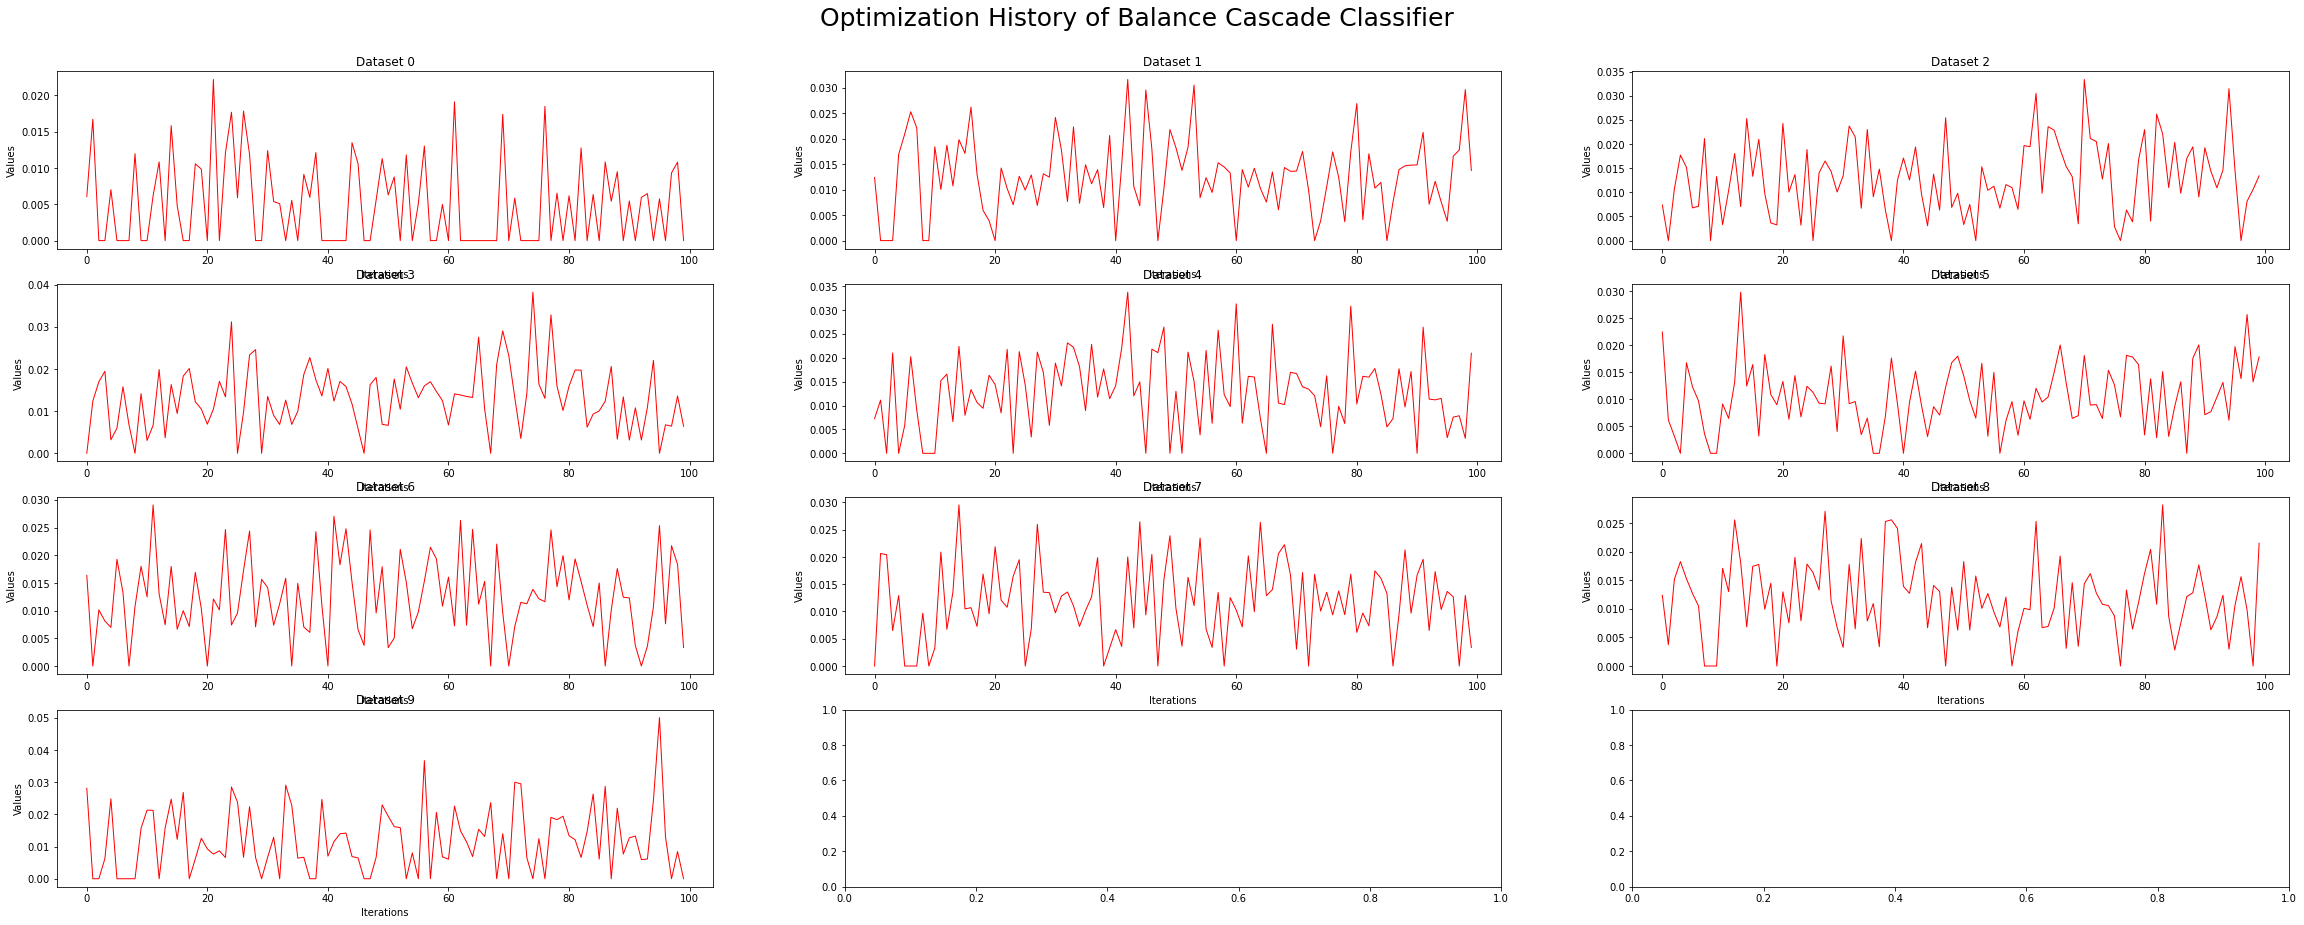

In [6]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 4, num_col = 3, model = 'Balance Cascade Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

### classifier

#### scheme 1

In [ ]:
table_setC = runall_cascade(run_train, run_test, base_paramC, num_iter = 5)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 1 (LightGBM)')

#### scheme 2


 Dataset 0:
Size before Oversampling: 157148
Size after Oversampling: 158333
Size after Undersampling: 1793
Size before Oversampling: 94003
Size after Oversampling: 95188
Size after Undersampling: 1793
Size before Oversampling: 56280
Size after Oversampling: 57463
Size after Undersampling: 1791
Size before Oversampling: 33744
Size after Oversampling: 34920
Size after Undersampling: 1784
Size before Oversampling: 20281
Size after Oversampling: 21457
Size after Undersampling: 1784
Size before Oversampling: 12239
Size after Oversampling: 13407
Size after Undersampling: 1776
Size before Oversampling: 7434
Size after Oversampling: 8724
Size after Undersampling: 1898
Size before Oversampling: 4564
Size after Oversampling: 5822
Size after Undersampling: 1866
Size before Oversampling: 2849
Size after Oversampling: 4067
Size after Undersampling: 1826
Size before Oversampling: 1825
Size after Oversampling: 3013
Precision: 0.002197802197802198 
Recall: 0.0196078431372549 
Aging Rate: 0.009352710

Size after Undersampling: 3610
Size before Oversampling: 31854
Size after Oversampling: 34221
Size after Undersampling: 3583
Size before Oversampling: 23008
Size after Oversampling: 25379
Size after Undersampling: 3587
Size before Oversampling: 16666
Size after Oversampling: 19113
Size after Undersampling: 3663
Size before Oversampling: 12120
Size after Oversampling: 14579
Size after Undersampling: 3675
Size before Oversampling: 8861
Size after Oversampling: 11282
Size after Undersampling: 3637
Size before Oversampling: 6525
Size after Oversampling: 8941
Size after Undersampling: 3632
Size before Oversampling: 4850
Size after Oversampling: 7330
Size after Undersampling: 3696
Size before Oversampling: 3649
Size after Oversampling: 6090
Precision: 0.001358695652173913 
Recall: 0.13725490196078433 
Aging Rate: 0.10590145737836337

 Dataset 9:
Size before Oversampling: 30704
Size after Oversampling: 31990
Size after Undersampling: 1894
Size before Oversampling: 22097
Size after Oversamplin

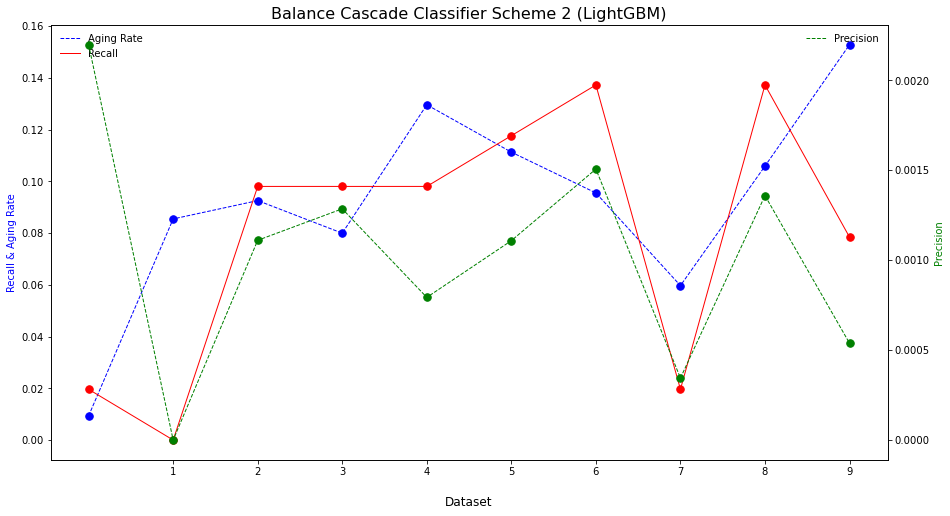

In [7]:
table_setC = runall_cascade(run_train, run_test, base_config = base_paramC, meta_config = meta_paramC)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 2 (LightGBM)')

In [8]:
table_setC

Balance Ratio  Train_OK  Train_NG   TP      FP    FN       TN  \
dataset 0     515.934211  156844.0     304.0  1.0   454.0  50.0  48144.0   
dataset 1     100.000000   59000.0     590.0  0.0  4158.0  51.0  44440.0   
dataset 2     100.000000   60900.0     609.0  5.0  4498.0  46.0  44100.0   
dataset 3     100.000000   60500.0     605.0  5.0  3885.0  46.0  44713.0   
dataset 4     100.000000   60600.0     606.0  5.0  6300.0  46.0  42298.0   
dataset 5      97.280000   60800.0     625.0  6.0  5408.0  45.0  43190.0   
dataset 6     100.000000   60800.0     608.0  7.0  4640.0  44.0  43958.0   
dataset 7     100.495868   60800.0     605.0  1.0  2903.0  50.0  45695.0   
dataset 8     100.000000   60800.0     608.0  7.0  5145.0  44.0  43453.0   
dataset 9     100.000000   30400.0     304.0  4.0  7431.0  47.0  41167.0   

           Precision    Recall  Aging Rate  Efficiency     Score  
dataset 0   0.002198  0.019608    0.009353    2.096488  0.022162  
dataset 1   0.000000  0.000000    0.085469    0.000000  0.000000  
dataset 2   0.001110  0.098039    0.092561    1.059185  0.070815  
dataset 3   0.001285  0.098039    0.079961    1.226095  0.078456  
dataset 4   0.000793  0.098039    0.129602    0.756465  0.000000  
dataset 5   0.001108  0.117647    0.111287    1.057150  0.084861  
dataset 6   0.001506  0.137255    0.095521    1.436908  0.122257  
dataset 7   0.000344  0.019608    0.059693    0.328479  0.000000  
dataset 8   0.001359  0.137255    0.105901    1.296062  0.114086  
dataset 9   0.000538  0.078431    0.152829    0.513195  0.000000

### export

In [9]:
savedate = '20220301'
TPE_multi = False
scheme = 2

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = f'BC_br100_over5_iter10_over5_scheme{scheme}'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = f'BC{scheme}_br100_over5_iter10_over5')